<a href="https://colab.research.google.com/github/cohitai/AI_notebooks/blob/main/VAE/VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Variational AutoEncoder = (encoder= Recognition model, decoder=Generative model)+ Variational loss.

 Variational loss = ELBO (evidence lower bound).



In [1]:
#ToDO: visualizations of the latent space, KL divergence explanations, Generative data. 
### Go over these: 
# Not sure I have the "right" variational loss. 
# https://avandekleut.github.io/vae/
# https://www.jeremyjordan.me/variational-autoencoders/
# https://gaussian37.github.io/deep-learning-chollet-8-4/
# simplify NN ? (How many ResNet layers/Blocks? are actiually meaningfull for a baseline.)
# output doesn't converge well. (check loss ? epochs adjustments/learning rate?)
# plot the loss


# The loss depends heavily on the BS. 
# Compare the loss with the pretrained VAE model(Huggingfaces). 


In [14]:
import torch 
import torchvision
from torch import nn
import torch.nn.functional as F
import numpy as np
import os
import math

print("Working directory:", os.getcwd())
device="cuda"

Working directory: /content


In [2]:
!nvidia-smi

Mon Nov 14 13:34:16 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
## download cifar10 data

In [4]:
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

--2022-11-14 11:42:17--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  86.9MB/s    in 1.9s    

2022-11-14 11:42:19 (86.9 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [5]:
# !ls

cifar-10-python.tar.gz	sample_data


In [6]:
# !tar -xvf cifar-10-python.tar.gz

cifar-10-batches-py/
cifar-10-batches-py/data_batch_4
cifar-10-batches-py/readme.html
cifar-10-batches-py/test_batch
cifar-10-batches-py/data_batch_3
cifar-10-batches-py/batches.meta
cifar-10-batches-py/data_batch_2
cifar-10-batches-py/data_batch_5
cifar-10-batches-py/data_batch_1


In [7]:
# !ls -al cifar-10-batches-py

total 181884
drwxr-xr-x 2 2156 1103     4096 Jun  4  2009 .
drwxr-xr-x 1 root root     4096 Nov 14 11:42 ..
-rw-r--r-- 1 2156 1103      158 Mar 31  2009 batches.meta
-rw-r--r-- 1 2156 1103 31035704 Mar 31  2009 data_batch_1
-rw-r--r-- 1 2156 1103 31035320 Mar 31  2009 data_batch_2
-rw-r--r-- 1 2156 1103 31035999 Mar 31  2009 data_batch_3
-rw-r--r-- 1 2156 1103 31035696 Mar 31  2009 data_batch_4
-rw-r--r-- 1 2156 1103 31035623 Mar 31  2009 data_batch_5
-rw-r--r-- 1 2156 1103       88 Jun  4  2009 readme.html
-rw-r--r-- 1 2156 1103 31035526 Mar 31  2009 test_batch


In [12]:
# import os.path as osp
# path = "./cifar-10-batches-py"
# def unpickle(file):
#     import pickle
#     with open(file, 'rb') as fo:
#         dict = pickle.load(fo, encoding='bytes')
#     return dict

# !ls $path

# c10_data = unpickle(osp.join(path,"data_batch_1"))
# print(c10_data.keys())

# # extract c10 data --> images,labels
# images = c10_data[b"data"].reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8") # (10000,3072)
# labels = c10_data[b"labels"]
# #
# print("Data Shape",images.shape)

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch
dict_keys([b'batch_label', b'labels', b'data', b'filenames'])
Data Shape (10000, 32, 32, 3)


Model Blocks: - DownEncoderBlock2D
              - UpDecoderBlock2D
              - ResnetBlock
              - Downsample2D
              - Upsample2D
              - AttentionBlockNew
              - UNetMidBlock2D
              - Encoder
              - Decoder

In [72]:
class DownEncoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0, 
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_downsample=True,
        downsample_padding=1,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            in_channels = in_channels if i == 0 else out_channels
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_downsample:
            self.downsamplers = nn.ModuleList(
                [
                    Downsample2D(
                        in_channels, use_conv=True, out_channels=out_channels, padding=downsample_padding, name="op"
                    )
                ]
            )
        else:
            self.downsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.downsamplers is not None:
            for downsampler in self.downsamplers:
                hidden_states = downsampler(hidden_states)

        return hidden_states

class UpDecoderBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        output_scale_factor=1.0,
        add_upsample=True,
    ):
        super().__init__()
        resnets = []

        for i in range(num_layers):
            input_channels = in_channels if i == 0 else out_channels

            resnets.append(
                ResnetBlock(
                    in_channels=input_channels,
                    out_channels=out_channels,
                    temb_channels=None,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.resnets = nn.ModuleList(resnets)

        if add_upsample:
            self.upsamplers = nn.ModuleList([Upsample2D(out_channels, use_conv=True, out_channels=out_channels)])
        else:
            self.upsamplers = None

    def forward(self, hidden_states):
        for resnet in self.resnets:
            hidden_states = resnet(hidden_states, temb=None)

        if self.upsamplers is not None:
            for upsampler in self.upsamplers:
                hidden_states = upsampler(hidden_states)

        return hidden_states

  
    
class ResnetBlock(nn.Module):
    def __init__(
        self,
        *,
        in_channels,
        out_channels=None,
        conv_shortcut=False,
        dropout=0.0,
        temb_channels=512,
        groups=32,
        groups_out=None,
        pre_norm=True,
        eps=1e-6,
        non_linearity="swish",
        time_embedding_norm="default",
        kernel=None,
        output_scale_factor=1.0,
        use_nin_shortcut=None,
        up=False,
        down=False,
    ):
        super().__init__()
        self.pre_norm = pre_norm
        self.pre_norm = True
        self.in_channels = in_channels
        out_channels = in_channels if out_channels is None else out_channels
        self.out_channels = out_channels
        self.use_conv_shortcut = conv_shortcut
        self.time_embedding_norm = time_embedding_norm
        self.up = up
        self.down = down
        self.output_scale_factor = output_scale_factor

        if groups_out is None:
            groups_out = groups

        self.norm1 = torch.nn.GroupNorm(num_groups=groups, num_channels=in_channels, eps=eps, affine=True)

        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if temb_channels is not None:
            self.time_emb_proj = torch.nn.Linear(temb_channels, out_channels)
        else:
            self.time_emb_proj = None

        self.norm2 = torch.nn.GroupNorm(num_groups=groups_out, num_channels=out_channels, eps=eps, affine=True)
        self.dropout = torch.nn.Dropout(dropout)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)

        if non_linearity == "swish":
            self.nonlinearity = lambda x: F.silu(x)
        elif non_linearity == "mish":
            self.nonlinearity = Mish()
        elif non_linearity == "silu":
            self.nonlinearity = nn.SiLU()

        self.upsample = self.downsample = None
        if self.up:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.upsample = lambda x: upsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.upsample = partial(F.interpolate, scale_factor=2.0, mode="nearest")
            else:
                self.upsample = Upsample2D(in_channels, use_conv=False)
        
        elif self.down:
            if kernel == "fir":
                fir_kernel = (1, 3, 3, 1)
                self.downsample = lambda x: downsample_2d(x, k=fir_kernel)
            elif kernel == "sde_vp":
                self.downsample = partial(F.avg_pool2d, kernel_size=2, stride=2)
            else:
                self.downsample = Downsample2D(in_channels, use_conv=False, padding=1, name="op")

        self.use_nin_shortcut = self.in_channels != self.out_channels if use_nin_shortcut is None else use_nin_shortcut

        self.conv_shortcut = None
    
        if self.use_nin_shortcut:
            self.conv_shortcut = torch.nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)

    def forward(self, x, temb, hey=False):
        h = x

        # print("LOG resnet_input",h.size())

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm1(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        # if self.upsample is not None:
        #     x = self.upsample(x)
        #     h = self.upsample(h)
        # elif self.downsample is not None:
        #     x = self.downsample(x)
        #     h = self.downsample(h)

        h = self.conv1(h)

        # print("LOG temb:",temb is None)

        # if temb is not None:
        #     temb = self.time_emb_proj(self.nonlinearity(temb))[:, :, None, None]
        #     h = h + temb

        # make sure hidden states is in float32
        # when running in half-precision
        h = self.norm2(h.float()).type(h.dtype)
        h = self.nonlinearity(h)

        h = self.dropout(h)
        h = self.conv2(h)

        if self.conv_shortcut is not None:
            x = self.conv_shortcut(x)

        out = (x + h) / self.output_scale_factor

        return out

    def set_weight(self, resnet):
        self.norm1.weight.data = resnet.norm1.weight.data
        self.norm1.bias.data = resnet.norm1.bias.data

        self.conv1.weight.data = resnet.conv1.weight.data
        self.conv1.bias.data = resnet.conv1.bias.data

        if self.time_emb_proj is not None:
            self.time_emb_proj.weight.data = resnet.temb_proj.weight.data
            self.time_emb_proj.bias.data = resnet.temb_proj.bias.data

        self.norm2.weight.data = resnet.norm2.weight.data
        self.norm2.bias.data = resnet.norm2.bias.data

        self.conv2.weight.data = resnet.conv2.weight.data
        self.conv2.bias.data = resnet.conv2.bias.data

        if self.use_nin_shortcut:
            self.conv_shortcut.weight.data = resnet.nin_shortcut.weight.data
            self.conv_shortcut.bias.data = resnet.nin_shortcut.bias.data
            
            
class Downsample2D(nn.Module):
    """
    A downsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 downsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, out_channels=None, padding=1, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.padding = padding
        stride = 2
        self.name = name

        if use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, stride=stride, padding=padding)
        else:
            assert self.channels == self.out_channels
            conv = nn.AvgPool2d(kernel_size=stride, stride=stride)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.Conv2d_0 = conv
            self.conv = conv
        elif name == "Conv2d_0":
            self.conv = conv
        else:
            self.conv = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv and self.padding == 0:
            pad = (0, 1, 0, 1)
            x = F.pad(x, pad, mode="constant", value=0)

        assert x.shape[1] == self.channels
        x = self.conv(x)

        # print('LOG',x)
        return x

class Upsample2D(nn.Module):

    """
    An upsampling layer with an optional convolution.
    :param channels: channels in the inputs and outputs. :param use_conv: a bool determining if a convolution is
    applied. :param dims: determines if the signal is 1D, 2D, or 3D. If 3D, then
                 upsampling occurs in the inner-two dimensions.
    """

    def __init__(self, channels, use_conv=False, use_conv_transpose=False, out_channels=None, name="conv"):
        super().__init__()
        self.channels = channels
        self.out_channels = out_channels or channels
        self.use_conv = use_conv
        self.use_conv_transpose = use_conv_transpose
        self.name = name

        conv = None
        if use_conv_transpose:
            conv = nn.ConvTranspose2d(channels, self.out_channels, 4, 2, 1)
        elif use_conv:
            conv = nn.Conv2d(self.channels, self.out_channels, 3, padding=1)

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if name == "conv":
            self.conv = conv
        else:
            self.Conv2d_0 = conv

    def forward(self, x):
        assert x.shape[1] == self.channels
        if self.use_conv_transpose:
            return self.conv(x)

        x = F.interpolate(x, scale_factor=2.0, mode="nearest")

        # TODO(Suraj, Patrick) - clean up after weight dicts are correctly renamed
        if self.use_conv:
            if self.name == "conv":
                x = self.conv(x)
            else:
                x = self.Conv2d_0(x)

        return x


class AttentionBlockNew(nn.Module):
    """
    An attention block that allows spatial positions to attend to each other. Originally ported from here, but adapted
    to the N-d case.
    https://github.com/hojonathanho/diffusion/blob/1e0dceb3b3495bbe19116a5e1b3596cd0706c543/diffusion_tf/models/unet.py#L66.
    Uses three q, k, v linear layers to compute attention
    """

    def __init__(
        self,
        channels,
        num_head_channels=None,
        num_groups=32,
        rescale_output_factor=1.0,
        eps=1e-5,
    ):
        super().__init__()
        self.channels = channels

        self.num_heads = channels // num_head_channels if num_head_channels is not None else 1
        self.num_head_size = num_head_channels
        self.group_norm = nn.GroupNorm(num_channels=channels, num_groups=num_groups, eps=eps, affine=True)

        # define q,k,v as linear layers
        self.query = nn.Linear(channels, channels)
        self.key = nn.Linear(channels, channels)
        self.value = nn.Linear(channels, channels)

        self.rescale_output_factor = rescale_output_factor
        self.proj_attn = nn.Linear(channels, channels, 1)

    def transpose_for_scores(self, projection: torch.Tensor) -> torch.Tensor:
        new_projection_shape = projection.size()[:-1] + (self.num_heads, -1)
        # move heads to 2nd position (B, T, H * D) -> (B, T, H, D) -> (B, H, T, D)
        new_projection = projection.view(new_projection_shape).permute(0, 2, 1, 3)
        return new_projection

    def forward(self, hidden_states):
        residual = hidden_states
        batch, channel, height, width = hidden_states.shape

        # norm
        hidden_states = self.group_norm(hidden_states)

        hidden_states = hidden_states.view(batch, channel, height * width).transpose(1, 2)

        # proj to q, k, v
        query_proj = self.query(hidden_states)
        key_proj = self.key(hidden_states)
        value_proj = self.value(hidden_states)

        # transpose
        query_states = self.transpose_for_scores(query_proj)
        key_states = self.transpose_for_scores(key_proj)
        value_states = self.transpose_for_scores(value_proj)

        # get scores
        scale = 1 / math.sqrt(math.sqrt(self.channels / self.num_heads))
        attention_scores = torch.matmul(query_states * scale, key_states.transpose(-1, -2) * scale)
        attention_probs = torch.softmax(attention_scores.float(), dim=-1).type(attention_scores.dtype)

        # compute attention output
        context_states = torch.matmul(attention_probs, value_states)

        context_states = context_states.permute(0, 2, 1, 3).contiguous()
        new_context_states_shape = context_states.size()[:-2] + (self.channels,)
        context_states = context_states.view(new_context_states_shape)

        # compute next hidden_states
        hidden_states = self.proj_attn(context_states)
        hidden_states = hidden_states.transpose(-1, -2).reshape(batch, channel, height, width)

        # res connect and rescale
        hidden_states = (hidden_states + residual) / self.rescale_output_factor
        return hidden_states

    def set_weight(self, attn_layer):
        self.group_norm.weight.data = attn_layer.norm.weight.data
        self.group_norm.bias.data = attn_layer.norm.bias.data

        if hasattr(attn_layer, "q"):
            self.query.weight.data = attn_layer.q.weight.data[:, :, 0, 0]
            self.key.weight.data = attn_layer.k.weight.data[:, :, 0, 0]
            self.value.weight.data = attn_layer.v.weight.data[:, :, 0, 0]

            self.query.bias.data = attn_layer.q.bias.data
            self.key.bias.data = attn_layer.k.bias.data
            self.value.bias.data = attn_layer.v.bias.data

            self.proj_attn.weight.data = attn_layer.proj_out.weight.data[:, :, 0, 0]
            self.proj_attn.bias.data = attn_layer.proj_out.bias.data
        elif hasattr(attn_layer, "NIN_0"):
            self.query.weight.data = attn_layer.NIN_0.W.data.T
            self.key.weight.data = attn_layer.NIN_1.W.data.T
            self.value.weight.data = attn_layer.NIN_2.W.data.T

            self.query.bias.data = attn_layer.NIN_0.b.data
            self.key.bias.data = attn_layer.NIN_1.b.data
            self.value.bias.data = attn_layer.NIN_2.b.data

            self.proj_attn.weight.data = attn_layer.NIN_3.W.data.T
            self.proj_attn.bias.data = attn_layer.NIN_3.b.data

            self.group_norm.weight.data = attn_layer.GroupNorm_0.weight.data
            self.group_norm.bias.data = attn_layer.GroupNorm_0.bias.data
        else:
            qkv_weight = attn_layer.qkv.weight.data.reshape(
                self.num_heads, 3 * self.channels // self.num_heads, self.channels
            )
            qkv_bias = attn_layer.qkv.bias.data.reshape(self.num_heads, 3 * self.channels // self.num_heads)

            q_w, k_w, v_w = qkv_weight.split(self.channels // self.num_heads, dim=1)
            q_b, k_b, v_b = qkv_bias.split(self.channels // self.num_heads, dim=1)

            self.query.weight.data = q_w.reshape(-1, self.channels)
            self.key.weight.data = k_w.reshape(-1, self.channels)
            self.value.weight.data = v_w.reshape(-1, self.channels)

            self.query.bias.data = q_b.reshape(-1)
            self.key.bias.data = k_b.reshape(-1)
            self.value.bias.data = v_b.reshape(-1)

            self.proj_attn.weight.data = attn_layer.proj.weight.data[:, :, 0]
            self.proj_attn.bias.data = attn_layer.proj.bias.data

class UNetMidBlock2D(nn.Module):
    def __init__(
        self,
        in_channels: int,
        temb_channels: int,
        dropout: float = 0.0,
        num_layers: int = 1,
        resnet_eps: float = 1e-6,
        resnet_time_scale_shift: str = "default",
        resnet_act_fn: str = "swish",
        resnet_groups: int = 32,
        resnet_pre_norm: bool = True,
        attn_num_head_channels=1,
        attention_type="default",
        output_scale_factor=1.0,
        **kwargs,
    ):
        super().__init__()

        self.attention_type = attention_type
        resnet_groups = resnet_groups if resnet_groups is not None else min(in_channels // 4, 32)

        # there is always at least one resnet
        resnets = [
            ResnetBlock(
                in_channels=in_channels,
                out_channels=in_channels,
                temb_channels=temb_channels,
                eps=resnet_eps,
                groups=resnet_groups,
                dropout=dropout,
                time_embedding_norm=resnet_time_scale_shift,
                non_linearity=resnet_act_fn,
                output_scale_factor=output_scale_factor,
                pre_norm=resnet_pre_norm,
            )
        ]
        attentions = []

        for _ in range(num_layers):
            attentions.append(
                AttentionBlockNew(
                    in_channels,
                    num_head_channels=attn_num_head_channels,
                    rescale_output_factor=output_scale_factor,
                    eps=resnet_eps,
                    num_groups=resnet_groups,
                )
            )
            resnets.append(
                ResnetBlock(
                    in_channels=in_channels,
                    out_channels=in_channels,
                    temb_channels=temb_channels,
                    eps=resnet_eps,
                    groups=resnet_groups,
                    dropout=dropout,
                    time_embedding_norm=resnet_time_scale_shift,
                    non_linearity=resnet_act_fn,
                    output_scale_factor=output_scale_factor,
                    pre_norm=resnet_pre_norm,
                )
            )

        self.attentions = nn.ModuleList(attentions)
        self.resnets = nn.ModuleList(resnets)

    def forward(self, hidden_states, temb=None, encoder_states=None):
        hidden_states = self.resnets[0](hidden_states, temb)
        for attn, resnet in zip(self.attentions, self.resnets[1:]):
            if self.attention_type == "default":
                hidden_states = attn(hidden_states)
            else:
                hidden_states = attn(hidden_states, encoder_states)
            hidden_states = resnet(hidden_states, temb)

        return hidden_states


class Encoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True,
    ):
        super().__init__()
        self.layers_per_block = layers_per_block
        self.conv_in = torch.nn.Conv2d(in_channels, block_out_channels[0], kernel_size=3, stride=1, padding=1)
        self.mid_block = None
        self.down_blocks = nn.ModuleList([])

        # down
        output_channel = block_out_channels[0]
        for i, _ in enumerate(down_block_types):
            input_channel = output_channel
            output_channel = block_out_channels[i]
            is_final_block = i == len(block_out_channels) - 1

            down_block = DownEncoderBlock2D(
                num_layers=self.layers_per_block,
                in_channels=input_channel,
                out_channels=output_channel,
                add_downsample=not is_final_block,
                resnet_eps=1e-6,
                resnet_act_fn=act_fn,
                downsample_padding=0,)

            self.down_blocks.append(down_block)

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[-1], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()

        conv_out_channels = 2 * out_channels if double_z else out_channels
        self.conv_out = nn.Conv2d(block_out_channels[-1], conv_out_channels, 3, padding=1)

    def forward(self, x):
        
        sample = x
        sample = self.conv_in(sample)
        
        # down
        for down_block in self.down_blocks:
            sample = down_block(sample)

        # middle
        sample = self.mid_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample


class Decoder(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        up_block_types=("UpDecoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=2,
        act_fn="silu",
    ):
        super().__init__()
        self.layers_per_block = layers_per_block

        self.conv_in = nn.Conv2d(in_channels, block_out_channels[-1], kernel_size=3, stride=1, padding=1)

        self.mid_block = None
        self.up_blocks = nn.ModuleList([])

        # mid
        self.mid_block = UNetMidBlock2D(
            in_channels=block_out_channels[-1],
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
            output_scale_factor=1,
            resnet_time_scale_shift="default",
            attn_num_head_channels=None,
            resnet_groups=32,
            temb_channels=None,
        )

        # up
        reversed_block_out_channels = list(reversed(block_out_channels))
        output_channel = reversed_block_out_channels[0]
        for i, up_block_type in enumerate(up_block_types):
            prev_output_channel = output_channel
            output_channel = reversed_block_out_channels[i]

            is_final_block = i == len(block_out_channels) - 1

            up_block = UpDecoderBlock2D(
            num_layers=self.layers_per_block + 1,
            in_channels=prev_output_channel,
            out_channels=output_channel,
            add_upsample=not is_final_block,
            resnet_eps=1e-6,
            resnet_act_fn=act_fn,
        )

            self.up_blocks.append(up_block)
            prev_output_channel = output_channel

        # out
        num_groups_out = 32
        self.conv_norm_out = nn.GroupNorm(num_channels=block_out_channels[0], num_groups=num_groups_out, eps=1e-6)
        self.conv_act = nn.SiLU()
        self.conv_out = nn.Conv2d(block_out_channels[0], out_channels, 3, padding=1)

    def forward(self, z):
        sample = z
        sample = self.conv_in(sample)

        # middle
        sample = self.mid_block(sample)

        # up
        for up_block in self.up_blocks:
            sample = up_block(sample)

        # post-process
        sample = self.conv_norm_out(sample)
        sample = self.conv_act(sample)
        sample = self.conv_out(sample)

        return sample

In [73]:
class DiagonalGaussianDistribution(object):
    def __init__(self, parameters, deterministic=False):
        self.parameters = parameters
        self.mean, self.logvar = torch.chunk(parameters, 2, dim=1)
        self.logvar = torch.clamp(self.logvar, -30.0, 20.0)
        self.deterministic = deterministic
        self.std = torch.exp(0.5 * self.logvar)
        self.var = torch.exp(self.logvar)
        if self.deterministic:
            self.var = self.std = torch.zeros_like(self.mean).to(device=self.parameters.device)

    def sample(self):
        x = self.mean + self.std * torch.randn(self.mean.shape).to(device=self.parameters.device)
        return x

    def kl(self, other=None):
        if self.deterministic:
            return torch.Tensor([0.0])
        else:
            if other is None:
                return 0.5 * torch.sum(torch.pow(self.mean, 2) + self.var - 1.0 - self.logvar, dim=[1, 2, 3])
            else:
                return 0.5 * torch.sum(
                    torch.pow(self.mean - other.mean, 2) / other.var
                    + self.var / other.var
                    - 1.0
                    - self.logvar
                    + other.logvar,
                    dim=[1, 2, 3],
                )

    def nll(self, sample, dims=[1, 2, 3]):
        if self.deterministic:
            return torch.Tensor([0.0])
        logtwopi = np.log(2.0 * np.pi)
        return 0.5 * torch.sum(logtwopi + self.logvar + torch.pow(sample - self.mean, 2) / self.var, dim=dims)

    def mode(self):
        return self.mean



encoder = Encoder(in_channels=3,
        out_channels=4,
        down_block_types=("DownEncoderBlock2D",),
        block_out_channels=(64,),
        layers_per_block=1,
        act_fn="silu",
        double_z=True)


decoder = Decoder(in_channels=4,
            out_channels=3,
            up_block_types=("UpDecoderBlock2D",),
            block_out_channels=(64,),
            layers_per_block=1,
            act_fn="silu")





    ##########################
    ##########################
    ##########################
#### AutoEncoder wrap- up class ####
    ##########################
    ##########################
    ##########################

class AutoencoderKL(nn.Module):
    def __init__(
        self,
        in_channels=3,
        out_channels=3,
        down_block_types=("DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D","DownEncoderBlock2D",),
        up_block_types=("UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D","UpDecoderBlock2D",),
        block_out_channels=(128, 256, 512, 512,),
        layers_per_block=2,
        act_fn="silu",
        latent_channels=4,
        sample_size=512,
    ):
        super().__init__()

        # pass init params to Encoder
        self.encoder = Encoder(
            in_channels=in_channels,
            out_channels=latent_channels,
            down_block_types=down_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
            double_z=True,
        )

        # pass init params to Decoder
        self.decoder = Decoder(
            in_channels=latent_channels,
            out_channels=out_channels,
            up_block_types=up_block_types,
            block_out_channels=block_out_channels,
            layers_per_block=layers_per_block,
            act_fn=act_fn,
        )

        self.quant_conv = torch.nn.Conv2d(2 * latent_channels, 2 * latent_channels, 1)
        self.post_quant_conv = torch.nn.Conv2d(latent_channels, latent_channels, 1) 
        self.kl = 0

    def encode(self, x):
        h = self.encoder(x)
        moments = self.quant_conv(h)
        posterior = DiagonalGaussianDistribution(moments)
        return posterior

    def decode(self, z):
        z = self.post_quant_conv(z)
        dec = self.decoder(z)
        return dec

    def forward(self, sample, sample_posterior=False):
        x = sample
        posterior = self.encode(x)
        if sample_posterior:
            z = posterior.sample()
        else:
            z = posterior.mode()
        dec = self.decode(z)
        self.kl=posterior.kl()
        return dec


# **Training function**

In [88]:
##### train
from tqdm import tqdm
PATH = './vae_net.pth'
losses=[]
def train(autoencoder, data, epochs=20,exp=None):

    def adjust(sample):
        # sample=np.expand_dims(np.asarray(sample), axis=0)
        sample=sample.numpy()/ 1.0
        # sample=sample.astype('float32')
        sample = torch.from_numpy(sample).float() # Batch - RGB channel - WxH 
        sample = 2 * (sample - 0.5) # values between (-1, 1)
        return sample

    if not exp:
        model_file='./{}_net.pth'.format(exp)
    else:
        model_file=PATH
    
    global opt
    opt = torch.optim.Adam(autoencoder.parameters())
    scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.9)
    epoch = 0

    if os.path.exists(model_file):
      checkpoint = torch.load(model_file)
      autoencoder.load_state_dict(checkpoint['model_state_dict'])
      opt.load_state_dict(checkpoint['optimizer_state_dict'])
      scheduler.load_state_dict(checkpoint['scheduler'])
      epoch = checkpoint['epoch']
      loss = checkpoint['loss']

    for epoch in range(epoch, epochs):
        print("Log epoch:",epoch)
        for i,x in enumerate(tqdm(data,total=len(data))):
            x=adjust(x[0]) # Values between -1..1 
            x = torch.Tensor(x).to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = ((x - x_hat)**2).sum() + autoencoder.kl.sum()
            loss.backward()
            opt.step()
            loss=loss.item()
            losses.append(loss)
            print(loss)

            if not i % 300 and i != 0: 
                torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
                print("model saved!")
        
        scheduler.step()
        torch.save({
                'epoch': epoch,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': opt.state_dict(),
                'loss': loss,
                'scheduler':scheduler.state_dict()}, model_file)
        print("model saved!")
   
    return autoencoder,losses

**DataLoader Cifar10** 

In [89]:
#ToDo: https://gist.github.com/kevinzakka/d33bf8d6c7f06a9d8c76d97a7879f5cb
# normalize dataset.

def load_data(BS=32,path = "./cifar-10-batches-py"):
    train = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True),
        batch_size=32,
        shuffle=True)
    
    test = torch.utils.data.DataLoader(
        torchvision.datasets.CIFAR10(path,
               transform=torchvision.transforms.ToTensor(),
               download=True,train=False),
        batch_size=32,
        shuffle=True)
        
    print(train.dataset)
    print(test.dataset)
    print("train data size:",next(iter(data))[0].size())

    return train,test


**Train/Test Split**


In [85]:
train_data,test_data=load_data(BS=32)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])


In [86]:
next(iter(train_data))[0].min(),next(iter(train_data))[0].max(),next(iter(train_data))[0].size()

(tensor(0.), tensor(1.), torch.Size([32, 3, 32, 32]))

Training Variational AutoEncoder on Cifar10 data.

In [ ]:
train_data,test_data=load_data(BS=32)
vae=AutoencoderKL().to(device)
vae, = train(vae, train_data,epochs=10,exp="test2")

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./cifar-10-batches-py
    Split: Train
    StandardTransform
Transform: ToTensor()
Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ./cifar-10-batches-py
    Split: Test
    StandardTransform
Transform: ToTensor()
train data size: torch.Size([32, 3, 32, 32])
Log epoch: 2


  0%|          | 1/1563 [00:00<08:55,  2.92it/s]

10581.81640625


  0%|          | 2/1563 [00:00<08:02,  3.23it/s]

9934.6748046875


  0%|          | 3/1563 [00:00<07:45,  3.35it/s]

13217.529296875


  0%|          | 4/1563 [00:01<07:39,  3.39it/s]

10443.2958984375


  0%|          | 5/1563 [00:01<07:35,  3.42it/s]

9757.115234375


  0%|          | 6/1563 [00:01<07:32,  3.44it/s]

10338.67578125


  0%|          | 7/1563 [00:02<07:30,  3.45it/s]

10436.779296875


  1%|          | 8/1563 [00:02<07:29,  3.46it/s]

11182.150390625


  1%|          | 9/1563 [00:02<07:29,  3.46it/s]

8956.880859375


  1%|          | 10/1563 [00:02<07:28,  3.46it/s]

9396.61328125


  1%|          | 11/1563 [00:03<07:27,  3.47it/s]

10075.166015625


  1%|          | 12/1563 [00:03<07:26,  3.47it/s]

10826.591796875


  1%|          | 13/1563 [00:03<07:27,  3.47it/s]

9945.7001953125


  1%|          | 14/1563 [00:04<07:25,  3.48it/s]

11531.537109375


  1%|          | 15/1563 [00:04<07:25,  3.48it/s]

11827.5986328125


  1%|          | 16/1563 [00:04<07:25,  3.48it/s]

11408.67578125


  1%|          | 17/1563 [00:04<07:25,  3.47it/s]

10239.25


  1%|          | 18/1563 [00:05<07:25,  3.47it/s]

12020.927734375


  1%|          | 19/1563 [00:05<07:26,  3.46it/s]

11121.4384765625


  1%|▏         | 20/1563 [00:05<07:25,  3.46it/s]

10762.6572265625


  1%|▏         | 21/1563 [00:06<07:25,  3.46it/s]

9902.1669921875


  1%|▏         | 22/1563 [00:06<07:24,  3.46it/s]

10962.25


  1%|▏         | 23/1563 [00:06<07:25,  3.46it/s]

11741.3193359375


  2%|▏         | 24/1563 [00:06<07:24,  3.46it/s]

10957.5732421875


  2%|▏         | 25/1563 [00:07<07:24,  3.46it/s]

10246.2001953125


  2%|▏         | 26/1563 [00:07<07:24,  3.46it/s]

10130.2265625


  2%|▏         | 27/1563 [00:07<07:24,  3.46it/s]

10738.6865234375


  2%|▏         | 28/1563 [00:08<07:23,  3.46it/s]

9681.16015625


  2%|▏         | 29/1563 [00:08<07:24,  3.45it/s]

12546.986328125


  2%|▏         | 30/1563 [00:08<07:22,  3.46it/s]

10283.029296875


  2%|▏         | 31/1563 [00:08<07:22,  3.46it/s]

11169.849609375


  2%|▏         | 32/1563 [00:09<07:21,  3.47it/s]

11053.150390625


  2%|▏         | 33/1563 [00:09<07:21,  3.47it/s]

10054.9765625


  2%|▏         | 34/1563 [00:09<07:21,  3.46it/s]

9888.419921875


  2%|▏         | 35/1563 [00:10<07:22,  3.45it/s]

10946.904296875


  2%|▏         | 36/1563 [00:10<07:21,  3.46it/s]

9696.4453125


  2%|▏         | 37/1563 [00:10<07:21,  3.46it/s]

12595.822265625


  2%|▏         | 38/1563 [00:11<07:20,  3.46it/s]

8976.986328125


  2%|▏         | 39/1563 [00:11<07:20,  3.46it/s]

9233.169921875


  3%|▎         | 40/1563 [00:11<07:21,  3.45it/s]

11865.7177734375


  3%|▎         | 41/1563 [00:11<07:19,  3.46it/s]

11152.017578125


  3%|▎         | 42/1563 [00:12<07:20,  3.46it/s]

10085.1298828125


  3%|▎         | 43/1563 [00:12<07:20,  3.45it/s]

10791.7861328125


  3%|▎         | 44/1563 [00:12<07:20,  3.45it/s]

10075.34375


  3%|▎         | 45/1563 [00:13<07:20,  3.45it/s]

11874.5146484375


  3%|▎         | 46/1563 [00:13<07:20,  3.45it/s]

10699.8623046875


  3%|▎         | 47/1563 [00:13<07:19,  3.45it/s]

11328.876953125


  3%|▎         | 48/1563 [00:13<07:19,  3.45it/s]

9558.958984375


  3%|▎         | 49/1563 [00:14<07:18,  3.45it/s]

10115.5498046875


  3%|▎         | 50/1563 [00:14<07:18,  3.45it/s]

11529.544921875


  3%|▎         | 51/1563 [00:14<07:18,  3.45it/s]

10623.8056640625


  3%|▎         | 52/1563 [00:15<07:18,  3.45it/s]

10624.125


  3%|▎         | 53/1563 [00:15<07:18,  3.44it/s]

10241.828125


  3%|▎         | 54/1563 [00:15<07:17,  3.45it/s]

10478.865234375


  4%|▎         | 55/1563 [00:15<07:16,  3.45it/s]

10993.421875


  4%|▎         | 56/1563 [00:16<07:15,  3.46it/s]

11113.3505859375


  4%|▎         | 57/1563 [00:16<07:16,  3.45it/s]

9615.3671875


  4%|▎         | 58/1563 [00:16<07:15,  3.45it/s]

10037.36328125


  4%|▍         | 59/1563 [00:17<07:16,  3.45it/s]

11257.2236328125


  4%|▍         | 60/1563 [00:17<07:16,  3.45it/s]

10108.3388671875


  4%|▍         | 61/1563 [00:17<07:17,  3.43it/s]

9423.0107421875


  4%|▍         | 62/1563 [00:17<07:17,  3.43it/s]

12485.076171875


  4%|▍         | 63/1563 [00:18<07:16,  3.44it/s]

9863.26171875


  4%|▍         | 64/1563 [00:18<07:16,  3.44it/s]

11851.796875


  4%|▍         | 65/1563 [00:18<07:15,  3.44it/s]

9977.5927734375


  4%|▍         | 66/1563 [00:19<07:16,  3.43it/s]

11675.33203125


  4%|▍         | 67/1563 [00:19<07:16,  3.43it/s]

11730.7509765625


  4%|▍         | 68/1563 [00:19<07:15,  3.43it/s]

9015.60546875


  4%|▍         | 69/1563 [00:20<07:14,  3.44it/s]

10944.533203125


  4%|▍         | 70/1563 [00:20<07:13,  3.44it/s]

10266.1357421875


  5%|▍         | 71/1563 [00:20<07:14,  3.43it/s]

9214.955078125


  5%|▍         | 72/1563 [00:20<07:14,  3.43it/s]

10215.515625


  5%|▍         | 73/1563 [00:21<07:13,  3.43it/s]

10814.1748046875


  5%|▍         | 74/1563 [00:21<07:22,  3.37it/s]

11025.724609375


  5%|▍         | 75/1563 [00:21<07:25,  3.34it/s]

11806.9287109375


  5%|▍         | 76/1563 [00:22<07:23,  3.35it/s]

9422.0361328125


  5%|▍         | 77/1563 [00:22<07:31,  3.29it/s]

11031.140625


  5%|▍         | 78/1563 [00:22<07:38,  3.24it/s]

10462.8251953125


  5%|▌         | 79/1563 [00:23<07:30,  3.30it/s]

10249.7138671875


  5%|▌         | 80/1563 [00:23<07:32,  3.28it/s]

10784.5390625


  5%|▌         | 81/1563 [00:23<07:53,  3.13it/s]

10587.8193359375


  5%|▌         | 82/1563 [00:23<07:40,  3.22it/s]

11389.6787109375


  5%|▌         | 83/1563 [00:24<07:31,  3.28it/s]

11244.4990234375


  5%|▌         | 84/1563 [00:24<07:26,  3.32it/s]

11556.125


  5%|▌         | 85/1563 [00:24<07:20,  3.35it/s]

11447.6171875


  6%|▌         | 86/1563 [00:25<07:16,  3.38it/s]

10135.58203125


  6%|▌         | 87/1563 [00:25<07:14,  3.39it/s]

9949.1259765625


  6%|▌         | 88/1563 [00:25<07:13,  3.40it/s]

9576.60546875


  6%|▌         | 89/1563 [00:26<07:11,  3.42it/s]

9578.8896484375


  6%|▌         | 90/1563 [00:26<07:12,  3.41it/s]

9685.2138671875


  6%|▌         | 91/1563 [00:26<07:10,  3.42it/s]

10567.3837890625


  6%|▌         | 92/1563 [00:26<07:10,  3.42it/s]

12024.71484375


  6%|▌         | 93/1563 [00:27<07:09,  3.42it/s]

11462.158203125


  6%|▌         | 94/1563 [00:27<07:08,  3.43it/s]

10737.75


  6%|▌         | 95/1563 [00:27<07:08,  3.43it/s]

10986.9931640625


  6%|▌         | 96/1563 [00:28<07:07,  3.43it/s]

9336.662109375


  6%|▌         | 97/1563 [00:28<07:08,  3.42it/s]

9312.2392578125


  6%|▋         | 98/1563 [00:28<07:08,  3.42it/s]

9593.3349609375


  6%|▋         | 99/1563 [00:28<07:07,  3.43it/s]

10241.77734375


  6%|▋         | 100/1563 [00:29<07:06,  3.43it/s]

11299.1494140625


  6%|▋         | 101/1563 [00:29<07:06,  3.43it/s]

11034.1650390625


  7%|▋         | 102/1563 [00:29<07:05,  3.43it/s]

9714.34765625


  7%|▋         | 103/1563 [00:30<07:04,  3.44it/s]

10999.4365234375


  7%|▋         | 104/1563 [00:30<07:05,  3.43it/s]

10288.2958984375


  7%|▋         | 105/1563 [00:30<07:06,  3.42it/s]

10590.5166015625


  7%|▋         | 106/1563 [00:30<07:06,  3.42it/s]

9851.177734375


  7%|▋         | 107/1563 [00:31<07:05,  3.42it/s]

10700.123046875


  7%|▋         | 108/1563 [00:31<07:03,  3.43it/s]

11774.416015625


  7%|▋         | 109/1563 [00:31<07:03,  3.43it/s]

10510.5810546875


  7%|▋         | 110/1563 [00:32<07:03,  3.43it/s]

9520.9873046875


  7%|▋         | 111/1563 [00:32<07:02,  3.43it/s]

10123.9677734375


  7%|▋         | 112/1563 [00:32<07:03,  3.43it/s]

10082.4248046875


  7%|▋         | 113/1563 [00:33<07:02,  3.43it/s]

11015.630859375


  7%|▋         | 114/1563 [00:33<07:02,  3.43it/s]

11390.0439453125


  7%|▋         | 115/1563 [00:33<07:01,  3.44it/s]

9873.1923828125


  7%|▋         | 116/1563 [00:33<07:01,  3.43it/s]

10122.7548828125


  7%|▋         | 117/1563 [00:34<07:00,  3.44it/s]

10440.296875


  8%|▊         | 118/1563 [00:34<07:00,  3.43it/s]

10074.7998046875


  8%|▊         | 119/1563 [00:34<07:00,  3.43it/s]

9340.8564453125


  8%|▊         | 120/1563 [00:35<07:01,  3.42it/s]

10460.87109375


  8%|▊         | 121/1563 [00:35<07:02,  3.42it/s]

10468.8271484375


  8%|▊         | 122/1563 [00:35<07:01,  3.42it/s]

10589.2822265625


  8%|▊         | 123/1563 [00:35<07:01,  3.42it/s]

10762.0009765625


  8%|▊         | 124/1563 [00:36<07:00,  3.42it/s]

11055.2978515625


  8%|▊         | 125/1563 [00:36<07:00,  3.42it/s]

10103.796875


  8%|▊         | 126/1563 [00:36<06:59,  3.43it/s]

9114.310546875


  8%|▊         | 127/1563 [00:37<07:02,  3.40it/s]

10157.1318359375


  8%|▊         | 128/1563 [00:37<07:01,  3.41it/s]

10565.7763671875


  8%|▊         | 129/1563 [00:37<07:01,  3.41it/s]

9400.0966796875


  8%|▊         | 130/1563 [00:37<07:01,  3.40it/s]

10240.865234375


  8%|▊         | 131/1563 [00:38<07:01,  3.40it/s]

10274.5966796875


  8%|▊         | 132/1563 [00:38<07:00,  3.41it/s]

10160.8544921875


  9%|▊         | 133/1563 [00:38<07:00,  3.40it/s]

9552.818359375


  9%|▊         | 134/1563 [00:39<07:00,  3.40it/s]

10997.9169921875


  9%|▊         | 135/1563 [00:39<07:00,  3.40it/s]

11521.591796875


  9%|▊         | 136/1563 [00:39<06:59,  3.40it/s]

10062.0361328125


  9%|▉         | 137/1563 [00:40<06:57,  3.41it/s]

9836.830078125


  9%|▉         | 138/1563 [00:40<06:58,  3.41it/s]

10039.666015625


  9%|▉         | 139/1563 [00:40<06:57,  3.41it/s]

10177.96484375


  9%|▉         | 140/1563 [00:40<06:56,  3.42it/s]

10331.029296875


  9%|▉         | 141/1563 [00:41<06:56,  3.41it/s]

10597.65625


  9%|▉         | 142/1563 [00:41<06:56,  3.41it/s]

9803.2666015625


  9%|▉         | 143/1563 [00:41<06:57,  3.40it/s]

11421.115234375


  9%|▉         | 144/1563 [00:42<06:55,  3.41it/s]

10243.75


  9%|▉         | 145/1563 [00:42<06:56,  3.41it/s]

10598.41796875


  9%|▉         | 146/1563 [00:42<06:57,  3.40it/s]

10325.724609375


  9%|▉         | 147/1563 [00:42<06:56,  3.40it/s]

11060.1474609375


  9%|▉         | 148/1563 [00:43<06:56,  3.40it/s]

10340.23828125


 10%|▉         | 149/1563 [00:43<06:55,  3.40it/s]

10979.693359375


 10%|▉         | 150/1563 [00:43<06:54,  3.41it/s]

10566.8486328125


 10%|▉         | 151/1563 [00:44<06:54,  3.41it/s]

9669.4306640625


 10%|▉         | 152/1563 [00:44<06:54,  3.41it/s]

12334.7939453125


 10%|▉         | 153/1563 [00:44<06:53,  3.41it/s]

11005.0712890625


 10%|▉         | 154/1563 [00:45<06:52,  3.41it/s]

10584.56640625


 10%|▉         | 155/1563 [00:45<06:52,  3.41it/s]

9620.9814453125


 10%|▉         | 156/1563 [00:45<06:52,  3.41it/s]

11166.908203125


 10%|█         | 157/1563 [00:45<06:52,  3.41it/s]

11420.5546875


 10%|█         | 158/1563 [00:46<06:53,  3.40it/s]

10914.0927734375


 10%|█         | 159/1563 [00:46<06:52,  3.41it/s]

10480.1650390625


 10%|█         | 160/1563 [00:46<06:53,  3.39it/s]

10221.771484375


 10%|█         | 161/1563 [00:47<06:53,  3.39it/s]

11080.4599609375


 10%|█         | 162/1563 [00:47<06:52,  3.40it/s]

9155.01171875


 10%|█         | 163/1563 [00:47<06:52,  3.40it/s]

12684.90234375


 10%|█         | 164/1563 [00:47<06:52,  3.39it/s]

9921.2509765625


 11%|█         | 165/1563 [00:48<06:51,  3.39it/s]

9795.884765625


 11%|█         | 166/1563 [00:48<06:51,  3.40it/s]

9100.5263671875


 11%|█         | 167/1563 [00:48<06:50,  3.40it/s]

10947.9111328125


 11%|█         | 168/1563 [00:49<06:49,  3.41it/s]

10916.2841796875


 11%|█         | 169/1563 [00:49<06:49,  3.41it/s]

10568.6904296875


 11%|█         | 170/1563 [00:49<06:48,  3.41it/s]

11479.4091796875


 11%|█         | 171/1563 [00:50<06:47,  3.41it/s]

9645.31640625


 11%|█         | 172/1563 [00:50<06:48,  3.40it/s]

9782.6171875


 11%|█         | 173/1563 [00:50<06:48,  3.40it/s]

10385.48828125


 11%|█         | 174/1563 [00:50<06:48,  3.40it/s]

12349.1630859375


 11%|█         | 175/1563 [00:51<06:48,  3.40it/s]

9559.5224609375


 11%|█▏        | 176/1563 [00:51<06:47,  3.40it/s]

9935.8466796875


 11%|█▏        | 177/1563 [00:51<06:46,  3.41it/s]

9757.2294921875


 11%|█▏        | 178/1563 [00:52<06:47,  3.40it/s]

10149.3017578125


 11%|█▏        | 179/1563 [00:52<06:48,  3.39it/s]

11622.6103515625


 12%|█▏        | 180/1563 [00:52<06:48,  3.39it/s]

10875.8671875


 12%|█▏        | 181/1563 [00:52<06:47,  3.39it/s]

10538.3212890625


 12%|█▏        | 182/1563 [00:53<06:47,  3.39it/s]

10741.28515625


 12%|█▏        | 183/1563 [00:53<06:46,  3.39it/s]

9393.7470703125


 12%|█▏        | 184/1563 [00:53<06:45,  3.40it/s]

10731.349609375


 12%|█▏        | 185/1563 [00:54<06:44,  3.40it/s]

9655.810546875


 12%|█▏        | 186/1563 [00:54<06:45,  3.40it/s]

11551.205078125


 12%|█▏        | 187/1563 [00:54<06:44,  3.40it/s]

8799.3974609375


 12%|█▏        | 188/1563 [00:55<06:44,  3.40it/s]

10479.6875


 12%|█▏        | 189/1563 [00:55<06:43,  3.40it/s]

11524.1826171875


 12%|█▏        | 190/1563 [00:55<06:43,  3.41it/s]

10879.9384765625


 12%|█▏        | 191/1563 [00:55<06:42,  3.41it/s]

10214.93359375


 12%|█▏        | 192/1563 [00:56<06:44,  3.39it/s]

10874.4599609375


 12%|█▏        | 193/1563 [00:56<06:44,  3.39it/s]

10795.7119140625


 12%|█▏        | 194/1563 [00:56<06:43,  3.39it/s]

9473.6494140625


 12%|█▏        | 195/1563 [00:57<06:42,  3.39it/s]

10265.734375


 13%|█▎        | 196/1563 [00:57<06:42,  3.40it/s]

9684.0693359375


 13%|█▎        | 197/1563 [00:57<06:43,  3.39it/s]

11617.185546875


 13%|█▎        | 198/1563 [00:57<06:42,  3.39it/s]

10776.869140625


 13%|█▎        | 199/1563 [00:58<06:42,  3.39it/s]

9987.443359375


 13%|█▎        | 200/1563 [00:58<06:41,  3.39it/s]

10798.24609375


 13%|█▎        | 201/1563 [00:58<06:41,  3.39it/s]

10129.9443359375


 13%|█▎        | 202/1563 [00:59<06:40,  3.40it/s]

9614.2373046875


 13%|█▎        | 203/1563 [00:59<06:37,  3.42it/s]

10329.640625


 13%|█▎        | 204/1563 [00:59<06:39,  3.40it/s]

10895.353515625


 13%|█▎        | 205/1563 [01:00<06:39,  3.40it/s]

10101.7236328125


 13%|█▎        | 206/1563 [01:00<06:39,  3.40it/s]

9833.0654296875


 13%|█▎        | 207/1563 [01:00<06:38,  3.40it/s]

9166.515625


 13%|█▎        | 208/1563 [01:00<06:38,  3.40it/s]

10002.259765625


 13%|█▎        | 209/1563 [01:01<06:38,  3.40it/s]

9507.5693359375


 13%|█▎        | 210/1563 [01:01<06:38,  3.40it/s]

10708.392578125


 13%|█▎        | 211/1563 [01:01<06:37,  3.40it/s]

9869.1708984375


 14%|█▎        | 212/1563 [01:02<06:37,  3.40it/s]

9661.1357421875


 14%|█▎        | 213/1563 [01:02<06:37,  3.39it/s]

8429.1435546875


 14%|█▎        | 214/1563 [01:02<06:38,  3.38it/s]

10647.09375


 14%|█▍        | 215/1563 [01:02<06:38,  3.38it/s]

11371.0009765625


 14%|█▍        | 216/1563 [01:03<06:38,  3.38it/s]

8613.2353515625


 14%|█▍        | 217/1563 [01:03<06:37,  3.39it/s]

9271.0537109375


 14%|█▍        | 218/1563 [01:03<06:37,  3.39it/s]

9712.5009765625


 14%|█▍        | 219/1563 [01:04<06:36,  3.39it/s]

9940.0390625


 14%|█▍        | 220/1563 [01:04<06:36,  3.39it/s]

9859.3662109375


 14%|█▍        | 221/1563 [01:04<06:36,  3.38it/s]

11295.2705078125


 14%|█▍        | 222/1563 [01:05<06:36,  3.39it/s]

9751.599609375


 14%|█▍        | 223/1563 [01:05<06:35,  3.39it/s]

9776.8681640625


 14%|█▍        | 224/1563 [01:05<06:36,  3.38it/s]

9954.431640625


 14%|█▍        | 225/1563 [01:05<06:35,  3.38it/s]

9492.66796875


 14%|█▍        | 226/1563 [01:06<06:34,  3.39it/s]

8564.4814453125


 15%|█▍        | 227/1563 [01:06<06:34,  3.38it/s]

11318.318359375


 15%|█▍        | 228/1563 [01:06<06:34,  3.38it/s]

11834.4892578125


 15%|█▍        | 229/1563 [01:07<06:34,  3.38it/s]

9771.6826171875


 15%|█▍        | 230/1563 [01:07<06:32,  3.39it/s]

11130.5576171875


 15%|█▍        | 231/1563 [01:07<06:34,  3.38it/s]

10327.8388671875


 15%|█▍        | 232/1563 [01:08<06:33,  3.38it/s]

10429.5029296875


 15%|█▍        | 233/1563 [01:08<06:31,  3.39it/s]

9236.892578125


 15%|█▍        | 234/1563 [01:08<06:31,  3.39it/s]

10176.166015625


 15%|█▌        | 235/1563 [01:08<06:31,  3.40it/s]

11708.298828125


 15%|█▌        | 236/1563 [01:09<06:28,  3.41it/s]

9954.3837890625


 15%|█▌        | 237/1563 [01:09<06:30,  3.40it/s]

10418.783203125


 15%|█▌        | 238/1563 [01:09<06:29,  3.40it/s]

10626.89453125


 15%|█▌        | 239/1563 [01:10<06:31,  3.39it/s]

9982.6181640625


 15%|█▌        | 240/1563 [01:10<06:30,  3.39it/s]

10119.400390625


 15%|█▌        | 241/1563 [01:10<06:29,  3.39it/s]

10692.302734375


 15%|█▌        | 242/1563 [01:10<06:30,  3.39it/s]

10715.1337890625


 16%|█▌        | 243/1563 [01:11<06:28,  3.40it/s]

10605.953125


 16%|█▌        | 244/1563 [01:11<06:29,  3.39it/s]

9697.6162109375


 16%|█▌        | 245/1563 [01:11<06:28,  3.39it/s]

11264.013671875


 16%|█▌        | 246/1563 [01:12<06:28,  3.39it/s]

10177.7373046875


 16%|█▌        | 247/1563 [01:12<06:28,  3.38it/s]

10430.8720703125


 16%|█▌        | 248/1563 [01:12<06:28,  3.39it/s]

8862.8154296875


 16%|█▌        | 249/1563 [01:13<06:27,  3.39it/s]

10671.0244140625


 16%|█▌        | 250/1563 [01:13<06:28,  3.38it/s]

9214.955078125


 16%|█▌        | 251/1563 [01:13<06:27,  3.39it/s]

9077.765625


 16%|█▌        | 252/1563 [01:13<06:26,  3.39it/s]

10862.2587890625


 16%|█▌        | 253/1563 [01:14<06:27,  3.38it/s]

10120.7421875


 16%|█▋        | 254/1563 [01:14<06:26,  3.38it/s]

8771.3701171875


 16%|█▋        | 255/1563 [01:14<06:26,  3.38it/s]

9354.1572265625


 16%|█▋        | 256/1563 [01:15<06:25,  3.39it/s]

9605.677734375


 16%|█▋        | 257/1563 [01:15<06:25,  3.38it/s]

11010.73828125


 17%|█▋        | 258/1563 [01:15<06:27,  3.37it/s]

9203.7734375


 17%|█▋        | 259/1563 [01:15<06:26,  3.37it/s]

8780.671875


 17%|█▋        | 260/1563 [01:16<06:26,  3.37it/s]

9250.466796875


 17%|█▋        | 261/1563 [01:16<06:24,  3.38it/s]

10965.978515625


 17%|█▋        | 262/1563 [01:16<06:25,  3.37it/s]

8659.7275390625


 17%|█▋        | 263/1563 [01:17<06:25,  3.37it/s]

10326.361328125


 17%|█▋        | 264/1563 [01:17<06:24,  3.38it/s]

9313.587890625


 17%|█▋        | 265/1563 [01:17<06:23,  3.38it/s]

9918.8017578125


 17%|█▋        | 266/1563 [01:18<06:22,  3.39it/s]

9990.5595703125


 17%|█▋        | 267/1563 [01:18<06:23,  3.38it/s]

10027.453125


 17%|█▋        | 268/1563 [01:18<06:22,  3.38it/s]

9478.859375


 17%|█▋        | 269/1563 [01:18<06:23,  3.38it/s]

10260.693359375


 17%|█▋        | 270/1563 [01:19<06:23,  3.38it/s]

10859.890625


 17%|█▋        | 271/1563 [01:19<06:22,  3.38it/s]

10788.873046875


 17%|█▋        | 272/1563 [01:19<06:22,  3.37it/s]

10066.1357421875


 17%|█▋        | 273/1563 [01:20<06:22,  3.38it/s]

12156.7841796875


 18%|█▊        | 274/1563 [01:20<06:21,  3.38it/s]

10768.5751953125


 18%|█▊        | 275/1563 [01:20<06:20,  3.38it/s]

8981.845703125


 18%|█▊        | 276/1563 [01:21<06:21,  3.38it/s]

10851.9345703125


 18%|█▊        | 277/1563 [01:21<06:21,  3.37it/s]

9970.3955078125


 18%|█▊        | 278/1563 [01:21<06:20,  3.37it/s]

9870.765625


 18%|█▊        | 279/1563 [01:21<06:20,  3.37it/s]

9758.6962890625


 18%|█▊        | 280/1563 [01:22<06:20,  3.37it/s]

10787.607421875


 18%|█▊        | 281/1563 [01:22<06:20,  3.37it/s]

9236.6943359375


 18%|█▊        | 282/1563 [01:22<06:20,  3.36it/s]

11964.2958984375


 18%|█▊        | 283/1563 [01:23<06:19,  3.37it/s]

11372.7861328125


 18%|█▊        | 284/1563 [01:23<06:19,  3.37it/s]

9674.17578125


 18%|█▊        | 285/1563 [01:23<06:19,  3.37it/s]

9575.337890625


 18%|█▊        | 286/1563 [01:23<06:19,  3.36it/s]

9229.77734375


 18%|█▊        | 287/1563 [01:24<06:20,  3.36it/s]

10976.630859375


 18%|█▊        | 288/1563 [01:24<06:18,  3.37it/s]

10514.5419921875


 18%|█▊        | 289/1563 [01:24<06:17,  3.37it/s]

10021.6962890625


 19%|█▊        | 290/1563 [01:25<06:19,  3.35it/s]

9619.484375


 19%|█▊        | 291/1563 [01:25<06:18,  3.36it/s]

10369.1123046875


 19%|█▊        | 292/1563 [01:25<06:19,  3.35it/s]

9825.5478515625


 19%|█▊        | 293/1563 [01:26<06:18,  3.35it/s]

11663.9580078125


 19%|█▉        | 294/1563 [01:26<06:17,  3.36it/s]

8774.5048828125


 19%|█▉        | 295/1563 [01:26<06:17,  3.36it/s]

12352.1875


 19%|█▉        | 296/1563 [01:26<06:15,  3.37it/s]

10588.2626953125


 19%|█▉        | 297/1563 [01:27<06:16,  3.37it/s]

10503.384765625


 19%|█▉        | 298/1563 [01:27<06:16,  3.36it/s]

9935.1396484375


 19%|█▉        | 299/1563 [01:27<06:15,  3.37it/s]

10041.263671875


 19%|█▉        | 300/1563 [01:28<06:14,  3.37it/s]

9451.484375
10617.2236328125


 19%|█▉        | 301/1563 [01:32<30:20,  1.44s/it]

model saved!


 19%|█▉        | 302/1563 [01:32<23:36,  1.12s/it]

10829.279296875


 19%|█▉        | 303/1563 [01:32<18:23,  1.14it/s]

10600.287109375


 19%|█▉        | 304/1563 [01:33<14:43,  1.43it/s]

10062.3369140625


 20%|█▉        | 305/1563 [01:33<12:10,  1.72it/s]

11357.708984375


 20%|█▉        | 306/1563 [01:33<10:22,  2.02it/s]

9334.9892578125


 20%|█▉        | 307/1563 [01:34<09:07,  2.30it/s]

10424.14453125


 20%|█▉        | 308/1563 [01:34<08:15,  2.53it/s]

12213.380859375


 20%|█▉        | 309/1563 [01:34<07:38,  2.74it/s]

9191.4208984375


 20%|█▉        | 310/1563 [01:35<07:11,  2.90it/s]

9828.0947265625


 20%|█▉        | 311/1563 [01:35<06:52,  3.03it/s]

12961.6123046875


 20%|█▉        | 312/1563 [01:35<06:40,  3.13it/s]

10495.3134765625


 20%|██        | 313/1563 [01:35<06:31,  3.20it/s]

12422.2998046875


 20%|██        | 314/1563 [01:36<06:24,  3.25it/s]

9902.08203125


 20%|██        | 315/1563 [01:36<06:20,  3.28it/s]

11213.0693359375


 20%|██        | 316/1563 [01:36<06:17,  3.30it/s]

9501.2998046875


 20%|██        | 317/1563 [01:37<06:15,  3.32it/s]

10109.431640625


 20%|██        | 318/1563 [01:37<06:13,  3.34it/s]

10672.5234375


 20%|██        | 319/1563 [01:37<06:12,  3.34it/s]

9370.064453125


 20%|██        | 320/1563 [01:37<06:11,  3.34it/s]

11068.3564453125


 21%|██        | 321/1563 [01:38<06:11,  3.34it/s]

11053.234375


 21%|██        | 322/1563 [01:38<06:10,  3.35it/s]

11855.0439453125


 21%|██        | 323/1563 [01:38<06:09,  3.35it/s]

9201.669921875


 21%|██        | 324/1563 [01:39<06:09,  3.35it/s]

8880.11328125


 21%|██        | 325/1563 [01:39<06:09,  3.35it/s]

9564.8720703125


 21%|██        | 326/1563 [01:39<06:08,  3.36it/s]

9792.03515625


 21%|██        | 327/1563 [01:40<06:08,  3.35it/s]

8757.630859375


 21%|██        | 328/1563 [01:40<06:08,  3.35it/s]

9881.837890625


 21%|██        | 329/1563 [01:40<06:07,  3.35it/s]

10096.6748046875


 21%|██        | 330/1563 [01:40<06:07,  3.35it/s]

9914.0703125


 21%|██        | 331/1563 [01:41<06:07,  3.35it/s]

9296.4033203125


 21%|██        | 332/1563 [01:41<06:08,  3.34it/s]

8084.55810546875


 21%|██▏       | 333/1563 [01:41<06:07,  3.35it/s]

8756.337890625


 21%|██▏       | 334/1563 [01:42<06:07,  3.35it/s]

9450.01953125


 21%|██▏       | 335/1563 [01:42<06:06,  3.35it/s]

10000.0712890625


 21%|██▏       | 336/1563 [01:42<06:06,  3.35it/s]

10336.5419921875


 22%|██▏       | 337/1563 [01:43<06:06,  3.35it/s]

9093.2236328125


 22%|██▏       | 338/1563 [01:43<06:05,  3.35it/s]

10785.4296875


 22%|██▏       | 339/1563 [01:43<06:05,  3.35it/s]

9984.376953125


 22%|██▏       | 340/1563 [01:43<06:04,  3.36it/s]

11651.916015625


 22%|██▏       | 341/1563 [01:44<06:04,  3.35it/s]

10498.6591796875


 22%|██▏       | 342/1563 [01:44<06:05,  3.34it/s]

11606.4970703125


 22%|██▏       | 343/1563 [01:44<06:05,  3.34it/s]

10945.4453125


 22%|██▏       | 344/1563 [01:45<06:04,  3.35it/s]

10654.0849609375


 22%|██▏       | 345/1563 [01:45<06:03,  3.35it/s]

9845.869140625


 22%|██▏       | 346/1563 [01:45<06:03,  3.35it/s]

9341.97265625


 22%|██▏       | 347/1563 [01:46<06:02,  3.35it/s]

10042.0302734375


 22%|██▏       | 348/1563 [01:46<06:02,  3.35it/s]

10124.9833984375


 22%|██▏       | 349/1563 [01:46<06:02,  3.35it/s]

10317.427734375


 22%|██▏       | 350/1563 [01:46<06:01,  3.35it/s]

8609.546875


 22%|██▏       | 351/1563 [01:47<06:00,  3.36it/s]

8623.6630859375


 23%|██▎       | 352/1563 [01:47<06:01,  3.35it/s]

10732.9130859375


 23%|██▎       | 353/1563 [01:47<06:01,  3.35it/s]

10410.271484375


 23%|██▎       | 354/1563 [01:48<06:01,  3.35it/s]

9084.263671875


 23%|██▎       | 355/1563 [01:48<06:01,  3.34it/s]

9720.189453125


 23%|██▎       | 356/1563 [01:48<06:00,  3.35it/s]

10201.8330078125


 23%|██▎       | 357/1563 [01:49<06:00,  3.34it/s]

10234.193359375


 23%|██▎       | 358/1563 [01:49<05:59,  3.35it/s]

9231.5126953125


 23%|██▎       | 359/1563 [01:49<05:59,  3.34it/s]

9543.8662109375


 23%|██▎       | 360/1563 [01:49<06:00,  3.34it/s]

10994.255859375


 23%|██▎       | 361/1563 [01:50<06:00,  3.33it/s]

10016.0654296875


 23%|██▎       | 362/1563 [01:50<06:00,  3.33it/s]

9951.9267578125


 23%|██▎       | 363/1563 [01:50<06:00,  3.33it/s]

10220.693359375


 23%|██▎       | 364/1563 [01:51<06:00,  3.33it/s]

10329.37109375


 23%|██▎       | 365/1563 [01:51<05:59,  3.33it/s]

9975.7783203125


 23%|██▎       | 366/1563 [01:51<05:58,  3.34it/s]

11756.3994140625


 23%|██▎       | 367/1563 [01:52<05:58,  3.34it/s]

9189.6552734375


 24%|██▎       | 368/1563 [01:52<05:58,  3.33it/s]

10726.4326171875


 24%|██▎       | 369/1563 [01:52<05:58,  3.33it/s]

12860.5126953125


 24%|██▎       | 370/1563 [01:52<05:56,  3.35it/s]

9224.8369140625


 24%|██▎       | 371/1563 [01:53<05:55,  3.35it/s]

9641.4521484375


 24%|██▍       | 372/1563 [01:53<05:55,  3.35it/s]

8659.31640625


 24%|██▍       | 373/1563 [01:53<05:54,  3.35it/s]

10096.5849609375


 24%|██▍       | 374/1563 [01:54<05:54,  3.35it/s]

10289.5224609375


 24%|██▍       | 375/1563 [01:54<05:54,  3.35it/s]

9082.3369140625


 24%|██▍       | 376/1563 [01:54<05:55,  3.34it/s]

10011.95703125


 24%|██▍       | 377/1563 [01:55<05:56,  3.33it/s]

9231.6953125


 24%|██▍       | 378/1563 [01:55<05:54,  3.34it/s]

9966.8447265625


 24%|██▍       | 379/1563 [01:55<05:54,  3.34it/s]

12897.6396484375


 24%|██▍       | 380/1563 [01:55<05:53,  3.35it/s]

9798.18359375


 24%|██▍       | 381/1563 [01:56<05:53,  3.35it/s]

9347.81640625


 24%|██▍       | 382/1563 [01:56<05:52,  3.35it/s]

10140.0947265625


 25%|██▍       | 383/1563 [01:56<05:52,  3.35it/s]

10947.05078125


 25%|██▍       | 384/1563 [01:57<05:52,  3.35it/s]

9699.8212890625


 25%|██▍       | 385/1563 [01:57<05:51,  3.35it/s]

10026.8115234375


 25%|██▍       | 386/1563 [01:57<05:50,  3.36it/s]

9402.009765625


 25%|██▍       | 387/1563 [01:58<05:51,  3.35it/s]

9485.853515625


 25%|██▍       | 388/1563 [01:58<05:50,  3.35it/s]

8776.283203125


 25%|██▍       | 389/1563 [01:58<05:50,  3.35it/s]

11055.6416015625


 25%|██▍       | 390/1563 [01:58<05:50,  3.35it/s]

8453.1328125


 25%|██▌       | 391/1563 [01:59<05:50,  3.34it/s]

8983.041015625


 25%|██▌       | 392/1563 [01:59<05:49,  3.35it/s]

10031.5576171875


 25%|██▌       | 393/1563 [01:59<05:49,  3.35it/s]

10312.244140625


 25%|██▌       | 394/1563 [02:00<05:49,  3.35it/s]

10449.9501953125


 25%|██▌       | 395/1563 [02:00<05:48,  3.35it/s]

9615.20703125


 25%|██▌       | 396/1563 [02:00<05:49,  3.34it/s]

11413.1884765625


 25%|██▌       | 397/1563 [02:00<05:48,  3.34it/s]

9591.3701171875


 25%|██▌       | 398/1563 [02:01<05:48,  3.34it/s]

8847.7626953125


 26%|██▌       | 399/1563 [02:01<05:47,  3.35it/s]

9517.7607421875


 26%|██▌       | 400/1563 [02:01<05:47,  3.35it/s]

10887.9609375


 26%|██▌       | 401/1563 [02:02<05:47,  3.35it/s]

10378.8857421875


 26%|██▌       | 402/1563 [02:02<05:47,  3.35it/s]

10683.765625


 26%|██▌       | 403/1563 [02:02<05:46,  3.34it/s]

9820.81640625


 26%|██▌       | 404/1563 [02:03<05:47,  3.34it/s]

8538.806640625


 26%|██▌       | 405/1563 [02:03<05:46,  3.34it/s]

11259.4287109375


 26%|██▌       | 406/1563 [02:03<05:47,  3.33it/s]

9182.833984375


 26%|██▌       | 407/1563 [02:03<05:47,  3.32it/s]

9836.3828125


 26%|██▌       | 408/1563 [02:04<05:46,  3.33it/s]

8466.62890625


 26%|██▌       | 409/1563 [02:04<05:45,  3.34it/s]

8710.5986328125


 26%|██▌       | 410/1563 [02:04<05:45,  3.34it/s]

9467.0595703125


 26%|██▋       | 411/1563 [02:05<05:44,  3.34it/s]

9457.6416015625


 26%|██▋       | 412/1563 [02:05<05:44,  3.34it/s]

11241.322265625


 26%|██▋       | 413/1563 [02:05<05:43,  3.35it/s]

9613.6533203125


 26%|██▋       | 414/1563 [02:06<05:43,  3.34it/s]

9949.15625


 27%|██▋       | 415/1563 [02:06<05:43,  3.35it/s]

8971.3818359375


 27%|██▋       | 416/1563 [02:06<05:42,  3.35it/s]

9338.271484375


 27%|██▋       | 417/1563 [02:06<05:42,  3.35it/s]

9879.875


 27%|██▋       | 418/1563 [02:07<05:41,  3.35it/s]

11027.9326171875


 27%|██▋       | 419/1563 [02:07<05:42,  3.34it/s]

9057.0869140625


 27%|██▋       | 420/1563 [02:07<05:43,  3.33it/s]

9547.6884765625


 27%|██▋       | 421/1563 [02:08<05:42,  3.34it/s]

9758.2626953125


 27%|██▋       | 422/1563 [02:08<05:41,  3.34it/s]

9197.1572265625


 27%|██▋       | 423/1563 [02:08<05:40,  3.35it/s]

8349.8447265625


 27%|██▋       | 424/1563 [02:09<05:40,  3.35it/s]

8772.5205078125


 27%|██▋       | 425/1563 [02:09<05:39,  3.35it/s]

10427.62109375


 27%|██▋       | 426/1563 [02:09<05:39,  3.35it/s]

9409.443359375


 27%|██▋       | 427/1563 [02:09<05:38,  3.35it/s]

10057.3388671875


 27%|██▋       | 428/1563 [02:10<05:39,  3.34it/s]

9629.828125


 27%|██▋       | 429/1563 [02:10<05:39,  3.34it/s]

10663.685546875


 28%|██▊       | 430/1563 [02:10<05:39,  3.34it/s]

9530.2001953125


 28%|██▊       | 431/1563 [02:11<05:38,  3.34it/s]

8610.8984375


 28%|██▊       | 432/1563 [02:11<05:38,  3.34it/s]

8766.7001953125


 28%|██▊       | 433/1563 [02:11<05:38,  3.34it/s]

9114.2265625


 28%|██▊       | 434/1563 [02:12<05:38,  3.33it/s]

10789.6552734375


 28%|██▊       | 435/1563 [02:12<05:38,  3.34it/s]

10102.2470703125


 28%|██▊       | 436/1563 [02:12<05:37,  3.34it/s]

9516.447265625


 28%|██▊       | 437/1563 [02:12<05:36,  3.34it/s]

10152.728515625


 28%|██▊       | 438/1563 [02:13<05:36,  3.34it/s]

8904.841796875


 28%|██▊       | 439/1563 [02:13<05:36,  3.34it/s]

11058.44140625


 28%|██▊       | 440/1563 [02:13<05:34,  3.35it/s]

9604.9833984375


 28%|██▊       | 441/1563 [02:14<05:34,  3.35it/s]

9164.7060546875


 28%|██▊       | 442/1563 [02:14<05:34,  3.35it/s]

8552.0244140625


 28%|██▊       | 443/1563 [02:14<05:33,  3.36it/s]

9553.66796875


 28%|██▊       | 444/1563 [02:15<05:33,  3.36it/s]

9510.64453125


 28%|██▊       | 445/1563 [02:15<05:33,  3.36it/s]

8290.357421875


 29%|██▊       | 446/1563 [02:15<05:32,  3.36it/s]

10058.859375


 29%|██▊       | 447/1563 [02:15<05:32,  3.35it/s]

9740.609375


 29%|██▊       | 448/1563 [02:16<05:33,  3.34it/s]

10108.435546875


 29%|██▊       | 449/1563 [02:16<05:32,  3.35it/s]

9292.1435546875


 29%|██▉       | 450/1563 [02:16<05:32,  3.35it/s]

10728.48046875


 29%|██▉       | 451/1563 [02:17<05:32,  3.34it/s]

9676.9150390625


 29%|██▉       | 452/1563 [02:17<05:32,  3.34it/s]

10698.2548828125


 29%|██▉       | 453/1563 [02:17<05:31,  3.35it/s]

9947.650390625


 29%|██▉       | 454/1563 [02:18<05:31,  3.34it/s]

9170.0498046875


 29%|██▉       | 455/1563 [02:18<05:30,  3.35it/s]

9723.134765625


 29%|██▉       | 456/1563 [02:18<05:30,  3.35it/s]

8419.1298828125


 29%|██▉       | 457/1563 [02:18<05:29,  3.35it/s]

10935.5


 29%|██▉       | 458/1563 [02:19<05:29,  3.35it/s]

9659.32421875


 29%|██▉       | 459/1563 [02:19<05:30,  3.34it/s]

10126.275390625


 29%|██▉       | 460/1563 [02:19<05:29,  3.35it/s]

8976.55078125


 29%|██▉       | 461/1563 [02:20<05:28,  3.35it/s]

9374.728515625


 30%|██▉       | 462/1563 [02:20<05:28,  3.36it/s]

9013.12109375


 30%|██▉       | 463/1563 [02:20<05:27,  3.36it/s]

9649.2939453125


 30%|██▉       | 464/1563 [02:21<05:28,  3.35it/s]

9594.365234375


 30%|██▉       | 465/1563 [02:21<05:27,  3.35it/s]

8467.0341796875


 30%|██▉       | 466/1563 [02:21<05:27,  3.35it/s]

9631.9521484375


 30%|██▉       | 467/1563 [02:21<05:27,  3.35it/s]

11396.71484375


 30%|██▉       | 468/1563 [02:22<05:27,  3.34it/s]

8847.9755859375


 30%|███       | 469/1563 [02:22<05:27,  3.34it/s]

9242.265625


 30%|███       | 470/1563 [02:22<05:27,  3.34it/s]

8828.177734375


 30%|███       | 471/1563 [02:23<05:26,  3.35it/s]

7799.18701171875


 30%|███       | 472/1563 [02:23<05:26,  3.34it/s]

9019.224609375


 30%|███       | 473/1563 [02:23<05:26,  3.34it/s]

9242.2578125


 30%|███       | 474/1563 [02:24<05:25,  3.34it/s]

9921.4130859375


 30%|███       | 475/1563 [02:24<05:24,  3.35it/s]

11419.5673828125


 30%|███       | 476/1563 [02:24<05:25,  3.34it/s]

8490.9384765625


 31%|███       | 477/1563 [02:24<05:25,  3.34it/s]

10550.97265625


 31%|███       | 478/1563 [02:25<05:24,  3.34it/s]

9779.2392578125


 31%|███       | 479/1563 [02:25<05:23,  3.35it/s]

9308.216796875


 31%|███       | 480/1563 [02:25<05:23,  3.35it/s]

9718.7275390625


 31%|███       | 481/1563 [02:26<05:22,  3.36it/s]

9245.873046875


 31%|███       | 482/1563 [02:26<05:21,  3.36it/s]

9531.1416015625


 31%|███       | 483/1563 [02:26<05:21,  3.36it/s]

8083.05419921875


 31%|███       | 484/1563 [02:26<05:21,  3.36it/s]

8751.6123046875


 31%|███       | 485/1563 [02:27<05:20,  3.36it/s]

9145.541015625


 31%|███       | 486/1563 [02:27<05:21,  3.35it/s]

8733.740234375


 31%|███       | 487/1563 [02:27<05:21,  3.35it/s]

8793.26171875


 31%|███       | 488/1563 [02:28<05:21,  3.35it/s]

8347.7197265625


 31%|███▏      | 489/1563 [02:28<05:20,  3.35it/s]

10394.5380859375


 31%|███▏      | 490/1563 [02:28<05:19,  3.35it/s]

9384.7568359375


 31%|███▏      | 491/1563 [02:29<05:19,  3.36it/s]

9138.2294921875


 31%|███▏      | 492/1563 [02:29<05:19,  3.35it/s]

8914.3876953125


 32%|███▏      | 493/1563 [02:29<05:18,  3.36it/s]

7813.970703125


 32%|███▏      | 494/1563 [02:29<05:18,  3.36it/s]

9529.63671875


 32%|███▏      | 495/1563 [02:30<05:19,  3.35it/s]

10097.5693359375


 32%|███▏      | 496/1563 [02:30<05:19,  3.34it/s]

7725.01220703125


 32%|███▏      | 497/1563 [02:30<05:18,  3.35it/s]

10839.2900390625


 32%|███▏      | 498/1563 [02:31<05:18,  3.35it/s]

8949.7587890625


 32%|███▏      | 499/1563 [02:31<05:19,  3.33it/s]

9343.0361328125


 32%|███▏      | 500/1563 [02:31<05:18,  3.33it/s]

9191.4619140625


 32%|███▏      | 501/1563 [02:32<05:18,  3.34it/s]

7880.4755859375


 32%|███▏      | 502/1563 [02:32<05:17,  3.34it/s]

9766.466796875


 32%|███▏      | 503/1563 [02:32<05:18,  3.33it/s]

9141.5673828125


 32%|███▏      | 504/1563 [02:32<05:17,  3.34it/s]

10554.556640625


 32%|███▏      | 505/1563 [02:33<05:17,  3.34it/s]

9162.775390625


 32%|███▏      | 506/1563 [02:33<05:16,  3.34it/s]

9073.544921875


 32%|███▏      | 507/1563 [02:33<05:15,  3.35it/s]

10041.61328125


 33%|███▎      | 508/1563 [02:34<05:15,  3.35it/s]

9661.9150390625


 33%|███▎      | 509/1563 [02:34<05:14,  3.35it/s]

10762.2685546875


 33%|███▎      | 510/1563 [02:34<05:15,  3.34it/s]

8354.849609375


 33%|███▎      | 511/1563 [02:35<05:14,  3.35it/s]

9933.4892578125


 33%|███▎      | 512/1563 [02:35<05:14,  3.35it/s]

9979.0771484375


 33%|███▎      | 513/1563 [02:35<05:14,  3.34it/s]

8769.919921875


 33%|███▎      | 514/1563 [02:35<05:13,  3.35it/s]

8863.9990234375


 33%|███▎      | 515/1563 [02:36<05:12,  3.35it/s]

10940.0908203125


 33%|███▎      | 516/1563 [02:36<05:12,  3.35it/s]

9523.5419921875


 33%|███▎      | 517/1563 [02:36<05:12,  3.34it/s]

9369.091796875


 33%|███▎      | 518/1563 [02:37<05:12,  3.34it/s]

8884.27734375


 33%|███▎      | 519/1563 [02:37<05:12,  3.34it/s]

10800.001953125


 33%|███▎      | 520/1563 [02:37<05:11,  3.34it/s]

11515.123046875


 33%|███▎      | 521/1563 [02:38<05:10,  3.35it/s]

10694.73046875


 33%|███▎      | 522/1563 [02:38<05:10,  3.35it/s]

8874.201171875


 33%|███▎      | 523/1563 [02:38<05:11,  3.34it/s]

7738.02783203125


 34%|███▎      | 524/1563 [02:38<05:10,  3.34it/s]

9172.4140625


 34%|███▎      | 525/1563 [02:39<05:10,  3.35it/s]

8406.3525390625


 34%|███▎      | 526/1563 [02:39<05:10,  3.34it/s]

9138.3798828125


 34%|███▎      | 527/1563 [02:39<05:09,  3.35it/s]

7975.37890625


 34%|███▍      | 528/1563 [02:40<05:08,  3.35it/s]

8830.2490234375


 34%|███▍      | 529/1563 [02:40<05:09,  3.34it/s]

8864.0625


 34%|███▍      | 530/1563 [02:40<05:09,  3.34it/s]

9819.27734375


 34%|███▍      | 531/1563 [02:41<05:08,  3.34it/s]

8378.63671875


 34%|███▍      | 532/1563 [02:41<05:08,  3.34it/s]

7487.45458984375


 34%|███▍      | 533/1563 [02:41<05:08,  3.33it/s]

8992.28125


 34%|███▍      | 534/1563 [02:41<05:09,  3.33it/s]

8226.6220703125


 34%|███▍      | 535/1563 [02:42<05:08,  3.33it/s]

8252.7412109375


 34%|███▍      | 536/1563 [02:42<05:07,  3.34it/s]

9078.294921875


 34%|███▍      | 537/1563 [02:42<05:07,  3.34it/s]

8315.5693359375


 34%|███▍      | 538/1563 [02:43<05:07,  3.33it/s]

9725.470703125


 34%|███▍      | 539/1563 [02:43<05:07,  3.33it/s]

9286.2939453125


 35%|███▍      | 540/1563 [02:43<05:06,  3.33it/s]

8693.1796875


 35%|███▍      | 541/1563 [02:44<05:06,  3.33it/s]

8727.2333984375


 35%|███▍      | 542/1563 [02:44<05:05,  3.34it/s]

8799.3466796875


 35%|███▍      | 543/1563 [02:44<05:06,  3.33it/s]

9480.701171875


 35%|███▍      | 544/1563 [02:44<05:07,  3.32it/s]

9903.3515625


 35%|███▍      | 545/1563 [02:45<05:06,  3.32it/s]

7874.9609375


 35%|███▍      | 546/1563 [02:45<05:05,  3.33it/s]

8851.6796875


 35%|███▍      | 547/1563 [02:45<05:05,  3.33it/s]

9238.826171875


 35%|███▌      | 548/1563 [02:46<05:05,  3.33it/s]

8529.96875


 35%|███▌      | 549/1563 [02:46<05:04,  3.33it/s]

9458.107421875


 35%|███▌      | 550/1563 [02:46<05:03,  3.34it/s]

7990.12255859375


 35%|███▌      | 551/1563 [02:47<05:02,  3.34it/s]

9414.4111328125


 35%|███▌      | 552/1563 [02:47<05:02,  3.34it/s]

8289.5869140625


 35%|███▌      | 553/1563 [02:47<05:03,  3.33it/s]

8927.4990234375


 35%|███▌      | 554/1563 [02:47<05:02,  3.33it/s]

9444.650390625


 36%|███▌      | 555/1563 [02:48<05:01,  3.34it/s]

8882.0830078125


 36%|███▌      | 556/1563 [02:48<05:01,  3.33it/s]

9732.8740234375


 36%|███▌      | 557/1563 [02:48<05:01,  3.34it/s]

8518.2021484375


 36%|███▌      | 558/1563 [02:49<05:01,  3.33it/s]

9967.1123046875


 36%|███▌      | 559/1563 [02:49<05:01,  3.33it/s]

8504.76953125


 36%|███▌      | 560/1563 [02:49<05:01,  3.33it/s]

8356.9970703125


 36%|███▌      | 561/1563 [02:50<05:00,  3.34it/s]

9456.173828125


 36%|███▌      | 562/1563 [02:50<05:01,  3.32it/s]

8890.716796875


 36%|███▌      | 563/1563 [02:50<05:01,  3.32it/s]

9647.5693359375


 36%|███▌      | 564/1563 [02:50<05:00,  3.33it/s]

10902.736328125


 36%|███▌      | 565/1563 [02:51<04:59,  3.33it/s]

10338.935546875


 36%|███▌      | 566/1563 [02:51<04:59,  3.33it/s]

9318.7529296875


 36%|███▋      | 567/1563 [02:51<04:58,  3.33it/s]

9400.1630859375


 36%|███▋      | 568/1563 [02:52<04:58,  3.34it/s]

9685.93359375


 36%|███▋      | 569/1563 [02:52<04:58,  3.33it/s]

9145.0517578125


 36%|███▋      | 570/1563 [02:52<04:58,  3.33it/s]

9726.29296875


 37%|███▋      | 571/1563 [02:53<04:57,  3.33it/s]

8084.47705078125


 37%|███▋      | 572/1563 [02:53<04:58,  3.32it/s]

9444.41015625


 37%|███▋      | 573/1563 [02:53<04:58,  3.32it/s]

9495.9111328125


 37%|███▋      | 574/1563 [02:53<04:58,  3.31it/s]

9998.390625


 37%|███▋      | 575/1563 [02:54<04:58,  3.31it/s]

9956.484375


 37%|███▋      | 576/1563 [02:54<04:57,  3.31it/s]

9892.423828125


 37%|███▋      | 577/1563 [02:54<04:57,  3.31it/s]

8721.740234375


 37%|███▋      | 578/1563 [02:55<04:56,  3.32it/s]

10327.0224609375


 37%|███▋      | 579/1563 [02:55<04:56,  3.32it/s]

9471.3369140625


 37%|███▋      | 580/1563 [02:55<04:55,  3.33it/s]

8499.5634765625


 37%|███▋      | 581/1563 [02:56<04:55,  3.32it/s]

7913.685546875


 37%|███▋      | 582/1563 [02:56<04:54,  3.33it/s]

8534.291015625


 37%|███▋      | 583/1563 [02:56<04:54,  3.33it/s]

8464.638671875


 37%|███▋      | 584/1563 [02:56<04:54,  3.33it/s]

8611.2236328125


 37%|███▋      | 585/1563 [02:57<04:53,  3.33it/s]

9172.80859375


 37%|███▋      | 586/1563 [02:57<04:53,  3.33it/s]

8641.771484375


 38%|███▊      | 587/1563 [02:57<04:52,  3.33it/s]

9476.6103515625


 38%|███▊      | 588/1563 [02:58<04:52,  3.33it/s]

8722.9267578125


 38%|███▊      | 589/1563 [02:58<04:52,  3.33it/s]

9010.09375


 38%|███▊      | 590/1563 [02:58<04:52,  3.32it/s]

7931.61767578125


 38%|███▊      | 591/1563 [02:59<04:52,  3.33it/s]

8982.900390625


 38%|███▊      | 592/1563 [02:59<04:51,  3.33it/s]

8795.453125


 38%|███▊      | 593/1563 [02:59<04:50,  3.33it/s]

9948.404296875


 38%|███▊      | 594/1563 [02:59<04:50,  3.33it/s]

9882.76953125


 38%|███▊      | 595/1563 [03:00<04:51,  3.33it/s]

9477.3466796875


 38%|███▊      | 596/1563 [03:00<04:50,  3.33it/s]

8622.8671875


 38%|███▊      | 597/1563 [03:00<04:49,  3.33it/s]

8396.69140625


 38%|███▊      | 598/1563 [03:01<04:49,  3.33it/s]

9588.9482421875


 38%|███▊      | 599/1563 [03:01<04:49,  3.33it/s]

8073.568359375


 38%|███▊      | 600/1563 [03:01<04:49,  3.33it/s]

8173.7509765625
9211.2314453125


 38%|███▊      | 601/1563 [03:05<22:49,  1.42s/it]

model saved!


 39%|███▊      | 602/1563 [03:06<17:41,  1.10s/it]

8970.2509765625


 39%|███▊      | 603/1563 [03:06<13:47,  1.16it/s]

9946.859375


 39%|███▊      | 604/1563 [03:06<11:05,  1.44it/s]

9797.884765625


 39%|███▊      | 605/1563 [03:07<09:10,  1.74it/s]

8481.6591796875


 39%|███▉      | 606/1563 [03:07<07:50,  2.03it/s]

9737.1484375


 39%|███▉      | 607/1563 [03:07<06:55,  2.30it/s]

8618.958984375


 39%|███▉      | 608/1563 [03:07<06:18,  2.52it/s]

8645.3515625


 39%|███▉      | 609/1563 [03:08<05:50,  2.72it/s]

8782.693359375


 39%|███▉      | 610/1563 [03:08<05:31,  2.87it/s]

8693.4716796875


 39%|███▉      | 611/1563 [03:08<05:17,  3.00it/s]

9225.5380859375


 39%|███▉      | 612/1563 [03:09<05:07,  3.10it/s]

8629.5107421875


 39%|███▉      | 613/1563 [03:09<04:59,  3.17it/s]

8159.4814453125


 39%|███▉      | 614/1563 [03:09<04:55,  3.22it/s]

7973.63427734375


 39%|███▉      | 615/1563 [03:10<04:51,  3.25it/s]

8760.5439453125


 39%|███▉      | 616/1563 [03:10<04:48,  3.28it/s]

9579.783203125


 39%|███▉      | 617/1563 [03:10<04:46,  3.30it/s]

7873.7470703125


 40%|███▉      | 618/1563 [03:10<04:44,  3.32it/s]

9907.330078125


 40%|███▉      | 619/1563 [03:11<04:44,  3.32it/s]

8393.8564453125


 40%|███▉      | 620/1563 [03:11<04:43,  3.33it/s]

8361.4755859375


 40%|███▉      | 621/1563 [03:11<04:42,  3.34it/s]

9583.130859375


 40%|███▉      | 622/1563 [03:12<04:43,  3.32it/s]

8781.810546875


 40%|███▉      | 623/1563 [03:12<04:44,  3.30it/s]

9524.462890625


 40%|███▉      | 624/1563 [03:12<04:43,  3.31it/s]

9326.412109375


 40%|███▉      | 625/1563 [03:13<04:43,  3.31it/s]

9540.6455078125


 40%|████      | 626/1563 [03:13<04:42,  3.31it/s]

9020.859375


 40%|████      | 627/1563 [03:13<04:43,  3.30it/s]

10009.1162109375


 40%|████      | 628/1563 [03:13<04:42,  3.30it/s]

8503.375


 40%|████      | 629/1563 [03:14<04:42,  3.31it/s]

9363.0615234375


 40%|████      | 630/1563 [03:14<04:41,  3.31it/s]

9259.849609375


 40%|████      | 631/1563 [03:14<04:40,  3.32it/s]

9741.5234375


 40%|████      | 632/1563 [03:15<04:40,  3.32it/s]

8958.666015625


 40%|████      | 633/1563 [03:15<04:39,  3.33it/s]

8220.34375


 41%|████      | 634/1563 [03:15<04:38,  3.33it/s]

9364.5615234375


 41%|████      | 635/1563 [03:16<04:38,  3.34it/s]

10520.70703125


 41%|████      | 636/1563 [03:16<04:39,  3.32it/s]

9660.677734375


 41%|████      | 637/1563 [03:16<04:38,  3.32it/s]

9199.3515625


 41%|████      | 638/1563 [03:16<04:38,  3.32it/s]

9595.4892578125


 41%|████      | 639/1563 [03:17<04:38,  3.31it/s]

9913.0966796875


 41%|████      | 640/1563 [03:17<04:37,  3.32it/s]

8952.220703125


 41%|████      | 641/1563 [03:17<04:37,  3.32it/s]

10252.2607421875


 41%|████      | 642/1563 [03:18<04:37,  3.32it/s]

9964.5126953125


 41%|████      | 643/1563 [03:18<04:36,  3.33it/s]

8673.0615234375


 41%|████      | 644/1563 [03:18<04:35,  3.33it/s]

8577.666015625


 41%|████▏     | 645/1563 [03:19<04:35,  3.33it/s]

8322.044921875


 41%|████▏     | 646/1563 [03:19<04:35,  3.33it/s]

9624.11328125


 41%|████▏     | 647/1563 [03:19<04:35,  3.33it/s]

8615.1845703125


 41%|████▏     | 648/1563 [03:20<04:35,  3.33it/s]

9276.5146484375


 42%|████▏     | 649/1563 [03:20<04:34,  3.33it/s]

8968.486328125


 42%|████▏     | 650/1563 [03:20<04:34,  3.33it/s]

9775.392578125


 42%|████▏     | 651/1563 [03:20<04:33,  3.33it/s]

10686.27734375


 42%|████▏     | 652/1563 [03:21<04:33,  3.33it/s]

9177.2626953125


 42%|████▏     | 653/1563 [03:21<04:34,  3.32it/s]

8375.677734375


 42%|████▏     | 654/1563 [03:21<04:34,  3.32it/s]

8718.8525390625


 42%|████▏     | 655/1563 [03:22<04:34,  3.31it/s]

9698.8173828125


 42%|████▏     | 656/1563 [03:22<04:32,  3.32it/s]

8510.65625


 42%|████▏     | 657/1563 [03:22<04:32,  3.32it/s]

8314.3203125


 42%|████▏     | 658/1563 [03:23<04:31,  3.33it/s]

9713.2216796875


 42%|████▏     | 659/1563 [03:23<04:32,  3.32it/s]

8427.5595703125


 42%|████▏     | 660/1563 [03:23<04:32,  3.32it/s]

8116.40087890625


 42%|████▏     | 661/1563 [03:23<04:31,  3.32it/s]

9549.5859375


 42%|████▏     | 662/1563 [03:24<04:30,  3.33it/s]

8855.2958984375


 42%|████▏     | 663/1563 [03:24<04:29,  3.34it/s]

10386.525390625


 42%|████▏     | 664/1563 [03:24<04:29,  3.33it/s]

7672.58251953125


 43%|████▎     | 665/1563 [03:25<04:30,  3.32it/s]

10366.94921875


 43%|████▎     | 666/1563 [03:25<04:29,  3.33it/s]

9105.0244140625


 43%|████▎     | 667/1563 [03:25<04:28,  3.33it/s]

9196.513671875


 43%|████▎     | 668/1563 [03:26<04:28,  3.33it/s]

9099.251953125


 43%|████▎     | 669/1563 [03:26<04:27,  3.34it/s]

9494.0390625


 43%|████▎     | 670/1563 [03:26<04:27,  3.34it/s]

9366.8876953125


 43%|████▎     | 671/1563 [03:26<04:27,  3.34it/s]

8575.3681640625


 43%|████▎     | 672/1563 [03:27<04:27,  3.33it/s]

9594.4443359375


 43%|████▎     | 673/1563 [03:27<04:27,  3.33it/s]

9210.2890625


 43%|████▎     | 674/1563 [03:27<04:26,  3.33it/s]

9199.8125


 43%|████▎     | 675/1563 [03:28<04:26,  3.33it/s]

10247.3349609375


 43%|████▎     | 676/1563 [03:28<04:26,  3.33it/s]

9242.48828125


 43%|████▎     | 677/1563 [03:28<04:25,  3.34it/s]

9128.6044921875


 43%|████▎     | 678/1563 [03:29<04:24,  3.34it/s]

8735.556640625


 43%|████▎     | 679/1563 [03:29<04:25,  3.33it/s]

9081.73828125


 44%|████▎     | 680/1563 [03:29<04:24,  3.34it/s]

10000.216796875


 44%|████▎     | 681/1563 [03:29<04:24,  3.33it/s]

9477.3681640625


 44%|████▎     | 682/1563 [03:30<04:24,  3.33it/s]

9106.740234375


 44%|████▎     | 683/1563 [03:30<04:24,  3.32it/s]

9915.71484375


 44%|████▍     | 684/1563 [03:30<04:24,  3.32it/s]

8846.7958984375


 44%|████▍     | 685/1563 [03:31<04:24,  3.32it/s]

9400.7314453125


 44%|████▍     | 686/1563 [03:31<04:24,  3.31it/s]

9351.3369140625


 44%|████▍     | 687/1563 [03:31<04:24,  3.31it/s]

9861.5712890625


 44%|████▍     | 688/1563 [03:32<04:24,  3.31it/s]

8919.5703125


 44%|████▍     | 689/1563 [03:32<04:23,  3.32it/s]

9035.79296875


 44%|████▍     | 690/1563 [03:32<04:22,  3.33it/s]

8099.67041015625


 44%|████▍     | 691/1563 [03:32<04:21,  3.33it/s]

7953.7275390625


 44%|████▍     | 692/1563 [03:33<04:22,  3.32it/s]

9807.61328125


 44%|████▍     | 693/1563 [03:33<04:21,  3.32it/s]

8771.8193359375


 44%|████▍     | 694/1563 [03:33<04:21,  3.33it/s]

7774.55712890625


 44%|████▍     | 695/1563 [03:34<04:20,  3.33it/s]

9058.111328125


 45%|████▍     | 696/1563 [03:34<04:20,  3.32it/s]

7852.65185546875


 45%|████▍     | 697/1563 [03:34<04:21,  3.31it/s]

8754.4033203125


 45%|████▍     | 698/1563 [03:35<04:21,  3.31it/s]

8146.427734375


 45%|████▍     | 699/1563 [03:35<04:20,  3.31it/s]

8129.7666015625


 45%|████▍     | 700/1563 [03:35<04:20,  3.31it/s]

9776.78515625


 45%|████▍     | 701/1563 [03:35<04:19,  3.32it/s]

8008.09375


 45%|████▍     | 702/1563 [03:36<04:19,  3.31it/s]

9489.02734375


 45%|████▍     | 703/1563 [03:36<04:19,  3.31it/s]

8160.48193359375


 45%|████▌     | 704/1563 [03:36<04:19,  3.31it/s]

8305.6748046875


 45%|████▌     | 705/1563 [03:37<04:18,  3.31it/s]

8294.84765625


 45%|████▌     | 706/1563 [03:37<04:18,  3.31it/s]

8745.3603515625


 45%|████▌     | 707/1563 [03:37<04:17,  3.32it/s]

7893.28125


 45%|████▌     | 708/1563 [03:38<04:17,  3.33it/s]

8754.375


 45%|████▌     | 709/1563 [03:38<04:17,  3.32it/s]

8630.375


 45%|████▌     | 710/1563 [03:38<04:16,  3.32it/s]

8224.9228515625


 45%|████▌     | 711/1563 [03:38<04:16,  3.32it/s]

9822.787109375


 46%|████▌     | 712/1563 [03:39<04:15,  3.33it/s]

7859.23583984375


 46%|████▌     | 713/1563 [03:39<04:14,  3.34it/s]

8290.255859375


 46%|████▌     | 714/1563 [03:39<04:14,  3.33it/s]

7484.7353515625


 46%|████▌     | 715/1563 [03:40<04:14,  3.33it/s]

7972.33349609375


 46%|████▌     | 716/1563 [03:40<04:13,  3.34it/s]

7838.138671875


 46%|████▌     | 717/1563 [03:40<04:14,  3.33it/s]

8534.2041015625


 46%|████▌     | 718/1563 [03:41<04:14,  3.32it/s]

8353.404296875


 46%|████▌     | 719/1563 [03:41<04:14,  3.31it/s]

7759.90576171875


 46%|████▌     | 720/1563 [03:41<04:14,  3.32it/s]

7448.63720703125


 46%|████▌     | 721/1563 [03:41<04:13,  3.32it/s]

9507.1513671875


 46%|████▌     | 722/1563 [03:42<04:13,  3.32it/s]

8040.677734375


 46%|████▋     | 723/1563 [03:42<04:12,  3.32it/s]

7910.0927734375


 46%|████▋     | 724/1563 [03:42<04:11,  3.33it/s]

8497.001953125


 46%|████▋     | 725/1563 [03:43<04:11,  3.33it/s]

8463.7158203125


 46%|████▋     | 726/1563 [03:43<04:11,  3.33it/s]

9385.025390625


 47%|████▋     | 727/1563 [03:43<04:10,  3.33it/s]

8615.58203125


 47%|████▋     | 728/1563 [03:44<04:11,  3.32it/s]

8533.9013671875


 47%|████▋     | 729/1563 [03:44<04:10,  3.33it/s]

8248.98828125


 47%|████▋     | 730/1563 [03:44<04:10,  3.32it/s]

8958.521484375


 47%|████▋     | 731/1563 [03:44<04:10,  3.32it/s]

7831.03466796875


 47%|████▋     | 732/1563 [03:45<04:09,  3.33it/s]

8527.24609375


 47%|████▋     | 733/1563 [03:45<04:09,  3.33it/s]

8334.00390625


 47%|████▋     | 734/1563 [03:45<04:09,  3.32it/s]

8894.2568359375


 47%|████▋     | 735/1563 [03:46<04:09,  3.32it/s]

8879.8935546875


 47%|████▋     | 736/1563 [03:46<04:09,  3.32it/s]

8836.234375


 47%|████▋     | 737/1563 [03:46<04:08,  3.32it/s]

8237.4912109375


 47%|████▋     | 738/1563 [03:47<04:08,  3.32it/s]

8463.7705078125


 47%|████▋     | 739/1563 [03:47<04:08,  3.32it/s]

9544.986328125


 47%|████▋     | 740/1563 [03:47<04:07,  3.32it/s]

8265.9814453125


 47%|████▋     | 741/1563 [03:47<04:07,  3.33it/s]

9982.9443359375


 47%|████▋     | 742/1563 [03:48<04:07,  3.32it/s]

11102.5634765625


 48%|████▊     | 743/1563 [03:48<04:06,  3.32it/s]

8442.978515625


 48%|████▊     | 744/1563 [03:48<04:06,  3.32it/s]

8073.99560546875


 48%|████▊     | 745/1563 [03:49<04:06,  3.32it/s]

8786.302734375


 48%|████▊     | 746/1563 [03:49<04:06,  3.32it/s]

8100.19384765625


 48%|████▊     | 747/1563 [03:49<04:06,  3.31it/s]

8658.2802734375


 48%|████▊     | 748/1563 [03:50<04:06,  3.31it/s]

8313.26171875


 48%|████▊     | 749/1563 [03:50<04:05,  3.32it/s]

6743.23291015625


 48%|████▊     | 750/1563 [03:50<04:04,  3.32it/s]

8004.28857421875


 48%|████▊     | 751/1563 [03:50<04:04,  3.32it/s]

7895.93408203125


 48%|████▊     | 752/1563 [03:51<04:04,  3.32it/s]

9394.333984375


 48%|████▊     | 753/1563 [03:51<04:04,  3.32it/s]

8961.30859375


 48%|████▊     | 754/1563 [03:51<04:03,  3.32it/s]

8861.087890625


 48%|████▊     | 755/1563 [03:52<04:02,  3.33it/s]

8110.4013671875


 48%|████▊     | 756/1563 [03:52<04:02,  3.33it/s]

8136.99951171875


 48%|████▊     | 757/1563 [03:52<04:02,  3.33it/s]

8768.638671875


 48%|████▊     | 758/1563 [03:53<04:02,  3.32it/s]

8073.28857421875


 49%|████▊     | 759/1563 [03:53<04:02,  3.31it/s]

7821.2490234375


 49%|████▊     | 760/1563 [03:53<04:02,  3.31it/s]

8085.33740234375


 49%|████▊     | 761/1563 [03:54<04:03,  3.30it/s]

7849.40234375


 49%|████▉     | 762/1563 [03:54<04:02,  3.31it/s]

9010.6083984375


 49%|████▉     | 763/1563 [03:54<04:02,  3.30it/s]

8452.14453125


 49%|████▉     | 764/1563 [03:54<04:02,  3.30it/s]

9869.46484375


 49%|████▉     | 765/1563 [03:55<04:01,  3.31it/s]

8445.3115234375


 49%|████▉     | 766/1563 [03:55<04:00,  3.32it/s]

7896.91748046875


 49%|████▉     | 767/1563 [03:55<03:59,  3.32it/s]

7170.12548828125


 49%|████▉     | 768/1563 [03:56<03:59,  3.32it/s]

8689.8916015625


 49%|████▉     | 769/1563 [03:56<03:59,  3.32it/s]

9942.5986328125


 49%|████▉     | 770/1563 [03:56<03:59,  3.31it/s]

9059.33984375


 49%|████▉     | 771/1563 [03:57<03:59,  3.31it/s]

9515.7060546875


 49%|████▉     | 772/1563 [03:57<03:59,  3.30it/s]

9542.0234375


 49%|████▉     | 773/1563 [03:57<03:58,  3.31it/s]

8104.83544921875


 50%|████▉     | 774/1563 [03:57<03:58,  3.31it/s]

8970.5615234375


 50%|████▉     | 775/1563 [03:58<03:58,  3.31it/s]

8593.57421875


 50%|████▉     | 776/1563 [03:58<03:57,  3.31it/s]

9096.8486328125


 50%|████▉     | 777/1563 [03:58<03:57,  3.31it/s]

8647.94921875


 50%|████▉     | 778/1563 [03:59<03:57,  3.31it/s]

7859.31884765625


 50%|████▉     | 779/1563 [03:59<03:56,  3.31it/s]

9883.1201171875


 50%|████▉     | 780/1563 [03:59<03:56,  3.30it/s]

9081.142578125


 50%|████▉     | 781/1563 [04:00<03:56,  3.31it/s]

9221.900390625


 50%|█████     | 782/1563 [04:00<03:56,  3.31it/s]

8601.578125


 50%|█████     | 783/1563 [04:00<03:56,  3.30it/s]

7855.44921875


 50%|█████     | 784/1563 [04:00<03:55,  3.31it/s]

8767.7666015625


 50%|█████     | 785/1563 [04:01<03:55,  3.30it/s]

9355.7412109375


 50%|█████     | 786/1563 [04:01<03:55,  3.31it/s]

8243.1083984375


 50%|█████     | 787/1563 [04:01<03:54,  3.31it/s]

7725.2666015625


 50%|█████     | 788/1563 [04:02<03:54,  3.30it/s]

9225.109375


 50%|█████     | 789/1563 [04:02<03:55,  3.29it/s]

8493.8515625


 51%|█████     | 790/1563 [04:02<03:54,  3.30it/s]

8279.9599609375


 51%|█████     | 791/1563 [04:03<03:53,  3.30it/s]

8384.4111328125


 51%|█████     | 792/1563 [04:03<03:53,  3.30it/s]

9840.25


 51%|█████     | 793/1563 [04:03<03:54,  3.28it/s]

8652.4482421875


 51%|█████     | 794/1563 [04:03<03:53,  3.29it/s]

7776.92431640625


 51%|█████     | 795/1563 [04:04<03:53,  3.29it/s]

8944.5380859375


 51%|█████     | 796/1563 [04:04<03:52,  3.30it/s]

8308.041015625


 51%|█████     | 797/1563 [04:04<03:51,  3.30it/s]

7243.73095703125


 51%|█████     | 798/1563 [04:05<03:50,  3.31it/s]

8293.9306640625


 51%|█████     | 799/1563 [04:05<03:50,  3.32it/s]

7363.8212890625


 51%|█████     | 800/1563 [04:05<03:50,  3.31it/s]

7003.3701171875


 51%|█████     | 801/1563 [04:06<03:50,  3.31it/s]

8319.224609375


 51%|█████▏    | 802/1563 [04:06<03:49,  3.31it/s]

7289.2783203125


 51%|█████▏    | 803/1563 [04:06<03:50,  3.30it/s]

7652.6826171875


 51%|█████▏    | 804/1563 [04:07<03:49,  3.31it/s]

8367.373046875


 52%|█████▏    | 805/1563 [04:07<03:49,  3.30it/s]

7523.73291015625


 52%|█████▏    | 806/1563 [04:07<03:49,  3.31it/s]

8695.9794921875


 52%|█████▏    | 807/1563 [04:07<03:48,  3.30it/s]

7743.45166015625


 52%|█████▏    | 808/1563 [04:08<03:48,  3.30it/s]

7085.3564453125


 52%|█████▏    | 809/1563 [04:08<03:48,  3.30it/s]

7674.50439453125


 52%|█████▏    | 810/1563 [04:08<03:47,  3.31it/s]

8573.8974609375


 52%|█████▏    | 811/1563 [04:09<03:46,  3.31it/s]

7225.806640625


 52%|█████▏    | 812/1563 [04:09<03:46,  3.31it/s]

8379.7060546875


 52%|█████▏    | 813/1563 [04:09<03:46,  3.31it/s]

7744.67919921875


 52%|█████▏    | 814/1563 [04:10<03:46,  3.31it/s]

7901.36767578125


 52%|█████▏    | 815/1563 [04:10<03:46,  3.30it/s]

8137.501953125


 52%|█████▏    | 816/1563 [04:10<03:46,  3.30it/s]

8894.7802734375


 52%|█████▏    | 817/1563 [04:10<03:45,  3.31it/s]

7973.35107421875


 52%|█████▏    | 818/1563 [04:11<03:45,  3.31it/s]

7993.13818359375


 52%|█████▏    | 819/1563 [04:11<03:44,  3.31it/s]

7426.560546875


 52%|█████▏    | 820/1563 [04:11<03:43,  3.32it/s]

7550.4794921875


 53%|█████▎    | 821/1563 [04:12<03:43,  3.32it/s]

7778.14697265625


 53%|█████▎    | 822/1563 [04:12<03:43,  3.31it/s]

8397.1806640625


 53%|█████▎    | 823/1563 [04:12<03:43,  3.31it/s]

7500.20751953125


 53%|█████▎    | 824/1563 [04:13<03:43,  3.30it/s]

7713.81787109375


 53%|█████▎    | 825/1563 [04:13<03:43,  3.30it/s]

8277.203125


 53%|█████▎    | 826/1563 [04:13<03:43,  3.29it/s]

7141.03564453125


 53%|█████▎    | 827/1563 [04:13<03:43,  3.29it/s]

8717.51953125


 53%|█████▎    | 828/1563 [04:14<03:43,  3.28it/s]

8022.85986328125


 53%|█████▎    | 829/1563 [04:14<03:42,  3.29it/s]

6535.9755859375


 53%|█████▎    | 830/1563 [04:14<03:41,  3.30it/s]

7846.96337890625


 53%|█████▎    | 831/1563 [04:15<03:41,  3.30it/s]

7201.1484375


 53%|█████▎    | 832/1563 [04:15<03:40,  3.31it/s]

6931.77001953125


 53%|█████▎    | 833/1563 [04:15<03:40,  3.31it/s]

8084.3076171875


 53%|█████▎    | 834/1563 [04:16<03:40,  3.30it/s]

7841.02099609375


 53%|█████▎    | 835/1563 [04:16<03:41,  3.29it/s]

7312.68017578125


 53%|█████▎    | 836/1563 [04:16<03:40,  3.30it/s]

7156.498046875


 54%|█████▎    | 837/1563 [04:17<03:40,  3.30it/s]

8161.83203125


 54%|█████▎    | 838/1563 [04:17<03:39,  3.30it/s]

8237.4033203125


 54%|█████▎    | 839/1563 [04:17<03:39,  3.30it/s]

7211.54541015625


 54%|█████▎    | 840/1563 [04:17<03:38,  3.30it/s]

8679.4140625


 54%|█████▍    | 841/1563 [04:18<03:40,  3.28it/s]

8490.7880859375


 54%|█████▍    | 842/1563 [04:18<03:39,  3.29it/s]

8262.69140625


 54%|█████▍    | 843/1563 [04:18<03:39,  3.29it/s]

7256.28076171875


 54%|█████▍    | 844/1563 [04:19<03:39,  3.28it/s]

8403.234375


 54%|█████▍    | 845/1563 [04:19<03:38,  3.29it/s]

9294.4150390625


 54%|█████▍    | 846/1563 [04:19<03:38,  3.29it/s]

8004.78857421875


 54%|█████▍    | 847/1563 [04:20<03:37,  3.29it/s]

7557.796875


 54%|█████▍    | 848/1563 [04:20<03:37,  3.29it/s]

8447.6953125


 54%|█████▍    | 849/1563 [04:20<03:37,  3.28it/s]

8342.978515625


 54%|█████▍    | 850/1563 [04:20<03:36,  3.29it/s]

7148.9091796875


 54%|█████▍    | 851/1563 [04:21<03:36,  3.29it/s]

7462.0068359375


 55%|█████▍    | 852/1563 [04:21<03:36,  3.29it/s]

7499.16015625


 55%|█████▍    | 853/1563 [04:21<03:35,  3.29it/s]

7370.7080078125


 55%|█████▍    | 854/1563 [04:22<03:36,  3.28it/s]

6641.74462890625


 55%|█████▍    | 855/1563 [04:22<03:35,  3.28it/s]

7479.97998046875


 55%|█████▍    | 856/1563 [04:22<03:35,  3.29it/s]

7792.68212890625


 55%|█████▍    | 857/1563 [04:23<03:34,  3.29it/s]

8544.5771484375


 55%|█████▍    | 858/1563 [04:23<03:34,  3.29it/s]

7580.4072265625


 55%|█████▍    | 859/1563 [04:23<03:34,  3.28it/s]

8621.564453125


 55%|█████▌    | 860/1563 [04:24<03:34,  3.28it/s]

7603.9375


 55%|█████▌    | 861/1563 [04:24<03:34,  3.27it/s]

8064.87890625


 55%|█████▌    | 862/1563 [04:24<03:34,  3.27it/s]

8536.576171875


 55%|█████▌    | 863/1563 [04:24<03:34,  3.26it/s]

8550.07421875


 55%|█████▌    | 864/1563 [04:25<03:33,  3.27it/s]

9397.37109375


 55%|█████▌    | 865/1563 [04:25<03:34,  3.26it/s]

7564.64599609375


 55%|█████▌    | 866/1563 [04:25<03:33,  3.27it/s]

8607.701171875


 55%|█████▌    | 867/1563 [04:26<03:32,  3.27it/s]

8654.916015625


 56%|█████▌    | 868/1563 [04:26<03:31,  3.28it/s]

7811.2958984375


 56%|█████▌    | 869/1563 [04:26<03:31,  3.28it/s]

6999.3115234375


 56%|█████▌    | 870/1563 [04:27<03:31,  3.28it/s]

8010.4951171875


 56%|█████▌    | 871/1563 [04:27<03:30,  3.28it/s]

8752.091796875


 56%|█████▌    | 872/1563 [04:27<03:30,  3.28it/s]

8403.138671875


 56%|█████▌    | 873/1563 [04:27<03:30,  3.28it/s]

7427.22119140625


 56%|█████▌    | 874/1563 [04:28<03:30,  3.28it/s]

7573.6171875


 56%|█████▌    | 875/1563 [04:28<03:30,  3.27it/s]

7537.447265625


 56%|█████▌    | 876/1563 [04:28<03:29,  3.28it/s]

7388.72802734375


 56%|█████▌    | 877/1563 [04:29<03:29,  3.28it/s]

8607.412109375


 56%|█████▌    | 878/1563 [04:29<03:28,  3.29it/s]

7956.58203125


 56%|█████▌    | 879/1563 [04:29<03:28,  3.28it/s]

7977.142578125


 56%|█████▋    | 880/1563 [04:30<03:27,  3.29it/s]

8234.671875


 56%|█████▋    | 881/1563 [04:30<03:27,  3.29it/s]

7766.2265625


 56%|█████▋    | 882/1563 [04:30<03:26,  3.29it/s]

6878.67822265625


 56%|█████▋    | 883/1563 [04:31<03:26,  3.29it/s]

6490.0419921875


 57%|█████▋    | 884/1563 [04:31<03:26,  3.29it/s]

7763.37939453125


 57%|█████▋    | 885/1563 [04:31<03:26,  3.29it/s]

8682.55078125


 57%|█████▋    | 886/1563 [04:31<03:26,  3.28it/s]

7270.4482421875


 57%|█████▋    | 887/1563 [04:32<03:25,  3.28it/s]

8678.9853515625


 57%|█████▋    | 888/1563 [04:32<03:25,  3.29it/s]

7791.69482421875


 57%|█████▋    | 889/1563 [04:32<03:25,  3.29it/s]

7617.74853515625


 57%|█████▋    | 890/1563 [04:33<03:24,  3.29it/s]

8438.296875


 57%|█████▋    | 891/1563 [04:33<03:24,  3.28it/s]

7714.6064453125


 57%|█████▋    | 892/1563 [04:33<03:23,  3.29it/s]

8416.1845703125


 57%|█████▋    | 893/1563 [04:34<03:23,  3.29it/s]

7637.01806640625


 57%|█████▋    | 894/1563 [04:34<03:24,  3.27it/s]

8538.14453125


 57%|█████▋    | 895/1563 [04:34<03:23,  3.28it/s]

7543.287109375


 57%|█████▋    | 896/1563 [04:34<03:23,  3.28it/s]

8230.57421875


 57%|█████▋    | 897/1563 [04:35<03:22,  3.28it/s]

9161.4306640625


 57%|█████▋    | 898/1563 [04:35<03:22,  3.28it/s]

8784.1953125


 58%|█████▊    | 899/1563 [04:35<03:22,  3.29it/s]

7143.5625


 58%|█████▊    | 900/1563 [04:36<03:22,  3.28it/s]

7203.92138671875
6757.35009765625


 58%|█████▊    | 901/1563 [04:40<15:35,  1.41s/it]

model saved!


 58%|█████▊    | 902/1563 [04:40<12:12,  1.11s/it]

7693.63818359375


 58%|█████▊    | 903/1563 [04:40<09:31,  1.16it/s]

8179.4482421875


 58%|█████▊    | 904/1563 [04:41<07:38,  1.44it/s]

7247.7080078125


 58%|█████▊    | 905/1563 [04:41<06:20,  1.73it/s]

6013.2021484375


 58%|█████▊    | 906/1563 [04:41<05:25,  2.02it/s]

6883.9453125


 58%|█████▊    | 907/1563 [04:42<04:47,  2.28it/s]

7400.2041015625


 58%|█████▊    | 908/1563 [04:42<04:20,  2.52it/s]

7527.98779296875


 58%|█████▊    | 909/1563 [04:42<04:01,  2.70it/s]

7635.79541015625


 58%|█████▊    | 910/1563 [04:43<03:48,  2.86it/s]

7419.03955078125


 58%|█████▊    | 911/1563 [04:43<03:39,  2.98it/s]

6636.60400390625


 58%|█████▊    | 912/1563 [04:43<03:32,  3.06it/s]

8380.2470703125


 58%|█████▊    | 913/1563 [04:43<03:27,  3.13it/s]

7740.8095703125


 58%|█████▊    | 914/1563 [04:44<03:25,  3.17it/s]

7659.16748046875


 59%|█████▊    | 915/1563 [04:44<03:22,  3.20it/s]

6902.87939453125


 59%|█████▊    | 916/1563 [04:44<03:20,  3.22it/s]

7926.560546875


 59%|█████▊    | 917/1563 [04:45<03:19,  3.25it/s]

8494.724609375


 59%|█████▊    | 918/1563 [04:45<03:17,  3.26it/s]

7268.4443359375


 59%|█████▉    | 919/1563 [04:45<03:16,  3.28it/s]

7483.06787109375


 59%|█████▉    | 920/1563 [04:46<03:14,  3.30it/s]

7747.189453125


 59%|█████▉    | 921/1563 [04:46<03:14,  3.30it/s]

8335.642578125


 59%|█████▉    | 922/1563 [04:46<03:14,  3.30it/s]

7471.6484375


 59%|█████▉    | 923/1563 [04:46<03:13,  3.31it/s]

8007.521484375


 59%|█████▉    | 924/1563 [04:47<03:13,  3.31it/s]

8837.1025390625


 59%|█████▉    | 925/1563 [04:47<03:12,  3.32it/s]

8855.75


 59%|█████▉    | 926/1563 [04:47<03:12,  3.31it/s]

8189.58837890625


 59%|█████▉    | 927/1563 [04:48<03:12,  3.30it/s]

8496.8310546875


 59%|█████▉    | 928/1563 [04:48<03:12,  3.31it/s]

8406.494140625


 59%|█████▉    | 929/1563 [04:48<03:11,  3.30it/s]

7843.5244140625


 60%|█████▉    | 930/1563 [04:49<03:11,  3.30it/s]

8352.173828125


 60%|█████▉    | 931/1563 [04:49<03:10,  3.31it/s]

7366.361328125


 60%|█████▉    | 932/1563 [04:49<03:10,  3.32it/s]

8019.9033203125


 60%|█████▉    | 933/1563 [04:49<03:10,  3.31it/s]

9102.0205078125


 60%|█████▉    | 934/1563 [04:50<03:09,  3.31it/s]

8100.10546875


 60%|█████▉    | 935/1563 [04:50<03:09,  3.31it/s]

8750.0380859375


 60%|█████▉    | 936/1563 [04:50<03:09,  3.31it/s]

6694.25439453125


 60%|█████▉    | 937/1563 [04:51<03:08,  3.31it/s]

8641.384765625


 60%|██████    | 938/1563 [04:51<03:08,  3.32it/s]

8757.0107421875


 60%|██████    | 939/1563 [04:51<03:08,  3.31it/s]

8044.08642578125


 60%|██████    | 940/1563 [04:52<03:08,  3.31it/s]

8562.3798828125


 60%|██████    | 941/1563 [04:52<03:07,  3.31it/s]

8316.0234375


 60%|██████    | 942/1563 [04:52<03:07,  3.31it/s]

8320.59765625


 60%|██████    | 943/1563 [04:52<03:07,  3.30it/s]

8601.6083984375


 60%|██████    | 944/1563 [04:53<03:07,  3.31it/s]

7744.6728515625


 60%|██████    | 945/1563 [04:53<03:06,  3.30it/s]

7956.59228515625


 61%|██████    | 946/1563 [04:53<03:07,  3.30it/s]

6997.1865234375


 61%|██████    | 947/1563 [04:54<03:06,  3.30it/s]

7380.76416015625


 61%|██████    | 948/1563 [04:54<03:05,  3.31it/s]

7753.32470703125


 61%|██████    | 949/1563 [04:54<03:05,  3.32it/s]

7645.41064453125


 61%|██████    | 950/1563 [04:55<03:05,  3.30it/s]

7593.69140625


 61%|██████    | 951/1563 [04:55<03:05,  3.30it/s]

8743.6796875


 61%|██████    | 952/1563 [04:55<03:05,  3.30it/s]

8576.1181640625


 61%|██████    | 953/1563 [04:56<03:04,  3.31it/s]

8248.603515625


 61%|██████    | 954/1563 [04:56<03:03,  3.31it/s]

8580.302734375


 61%|██████    | 955/1563 [04:56<03:03,  3.31it/s]

7797.18359375


 61%|██████    | 956/1563 [04:56<03:03,  3.31it/s]

8344.3984375


 61%|██████    | 957/1563 [04:57<03:03,  3.30it/s]

7135.13818359375


 61%|██████▏   | 958/1563 [04:57<03:02,  3.31it/s]

7504.35498046875


 61%|██████▏   | 959/1563 [04:57<03:02,  3.30it/s]

7361.82958984375


 61%|██████▏   | 960/1563 [04:58<03:02,  3.31it/s]

6947.62646484375


 61%|██████▏   | 961/1563 [04:58<03:01,  3.31it/s]

7566.13671875


 62%|██████▏   | 962/1563 [04:58<03:01,  3.32it/s]

6934.10986328125


 62%|██████▏   | 963/1563 [04:59<03:00,  3.32it/s]

7928.2490234375


 62%|██████▏   | 964/1563 [04:59<03:00,  3.32it/s]

6755.0908203125


 62%|██████▏   | 965/1563 [04:59<03:00,  3.32it/s]

9102.5341796875


 62%|██████▏   | 966/1563 [04:59<03:00,  3.31it/s]

7041.3544921875


 62%|██████▏   | 967/1563 [05:00<03:00,  3.31it/s]

8385.81640625


 62%|██████▏   | 968/1563 [05:00<03:00,  3.30it/s]

8344.6962890625


 62%|██████▏   | 969/1563 [05:00<02:59,  3.31it/s]

7605.62353515625


 62%|██████▏   | 970/1563 [05:01<03:00,  3.28it/s]

7932.515625


 62%|██████▏   | 971/1563 [05:01<02:59,  3.29it/s]

8266.216796875


 62%|██████▏   | 972/1563 [05:01<02:59,  3.30it/s]

7389.24072265625


 62%|██████▏   | 973/1563 [05:02<02:58,  3.31it/s]

6818.20361328125


 62%|██████▏   | 974/1563 [05:02<02:57,  3.32it/s]

8133.5009765625


 62%|██████▏   | 975/1563 [05:02<02:57,  3.31it/s]

7108.6708984375


 62%|██████▏   | 976/1563 [05:02<02:57,  3.31it/s]

7330.16455078125


 63%|██████▎   | 977/1563 [05:03<02:57,  3.31it/s]

7690.275390625


 63%|██████▎   | 978/1563 [05:03<02:57,  3.30it/s]

7081.97998046875


 63%|██████▎   | 979/1563 [05:03<02:56,  3.31it/s]

7262.06787109375


 63%|██████▎   | 980/1563 [05:04<02:56,  3.30it/s]

7580.39453125


 63%|██████▎   | 981/1563 [05:04<02:56,  3.29it/s]

8520.4970703125


 63%|██████▎   | 982/1563 [05:04<02:55,  3.30it/s]

6472.88134765625


 63%|██████▎   | 983/1563 [05:05<02:56,  3.29it/s]

7257.17919921875


 63%|██████▎   | 984/1563 [05:05<02:55,  3.29it/s]

6996.46533203125


 63%|██████▎   | 985/1563 [05:05<02:54,  3.31it/s]

9370.66015625


 63%|██████▎   | 986/1563 [05:05<02:54,  3.31it/s]

8822.6513671875


 63%|██████▎   | 987/1563 [05:06<02:53,  3.32it/s]

7960.91064453125


 63%|██████▎   | 988/1563 [05:06<02:53,  3.32it/s]

8508.849609375


 63%|██████▎   | 989/1563 [05:06<02:53,  3.31it/s]

7227.77197265625


 63%|██████▎   | 990/1563 [05:07<02:52,  3.31it/s]

7897.63818359375


 63%|██████▎   | 991/1563 [05:07<02:52,  3.31it/s]

7397.80810546875


 63%|██████▎   | 992/1563 [05:07<02:51,  3.32it/s]

7841.17041015625


 64%|██████▎   | 993/1563 [05:08<02:51,  3.32it/s]

7663.1181640625


 64%|██████▎   | 994/1563 [05:08<02:51,  3.32it/s]

6950.45361328125


 64%|██████▎   | 995/1563 [05:08<02:50,  3.32it/s]

7175.65771484375


 64%|██████▎   | 996/1563 [05:09<02:50,  3.32it/s]

6929.11669921875


 64%|██████▍   | 997/1563 [05:09<02:52,  3.28it/s]

9080.2119140625


 64%|██████▍   | 998/1563 [05:09<02:51,  3.29it/s]

7325.1337890625


 64%|██████▍   | 999/1563 [05:09<02:50,  3.31it/s]

6974.6689453125


 64%|██████▍   | 1000/1563 [05:10<02:51,  3.29it/s]

7555.998046875


 64%|██████▍   | 1001/1563 [05:10<02:50,  3.30it/s]

7204.65771484375


 64%|██████▍   | 1002/1563 [05:10<02:50,  3.30it/s]

8820.9638671875


 64%|██████▍   | 1003/1563 [05:11<02:50,  3.28it/s]

8290.0439453125


 64%|██████▍   | 1004/1563 [05:11<02:50,  3.28it/s]

7495.04541015625


 64%|██████▍   | 1005/1563 [05:11<02:49,  3.30it/s]

7164.01904296875


 64%|██████▍   | 1006/1563 [05:12<02:49,  3.30it/s]

8077.62646484375


 64%|██████▍   | 1007/1563 [05:12<02:48,  3.29it/s]

8540.5048828125


 64%|██████▍   | 1008/1563 [05:12<02:48,  3.29it/s]

7525.6279296875


 65%|██████▍   | 1009/1563 [05:12<02:47,  3.30it/s]

9773.37109375


 65%|██████▍   | 1010/1563 [05:13<02:48,  3.29it/s]

8256.51171875


 65%|██████▍   | 1011/1563 [05:13<02:47,  3.29it/s]

6911.75048828125


 65%|██████▍   | 1012/1563 [05:13<02:47,  3.29it/s]

7895.109375


 65%|██████▍   | 1013/1563 [05:14<02:47,  3.29it/s]

7740.578125


 65%|██████▍   | 1014/1563 [05:14<02:47,  3.28it/s]

7722.197265625


 65%|██████▍   | 1015/1563 [05:14<02:47,  3.28it/s]

7804.92529296875


 65%|██████▌   | 1016/1563 [05:15<02:45,  3.30it/s]

7552.76025390625


 65%|██████▌   | 1017/1563 [05:15<02:46,  3.29it/s]

8575.1435546875


 65%|██████▌   | 1018/1563 [05:15<02:45,  3.29it/s]

8661.3388671875


 65%|██████▌   | 1019/1563 [05:16<02:45,  3.30it/s]

8275.9150390625


 65%|██████▌   | 1020/1563 [05:16<02:44,  3.29it/s]

8014.125


 65%|██████▌   | 1021/1563 [05:16<02:44,  3.29it/s]

8553.6923828125


 65%|██████▌   | 1022/1563 [05:16<02:44,  3.29it/s]

6540.46630859375


 65%|██████▌   | 1023/1563 [05:17<02:43,  3.30it/s]

8042.93701171875


 66%|██████▌   | 1024/1563 [05:17<02:42,  3.31it/s]

8325.1083984375


 66%|██████▌   | 1025/1563 [05:17<02:42,  3.31it/s]

8167.02734375


 66%|██████▌   | 1026/1563 [05:18<02:42,  3.30it/s]

7375.94287109375


 66%|██████▌   | 1027/1563 [05:18<02:42,  3.31it/s]

8223.77734375


 66%|██████▌   | 1028/1563 [05:18<02:41,  3.31it/s]

7062.205078125


 66%|██████▌   | 1029/1563 [05:19<02:41,  3.31it/s]

7563.82177734375


 66%|██████▌   | 1030/1563 [05:19<02:41,  3.30it/s]

7058.13525390625


 66%|██████▌   | 1031/1563 [05:19<02:41,  3.30it/s]

7091.62646484375


 66%|██████▌   | 1032/1563 [05:19<02:40,  3.30it/s]

9340.421875


 66%|██████▌   | 1033/1563 [05:20<02:40,  3.30it/s]

7370.74365234375


 66%|██████▌   | 1034/1563 [05:20<02:40,  3.30it/s]

6742.23828125


 66%|██████▌   | 1035/1563 [05:20<02:39,  3.30it/s]

9327.9208984375


 66%|██████▋   | 1036/1563 [05:21<02:38,  3.32it/s]

8174.7490234375


 66%|██████▋   | 1037/1563 [05:21<02:38,  3.31it/s]

7398.8740234375


 66%|██████▋   | 1038/1563 [05:21<02:38,  3.31it/s]

8196.2412109375


 66%|██████▋   | 1039/1563 [05:22<02:38,  3.31it/s]

6959.8330078125


 67%|██████▋   | 1040/1563 [05:22<02:38,  3.31it/s]

8380.3388671875


 67%|██████▋   | 1041/1563 [05:22<02:37,  3.31it/s]

9056.9453125


 67%|██████▋   | 1042/1563 [05:22<02:37,  3.30it/s]

8025.876953125


 67%|██████▋   | 1043/1563 [05:23<02:37,  3.30it/s]

7368.861328125


 67%|██████▋   | 1044/1563 [05:23<02:37,  3.30it/s]

7047.15625


 67%|██████▋   | 1045/1563 [05:23<02:37,  3.30it/s]

8212.673828125


 67%|██████▋   | 1046/1563 [05:24<02:36,  3.30it/s]

7200.08837890625


 67%|██████▋   | 1047/1563 [05:24<02:36,  3.30it/s]

7895.42529296875


 67%|██████▋   | 1048/1563 [05:24<02:36,  3.29it/s]

7888.3740234375


 67%|██████▋   | 1049/1563 [05:25<02:35,  3.30it/s]

8150.74560546875


 67%|██████▋   | 1050/1563 [05:25<02:35,  3.31it/s]

7646.16796875


 67%|██████▋   | 1051/1563 [05:25<02:34,  3.31it/s]

7713.3349609375


 67%|██████▋   | 1052/1563 [05:25<02:34,  3.31it/s]

8111.80126953125


 67%|██████▋   | 1053/1563 [05:26<02:34,  3.30it/s]

6888.49560546875


 67%|██████▋   | 1054/1563 [05:26<02:34,  3.30it/s]

8225.236328125


 67%|██████▋   | 1055/1563 [05:26<02:34,  3.29it/s]

7651.2060546875


 68%|██████▊   | 1056/1563 [05:27<02:33,  3.30it/s]

7851.36181640625


 68%|██████▊   | 1057/1563 [05:27<02:33,  3.30it/s]

7157.98583984375


 68%|██████▊   | 1058/1563 [05:27<02:33,  3.30it/s]

8743.4091796875


 68%|██████▊   | 1059/1563 [05:28<02:32,  3.30it/s]

7570.11376953125


 68%|██████▊   | 1060/1563 [05:28<02:32,  3.30it/s]

6751.64501953125


 68%|██████▊   | 1061/1563 [05:28<02:31,  3.31it/s]

7349.64306640625


 68%|██████▊   | 1062/1563 [05:29<02:31,  3.31it/s]

7138.8955078125


 68%|██████▊   | 1063/1563 [05:29<02:30,  3.32it/s]

7055.4130859375


 68%|██████▊   | 1064/1563 [05:29<02:30,  3.32it/s]

7119.50146484375


 68%|██████▊   | 1065/1563 [05:29<02:30,  3.31it/s]

7906.9365234375


 68%|██████▊   | 1066/1563 [05:30<02:30,  3.31it/s]

7064.75341796875


 68%|██████▊   | 1067/1563 [05:30<02:29,  3.31it/s]

7756.31298828125


 68%|██████▊   | 1068/1563 [05:30<02:29,  3.31it/s]

7057.53369140625


 68%|██████▊   | 1069/1563 [05:31<02:29,  3.30it/s]

6575.14306640625


 68%|██████▊   | 1070/1563 [05:31<02:30,  3.29it/s]

7033.3603515625


 69%|██████▊   | 1071/1563 [05:31<02:29,  3.29it/s]

7782.8759765625


 69%|██████▊   | 1072/1563 [05:32<02:28,  3.30it/s]

7934.583984375


 69%|██████▊   | 1073/1563 [05:32<02:29,  3.28it/s]

8324.166015625


 69%|██████▊   | 1074/1563 [05:32<02:28,  3.29it/s]

7851.09619140625


 69%|██████▉   | 1075/1563 [05:32<02:28,  3.29it/s]

6236.033203125


 69%|██████▉   | 1076/1563 [05:33<02:27,  3.30it/s]

7734.66015625


 69%|██████▉   | 1077/1563 [05:33<02:26,  3.31it/s]

6786.390625


 69%|██████▉   | 1078/1563 [05:33<02:26,  3.32it/s]

7922.50927734375


 69%|██████▉   | 1079/1563 [05:34<02:26,  3.31it/s]

7580.4443359375


 69%|██████▉   | 1080/1563 [05:34<02:26,  3.30it/s]

8172.01025390625


 69%|██████▉   | 1081/1563 [05:34<02:25,  3.30it/s]

6697.55224609375


 69%|██████▉   | 1082/1563 [05:35<02:25,  3.30it/s]

7132.29296875


 69%|██████▉   | 1083/1563 [05:35<02:25,  3.29it/s]

8436.9951171875


 69%|██████▉   | 1084/1563 [05:35<02:25,  3.30it/s]

8488.6591796875


 69%|██████▉   | 1085/1563 [05:35<02:25,  3.29it/s]

8367.4267578125


 69%|██████▉   | 1086/1563 [05:36<02:25,  3.28it/s]

7873.1416015625


 70%|██████▉   | 1087/1563 [05:36<02:24,  3.29it/s]

8102.49267578125


 70%|██████▉   | 1088/1563 [05:36<02:24,  3.29it/s]

6194.96826171875


 70%|██████▉   | 1089/1563 [05:37<02:23,  3.29it/s]

8018.65576171875


 70%|██████▉   | 1090/1563 [05:37<02:23,  3.29it/s]

7143.21044921875


 70%|██████▉   | 1091/1563 [05:37<02:23,  3.29it/s]

8110.0634765625


 70%|██████▉   | 1092/1563 [05:38<02:23,  3.29it/s]

7401.15283203125


 70%|██████▉   | 1093/1563 [05:38<02:22,  3.29it/s]

7273.1376953125


 70%|██████▉   | 1094/1563 [05:38<02:23,  3.28it/s]

7010.23193359375


 70%|███████   | 1095/1563 [05:39<02:22,  3.28it/s]

6693.04638671875


 70%|███████   | 1096/1563 [05:39<02:22,  3.28it/s]

8145.271484375


 70%|███████   | 1097/1563 [05:39<02:22,  3.27it/s]

6833.75048828125


 70%|███████   | 1098/1563 [05:39<02:21,  3.28it/s]

7982.94091796875


 70%|███████   | 1099/1563 [05:40<02:21,  3.28it/s]

7225.2607421875


 70%|███████   | 1100/1563 [05:40<02:20,  3.29it/s]

6874.150390625


 70%|███████   | 1101/1563 [05:40<02:20,  3.29it/s]

7675.37451171875


 71%|███████   | 1102/1563 [05:41<02:20,  3.29it/s]

8575.2890625


 71%|███████   | 1103/1563 [05:41<02:19,  3.29it/s]

7523.14599609375


 71%|███████   | 1104/1563 [05:41<02:19,  3.29it/s]

7114.78515625


 71%|███████   | 1105/1563 [05:42<02:19,  3.29it/s]

6678.52294921875


 71%|███████   | 1106/1563 [05:42<02:18,  3.29it/s]

7880.99560546875


 71%|███████   | 1107/1563 [05:42<02:18,  3.30it/s]

7483.3662109375


 71%|███████   | 1108/1563 [05:42<02:18,  3.30it/s]

7222.560546875


 71%|███████   | 1109/1563 [05:43<02:17,  3.30it/s]

6758.091796875


 71%|███████   | 1110/1563 [05:43<02:17,  3.30it/s]

6911.02978515625


 71%|███████   | 1111/1563 [05:43<02:17,  3.29it/s]

6463.0966796875


 71%|███████   | 1112/1563 [05:44<02:16,  3.30it/s]

7217.75439453125


 71%|███████   | 1113/1563 [05:44<02:16,  3.29it/s]

8464.40234375


 71%|███████▏  | 1114/1563 [05:44<02:16,  3.30it/s]

7744.27294921875


 71%|███████▏  | 1115/1563 [05:45<02:15,  3.30it/s]

8295.6474609375


 71%|███████▏  | 1116/1563 [05:45<02:15,  3.30it/s]

7001.36962890625


 71%|███████▏  | 1117/1563 [05:45<02:15,  3.30it/s]

6634.45166015625


 72%|███████▏  | 1118/1563 [05:46<02:14,  3.31it/s]

8188.60693359375


 72%|███████▏  | 1119/1563 [05:46<02:14,  3.30it/s]

7512.3974609375


 72%|███████▏  | 1120/1563 [05:46<02:14,  3.30it/s]

7415.181640625


 72%|███████▏  | 1121/1563 [05:46<02:13,  3.31it/s]

6765.19580078125


 72%|███████▏  | 1122/1563 [05:47<02:13,  3.30it/s]

7836.5341796875


 72%|███████▏  | 1123/1563 [05:47<02:13,  3.30it/s]

7790.671875


 72%|███████▏  | 1124/1563 [05:47<02:12,  3.30it/s]

6977.0400390625


 72%|███████▏  | 1125/1563 [05:48<02:12,  3.30it/s]

7038.82666015625


 72%|███████▏  | 1126/1563 [05:48<02:12,  3.31it/s]

7020.072265625


 72%|███████▏  | 1127/1563 [05:48<02:11,  3.31it/s]

6407.74462890625


 72%|███████▏  | 1128/1563 [05:49<02:11,  3.31it/s]

6921.68212890625


 72%|███████▏  | 1129/1563 [05:49<02:10,  3.31it/s]

7367.8056640625


 72%|███████▏  | 1130/1563 [05:49<02:10,  3.31it/s]

7943.138671875


 72%|███████▏  | 1131/1563 [05:49<02:10,  3.31it/s]

7633.9375


 72%|███████▏  | 1132/1563 [05:50<02:10,  3.31it/s]

8019.89208984375


 72%|███████▏  | 1133/1563 [05:50<02:10,  3.30it/s]

8137.8505859375


 73%|███████▎  | 1134/1563 [05:50<02:10,  3.29it/s]

6599.359375


 73%|███████▎  | 1135/1563 [05:51<02:09,  3.30it/s]

6315.11376953125


 73%|███████▎  | 1136/1563 [05:51<02:09,  3.30it/s]

8649.736328125


 73%|███████▎  | 1137/1563 [05:51<02:09,  3.30it/s]

7292.12548828125


 73%|███████▎  | 1138/1563 [05:52<02:08,  3.30it/s]

7494.12646484375


 73%|███████▎  | 1139/1563 [05:52<02:08,  3.30it/s]

6504.76123046875


 73%|███████▎  | 1140/1563 [05:52<02:08,  3.29it/s]

7359.57958984375


 73%|███████▎  | 1141/1563 [05:52<02:07,  3.30it/s]

7238.44287109375


 73%|███████▎  | 1142/1563 [05:53<02:07,  3.30it/s]

6660.62890625


 73%|███████▎  | 1143/1563 [05:53<02:07,  3.30it/s]

8496.0712890625


 73%|███████▎  | 1144/1563 [05:53<02:07,  3.29it/s]

6812.923828125


 73%|███████▎  | 1145/1563 [05:54<02:07,  3.29it/s]

7506.17724609375


 73%|███████▎  | 1146/1563 [05:54<02:06,  3.29it/s]

7319.98876953125


 73%|███████▎  | 1147/1563 [05:54<02:06,  3.30it/s]

7941.42236328125


 73%|███████▎  | 1148/1563 [05:55<02:05,  3.30it/s]

6924.00927734375


 74%|███████▎  | 1149/1563 [05:55<02:05,  3.29it/s]

6542.51806640625


 74%|███████▎  | 1150/1563 [05:55<02:05,  3.29it/s]

6417.1015625


 74%|███████▎  | 1151/1563 [05:56<02:05,  3.27it/s]

6319.89013671875


 74%|███████▎  | 1152/1563 [05:56<02:05,  3.27it/s]

6050.0048828125


 74%|███████▍  | 1153/1563 [05:56<02:05,  3.28it/s]

6682.70849609375


 74%|███████▍  | 1154/1563 [05:56<02:04,  3.28it/s]

7234.03076171875


 74%|███████▍  | 1155/1563 [05:57<02:04,  3.28it/s]

7028.6220703125


 74%|███████▍  | 1156/1563 [05:57<02:03,  3.28it/s]

8004.044921875


 74%|███████▍  | 1157/1563 [05:57<02:03,  3.29it/s]

8629.8125


 74%|███████▍  | 1158/1563 [05:58<02:03,  3.29it/s]

8389.474609375


 74%|███████▍  | 1159/1563 [05:58<02:02,  3.29it/s]

7621.62744140625


 74%|███████▍  | 1160/1563 [05:58<02:02,  3.29it/s]

6342.5380859375


 74%|███████▍  | 1161/1563 [05:59<02:02,  3.28it/s]

6698.50146484375


 74%|███████▍  | 1162/1563 [05:59<02:01,  3.29it/s]

6936.1630859375


 74%|███████▍  | 1163/1563 [05:59<02:01,  3.29it/s]

6938.1494140625


 74%|███████▍  | 1164/1563 [05:59<02:00,  3.30it/s]

7081.669921875


 75%|███████▍  | 1165/1563 [06:00<02:00,  3.31it/s]

6838.705078125


 75%|███████▍  | 1166/1563 [06:00<02:00,  3.30it/s]

6661.47998046875


 75%|███████▍  | 1167/1563 [06:00<01:59,  3.31it/s]

6421.265625


 75%|███████▍  | 1168/1563 [06:01<01:59,  3.31it/s]

7582.23095703125


 75%|███████▍  | 1169/1563 [06:01<01:59,  3.31it/s]

7706.50146484375


 75%|███████▍  | 1170/1563 [06:01<02:00,  3.27it/s]

7545.01904296875


 75%|███████▍  | 1171/1563 [06:02<01:59,  3.28it/s]

7228.71044921875


 75%|███████▍  | 1172/1563 [06:02<01:58,  3.29it/s]

7302.12255859375


 75%|███████▌  | 1173/1563 [06:02<01:58,  3.29it/s]

7380.44287109375


 75%|███████▌  | 1174/1563 [06:03<01:58,  3.30it/s]

7255.4208984375


 75%|███████▌  | 1175/1563 [06:03<01:57,  3.29it/s]

7151.66064453125


 75%|███████▌  | 1176/1563 [06:03<01:57,  3.29it/s]

7389.93017578125


 75%|███████▌  | 1177/1563 [06:03<01:57,  3.30it/s]

7252.255859375


 75%|███████▌  | 1178/1563 [06:04<01:56,  3.30it/s]

6824.98388671875


 75%|███████▌  | 1179/1563 [06:04<01:56,  3.30it/s]

7919.98095703125


 75%|███████▌  | 1180/1563 [06:04<01:55,  3.30it/s]

7731.84716796875


 76%|███████▌  | 1181/1563 [06:05<01:55,  3.31it/s]

7965.8388671875


 76%|███████▌  | 1182/1563 [06:05<01:54,  3.32it/s]

9243.6044921875


 76%|███████▌  | 1183/1563 [06:05<01:54,  3.32it/s]

6855.267578125


 76%|███████▌  | 1184/1563 [06:06<01:54,  3.32it/s]

8004.4443359375


 76%|███████▌  | 1185/1563 [06:06<01:53,  3.32it/s]

8032.8955078125


 76%|███████▌  | 1186/1563 [06:06<01:53,  3.31it/s]

7090.7666015625


 76%|███████▌  | 1187/1563 [06:06<01:53,  3.31it/s]

6710.427734375


 76%|███████▌  | 1188/1563 [06:07<01:53,  3.31it/s]

7866.8193359375


 76%|███████▌  | 1189/1563 [06:07<01:53,  3.31it/s]

7342.65869140625


 76%|███████▌  | 1190/1563 [06:07<01:52,  3.31it/s]

6979.85986328125


 76%|███████▌  | 1191/1563 [06:08<01:52,  3.30it/s]

5854.49072265625


 76%|███████▋  | 1192/1563 [06:08<01:52,  3.29it/s]

6117.95361328125


 76%|███████▋  | 1193/1563 [06:08<01:52,  3.30it/s]

6526.6572265625


 76%|███████▋  | 1194/1563 [06:09<01:51,  3.30it/s]

6551.93359375


 76%|███████▋  | 1195/1563 [06:09<01:51,  3.30it/s]

7490.65283203125


 77%|███████▋  | 1196/1563 [06:09<01:51,  3.30it/s]

6979.7763671875


 77%|███████▋  | 1197/1563 [06:09<01:51,  3.29it/s]

7989.43017578125


 77%|███████▋  | 1198/1563 [06:10<01:50,  3.29it/s]

6378.38525390625


 77%|███████▋  | 1199/1563 [06:10<01:50,  3.29it/s]

7063.38720703125


 77%|███████▋  | 1200/1563 [06:10<01:50,  3.30it/s]

6499.42822265625
7404.0712890625


 77%|███████▋  | 1201/1563 [06:15<08:51,  1.47s/it]

model saved!


 77%|███████▋  | 1202/1563 [06:15<06:50,  1.14s/it]

7770.7275390625


 77%|███████▋  | 1203/1563 [06:15<05:18,  1.13it/s]

6617.34326171875


 77%|███████▋  | 1204/1563 [06:16<04:14,  1.41it/s]

8629.95703125


 77%|███████▋  | 1205/1563 [06:16<03:29,  1.71it/s]

7507.07763671875


 77%|███████▋  | 1206/1563 [06:16<02:58,  2.00it/s]

8529.505859375


 77%|███████▋  | 1207/1563 [06:16<02:36,  2.27it/s]

6846.525390625


 77%|███████▋  | 1208/1563 [06:17<02:21,  2.51it/s]

8705.0146484375


 77%|███████▋  | 1209/1563 [06:17<02:10,  2.71it/s]

7457.7353515625


 77%|███████▋  | 1210/1563 [06:17<02:03,  2.86it/s]

7003.9677734375


 77%|███████▋  | 1211/1563 [06:18<01:58,  2.97it/s]

6802.564453125


 78%|███████▊  | 1212/1563 [06:18<01:54,  3.07it/s]

8152.080078125


 78%|███████▊  | 1213/1563 [06:18<01:51,  3.14it/s]

6877.97705078125


 78%|███████▊  | 1214/1563 [06:19<01:49,  3.20it/s]

7243.61962890625


 78%|███████▊  | 1215/1563 [06:19<01:47,  3.24it/s]

6490.908203125


 78%|███████▊  | 1216/1563 [06:19<01:46,  3.26it/s]

8187.20458984375


 78%|███████▊  | 1217/1563 [06:19<01:45,  3.29it/s]

6411.95458984375


 78%|███████▊  | 1218/1563 [06:20<01:44,  3.29it/s]

6985.41748046875


 78%|███████▊  | 1219/1563 [06:20<01:44,  3.31it/s]

6762.96826171875


 78%|███████▊  | 1220/1563 [06:20<01:43,  3.31it/s]

7686.00537109375


 78%|███████▊  | 1221/1563 [06:21<01:43,  3.30it/s]

7354.56396484375


 78%|███████▊  | 1222/1563 [06:21<01:43,  3.31it/s]

7700.25537109375


 78%|███████▊  | 1223/1563 [06:21<01:42,  3.31it/s]

8652.4853515625


 78%|███████▊  | 1224/1563 [06:22<01:43,  3.29it/s]

7237.6796875


 78%|███████▊  | 1225/1563 [06:22<01:42,  3.29it/s]

7610.7880859375


 78%|███████▊  | 1226/1563 [06:22<01:42,  3.29it/s]

6774.5732421875


 79%|███████▊  | 1227/1563 [06:22<01:42,  3.29it/s]

7931.79736328125


 79%|███████▊  | 1228/1563 [06:23<01:41,  3.29it/s]

7467.14111328125


 79%|███████▊  | 1229/1563 [06:23<01:41,  3.29it/s]

6945.33935546875


 79%|███████▊  | 1230/1563 [06:23<01:40,  3.30it/s]

7296.2197265625


 79%|███████▉  | 1231/1563 [06:24<01:40,  3.31it/s]

6932.466796875


 79%|███████▉  | 1232/1563 [06:24<01:39,  3.32it/s]

7550.6279296875


 79%|███████▉  | 1233/1563 [06:24<01:39,  3.32it/s]

7836.44580078125


 79%|███████▉  | 1234/1563 [06:25<01:39,  3.32it/s]

7127.23095703125


 79%|███████▉  | 1235/1563 [06:25<01:38,  3.32it/s]

6671.2900390625


 79%|███████▉  | 1236/1563 [06:25<01:38,  3.31it/s]

7013.71923828125


 79%|███████▉  | 1237/1563 [06:25<01:38,  3.30it/s]

6776.916015625


 79%|███████▉  | 1238/1563 [06:26<01:38,  3.29it/s]

7389.59912109375


 79%|███████▉  | 1239/1563 [06:26<01:38,  3.29it/s]

6773.3603515625


 79%|███████▉  | 1240/1563 [06:26<01:38,  3.28it/s]

7642.54345703125


 79%|███████▉  | 1241/1563 [06:27<01:38,  3.28it/s]

8161.25146484375


 79%|███████▉  | 1242/1563 [06:27<01:37,  3.29it/s]

6731.22998046875


 80%|███████▉  | 1243/1563 [06:27<01:36,  3.30it/s]

7099.67919921875


 80%|███████▉  | 1244/1563 [06:28<01:36,  3.30it/s]

6573.810546875


 80%|███████▉  | 1245/1563 [06:28<01:36,  3.31it/s]

6676.96533203125


 80%|███████▉  | 1246/1563 [06:28<01:35,  3.32it/s]

6931.69775390625


 80%|███████▉  | 1247/1563 [06:29<01:35,  3.32it/s]

7873.607421875


 80%|███████▉  | 1248/1563 [06:29<01:35,  3.31it/s]

6603.27734375


 80%|███████▉  | 1249/1563 [06:29<01:34,  3.32it/s]

6765.18505859375


 80%|███████▉  | 1250/1563 [06:29<01:34,  3.31it/s]

8006.46630859375


 80%|████████  | 1251/1563 [06:30<01:34,  3.31it/s]

6962.76025390625


 80%|████████  | 1252/1563 [06:30<01:33,  3.32it/s]

6271.31494140625


 80%|████████  | 1253/1563 [06:30<01:33,  3.31it/s]

7145.3525390625


 80%|████████  | 1254/1563 [06:31<01:33,  3.31it/s]

6951.92626953125


 80%|████████  | 1255/1563 [06:31<01:33,  3.31it/s]

6456.701171875


 80%|████████  | 1256/1563 [06:31<01:32,  3.31it/s]

6398.310546875


 80%|████████  | 1257/1563 [06:32<01:32,  3.31it/s]

7203.8115234375


 80%|████████  | 1258/1563 [06:32<01:32,  3.31it/s]

6497.03466796875


 81%|████████  | 1259/1563 [06:32<01:31,  3.32it/s]

7404.39013671875


 81%|████████  | 1260/1563 [06:32<01:30,  3.33it/s]

7261.369140625


 81%|████████  | 1261/1563 [06:33<01:30,  3.32it/s]

7726.46142578125


 81%|████████  | 1262/1563 [06:33<01:30,  3.32it/s]

7901.0712890625


 81%|████████  | 1263/1563 [06:33<01:30,  3.32it/s]

6789.8212890625


 81%|████████  | 1264/1563 [06:34<01:30,  3.32it/s]

6849.306640625


 81%|████████  | 1265/1563 [06:34<01:29,  3.31it/s]

6821.59912109375


 81%|████████  | 1266/1563 [06:34<01:29,  3.32it/s]

7718.72705078125


 81%|████████  | 1267/1563 [06:35<01:29,  3.32it/s]

8512.4482421875


 81%|████████  | 1268/1563 [06:35<01:28,  3.33it/s]

7579.2294921875


 81%|████████  | 1269/1563 [06:35<01:28,  3.32it/s]

6234.2275390625


 81%|████████▏ | 1270/1563 [06:35<01:28,  3.32it/s]

7566.017578125


 81%|████████▏ | 1271/1563 [06:36<01:28,  3.31it/s]

6007.83349609375


 81%|████████▏ | 1272/1563 [06:36<01:28,  3.30it/s]

7442.9306640625


 81%|████████▏ | 1273/1563 [06:36<01:28,  3.29it/s]

5955.86767578125


 82%|████████▏ | 1274/1563 [06:37<01:27,  3.28it/s]

6426.634765625


 82%|████████▏ | 1275/1563 [06:37<01:27,  3.30it/s]

7296.6240234375


 82%|████████▏ | 1276/1563 [06:37<01:27,  3.29it/s]

7716.07568359375


 82%|████████▏ | 1277/1563 [06:38<01:27,  3.29it/s]

7241.2236328125


 82%|████████▏ | 1278/1563 [06:38<01:26,  3.29it/s]

6999.900390625


 82%|████████▏ | 1279/1563 [06:38<01:26,  3.29it/s]

7939.92626953125


 82%|████████▏ | 1280/1563 [06:38<01:25,  3.29it/s]

6466.7568359375


 82%|████████▏ | 1281/1563 [06:39<01:25,  3.29it/s]

6942.78271484375


 82%|████████▏ | 1282/1563 [06:39<01:25,  3.29it/s]

7458.888671875


 82%|████████▏ | 1283/1563 [06:39<01:25,  3.29it/s]

6616.51171875


 82%|████████▏ | 1284/1563 [06:40<01:24,  3.30it/s]

6771.95703125


 82%|████████▏ | 1285/1563 [06:40<01:24,  3.29it/s]

8077.9912109375


 82%|████████▏ | 1286/1563 [06:40<01:24,  3.30it/s]

7698.90234375


 82%|████████▏ | 1287/1563 [06:41<01:23,  3.30it/s]

6767.84375


 82%|████████▏ | 1288/1563 [06:41<01:23,  3.31it/s]

7009.935546875


 82%|████████▏ | 1289/1563 [06:41<01:22,  3.32it/s]

7694.25732421875


 83%|████████▎ | 1290/1563 [06:42<01:22,  3.31it/s]

6424.931640625


 83%|████████▎ | 1291/1563 [06:42<01:22,  3.30it/s]

6930.96923828125


 83%|████████▎ | 1292/1563 [06:42<01:22,  3.30it/s]

9090.451171875


 83%|████████▎ | 1293/1563 [06:42<01:21,  3.31it/s]

7028.44091796875


 83%|████████▎ | 1294/1563 [06:43<01:21,  3.30it/s]

6910.69189453125


 83%|████████▎ | 1295/1563 [06:43<01:21,  3.31it/s]

7506.68798828125


 83%|████████▎ | 1296/1563 [06:43<01:20,  3.30it/s]

6996.2958984375


 83%|████████▎ | 1297/1563 [06:44<01:20,  3.31it/s]

7321.8427734375


 83%|████████▎ | 1298/1563 [06:44<01:20,  3.30it/s]

7884.169921875


 83%|████████▎ | 1299/1563 [06:44<01:19,  3.32it/s]

7630.96923828125


 83%|████████▎ | 1300/1563 [06:45<01:19,  3.31it/s]

6918.1357421875


 83%|████████▎ | 1301/1563 [06:45<01:19,  3.31it/s]

7322.27001953125


 83%|████████▎ | 1302/1563 [06:45<01:18,  3.31it/s]

7904.43798828125


 83%|████████▎ | 1303/1563 [06:45<01:18,  3.31it/s]

7732.73779296875


 83%|████████▎ | 1304/1563 [06:46<01:18,  3.29it/s]

7190.6376953125


 83%|████████▎ | 1305/1563 [06:46<01:18,  3.29it/s]

7260.10400390625


 84%|████████▎ | 1306/1563 [06:46<01:18,  3.29it/s]

6433.7314453125


 84%|████████▎ | 1307/1563 [06:47<01:17,  3.30it/s]

6079.74951171875


 84%|████████▎ | 1308/1563 [06:47<01:17,  3.30it/s]

6887.935546875


 84%|████████▎ | 1309/1563 [06:47<01:16,  3.31it/s]

7679.6318359375


 84%|████████▍ | 1310/1563 [06:48<01:16,  3.31it/s]

5999.85986328125


 84%|████████▍ | 1311/1563 [06:48<01:16,  3.30it/s]

6941.19873046875


 84%|████████▍ | 1312/1563 [06:48<01:16,  3.29it/s]

6192.38671875


 84%|████████▍ | 1313/1563 [06:48<01:15,  3.30it/s]

6357.10888671875


 84%|████████▍ | 1314/1563 [06:49<01:16,  3.27it/s]

7129.75634765625


 84%|████████▍ | 1315/1563 [06:49<01:15,  3.28it/s]

8206.3212890625


 84%|████████▍ | 1316/1563 [06:49<01:15,  3.29it/s]

7575.01318359375


 84%|████████▍ | 1317/1563 [06:50<01:14,  3.28it/s]

6714.4130859375


 84%|████████▍ | 1318/1563 [06:50<01:14,  3.28it/s]

6197.81884765625


 84%|████████▍ | 1319/1563 [06:50<01:14,  3.28it/s]

8195.4951171875


 84%|████████▍ | 1320/1563 [06:51<01:13,  3.28it/s]

6867.8935546875


 85%|████████▍ | 1321/1563 [06:51<01:13,  3.29it/s]

7447.5908203125


 85%|████████▍ | 1322/1563 [06:51<01:13,  3.28it/s]

6707.47412109375


 85%|████████▍ | 1323/1563 [06:52<01:12,  3.29it/s]

6914.04541015625


 85%|████████▍ | 1324/1563 [06:52<01:12,  3.29it/s]

9002.4912109375


 85%|████████▍ | 1325/1563 [06:52<01:12,  3.29it/s]

8342.2578125


 85%|████████▍ | 1326/1563 [06:52<01:12,  3.28it/s]

8136.5185546875


 85%|████████▍ | 1327/1563 [06:53<01:12,  3.27it/s]

7191.2783203125


 85%|████████▍ | 1328/1563 [06:53<01:11,  3.29it/s]

7793.13134765625


 85%|████████▌ | 1329/1563 [06:53<01:11,  3.28it/s]

7030.56005859375


 85%|████████▌ | 1330/1563 [06:54<01:10,  3.29it/s]

7036.3505859375


 85%|████████▌ | 1331/1563 [06:54<01:10,  3.28it/s]

8858.498046875


 85%|████████▌ | 1332/1563 [06:54<01:10,  3.29it/s]

7919.91552734375


 85%|████████▌ | 1333/1563 [06:55<01:10,  3.28it/s]

7254.2880859375


 85%|████████▌ | 1334/1563 [06:55<01:09,  3.28it/s]

7940.59033203125


 85%|████████▌ | 1335/1563 [06:55<01:09,  3.28it/s]

8291.033203125


 85%|████████▌ | 1336/1563 [06:55<01:09,  3.29it/s]

7710.84033203125


 86%|████████▌ | 1337/1563 [06:56<01:08,  3.29it/s]

6299.375


 86%|████████▌ | 1338/1563 [06:56<01:08,  3.29it/s]

7566.0830078125


 86%|████████▌ | 1339/1563 [06:56<01:08,  3.29it/s]

7716.6669921875


 86%|████████▌ | 1340/1563 [06:57<01:08,  3.26it/s]

6376.873046875


 86%|████████▌ | 1341/1563 [06:57<01:08,  3.26it/s]

7119.0


 86%|████████▌ | 1342/1563 [06:57<01:07,  3.27it/s]

6730.99267578125


 86%|████████▌ | 1343/1563 [06:58<01:07,  3.28it/s]

7915.51318359375


 86%|████████▌ | 1344/1563 [06:58<01:06,  3.28it/s]

6794.6796875


 86%|████████▌ | 1345/1563 [06:58<01:06,  3.28it/s]

6974.35546875


 86%|████████▌ | 1346/1563 [06:59<01:06,  3.28it/s]

5862.95947265625


 86%|████████▌ | 1347/1563 [06:59<01:05,  3.28it/s]

7039.66015625


 86%|████████▌ | 1348/1563 [06:59<01:05,  3.28it/s]

7563.68115234375


 86%|████████▋ | 1349/1563 [06:59<01:05,  3.28it/s]

7279.70947265625


 86%|████████▋ | 1350/1563 [07:00<01:04,  3.28it/s]

6573.34228515625


 86%|████████▋ | 1351/1563 [07:00<01:04,  3.28it/s]

7217.5400390625


 87%|████████▋ | 1352/1563 [07:00<01:04,  3.27it/s]

8295.38671875


 87%|████████▋ | 1353/1563 [07:01<01:04,  3.28it/s]

7911.24755859375


 87%|████████▋ | 1354/1563 [07:01<01:03,  3.27it/s]

6932.7666015625


 87%|████████▋ | 1355/1563 [07:01<01:03,  3.27it/s]

6015.30224609375


 87%|████████▋ | 1356/1563 [07:02<01:03,  3.27it/s]

9485.10546875


 87%|████████▋ | 1357/1563 [07:02<01:02,  3.28it/s]

6726.1044921875


 87%|████████▋ | 1358/1563 [07:02<01:02,  3.28it/s]

7854.8603515625


 87%|████████▋ | 1359/1563 [07:03<01:02,  3.28it/s]

6341.44189453125


 87%|████████▋ | 1360/1563 [07:03<01:01,  3.29it/s]

7810.6943359375


 87%|████████▋ | 1361/1563 [07:03<01:01,  3.28it/s]

7326.4169921875


 87%|████████▋ | 1362/1563 [07:03<01:01,  3.28it/s]

7843.2734375


 87%|████████▋ | 1363/1563 [07:04<01:00,  3.29it/s]

8273.4921875


 87%|████████▋ | 1364/1563 [07:04<01:00,  3.28it/s]

6782.4599609375


 87%|████████▋ | 1365/1563 [07:04<01:00,  3.28it/s]

7512.50244140625


 87%|████████▋ | 1366/1563 [07:05<01:00,  3.28it/s]

6345.06103515625


 87%|████████▋ | 1367/1563 [07:05<00:59,  3.29it/s]

6502.10302734375


 88%|████████▊ | 1368/1563 [07:05<00:59,  3.28it/s]

6704.947265625


 88%|████████▊ | 1369/1563 [07:06<00:59,  3.28it/s]

7351.2236328125


 88%|████████▊ | 1370/1563 [07:06<00:58,  3.28it/s]

6566.33935546875


 88%|████████▊ | 1371/1563 [07:06<00:58,  3.28it/s]

6111.318359375


 88%|████████▊ | 1372/1563 [07:06<00:58,  3.28it/s]

7381.64013671875


 88%|████████▊ | 1373/1563 [07:07<00:57,  3.28it/s]

7143.12255859375


 88%|████████▊ | 1374/1563 [07:07<00:57,  3.28it/s]

6803.81884765625


 88%|████████▊ | 1375/1563 [07:07<00:57,  3.27it/s]

7188.4677734375


 88%|████████▊ | 1376/1563 [07:08<00:57,  3.27it/s]

6597.8984375


 88%|████████▊ | 1377/1563 [07:08<00:56,  3.27it/s]

6566.26708984375


 88%|████████▊ | 1378/1563 [07:08<00:56,  3.28it/s]

7424.98486328125


 88%|████████▊ | 1379/1563 [07:09<00:56,  3.27it/s]

8041.56103515625


 88%|████████▊ | 1380/1563 [07:09<00:56,  3.27it/s]

6332.7607421875


 88%|████████▊ | 1381/1563 [07:09<00:55,  3.27it/s]

7732.96435546875


 88%|████████▊ | 1382/1563 [07:10<00:55,  3.28it/s]

7287.4765625


 88%|████████▊ | 1383/1563 [07:10<00:54,  3.28it/s]

7882.98974609375


 89%|████████▊ | 1384/1563 [07:10<00:54,  3.28it/s]

7278.1875


 89%|████████▊ | 1385/1563 [07:10<00:54,  3.28it/s]

6497.00439453125


 89%|████████▊ | 1386/1563 [07:11<00:53,  3.29it/s]

7660.6806640625


 89%|████████▊ | 1387/1563 [07:11<00:53,  3.29it/s]

6946.90625


 89%|████████▉ | 1388/1563 [07:11<00:53,  3.29it/s]

7294.30078125


 89%|████████▉ | 1389/1563 [07:12<00:52,  3.28it/s]

7319.30078125


 89%|████████▉ | 1390/1563 [07:12<00:52,  3.28it/s]

7313.51318359375


 89%|████████▉ | 1391/1563 [07:12<00:52,  3.28it/s]

6974.37158203125


 89%|████████▉ | 1392/1563 [07:13<00:52,  3.28it/s]

7384.18310546875


 89%|████████▉ | 1393/1563 [07:13<00:51,  3.28it/s]

7748.998046875


 89%|████████▉ | 1394/1563 [07:13<00:51,  3.26it/s]

7342.7353515625


 89%|████████▉ | 1395/1563 [07:13<00:51,  3.27it/s]

6430.2734375


 89%|████████▉ | 1396/1563 [07:14<00:50,  3.28it/s]

6850.5185546875


 89%|████████▉ | 1397/1563 [07:14<00:50,  3.28it/s]

6970.6875


 89%|████████▉ | 1398/1563 [07:14<00:50,  3.28it/s]

7427.19921875


 90%|████████▉ | 1399/1563 [07:15<00:50,  3.27it/s]

7088.2041015625


 90%|████████▉ | 1400/1563 [07:15<00:49,  3.28it/s]

7295.6103515625


 90%|████████▉ | 1401/1563 [07:15<00:49,  3.28it/s]

6722.7626953125


 90%|████████▉ | 1402/1563 [07:16<00:49,  3.29it/s]

7544.80712890625


 90%|████████▉ | 1403/1563 [07:16<00:48,  3.29it/s]

7534.71142578125


 90%|████████▉ | 1404/1563 [07:16<00:48,  3.29it/s]

7236.9111328125


 90%|████████▉ | 1405/1563 [07:17<00:48,  3.29it/s]

6029.36328125


 90%|████████▉ | 1406/1563 [07:17<00:47,  3.28it/s]

6603.36767578125


 90%|█████████ | 1407/1563 [07:17<00:47,  3.28it/s]

5719.6865234375


 90%|█████████ | 1408/1563 [07:17<00:47,  3.29it/s]

6573.93017578125


 90%|█████████ | 1409/1563 [07:18<00:46,  3.28it/s]

7833.2568359375


 90%|█████████ | 1410/1563 [07:18<00:46,  3.29it/s]

7570.09814453125


 90%|█████████ | 1411/1563 [07:18<00:46,  3.28it/s]

6845.55078125


 90%|█████████ | 1412/1563 [07:19<00:46,  3.28it/s]

5761.6767578125


 90%|█████████ | 1413/1563 [07:19<00:45,  3.28it/s]

6734.150390625


 90%|█████████ | 1414/1563 [07:19<00:45,  3.29it/s]

7404.166015625


 91%|█████████ | 1415/1563 [07:20<00:44,  3.30it/s]

6365.35205078125


 91%|█████████ | 1416/1563 [07:20<00:44,  3.29it/s]

6945.29931640625


 91%|█████████ | 1417/1563 [07:20<00:44,  3.28it/s]

7748.78857421875


 91%|█████████ | 1418/1563 [07:20<00:44,  3.27it/s]

7362.01708984375


 91%|█████████ | 1419/1563 [07:21<00:43,  3.28it/s]

7690.75732421875


 91%|█████████ | 1420/1563 [07:21<00:43,  3.27it/s]

6999.27685546875


 91%|█████████ | 1421/1563 [07:21<00:43,  3.25it/s]

7808.55859375


 91%|█████████ | 1422/1563 [07:22<00:43,  3.26it/s]

7133.6005859375


 91%|█████████ | 1423/1563 [07:22<00:42,  3.28it/s]

8029.0869140625


 91%|█████████ | 1424/1563 [07:22<00:42,  3.28it/s]

7337.74951171875


 91%|█████████ | 1425/1563 [07:23<00:42,  3.28it/s]

6806.12939453125


 91%|█████████ | 1426/1563 [07:23<00:41,  3.28it/s]

7174.4228515625


 91%|█████████▏| 1427/1563 [07:23<00:41,  3.28it/s]

7391.365234375


 91%|█████████▏| 1428/1563 [07:24<00:41,  3.28it/s]

6805.23291015625


 91%|█████████▏| 1429/1563 [07:24<00:40,  3.28it/s]

7118.892578125


 91%|█████████▏| 1430/1563 [07:24<00:40,  3.29it/s]

8441.796875


 92%|█████████▏| 1431/1563 [07:24<00:40,  3.29it/s]

7084.99267578125


 92%|█████████▏| 1432/1563 [07:25<00:39,  3.29it/s]

6732.40478515625


 92%|█████████▏| 1433/1563 [07:25<00:39,  3.29it/s]

8393.69921875


 92%|█████████▏| 1434/1563 [07:25<00:39,  3.29it/s]

6728.763671875


 92%|█████████▏| 1435/1563 [07:26<00:38,  3.30it/s]

6307.728515625


 92%|█████████▏| 1436/1563 [07:26<00:38,  3.29it/s]

7209.20654296875


 92%|█████████▏| 1437/1563 [07:26<00:38,  3.28it/s]

6836.5869140625


 92%|█████████▏| 1438/1563 [07:27<00:38,  3.29it/s]

6838.79931640625


 92%|█████████▏| 1439/1563 [07:27<00:37,  3.29it/s]

7572.2822265625


 92%|█████████▏| 1440/1563 [07:27<00:37,  3.28it/s]

8155.1240234375


 92%|█████████▏| 1441/1563 [07:28<00:37,  3.29it/s]

6751.4775390625


 92%|█████████▏| 1442/1563 [07:28<00:36,  3.29it/s]

8398.9072265625


 92%|█████████▏| 1443/1563 [07:28<00:36,  3.29it/s]

6624.89208984375


 92%|█████████▏| 1444/1563 [07:28<00:36,  3.28it/s]

8151.2109375


 92%|█████████▏| 1445/1563 [07:29<00:35,  3.29it/s]

7350.63916015625


 93%|█████████▎| 1446/1563 [07:29<00:35,  3.29it/s]

7419.47216796875


 93%|█████████▎| 1447/1563 [07:29<00:35,  3.30it/s]

6499.6591796875


 93%|█████████▎| 1448/1563 [07:30<00:34,  3.30it/s]

6618.658203125


 93%|█████████▎| 1449/1563 [07:30<00:34,  3.30it/s]

7446.7646484375


 93%|█████████▎| 1450/1563 [07:30<00:34,  3.29it/s]

6947.11962890625


 93%|█████████▎| 1451/1563 [07:31<00:34,  3.27it/s]

6242.54736328125


 93%|█████████▎| 1452/1563 [07:31<00:33,  3.29it/s]

7043.56103515625


 93%|█████████▎| 1453/1563 [07:31<00:33,  3.29it/s]

6851.34326171875


 93%|█████████▎| 1454/1563 [07:31<00:33,  3.28it/s]

7849.45849609375


 93%|█████████▎| 1455/1563 [07:32<00:32,  3.29it/s]

5950.90478515625


 93%|█████████▎| 1456/1563 [07:32<00:32,  3.29it/s]

6829.84521484375


 93%|█████████▎| 1457/1563 [07:32<00:32,  3.28it/s]

8239.083984375


 93%|█████████▎| 1458/1563 [07:33<00:31,  3.29it/s]

7551.4501953125


 93%|█████████▎| 1459/1563 [07:33<00:31,  3.29it/s]

7585.55517578125


 93%|█████████▎| 1460/1563 [07:33<00:31,  3.30it/s]

7039.5302734375


 93%|█████████▎| 1461/1563 [07:34<00:30,  3.30it/s]

7158.6728515625


 94%|█████████▎| 1462/1563 [07:34<00:30,  3.31it/s]

7038.509765625


 94%|█████████▎| 1463/1563 [07:34<00:30,  3.31it/s]

6565.142578125


 94%|█████████▎| 1464/1563 [07:34<00:29,  3.31it/s]

6524.90576171875


 94%|█████████▎| 1465/1563 [07:35<00:29,  3.31it/s]

6676.77490234375


 94%|█████████▍| 1466/1563 [07:35<00:29,  3.30it/s]

7313.42041015625


 94%|█████████▍| 1467/1563 [07:35<00:29,  3.31it/s]

7890.65283203125


 94%|█████████▍| 1468/1563 [07:36<00:28,  3.30it/s]

6807.06298828125


 94%|█████████▍| 1469/1563 [07:36<00:28,  3.29it/s]

7069.7734375


 94%|█████████▍| 1470/1563 [07:36<00:28,  3.29it/s]

7360.29736328125


 94%|█████████▍| 1471/1563 [07:37<00:27,  3.30it/s]

6202.38818359375


 94%|█████████▍| 1472/1563 [07:37<00:27,  3.30it/s]

7223.048828125


 94%|█████████▍| 1473/1563 [07:37<00:27,  3.30it/s]

6904.5390625


 94%|█████████▍| 1474/1563 [07:38<00:26,  3.30it/s]

5717.142578125


 94%|█████████▍| 1475/1563 [07:38<00:26,  3.29it/s]

6330.984375


 94%|█████████▍| 1476/1563 [07:38<00:26,  3.30it/s]

6383.52294921875


 94%|█████████▍| 1477/1563 [07:38<00:26,  3.29it/s]

5692.17138671875


 95%|█████████▍| 1478/1563 [07:39<00:25,  3.30it/s]

7420.73046875


 95%|█████████▍| 1479/1563 [07:39<00:25,  3.30it/s]

7859.27001953125


 95%|█████████▍| 1480/1563 [07:39<00:25,  3.31it/s]

7844.09619140625


 95%|█████████▍| 1481/1563 [07:40<00:24,  3.31it/s]

7454.7890625


 95%|█████████▍| 1482/1563 [07:40<00:24,  3.31it/s]

6824.47021484375


 95%|█████████▍| 1483/1563 [07:40<00:24,  3.31it/s]

7292.56103515625


 95%|█████████▍| 1484/1563 [07:41<00:23,  3.30it/s]

6901.45654296875


 95%|█████████▌| 1485/1563 [07:41<00:23,  3.31it/s]

7390.39990234375


 95%|█████████▌| 1486/1563 [07:41<00:23,  3.29it/s]

7194.16748046875


 95%|█████████▌| 1487/1563 [07:41<00:23,  3.29it/s]

6289.42333984375


 95%|█████████▌| 1488/1563 [07:42<00:22,  3.29it/s]

7219.27294921875


 95%|█████████▌| 1489/1563 [07:42<00:22,  3.29it/s]

6202.04443359375


 95%|█████████▌| 1490/1563 [07:42<00:22,  3.29it/s]

7603.81494140625


 95%|█████████▌| 1491/1563 [07:43<00:21,  3.29it/s]

6999.74560546875


 95%|█████████▌| 1492/1563 [07:43<00:21,  3.29it/s]

6765.091796875


 96%|█████████▌| 1493/1563 [07:43<00:21,  3.30it/s]

7575.85546875


 96%|█████████▌| 1494/1563 [07:44<00:20,  3.30it/s]

6633.9775390625


 96%|█████████▌| 1495/1563 [07:44<00:20,  3.31it/s]

6308.0224609375


 96%|█████████▌| 1496/1563 [07:44<00:20,  3.31it/s]

6028.7412109375


 96%|█████████▌| 1497/1563 [07:44<00:19,  3.30it/s]

6655.71337890625


 96%|█████████▌| 1498/1563 [07:45<00:19,  3.30it/s]

7440.96533203125


 96%|█████████▌| 1499/1563 [07:45<00:19,  3.30it/s]

6562.11474609375


 96%|█████████▌| 1500/1563 [07:45<00:19,  3.30it/s]

6620.8642578125
6572.97900390625


 96%|█████████▌| 1501/1563 [07:50<01:30,  1.46s/it]

model saved!


 96%|█████████▌| 1502/1563 [07:50<01:09,  1.14s/it]

6306.0478515625


 96%|█████████▌| 1503/1563 [07:50<00:53,  1.13it/s]

7688.30810546875


 96%|█████████▌| 1504/1563 [07:51<00:41,  1.41it/s]

6913.470703125


 96%|█████████▋| 1505/1563 [07:51<00:34,  1.70it/s]

7221.09814453125


 96%|█████████▋| 1506/1563 [07:51<00:28,  1.99it/s]

6438.19189453125


 96%|█████████▋| 1507/1563 [07:51<00:24,  2.26it/s]

6145.6083984375


 96%|█████████▋| 1508/1563 [07:52<00:22,  2.50it/s]

7999.826171875


 97%|█████████▋| 1509/1563 [07:52<00:20,  2.70it/s]

7973.71923828125


 97%|█████████▋| 1510/1563 [07:52<00:18,  2.86it/s]

7428.35009765625


 97%|█████████▋| 1511/1563 [07:53<00:17,  2.99it/s]

7377.4091796875


 97%|█████████▋| 1512/1563 [07:53<00:16,  3.08it/s]

6628.919921875


 97%|█████████▋| 1513/1563 [07:53<00:15,  3.15it/s]

6578.47412109375


 97%|█████████▋| 1514/1563 [07:54<00:15,  3.19it/s]

7443.1015625


 97%|█████████▋| 1515/1563 [07:54<00:14,  3.23it/s]

8432.2392578125


 97%|█████████▋| 1516/1563 [07:54<00:14,  3.26it/s]

7192.0654296875


 97%|█████████▋| 1517/1563 [07:54<00:14,  3.28it/s]

6411.51025390625


 97%|█████████▋| 1518/1563 [07:55<00:13,  3.30it/s]

7551.41015625


 97%|█████████▋| 1519/1563 [07:55<00:13,  3.30it/s]

6477.67919921875


 97%|█████████▋| 1520/1563 [07:55<00:13,  3.30it/s]

6404.95068359375


 97%|█████████▋| 1521/1563 [07:56<00:12,  3.31it/s]

6096.96630859375


 97%|█████████▋| 1522/1563 [07:56<00:12,  3.31it/s]

6554.69091796875


 97%|█████████▋| 1523/1563 [07:56<00:12,  3.32it/s]

7246.3544921875


 98%|█████████▊| 1524/1563 [07:57<00:11,  3.33it/s]

6971.51416015625


 98%|█████████▊| 1525/1563 [07:57<00:11,  3.32it/s]

7286.6181640625


 98%|█████████▊| 1526/1563 [07:57<00:11,  3.32it/s]

6824.79638671875


 98%|█████████▊| 1527/1563 [07:57<00:10,  3.31it/s]

7070.78564453125


 98%|█████████▊| 1528/1563 [07:58<00:10,  3.31it/s]

7368.40234375


 98%|█████████▊| 1529/1563 [07:58<00:10,  3.30it/s]

7935.52880859375


 98%|█████████▊| 1530/1563 [07:58<00:10,  3.30it/s]

7504.1494140625


 98%|█████████▊| 1531/1563 [07:59<00:09,  3.31it/s]

8062.03466796875


 98%|█████████▊| 1532/1563 [07:59<00:09,  3.32it/s]

8820.9775390625


 98%|█████████▊| 1533/1563 [07:59<00:09,  3.31it/s]

6868.794921875


 98%|█████████▊| 1534/1563 [08:00<00:08,  3.31it/s]

6121.69775390625


 98%|█████████▊| 1535/1563 [08:00<00:08,  3.31it/s]

6590.6083984375


 98%|█████████▊| 1536/1563 [08:00<00:08,  3.30it/s]

7145.669921875


 98%|█████████▊| 1537/1563 [08:00<00:07,  3.30it/s]

6766.515625


 98%|█████████▊| 1538/1563 [08:01<00:07,  3.30it/s]

7377.18798828125


 98%|█████████▊| 1539/1563 [08:01<00:07,  3.29it/s]

6883.083984375


 99%|█████████▊| 1540/1563 [08:01<00:07,  3.28it/s]

8381.431640625


 99%|█████████▊| 1541/1563 [08:02<00:06,  3.29it/s]

6624.376953125


 99%|█████████▊| 1542/1563 [08:02<00:06,  3.30it/s]

6603.95703125


 99%|█████████▊| 1543/1563 [08:02<00:06,  3.31it/s]

7215.869140625


 99%|█████████▉| 1544/1563 [08:03<00:05,  3.29it/s]

7834.55712890625


 99%|█████████▉| 1545/1563 [08:03<00:05,  3.29it/s]

6461.65625


 99%|█████████▉| 1546/1563 [08:03<00:05,  3.30it/s]

6825.34326171875


 99%|█████████▉| 1547/1563 [08:04<00:04,  3.30it/s]

8080.2568359375


 99%|█████████▉| 1548/1563 [08:04<00:04,  3.30it/s]

6800.9228515625


 99%|█████████▉| 1549/1563 [08:04<00:04,  3.31it/s]

6744.62744140625


 99%|█████████▉| 1550/1563 [08:04<00:03,  3.30it/s]

8018.6318359375


 99%|█████████▉| 1551/1563 [08:05<00:03,  3.31it/s]

6348.71142578125


 99%|█████████▉| 1552/1563 [08:05<00:03,  3.31it/s]

7895.7421875


 99%|█████████▉| 1553/1563 [08:05<00:03,  3.31it/s]

7798.53173828125


 99%|█████████▉| 1554/1563 [08:06<00:02,  3.31it/s]

7541.4638671875


 99%|█████████▉| 1555/1563 [08:06<00:02,  3.29it/s]

7497.2998046875


100%|█████████▉| 1556/1563 [08:06<00:02,  3.28it/s]

7657.62109375


100%|█████████▉| 1557/1563 [08:07<00:01,  3.29it/s]

6092.23876953125


100%|█████████▉| 1558/1563 [08:07<00:01,  3.27it/s]

6186.99853515625


100%|█████████▉| 1559/1563 [08:07<00:01,  3.28it/s]

6210.15234375


100%|█████████▉| 1560/1563 [08:07<00:00,  3.27it/s]

7735.94384765625


100%|█████████▉| 1561/1563 [08:08<00:00,  3.28it/s]

7964.33544921875


100%|█████████▉| 1562/1563 [08:08<00:00,  3.28it/s]

7523.65234375


100%|██████████| 1563/1563 [08:08<00:00,  3.20it/s]

2662.770263671875


model saved!
Log epoch: 3


  0%|          | 1/1563 [00:00<10:14,  2.54it/s]

7205.03076171875


  0%|          | 2/1563 [00:00<08:51,  2.94it/s]

6573.12060546875


  0%|          | 3/1563 [00:01<08:25,  3.09it/s]

6591.19677734375


  0%|          | 4/1563 [00:01<08:15,  3.15it/s]

6632.07421875


  0%|          | 5/1563 [00:01<08:06,  3.20it/s]

6782.30029296875


  0%|          | 6/1563 [00:01<08:00,  3.24it/s]

6697.63232421875


  0%|          | 7/1563 [00:02<07:56,  3.26it/s]

6808.75439453125


  1%|          | 8/1563 [00:02<07:53,  3.28it/s]

6658.49560546875


  1%|          | 9/1563 [00:02<07:51,  3.30it/s]

6166.80712890625


  1%|          | 10/1563 [00:03<07:49,  3.31it/s]

7528.80908203125


  1%|          | 11/1563 [00:03<07:47,  3.32it/s]

6873.75244140625


  1%|          | 12/1563 [00:03<07:46,  3.32it/s]

6452.45263671875


  1%|          | 13/1563 [00:04<07:45,  3.33it/s]

6275.10791015625


  1%|          | 14/1563 [00:04<07:45,  3.33it/s]

6980.8212890625


  1%|          | 15/1563 [00:04<07:45,  3.32it/s]

8038.09765625


  1%|          | 16/1563 [00:04<07:45,  3.32it/s]

6473.14208984375


  1%|          | 17/1563 [00:05<07:44,  3.33it/s]

6804.583984375


  1%|          | 18/1563 [00:05<07:44,  3.33it/s]

6571.162109375


  1%|          | 19/1563 [00:05<07:42,  3.34it/s]

6910.3857421875


  1%|▏         | 20/1563 [00:06<07:42,  3.33it/s]

7079.9453125


  1%|▏         | 21/1563 [00:06<07:42,  3.34it/s]

6814.6474609375


  1%|▏         | 22/1563 [00:06<07:41,  3.34it/s]

6711.89892578125


  1%|▏         | 23/1563 [00:07<07:43,  3.32it/s]

6896.3896484375


  2%|▏         | 24/1563 [00:07<07:44,  3.31it/s]

6766.3046875


  2%|▏         | 25/1563 [00:07<07:44,  3.31it/s]

7477.72216796875


  2%|▏         | 26/1563 [00:07<07:43,  3.32it/s]

6482.48828125


  2%|▏         | 27/1563 [00:08<07:43,  3.31it/s]

7556.56103515625


  2%|▏         | 28/1563 [00:08<07:41,  3.33it/s]

6605.7744140625


  2%|▏         | 29/1563 [00:08<07:41,  3.33it/s]

6128.0361328125


  2%|▏         | 30/1563 [00:09<07:41,  3.32it/s]

6458.81591796875


  2%|▏         | 31/1563 [00:09<07:41,  3.32it/s]

7253.66552734375


  2%|▏         | 32/1563 [00:09<07:41,  3.32it/s]

6508.53271484375


  2%|▏         | 33/1563 [00:10<07:41,  3.32it/s]

5674.4267578125


  2%|▏         | 34/1563 [00:10<07:40,  3.32it/s]

5739.99267578125


  2%|▏         | 35/1563 [00:10<07:40,  3.32it/s]

6314.6953125


  2%|▏         | 36/1563 [00:10<07:40,  3.32it/s]

6700.00390625


  2%|▏         | 37/1563 [00:11<07:41,  3.31it/s]

7504.86279296875


  2%|▏         | 38/1563 [00:11<07:39,  3.32it/s]

7817.966796875


  2%|▏         | 39/1563 [00:11<07:38,  3.32it/s]

6980.20703125


  3%|▎         | 40/1563 [00:12<07:38,  3.32it/s]

6499.71142578125


  3%|▎         | 41/1563 [00:12<07:37,  3.33it/s]

6625.1826171875


  3%|▎         | 42/1563 [00:12<07:37,  3.32it/s]

6436.3486328125


  3%|▎         | 43/1563 [00:13<07:37,  3.32it/s]

6303.87451171875


  3%|▎         | 44/1563 [00:13<07:37,  3.32it/s]

6205.83544921875


  3%|▎         | 45/1563 [00:13<07:38,  3.31it/s]

6906.10009765625


  3%|▎         | 46/1563 [00:13<07:38,  3.31it/s]

5958.58203125


  3%|▎         | 47/1563 [00:14<07:39,  3.30it/s]

6852.8935546875


  3%|▎         | 48/1563 [00:14<07:38,  3.30it/s]

7147.564453125


  3%|▎         | 49/1563 [00:14<07:38,  3.30it/s]

7033.83154296875


  3%|▎         | 50/1563 [00:15<07:36,  3.31it/s]

7038.15478515625


  3%|▎         | 51/1563 [00:15<07:36,  3.32it/s]

6142.6533203125


  3%|▎         | 52/1563 [00:15<07:35,  3.32it/s]

6580.2900390625


  3%|▎         | 53/1563 [00:16<07:36,  3.31it/s]

7238.75341796875


  3%|▎         | 54/1563 [00:16<07:35,  3.31it/s]

7488.33349609375


  4%|▎         | 55/1563 [00:16<07:37,  3.30it/s]

7132.1552734375


  4%|▎         | 56/1563 [00:16<07:36,  3.30it/s]

6429.5830078125


  4%|▎         | 57/1563 [00:17<07:38,  3.29it/s]

6603.3623046875


  4%|▎         | 58/1563 [00:17<07:39,  3.27it/s]

6737.8408203125


  4%|▍         | 59/1563 [00:17<07:37,  3.29it/s]

6762.0146484375


  4%|▍         | 60/1563 [00:18<07:38,  3.28it/s]

6795.8984375


  4%|▍         | 61/1563 [00:18<07:36,  3.29it/s]

7375.48486328125


  4%|▍         | 62/1563 [00:18<07:36,  3.29it/s]

6913.662109375


  4%|▍         | 63/1563 [00:19<07:36,  3.29it/s]

6200.6455078125


  4%|▍         | 64/1563 [00:19<07:35,  3.29it/s]

7353.4775390625


  4%|▍         | 65/1563 [00:19<07:33,  3.30it/s]

7052.2138671875


  4%|▍         | 66/1563 [00:20<07:33,  3.30it/s]

7712.7138671875


  4%|▍         | 67/1563 [00:20<07:33,  3.30it/s]

6236.2744140625


  4%|▍         | 68/1563 [00:20<07:34,  3.29it/s]

6539.42041015625


  4%|▍         | 69/1563 [00:20<07:33,  3.30it/s]

6299.93310546875


  4%|▍         | 70/1563 [00:21<07:32,  3.30it/s]

7043.53759765625


  5%|▍         | 71/1563 [00:21<07:30,  3.31it/s]

7246.59228515625


  5%|▍         | 72/1563 [00:21<07:30,  3.31it/s]

7577.73388671875


  5%|▍         | 73/1563 [00:22<07:30,  3.31it/s]

7060.46435546875


  5%|▍         | 74/1563 [00:22<07:28,  3.32it/s]

6741.90576171875


  5%|▍         | 75/1563 [00:22<07:29,  3.31it/s]

7386.19970703125


  5%|▍         | 76/1563 [00:23<07:28,  3.32it/s]

6609.9248046875


  5%|▍         | 77/1563 [00:23<07:27,  3.32it/s]

6686.65478515625


  5%|▍         | 78/1563 [00:23<07:27,  3.32it/s]

6287.14111328125


  5%|▌         | 79/1563 [00:23<07:27,  3.32it/s]

6040.21630859375


  5%|▌         | 80/1563 [00:24<07:27,  3.32it/s]

6529.41748046875


  5%|▌         | 81/1563 [00:24<07:28,  3.31it/s]

7988.86572265625


  5%|▌         | 82/1563 [00:24<07:27,  3.31it/s]

6293.37939453125


  5%|▌         | 83/1563 [00:25<07:27,  3.31it/s]

6926.1748046875


  5%|▌         | 84/1563 [00:25<07:26,  3.31it/s]

6843.55126953125


  5%|▌         | 85/1563 [00:25<07:25,  3.32it/s]

6532.39013671875


  6%|▌         | 86/1563 [00:26<07:25,  3.32it/s]

5930.04052734375


  6%|▌         | 87/1563 [00:26<07:25,  3.31it/s]

6035.23291015625


  6%|▌         | 88/1563 [00:26<07:25,  3.31it/s]

6669.62841796875


  6%|▌         | 89/1563 [00:26<07:26,  3.30it/s]

6623.96142578125


  6%|▌         | 90/1563 [00:27<07:24,  3.31it/s]

5674.69091796875


  6%|▌         | 91/1563 [00:27<07:25,  3.30it/s]

7287.9248046875


  6%|▌         | 92/1563 [00:27<07:26,  3.29it/s]

6455.1630859375


  6%|▌         | 93/1563 [00:28<07:25,  3.30it/s]

7764.60546875


  6%|▌         | 94/1563 [00:28<07:25,  3.30it/s]

6284.166015625


  6%|▌         | 95/1563 [00:28<07:24,  3.30it/s]

7135.9013671875


  6%|▌         | 96/1563 [00:29<07:24,  3.30it/s]

6818.7265625


  6%|▌         | 97/1563 [00:29<07:23,  3.30it/s]

6305.611328125


  6%|▋         | 98/1563 [00:29<07:24,  3.30it/s]

6464.94873046875


  6%|▋         | 99/1563 [00:29<07:24,  3.30it/s]

6377.58203125


  6%|▋         | 100/1563 [00:30<07:25,  3.29it/s]

6308.91748046875


  6%|▋         | 101/1563 [00:30<07:24,  3.29it/s]

7538.9296875


  7%|▋         | 102/1563 [00:30<07:23,  3.29it/s]

5649.44873046875


  7%|▋         | 103/1563 [00:31<07:22,  3.30it/s]

5824.939453125


  7%|▋         | 104/1563 [00:31<07:21,  3.30it/s]

7103.17138671875


  7%|▋         | 105/1563 [00:31<07:21,  3.30it/s]

6937.6845703125


  7%|▋         | 106/1563 [00:32<07:22,  3.30it/s]

6383.58349609375


  7%|▋         | 107/1563 [00:32<07:20,  3.30it/s]

6283.072265625


  7%|▋         | 108/1563 [00:32<07:20,  3.31it/s]

5948.57666015625


  7%|▋         | 109/1563 [00:33<07:20,  3.30it/s]

6756.80322265625


  7%|▋         | 110/1563 [00:33<07:19,  3.30it/s]

6805.365234375


  7%|▋         | 111/1563 [00:33<07:18,  3.31it/s]

7716.4521484375


  7%|▋         | 112/1563 [00:33<07:18,  3.31it/s]

6965.12109375


  7%|▋         | 113/1563 [00:34<07:18,  3.31it/s]

6770.85498046875


  7%|▋         | 114/1563 [00:34<07:17,  3.31it/s]

6844.580078125


  7%|▋         | 115/1563 [00:34<07:17,  3.31it/s]

6792.4140625


  7%|▋         | 116/1563 [00:35<07:16,  3.32it/s]

6672.9033203125


  7%|▋         | 117/1563 [00:35<07:17,  3.30it/s]

6756.78857421875


  8%|▊         | 118/1563 [00:35<07:19,  3.29it/s]

6499.5205078125


  8%|▊         | 119/1563 [00:36<07:18,  3.29it/s]

6102.90869140625


  8%|▊         | 120/1563 [00:36<07:17,  3.30it/s]

6320.42236328125


  8%|▊         | 121/1563 [00:36<07:16,  3.30it/s]

6666.92578125


  8%|▊         | 122/1563 [00:36<07:16,  3.30it/s]

7608.83837890625


  8%|▊         | 123/1563 [00:37<07:16,  3.30it/s]

8151.8818359375


  8%|▊         | 124/1563 [00:37<07:16,  3.30it/s]

7843.87353515625


  8%|▊         | 125/1563 [00:37<07:16,  3.29it/s]

6942.3134765625


  8%|▊         | 126/1563 [00:38<07:15,  3.30it/s]

6952.32421875


  8%|▊         | 127/1563 [00:38<07:13,  3.31it/s]

7687.796875


  8%|▊         | 128/1563 [00:38<07:14,  3.30it/s]

7524.18359375


  8%|▊         | 129/1563 [00:39<07:14,  3.30it/s]

6641.0869140625


  8%|▊         | 130/1563 [00:39<07:13,  3.31it/s]

7204.5224609375


  8%|▊         | 131/1563 [00:39<07:12,  3.31it/s]

6844.45556640625


  8%|▊         | 132/1563 [00:39<07:13,  3.30it/s]

6418.58984375


  9%|▊         | 133/1563 [00:40<07:12,  3.31it/s]

8386.1962890625


  9%|▊         | 134/1563 [00:40<07:10,  3.32it/s]

6820.9287109375


  9%|▊         | 135/1563 [00:40<07:12,  3.30it/s]

6337.48388671875


  9%|▊         | 136/1563 [00:41<07:12,  3.30it/s]

6749.53369140625


  9%|▉         | 137/1563 [00:41<07:13,  3.29it/s]

6655.6240234375


  9%|▉         | 138/1563 [00:41<07:12,  3.30it/s]

6473.90625


  9%|▉         | 139/1563 [00:42<07:11,  3.30it/s]

6392.40771484375


  9%|▉         | 140/1563 [00:42<07:10,  3.30it/s]

7502.73828125


  9%|▉         | 141/1563 [00:42<07:09,  3.31it/s]

6650.17041015625


  9%|▉         | 142/1563 [00:43<07:09,  3.31it/s]

5749.4990234375


  9%|▉         | 143/1563 [00:43<07:09,  3.31it/s]

5568.0859375


  9%|▉         | 144/1563 [00:43<07:09,  3.30it/s]

6974.68896484375


  9%|▉         | 145/1563 [00:43<07:09,  3.30it/s]

6482.2548828125


  9%|▉         | 146/1563 [00:44<07:07,  3.31it/s]

7644.0126953125


  9%|▉         | 147/1563 [00:44<07:07,  3.31it/s]

6671.68896484375


  9%|▉         | 148/1563 [00:44<07:07,  3.31it/s]

5566.99462890625


 10%|▉         | 149/1563 [00:45<07:08,  3.30it/s]

8451.396484375


 10%|▉         | 150/1563 [00:45<07:07,  3.31it/s]

5508.94921875


 10%|▉         | 151/1563 [00:45<07:08,  3.30it/s]

6429.3994140625


 10%|▉         | 152/1563 [00:46<07:08,  3.29it/s]

6650.10595703125


 10%|▉         | 153/1563 [00:46<07:09,  3.29it/s]

6151.16015625


 10%|▉         | 154/1563 [00:46<07:09,  3.28it/s]

6746.0244140625


 10%|▉         | 155/1563 [00:46<07:08,  3.29it/s]

6420.50634765625


 10%|▉         | 156/1563 [00:47<07:09,  3.28it/s]

6436.916015625


 10%|█         | 157/1563 [00:47<07:06,  3.29it/s]

6711.81591796875


 10%|█         | 158/1563 [00:47<07:07,  3.29it/s]

6414.2158203125


 10%|█         | 159/1563 [00:48<07:05,  3.30it/s]

7597.798828125


 10%|█         | 160/1563 [00:48<07:04,  3.31it/s]

6686.84619140625


 10%|█         | 161/1563 [00:48<07:03,  3.31it/s]

7170.10107421875


 10%|█         | 162/1563 [00:49<07:02,  3.31it/s]

7349.56591796875


 10%|█         | 163/1563 [00:49<07:01,  3.32it/s]

6404.37744140625


 10%|█         | 164/1563 [00:49<07:01,  3.32it/s]

6413.0830078125


 11%|█         | 165/1563 [00:49<07:01,  3.31it/s]

5902.1748046875


 11%|█         | 166/1563 [00:50<07:03,  3.30it/s]

5016.5830078125


 11%|█         | 167/1563 [00:50<07:02,  3.30it/s]

6343.64208984375


 11%|█         | 168/1563 [00:50<07:01,  3.31it/s]

6945.81298828125


 11%|█         | 169/1563 [00:51<07:05,  3.28it/s]

7372.18896484375


 11%|█         | 170/1563 [00:51<07:06,  3.27it/s]

6217.7802734375


 11%|█         | 171/1563 [00:51<07:03,  3.29it/s]

6729.86474609375


 11%|█         | 172/1563 [00:52<07:02,  3.29it/s]

6368.20849609375


 11%|█         | 173/1563 [00:52<07:01,  3.30it/s]

7135.5849609375


 11%|█         | 174/1563 [00:52<07:03,  3.28it/s]

6925.07470703125


 11%|█         | 175/1563 [00:53<07:01,  3.29it/s]

6983.50537109375


 11%|█▏        | 176/1563 [00:53<07:00,  3.30it/s]

6588.37744140625


 11%|█▏        | 177/1563 [00:53<07:01,  3.29it/s]

5734.18798828125


 11%|█▏        | 178/1563 [00:53<07:01,  3.29it/s]

7249.4501953125


 11%|█▏        | 179/1563 [00:54<07:00,  3.29it/s]

6010.2041015625


 12%|█▏        | 180/1563 [00:54<06:59,  3.30it/s]

5570.5322265625


 12%|█▏        | 181/1563 [00:54<06:58,  3.30it/s]

6734.06884765625


 12%|█▏        | 182/1563 [00:55<06:58,  3.30it/s]

7286.96044921875


 12%|█▏        | 183/1563 [00:55<06:59,  3.29it/s]

6973.9921875


 12%|█▏        | 184/1563 [00:55<06:59,  3.29it/s]

6588.25244140625


 12%|█▏        | 185/1563 [00:56<06:59,  3.29it/s]

6880.52490234375


 12%|█▏        | 186/1563 [00:56<06:57,  3.30it/s]

6974.11962890625


 12%|█▏        | 187/1563 [00:56<06:56,  3.30it/s]

6812.4287109375


 12%|█▏        | 188/1563 [00:56<06:56,  3.30it/s]

7010.4365234375


 12%|█▏        | 189/1563 [00:57<06:56,  3.30it/s]

6133.22314453125


 12%|█▏        | 190/1563 [00:57<06:54,  3.31it/s]

7068.6865234375


 12%|█▏        | 191/1563 [00:57<06:55,  3.31it/s]

6026.1689453125


 12%|█▏        | 192/1563 [00:58<06:54,  3.31it/s]

6995.970703125


 12%|█▏        | 193/1563 [00:58<06:53,  3.31it/s]

7330.6513671875


 12%|█▏        | 194/1563 [00:58<06:54,  3.31it/s]

6576.70068359375


 12%|█▏        | 195/1563 [00:59<06:55,  3.29it/s]

6226.3037109375


 13%|█▎        | 196/1563 [00:59<06:55,  3.29it/s]

6044.65234375


 13%|█▎        | 197/1563 [00:59<06:55,  3.29it/s]

6176.97265625


 13%|█▎        | 198/1563 [01:00<06:55,  3.29it/s]

6232.37158203125


 13%|█▎        | 199/1563 [01:00<06:56,  3.28it/s]

6303.99072265625


 13%|█▎        | 200/1563 [01:00<06:56,  3.28it/s]

6442.3857421875


 13%|█▎        | 201/1563 [01:00<06:54,  3.28it/s]

6519.3154296875


 13%|█▎        | 202/1563 [01:01<06:53,  3.29it/s]

7912.75927734375


 13%|█▎        | 203/1563 [01:01<06:51,  3.31it/s]

7250.103515625


 13%|█▎        | 204/1563 [01:01<06:50,  3.31it/s]

7919.43994140625


 13%|█▎        | 205/1563 [01:02<06:51,  3.30it/s]

7801.240234375


 13%|█▎        | 206/1563 [01:02<06:51,  3.30it/s]

7111.23193359375


 13%|█▎        | 207/1563 [01:02<06:52,  3.29it/s]

7534.44580078125


 13%|█▎        | 208/1563 [01:03<06:51,  3.29it/s]

5531.732421875


 13%|█▎        | 209/1563 [01:03<06:50,  3.30it/s]

6979.28076171875


 13%|█▎        | 210/1563 [01:03<06:50,  3.29it/s]

7224.640625


 13%|█▎        | 211/1563 [01:03<06:49,  3.30it/s]

6478.18603515625


 14%|█▎        | 212/1563 [01:04<06:49,  3.30it/s]

6664.36865234375


 14%|█▎        | 213/1563 [01:04<06:49,  3.30it/s]

6536.86474609375


 14%|█▎        | 214/1563 [01:04<06:48,  3.30it/s]

7754.76220703125


 14%|█▍        | 215/1563 [01:05<06:47,  3.31it/s]

6927.58349609375


 14%|█▍        | 216/1563 [01:05<06:46,  3.32it/s]

6465.982421875


 14%|█▍        | 217/1563 [01:05<06:47,  3.30it/s]

7983.3310546875


 14%|█▍        | 218/1563 [01:06<06:46,  3.31it/s]

7135.857421875


 14%|█▍        | 219/1563 [01:06<06:46,  3.31it/s]

6217.96826171875


 14%|█▍        | 220/1563 [01:06<06:46,  3.30it/s]

6210.03955078125


 14%|█▍        | 221/1563 [01:06<06:45,  3.31it/s]

6537.19140625


 14%|█▍        | 222/1563 [01:07<06:44,  3.31it/s]

6543.07470703125


 14%|█▍        | 223/1563 [01:07<06:44,  3.31it/s]

7640.78955078125


 14%|█▍        | 224/1563 [01:07<06:44,  3.31it/s]

7136.69873046875


 14%|█▍        | 225/1563 [01:08<06:43,  3.31it/s]

7795.74072265625


 14%|█▍        | 226/1563 [01:08<06:43,  3.31it/s]

6317.98095703125


 15%|█▍        | 227/1563 [01:08<06:44,  3.30it/s]

6844.66259765625


 15%|█▍        | 228/1563 [01:09<06:44,  3.30it/s]

6355.12646484375


 15%|█▍        | 229/1563 [01:09<06:44,  3.30it/s]

7606.404296875


 15%|█▍        | 230/1563 [01:09<06:45,  3.28it/s]

8009.72509765625


 15%|█▍        | 231/1563 [01:10<06:46,  3.28it/s]

6751.9033203125


 15%|█▍        | 232/1563 [01:10<06:45,  3.28it/s]

5688.18505859375


 15%|█▍        | 233/1563 [01:10<06:44,  3.29it/s]

7359.8447265625


 15%|█▍        | 234/1563 [01:10<06:44,  3.29it/s]

7236.1298828125


 15%|█▌        | 235/1563 [01:11<06:44,  3.29it/s]

7386.1650390625


 15%|█▌        | 236/1563 [01:11<06:43,  3.29it/s]

6163.06201171875


 15%|█▌        | 237/1563 [01:11<06:41,  3.30it/s]

7276.30078125


 15%|█▌        | 238/1563 [01:12<06:42,  3.29it/s]

7001.578125


 15%|█▌        | 239/1563 [01:12<06:42,  3.29it/s]

7050.0498046875


 15%|█▌        | 240/1563 [01:12<06:41,  3.29it/s]

6387.126953125


 15%|█▌        | 241/1563 [01:13<06:41,  3.29it/s]

7091.69677734375


 15%|█▌        | 242/1563 [01:13<06:40,  3.30it/s]

8288.46484375


 16%|█▌        | 243/1563 [01:13<06:40,  3.30it/s]

6915.7421875


 16%|█▌        | 244/1563 [01:13<06:40,  3.29it/s]

7269.7353515625


 16%|█▌        | 245/1563 [01:14<06:40,  3.29it/s]

5612.16259765625


 16%|█▌        | 246/1563 [01:14<06:40,  3.28it/s]

7888.2080078125


 16%|█▌        | 247/1563 [01:14<06:40,  3.28it/s]

7551.15673828125


 16%|█▌        | 248/1563 [01:15<06:39,  3.29it/s]

7050.9052734375


 16%|█▌        | 249/1563 [01:15<06:39,  3.29it/s]

6886.9677734375


 16%|█▌        | 250/1563 [01:15<06:39,  3.28it/s]

6722.68603515625


 16%|█▌        | 251/1563 [01:16<06:38,  3.29it/s]

6620.1455078125


 16%|█▌        | 252/1563 [01:16<06:39,  3.28it/s]

7652.775390625


 16%|█▌        | 253/1563 [01:16<06:40,  3.27it/s]

7284.119140625


 16%|█▋        | 254/1563 [01:17<06:41,  3.26it/s]

6165.359375


 16%|█▋        | 255/1563 [01:17<06:40,  3.27it/s]

7532.623046875


 16%|█▋        | 256/1563 [01:17<06:38,  3.28it/s]

6837.56884765625


 16%|█▋        | 257/1563 [01:17<06:38,  3.28it/s]

6489.7685546875


 17%|█▋        | 258/1563 [01:18<06:38,  3.28it/s]

7494.92578125


 17%|█▋        | 259/1563 [01:18<06:36,  3.29it/s]

6300.79443359375


 17%|█▋        | 260/1563 [01:18<06:37,  3.28it/s]

6615.83984375


 17%|█▋        | 261/1563 [01:19<06:36,  3.29it/s]

7408.26123046875


 17%|█▋        | 262/1563 [01:19<06:35,  3.29it/s]

8093.099609375


 17%|█▋        | 263/1563 [01:19<06:35,  3.28it/s]

7272.43408203125


 17%|█▋        | 264/1563 [01:20<06:35,  3.28it/s]

6422.796875


 17%|█▋        | 265/1563 [01:20<06:35,  3.28it/s]

6050.17529296875


 17%|█▋        | 266/1563 [01:20<06:35,  3.28it/s]

7020.5947265625


 17%|█▋        | 267/1563 [01:20<06:35,  3.28it/s]

6257.1298828125


 17%|█▋        | 268/1563 [01:21<06:35,  3.27it/s]

6598.90283203125


 17%|█▋        | 269/1563 [01:21<06:34,  3.28it/s]

8267.35546875


 17%|█▋        | 270/1563 [01:21<06:33,  3.28it/s]

6240.75927734375


 17%|█▋        | 271/1563 [01:22<06:33,  3.28it/s]

6169.220703125


 17%|█▋        | 272/1563 [01:22<06:33,  3.28it/s]

7270.298828125


 17%|█▋        | 273/1563 [01:22<06:33,  3.28it/s]

6401.03564453125


 18%|█▊        | 274/1563 [01:23<06:32,  3.28it/s]

6202.15478515625


 18%|█▊        | 275/1563 [01:23<06:31,  3.29it/s]

6213.85595703125


 18%|█▊        | 276/1563 [01:23<06:31,  3.28it/s]

6837.357421875


 18%|█▊        | 277/1563 [01:24<06:33,  3.27it/s]

7610.267578125


 18%|█▊        | 278/1563 [01:24<06:33,  3.27it/s]

6639.52490234375


 18%|█▊        | 279/1563 [01:24<06:32,  3.27it/s]

6605.53955078125


 18%|█▊        | 280/1563 [01:24<06:32,  3.27it/s]

6360.9443359375


 18%|█▊        | 281/1563 [01:25<06:32,  3.27it/s]

6932.7294921875


 18%|█▊        | 282/1563 [01:25<06:33,  3.26it/s]

6068.87939453125


 18%|█▊        | 283/1563 [01:25<06:31,  3.27it/s]

5992.18310546875


 18%|█▊        | 284/1563 [01:26<06:30,  3.27it/s]

7043.4921875


 18%|█▊        | 285/1563 [01:26<06:30,  3.27it/s]

7927.5771484375


 18%|█▊        | 286/1563 [01:26<06:30,  3.27it/s]

5922.36474609375


 18%|█▊        | 287/1563 [01:27<06:30,  3.26it/s]

6526.0478515625


 18%|█▊        | 288/1563 [01:27<06:29,  3.27it/s]

6052.474609375


 18%|█▊        | 289/1563 [01:27<06:28,  3.28it/s]

5597.34326171875


 19%|█▊        | 290/1563 [01:27<06:30,  3.26it/s]

7311.16455078125


 19%|█▊        | 291/1563 [01:28<06:30,  3.26it/s]

6857.3994140625


 19%|█▊        | 292/1563 [01:28<06:29,  3.26it/s]

6668.50537109375


 19%|█▊        | 293/1563 [01:28<06:28,  3.27it/s]

7621.80078125


 19%|█▉        | 294/1563 [01:29<06:28,  3.27it/s]

6221.90869140625


 19%|█▉        | 295/1563 [01:29<06:27,  3.27it/s]

6561.099609375


 19%|█▉        | 296/1563 [01:29<06:27,  3.27it/s]

6141.58447265625


 19%|█▉        | 297/1563 [01:30<06:26,  3.27it/s]

7449.93994140625


 19%|█▉        | 298/1563 [01:30<06:26,  3.27it/s]

6251.9306640625


 19%|█▉        | 299/1563 [01:30<06:27,  3.26it/s]

7685.41064453125


 19%|█▉        | 300/1563 [01:31<06:27,  3.26it/s]

6200.611328125
5617.55712890625


 19%|█▉        | 301/1563 [01:35<30:48,  1.46s/it]

model saved!


 19%|█▉        | 302/1563 [01:35<23:57,  1.14s/it]

7098.7197265625


 19%|█▉        | 303/1563 [01:35<18:38,  1.13it/s]

5937.98779296875


 19%|█▉        | 304/1563 [01:36<14:56,  1.40it/s]

6344.46875


 20%|█▉        | 305/1563 [01:36<12:21,  1.70it/s]

7649.4833984375


 20%|█▉        | 306/1563 [01:36<10:35,  1.98it/s]

6352.94873046875


 20%|█▉        | 307/1563 [01:37<09:18,  2.25it/s]

6337.9208984375


 20%|█▉        | 308/1563 [01:37<08:24,  2.49it/s]

6777.57275390625


 20%|█▉        | 309/1563 [01:37<07:46,  2.69it/s]

6691.23779296875


 20%|█▉        | 310/1563 [01:38<07:20,  2.84it/s]

6726.63134765625


 20%|█▉        | 311/1563 [01:38<07:02,  2.96it/s]

6039.705078125


 20%|█▉        | 312/1563 [01:38<06:49,  3.05it/s]

6353.2119140625


 20%|██        | 313/1563 [01:38<06:40,  3.12it/s]

5851.34375


 20%|██        | 314/1563 [01:39<06:33,  3.17it/s]

6887.37841796875


 20%|██        | 315/1563 [01:39<06:28,  3.21it/s]

6563.1103515625


 20%|██        | 316/1563 [01:39<06:24,  3.24it/s]

6327.16357421875


 20%|██        | 317/1563 [01:40<06:22,  3.25it/s]

6087.43701171875


 20%|██        | 318/1563 [01:40<06:22,  3.26it/s]

6204.94677734375


 20%|██        | 319/1563 [01:40<06:21,  3.26it/s]

7427.56201171875


 20%|██        | 320/1563 [01:41<06:19,  3.28it/s]

6617.96875


 21%|██        | 321/1563 [01:41<06:18,  3.28it/s]

7288.31689453125


 21%|██        | 322/1563 [01:41<06:17,  3.29it/s]

6454.7314453125


 21%|██        | 323/1563 [01:41<06:17,  3.29it/s]

7222.14990234375


 21%|██        | 324/1563 [01:42<06:16,  3.29it/s]

7324.96484375


 21%|██        | 325/1563 [01:42<06:17,  3.28it/s]

7591.09619140625


 21%|██        | 326/1563 [01:42<06:16,  3.28it/s]

8137.59765625


 21%|██        | 327/1563 [01:43<06:16,  3.28it/s]

7082.19189453125


 21%|██        | 328/1563 [01:43<06:16,  3.28it/s]

5849.333984375


 21%|██        | 329/1563 [01:43<06:15,  3.28it/s]

5974.55712890625


 21%|██        | 330/1563 [01:44<06:16,  3.28it/s]

7050.36279296875


 21%|██        | 331/1563 [01:44<06:16,  3.28it/s]

6212.2001953125


 21%|██        | 332/1563 [01:44<06:14,  3.29it/s]

7267.26611328125


 21%|██▏       | 333/1563 [01:45<06:14,  3.28it/s]

5775.0859375


 21%|██▏       | 334/1563 [01:45<06:14,  3.28it/s]

7285.443359375


 21%|██▏       | 335/1563 [01:45<06:13,  3.29it/s]

6782.26220703125


 21%|██▏       | 336/1563 [01:45<06:15,  3.27it/s]

7638.03857421875


 22%|██▏       | 337/1563 [01:46<06:13,  3.28it/s]

6410.1015625


 22%|██▏       | 338/1563 [01:46<06:14,  3.27it/s]

6460.7431640625


 22%|██▏       | 339/1563 [01:46<06:13,  3.28it/s]

7383.64453125


 22%|██▏       | 340/1563 [01:47<06:12,  3.29it/s]

6384.75341796875


 22%|██▏       | 341/1563 [01:47<06:11,  3.29it/s]

7302.52880859375


 22%|██▏       | 342/1563 [01:47<06:10,  3.29it/s]

6668.2529296875


 22%|██▏       | 343/1563 [01:48<06:10,  3.29it/s]

5686.97900390625


 22%|██▏       | 344/1563 [01:48<06:10,  3.29it/s]

7304.79443359375


 22%|██▏       | 345/1563 [01:48<06:10,  3.29it/s]

6362.01123046875


 22%|██▏       | 346/1563 [01:48<06:09,  3.29it/s]

6230.83203125


 22%|██▏       | 347/1563 [01:49<06:08,  3.30it/s]

7793.97509765625


 22%|██▏       | 348/1563 [01:49<06:07,  3.31it/s]

5621.46337890625


 22%|██▏       | 349/1563 [01:49<06:07,  3.30it/s]

6864.736328125


 22%|██▏       | 350/1563 [01:50<06:07,  3.30it/s]

7164.1513671875


 22%|██▏       | 351/1563 [01:50<06:06,  3.31it/s]

7132.5439453125


 23%|██▎       | 352/1563 [01:50<06:06,  3.31it/s]

6446.046875


 23%|██▎       | 353/1563 [01:51<06:06,  3.30it/s]

7297.8935546875


 23%|██▎       | 354/1563 [01:51<06:07,  3.29it/s]

6395.58642578125


 23%|██▎       | 355/1563 [01:51<06:07,  3.29it/s]

6586.43896484375


 23%|██▎       | 356/1563 [01:52<06:06,  3.29it/s]

6943.697265625


 23%|██▎       | 357/1563 [01:52<06:06,  3.29it/s]

5973.50927734375


 23%|██▎       | 358/1563 [01:52<06:06,  3.29it/s]

6754.6298828125


 23%|██▎       | 359/1563 [01:52<06:06,  3.29it/s]

6341.8740234375


 23%|██▎       | 360/1563 [01:53<06:05,  3.29it/s]

6382.6630859375


 23%|██▎       | 361/1563 [01:53<06:05,  3.29it/s]

6801.634765625


 23%|██▎       | 362/1563 [01:53<06:04,  3.29it/s]

7535.73486328125


 23%|██▎       | 363/1563 [01:54<06:04,  3.29it/s]

6165.4814453125


 23%|██▎       | 364/1563 [01:54<06:04,  3.29it/s]

6653.353515625


 23%|██▎       | 365/1563 [01:54<06:04,  3.29it/s]

6840.9638671875


 23%|██▎       | 366/1563 [01:55<06:04,  3.28it/s]

6698.3525390625


 23%|██▎       | 367/1563 [01:55<06:03,  3.29it/s]

7001.005859375


 24%|██▎       | 368/1563 [01:55<06:03,  3.29it/s]

6758.0029296875


 24%|██▎       | 369/1563 [01:55<06:02,  3.29it/s]

6448.98095703125


 24%|██▎       | 370/1563 [01:56<06:02,  3.29it/s]

6917.98193359375


 24%|██▎       | 371/1563 [01:56<06:02,  3.29it/s]

7564.408203125


 24%|██▍       | 372/1563 [01:56<06:01,  3.29it/s]

6190.13232421875


 24%|██▍       | 373/1563 [01:57<06:01,  3.29it/s]

6311.234375


 24%|██▍       | 374/1563 [01:57<06:01,  3.29it/s]

6455.00732421875


 24%|██▍       | 375/1563 [01:57<06:01,  3.29it/s]

6679.9013671875


 24%|██▍       | 376/1563 [01:58<06:00,  3.29it/s]

7325.85205078125


 24%|██▍       | 377/1563 [01:58<05:59,  3.29it/s]

7376.71044921875


 24%|██▍       | 378/1563 [01:58<05:59,  3.29it/s]

6631.85302734375


 24%|██▍       | 379/1563 [01:59<06:01,  3.28it/s]

7273.556640625


 24%|██▍       | 380/1563 [01:59<06:00,  3.28it/s]

6121.49462890625


 24%|██▍       | 381/1563 [01:59<06:00,  3.28it/s]

6098.38037109375


 24%|██▍       | 382/1563 [01:59<05:59,  3.28it/s]

6598.74169921875


 25%|██▍       | 383/1563 [02:00<05:58,  3.29it/s]

5688.78564453125


 25%|██▍       | 384/1563 [02:00<05:57,  3.30it/s]

6538.5478515625


 25%|██▍       | 385/1563 [02:00<05:58,  3.28it/s]

6388.84765625


 25%|██▍       | 386/1563 [02:01<05:57,  3.29it/s]

6938.9130859375


 25%|██▍       | 387/1563 [02:01<05:58,  3.28it/s]

6088.65673828125


 25%|██▍       | 388/1563 [02:01<06:00,  3.26it/s]

6746.10498046875


 25%|██▍       | 389/1563 [02:02<05:57,  3.28it/s]

7366.279296875


 25%|██▍       | 390/1563 [02:02<05:56,  3.29it/s]

5968.2666015625


 25%|██▌       | 391/1563 [02:02<05:57,  3.28it/s]

6034.3515625


 25%|██▌       | 392/1563 [02:02<05:56,  3.29it/s]

6687.92578125


 25%|██▌       | 393/1563 [02:03<05:55,  3.29it/s]

6467.43994140625


 25%|██▌       | 394/1563 [02:03<05:55,  3.29it/s]

6793.033203125


 25%|██▌       | 395/1563 [02:03<05:54,  3.30it/s]

5795.27294921875


 25%|██▌       | 396/1563 [02:04<05:54,  3.29it/s]

6684.17138671875


 25%|██▌       | 397/1563 [02:04<05:54,  3.29it/s]

7118.4677734375


 25%|██▌       | 398/1563 [02:04<05:53,  3.30it/s]

6683.81103515625


 26%|██▌       | 399/1563 [02:05<05:52,  3.31it/s]

6537.08935546875


 26%|██▌       | 400/1563 [02:05<05:51,  3.31it/s]

6574.974609375


 26%|██▌       | 401/1563 [02:05<05:51,  3.31it/s]

6527.3720703125


 26%|██▌       | 402/1563 [02:05<05:51,  3.30it/s]

6402.1728515625


 26%|██▌       | 403/1563 [02:06<05:51,  3.30it/s]

7145.109375


 26%|██▌       | 404/1563 [02:06<05:50,  3.30it/s]

6326.6796875


 26%|██▌       | 405/1563 [02:06<05:51,  3.30it/s]

7008.89599609375


 26%|██▌       | 406/1563 [02:07<05:50,  3.30it/s]

6960.22119140625


 26%|██▌       | 407/1563 [02:07<05:49,  3.31it/s]

7128.89599609375


 26%|██▌       | 408/1563 [02:07<05:49,  3.31it/s]

6645.92919921875


 26%|██▌       | 409/1563 [02:08<05:48,  3.31it/s]

7408.8916015625


 26%|██▌       | 410/1563 [02:08<05:47,  3.31it/s]

7435.29541015625


 26%|██▋       | 411/1563 [02:08<05:48,  3.30it/s]

6793.79833984375


 26%|██▋       | 412/1563 [02:09<05:48,  3.31it/s]

6830.6123046875


 26%|██▋       | 413/1563 [02:09<05:48,  3.30it/s]

7159.76171875


 26%|██▋       | 414/1563 [02:09<05:48,  3.30it/s]

6667.83349609375


 27%|██▋       | 415/1563 [02:09<05:46,  3.31it/s]

6908.38525390625


 27%|██▋       | 416/1563 [02:10<05:47,  3.30it/s]

7109.97998046875


 27%|██▋       | 417/1563 [02:10<05:45,  3.31it/s]

7565.6123046875


 27%|██▋       | 418/1563 [02:10<05:45,  3.31it/s]

8071.24072265625


 27%|██▋       | 419/1563 [02:11<05:45,  3.31it/s]

7342.6142578125


 27%|██▋       | 420/1563 [02:11<05:45,  3.31it/s]

6012.26953125


 27%|██▋       | 421/1563 [02:11<05:45,  3.30it/s]

6977.31787109375


 27%|██▋       | 422/1563 [02:12<05:45,  3.30it/s]

6512.16796875


 27%|██▋       | 423/1563 [02:12<05:45,  3.30it/s]

6532.0078125


 27%|██▋       | 424/1563 [02:12<05:44,  3.30it/s]

6521.1669921875


 27%|██▋       | 425/1563 [02:12<05:44,  3.30it/s]

6735.591796875


 27%|██▋       | 426/1563 [02:13<05:43,  3.31it/s]

6581.974609375


 27%|██▋       | 427/1563 [02:13<05:42,  3.31it/s]

7142.46337890625


 27%|██▋       | 428/1563 [02:13<05:42,  3.32it/s]

5550.30517578125


 27%|██▋       | 429/1563 [02:14<05:42,  3.31it/s]

5997.814453125


 28%|██▊       | 430/1563 [02:14<05:42,  3.31it/s]

5535.06005859375


 28%|██▊       | 431/1563 [02:14<05:43,  3.30it/s]

6045.1328125


 28%|██▊       | 432/1563 [02:15<05:43,  3.30it/s]

7689.40673828125


 28%|██▊       | 433/1563 [02:15<05:43,  3.29it/s]

6285.27001953125


 28%|██▊       | 434/1563 [02:15<05:42,  3.30it/s]

6239.95556640625


 28%|██▊       | 435/1563 [02:15<05:41,  3.30it/s]

6552.57666015625


 28%|██▊       | 436/1563 [02:16<05:41,  3.30it/s]

6770.58740234375


 28%|██▊       | 437/1563 [02:16<05:40,  3.31it/s]

6491.10986328125


 28%|██▊       | 438/1563 [02:16<05:41,  3.30it/s]

7685.6083984375


 28%|██▊       | 439/1563 [02:17<05:40,  3.31it/s]

5726.693359375


 28%|██▊       | 440/1563 [02:17<05:39,  3.30it/s]

6608.7412109375


 28%|██▊       | 441/1563 [02:17<05:39,  3.31it/s]

7502.8359375


 28%|██▊       | 442/1563 [02:18<05:38,  3.31it/s]

5842.5234375


 28%|██▊       | 443/1563 [02:18<05:37,  3.31it/s]

5631.77001953125


 28%|██▊       | 444/1563 [02:18<05:38,  3.31it/s]

6567.0849609375


 28%|██▊       | 445/1563 [02:19<05:38,  3.30it/s]

7671.802734375


 29%|██▊       | 446/1563 [02:19<05:37,  3.31it/s]

6710.73388671875


 29%|██▊       | 447/1563 [02:19<05:38,  3.30it/s]

6306.580078125


 29%|██▊       | 448/1563 [02:19<05:37,  3.30it/s]

6687.892578125


 29%|██▊       | 449/1563 [02:20<05:39,  3.28it/s]

6196.92626953125


 29%|██▉       | 450/1563 [02:20<05:37,  3.29it/s]

6334.82177734375


 29%|██▉       | 451/1563 [02:20<05:37,  3.29it/s]

7183.5146484375


 29%|██▉       | 452/1563 [02:21<05:38,  3.28it/s]

6360.5615234375


 29%|██▉       | 453/1563 [02:21<05:36,  3.30it/s]

6866.4775390625


 29%|██▉       | 454/1563 [02:21<05:35,  3.30it/s]

6434.7197265625


 29%|██▉       | 455/1563 [02:22<05:35,  3.30it/s]

6456.98828125


 29%|██▉       | 456/1563 [02:22<05:36,  3.29it/s]

6605.29150390625


 29%|██▉       | 457/1563 [02:22<05:34,  3.31it/s]

6023.9638671875


 29%|██▉       | 458/1563 [02:22<05:35,  3.30it/s]

6140.29931640625


 29%|██▉       | 459/1563 [02:23<05:34,  3.30it/s]

6913.03125


 29%|██▉       | 460/1563 [02:23<05:34,  3.30it/s]

6302.0185546875


 29%|██▉       | 461/1563 [02:23<05:33,  3.30it/s]

6185.955078125


 30%|██▉       | 462/1563 [02:24<05:33,  3.30it/s]

7132.02880859375


 30%|██▉       | 463/1563 [02:24<05:32,  3.31it/s]

6529.56982421875


 30%|██▉       | 464/1563 [02:24<05:32,  3.30it/s]

6947.98828125


 30%|██▉       | 465/1563 [02:25<05:32,  3.30it/s]

7342.361328125


 30%|██▉       | 466/1563 [02:25<05:32,  3.30it/s]

6376.826171875


 30%|██▉       | 467/1563 [02:25<05:31,  3.31it/s]

5757.61669921875


 30%|██▉       | 468/1563 [02:25<05:30,  3.31it/s]

7456.44677734375


 30%|███       | 469/1563 [02:26<05:30,  3.31it/s]

6826.8330078125


 30%|███       | 470/1563 [02:26<05:31,  3.29it/s]

7797.349609375


 30%|███       | 471/1563 [02:26<05:30,  3.30it/s]

5839.314453125


 30%|███       | 472/1563 [02:27<05:30,  3.31it/s]

6402.1318359375


 30%|███       | 473/1563 [02:27<05:29,  3.30it/s]

6121.85302734375


 30%|███       | 474/1563 [02:27<05:29,  3.31it/s]

7183.00439453125


 30%|███       | 475/1563 [02:28<05:32,  3.28it/s]

6251.69384765625


 30%|███       | 476/1563 [02:28<05:31,  3.28it/s]

6644.7470703125


 31%|███       | 477/1563 [02:28<05:31,  3.28it/s]

7658.41259765625


 31%|███       | 478/1563 [02:29<05:30,  3.29it/s]

7197.37646484375


 31%|███       | 479/1563 [02:29<05:29,  3.29it/s]

7008.35498046875


 31%|███       | 480/1563 [02:29<05:28,  3.30it/s]

6216.87744140625


 31%|███       | 481/1563 [02:29<05:28,  3.29it/s]

7007.01220703125


 31%|███       | 482/1563 [02:30<05:27,  3.30it/s]

6492.97314453125


 31%|███       | 483/1563 [02:30<05:27,  3.30it/s]

8091.7509765625


 31%|███       | 484/1563 [02:30<05:27,  3.29it/s]

7228.4677734375


 31%|███       | 485/1563 [02:31<05:26,  3.30it/s]

6725.81494140625


 31%|███       | 486/1563 [02:31<05:26,  3.30it/s]

5296.9541015625


 31%|███       | 487/1563 [02:31<05:26,  3.30it/s]

7002.4482421875


 31%|███       | 488/1563 [02:32<05:25,  3.30it/s]

7093.1103515625


 31%|███▏      | 489/1563 [02:32<05:25,  3.30it/s]

7163.70556640625


 31%|███▏      | 490/1563 [02:32<05:25,  3.30it/s]

6681.32373046875


 31%|███▏      | 491/1563 [02:32<05:25,  3.30it/s]

6628.87939453125


 31%|███▏      | 492/1563 [02:33<05:24,  3.30it/s]

6649.17578125


 32%|███▏      | 493/1563 [02:33<05:24,  3.30it/s]

6191.61474609375


 32%|███▏      | 494/1563 [02:33<05:23,  3.30it/s]

6364.4541015625


 32%|███▏      | 495/1563 [02:34<05:24,  3.29it/s]

5791.2158203125


 32%|███▏      | 496/1563 [02:34<05:23,  3.30it/s]

6871.74560546875


 32%|███▏      | 497/1563 [02:34<05:24,  3.29it/s]

6132.00537109375


 32%|███▏      | 498/1563 [02:35<05:24,  3.28it/s]

7393.43798828125


 32%|███▏      | 499/1563 [02:35<05:24,  3.28it/s]

7412.75439453125


 32%|███▏      | 500/1563 [02:35<05:23,  3.28it/s]

5693.73681640625


 32%|███▏      | 501/1563 [02:36<05:24,  3.28it/s]

5394.74560546875


 32%|███▏      | 502/1563 [02:36<05:23,  3.28it/s]

6337.91259765625


 32%|███▏      | 503/1563 [02:36<05:22,  3.28it/s]

6754.27490234375


 32%|███▏      | 504/1563 [02:36<05:21,  3.29it/s]

6557.40234375


 32%|███▏      | 505/1563 [02:37<05:21,  3.29it/s]

6586.24755859375


 32%|███▏      | 506/1563 [02:37<05:20,  3.30it/s]

6949.2783203125


 32%|███▏      | 507/1563 [02:37<05:20,  3.29it/s]

6780.6796875


 33%|███▎      | 508/1563 [02:38<05:21,  3.28it/s]

6014.87548828125


 33%|███▎      | 509/1563 [02:38<05:21,  3.28it/s]

6593.55810546875


 33%|███▎      | 510/1563 [02:38<05:20,  3.29it/s]

5825.27587890625


 33%|███▎      | 511/1563 [02:39<05:19,  3.30it/s]

6714.505859375


 33%|███▎      | 512/1563 [02:39<05:19,  3.29it/s]

6819.42919921875


 33%|███▎      | 513/1563 [02:39<05:19,  3.29it/s]

6373.0029296875


 33%|███▎      | 514/1563 [02:39<05:18,  3.29it/s]

6755.349609375


 33%|███▎      | 515/1563 [02:40<05:18,  3.30it/s]

6535.4521484375


 33%|███▎      | 516/1563 [02:40<05:17,  3.29it/s]

5828.0048828125


 33%|███▎      | 517/1563 [02:40<05:17,  3.30it/s]

7511.4716796875


 33%|███▎      | 518/1563 [02:41<05:16,  3.30it/s]

6294.36962890625


 33%|███▎      | 519/1563 [02:41<05:16,  3.30it/s]

6075.80908203125


 33%|███▎      | 520/1563 [02:41<05:16,  3.29it/s]

5876.84130859375


 33%|███▎      | 521/1563 [02:42<05:16,  3.29it/s]

5838.46240234375


 33%|███▎      | 522/1563 [02:42<05:16,  3.29it/s]

7067.05908203125


 33%|███▎      | 523/1563 [02:42<05:15,  3.29it/s]

7594.38037109375


 34%|███▎      | 524/1563 [02:42<05:15,  3.30it/s]

6398.06201171875


 34%|███▎      | 525/1563 [02:43<05:14,  3.31it/s]

5525.17919921875


 34%|███▎      | 526/1563 [02:43<05:13,  3.31it/s]

5576.556640625


 34%|███▎      | 527/1563 [02:43<05:13,  3.30it/s]

5976.8310546875


 34%|███▍      | 528/1563 [02:44<05:13,  3.31it/s]

7394.24560546875


 34%|███▍      | 529/1563 [02:44<05:13,  3.30it/s]

6871.39013671875


 34%|███▍      | 530/1563 [02:44<05:13,  3.30it/s]

7006.98095703125


 34%|███▍      | 531/1563 [02:45<05:13,  3.29it/s]

6241.4453125


 34%|███▍      | 532/1563 [02:45<05:13,  3.29it/s]

6827.6396484375


 34%|███▍      | 533/1563 [02:45<05:14,  3.27it/s]

6906.25341796875


 34%|███▍      | 534/1563 [02:46<05:14,  3.28it/s]

5465.69677734375


 34%|███▍      | 535/1563 [02:46<05:13,  3.28it/s]

6910.34423828125


 34%|███▍      | 536/1563 [02:46<05:12,  3.29it/s]

6375.9736328125


 34%|███▍      | 537/1563 [02:46<05:12,  3.28it/s]

6887.255859375


 34%|███▍      | 538/1563 [02:47<05:11,  3.29it/s]

5679.86572265625


 34%|███▍      | 539/1563 [02:47<05:11,  3.28it/s]

6414.603515625


 35%|███▍      | 540/1563 [02:47<05:10,  3.29it/s]

6659.5947265625


 35%|███▍      | 541/1563 [02:48<05:09,  3.30it/s]

7383.95849609375


 35%|███▍      | 542/1563 [02:48<05:10,  3.29it/s]

7577.96435546875


 35%|███▍      | 543/1563 [02:48<05:09,  3.29it/s]

5021.73681640625


 35%|███▍      | 544/1563 [02:49<05:09,  3.29it/s]

6856.970703125


 35%|███▍      | 545/1563 [02:49<05:10,  3.28it/s]

6622.48193359375


 35%|███▍      | 546/1563 [02:49<05:09,  3.29it/s]

7017.1220703125


 35%|███▍      | 547/1563 [02:49<05:08,  3.29it/s]

6706.52490234375


 35%|███▌      | 548/1563 [02:50<05:09,  3.28it/s]

6679.4951171875


 35%|███▌      | 549/1563 [02:50<05:08,  3.29it/s]

5995.5556640625


 35%|███▌      | 550/1563 [02:50<05:07,  3.29it/s]

6187.00830078125


 35%|███▌      | 551/1563 [02:51<05:07,  3.29it/s]

6730.69384765625


 35%|███▌      | 552/1563 [02:51<05:09,  3.27it/s]

6182.0283203125


 35%|███▌      | 553/1563 [02:51<05:07,  3.28it/s]

6537.61328125


 35%|███▌      | 554/1563 [02:52<05:07,  3.28it/s]

7425.05712890625


 36%|███▌      | 555/1563 [02:52<05:07,  3.28it/s]

6141.5048828125


 36%|███▌      | 556/1563 [02:52<05:05,  3.29it/s]

5508.5439453125


 36%|███▌      | 557/1563 [02:53<05:06,  3.28it/s]

5666.98779296875


 36%|███▌      | 558/1563 [02:53<05:06,  3.27it/s]

7259.625


 36%|███▌      | 559/1563 [02:53<05:06,  3.28it/s]

6811.5205078125


 36%|███▌      | 560/1563 [02:53<05:05,  3.28it/s]

6468.4443359375


 36%|███▌      | 561/1563 [02:54<05:05,  3.28it/s]

6577.8427734375


 36%|███▌      | 562/1563 [02:54<05:05,  3.28it/s]

6723.26611328125


 36%|███▌      | 563/1563 [02:54<05:04,  3.28it/s]

6751.9228515625


 36%|███▌      | 564/1563 [02:55<05:04,  3.28it/s]

7075.82373046875


 36%|███▌      | 565/1563 [02:55<05:03,  3.29it/s]

7138.68603515625


 36%|███▌      | 566/1563 [02:55<05:02,  3.29it/s]

6085.65380859375


 36%|███▋      | 567/1563 [02:56<05:02,  3.29it/s]

6728.2353515625


 36%|███▋      | 568/1563 [02:56<05:02,  3.29it/s]

7029.70068359375


 36%|███▋      | 569/1563 [02:56<05:02,  3.29it/s]

6285.80615234375


 36%|███▋      | 570/1563 [02:56<05:01,  3.29it/s]

5462.6748046875


 37%|███▋      | 571/1563 [02:57<05:02,  3.28it/s]

6378.56689453125


 37%|███▋      | 572/1563 [02:57<05:01,  3.28it/s]

6116.4404296875


 37%|███▋      | 573/1563 [02:57<05:01,  3.28it/s]

6161.3564453125


 37%|███▋      | 574/1563 [02:58<05:01,  3.28it/s]

7144.548828125


 37%|███▋      | 575/1563 [02:58<05:00,  3.29it/s]

6747.07568359375


 37%|███▋      | 576/1563 [02:58<04:59,  3.29it/s]

6180.2294921875


 37%|███▋      | 577/1563 [02:59<04:59,  3.30it/s]

6198.4677734375


 37%|███▋      | 578/1563 [02:59<04:58,  3.30it/s]

7069.146484375


 37%|███▋      | 579/1563 [02:59<04:58,  3.29it/s]

5916.73876953125


 37%|███▋      | 580/1563 [03:00<04:59,  3.29it/s]

6476.0751953125


 37%|███▋      | 581/1563 [03:00<04:59,  3.28it/s]

6420.17724609375


 37%|███▋      | 582/1563 [03:00<04:58,  3.29it/s]

6803.64501953125


 37%|███▋      | 583/1563 [03:00<04:58,  3.29it/s]

6089.94384765625


 37%|███▋      | 584/1563 [03:01<04:57,  3.29it/s]

6905.90771484375


 37%|███▋      | 585/1563 [03:01<04:57,  3.29it/s]

6273.986328125


 37%|███▋      | 586/1563 [03:01<04:56,  3.29it/s]

6994.42431640625


 38%|███▊      | 587/1563 [03:02<04:56,  3.30it/s]

6183.205078125


 38%|███▊      | 588/1563 [03:02<04:56,  3.28it/s]

6606.33984375


 38%|███▊      | 589/1563 [03:02<04:57,  3.28it/s]

6907.81640625


 38%|███▊      | 590/1563 [03:03<04:57,  3.27it/s]

6329.5615234375


 38%|███▊      | 591/1563 [03:03<04:56,  3.28it/s]

7659.43701171875


 38%|███▊      | 592/1563 [03:03<04:55,  3.29it/s]

7309.7392578125


 38%|███▊      | 593/1563 [03:03<04:55,  3.28it/s]

5919.017578125


 38%|███▊      | 594/1563 [03:04<04:54,  3.29it/s]

5894.75


 38%|███▊      | 595/1563 [03:04<04:54,  3.29it/s]

6041.564453125


 38%|███▊      | 596/1563 [03:04<04:54,  3.29it/s]

6448.19384765625


 38%|███▊      | 597/1563 [03:05<04:54,  3.28it/s]

6470.7958984375


 38%|███▊      | 598/1563 [03:05<04:53,  3.29it/s]

7228.45556640625


 38%|███▊      | 599/1563 [03:05<04:53,  3.28it/s]

7032.42138671875


 38%|███▊      | 600/1563 [03:06<04:53,  3.29it/s]

6422.29345703125
7535.44775390625


 38%|███▊      | 601/1563 [03:10<23:58,  1.49s/it]

model saved!


 39%|███▊      | 602/1563 [03:10<18:28,  1.15s/it]

5822.7353515625


 39%|███▊      | 603/1563 [03:11<14:23,  1.11it/s]

7001.162109375


 39%|███▊      | 604/1563 [03:11<11:30,  1.39it/s]

7715.21240234375


 39%|███▊      | 605/1563 [03:11<09:29,  1.68it/s]

6803.91796875


 39%|███▉      | 606/1563 [03:11<08:04,  1.98it/s]

6377.7607421875


 39%|███▉      | 607/1563 [03:12<07:05,  2.25it/s]

6592.064453125


 39%|███▉      | 608/1563 [03:12<06:23,  2.49it/s]

6677.751953125


 39%|███▉      | 609/1563 [03:12<05:54,  2.69it/s]

5475.02587890625


 39%|███▉      | 610/1563 [03:13<05:33,  2.86it/s]

6569.29541015625


 39%|███▉      | 611/1563 [03:13<05:18,  2.99it/s]

5937.69921875


 39%|███▉      | 612/1563 [03:13<05:08,  3.08it/s]

6151.5830078125


 39%|███▉      | 613/1563 [03:14<05:02,  3.14it/s]

6241.69189453125


 39%|███▉      | 614/1563 [03:14<04:57,  3.19it/s]

7581.60205078125


 39%|███▉      | 615/1563 [03:14<04:53,  3.23it/s]

7401.51416015625


 39%|███▉      | 616/1563 [03:14<04:52,  3.24it/s]

6304.77294921875


 39%|███▉      | 617/1563 [03:15<04:49,  3.26it/s]

5723.14208984375


 40%|███▉      | 618/1563 [03:15<04:48,  3.28it/s]

6156.0966796875


 40%|███▉      | 619/1563 [03:15<04:47,  3.28it/s]

6723.4794921875


 40%|███▉      | 620/1563 [03:16<04:47,  3.28it/s]

7052.67041015625


 40%|███▉      | 621/1563 [03:16<04:46,  3.28it/s]

6717.17626953125


 40%|███▉      | 622/1563 [03:16<04:45,  3.30it/s]

6121.97607421875


 40%|███▉      | 623/1563 [03:17<04:45,  3.30it/s]

6348.5576171875


 40%|███▉      | 624/1563 [03:17<04:44,  3.30it/s]

7376.6201171875


 40%|███▉      | 625/1563 [03:17<04:44,  3.30it/s]

7034.63134765625


 40%|████      | 626/1563 [03:17<04:43,  3.30it/s]

7305.447265625


 40%|████      | 627/1563 [03:18<04:43,  3.31it/s]

6700.951171875


 40%|████      | 628/1563 [03:18<04:41,  3.32it/s]

6432.04638671875


 40%|████      | 629/1563 [03:18<04:41,  3.32it/s]

7083.8525390625


 40%|████      | 630/1563 [03:19<04:41,  3.32it/s]

6664.34130859375


 40%|████      | 631/1563 [03:19<04:40,  3.32it/s]

5688.7109375


 40%|████      | 632/1563 [03:19<04:41,  3.31it/s]

6455.478515625


 40%|████      | 633/1563 [03:20<04:41,  3.31it/s]

6028.71337890625


 41%|████      | 634/1563 [03:20<04:41,  3.30it/s]

5767.08544921875


 41%|████      | 635/1563 [03:20<04:41,  3.30it/s]

5921.625


 41%|████      | 636/1563 [03:21<04:41,  3.30it/s]

6976.56787109375


 41%|████      | 637/1563 [03:21<04:40,  3.30it/s]

7757.28515625


 41%|████      | 638/1563 [03:21<04:40,  3.30it/s]

6301.3291015625


 41%|████      | 639/1563 [03:21<04:39,  3.30it/s]

6345.6884765625


 41%|████      | 640/1563 [03:22<04:38,  3.31it/s]

6879.16943359375


 41%|████      | 641/1563 [03:22<04:38,  3.31it/s]

6460.07861328125


 41%|████      | 642/1563 [03:22<04:38,  3.30it/s]

7035.20361328125


 41%|████      | 643/1563 [03:23<04:38,  3.31it/s]

6979.7734375


 41%|████      | 644/1563 [03:23<04:37,  3.31it/s]

6281.8515625


 41%|████▏     | 645/1563 [03:23<04:36,  3.32it/s]

5971.2265625


 41%|████▏     | 646/1563 [03:24<04:36,  3.31it/s]

5687.86376953125


 41%|████▏     | 647/1563 [03:24<04:37,  3.30it/s]

5389.88525390625


 41%|████▏     | 648/1563 [03:24<04:36,  3.31it/s]

7280.30517578125


 42%|████▏     | 649/1563 [03:24<04:37,  3.30it/s]

7268.79541015625


 42%|████▏     | 650/1563 [03:25<04:36,  3.30it/s]

6777.830078125


 42%|████▏     | 651/1563 [03:25<04:36,  3.30it/s]

7341.27099609375


 42%|████▏     | 652/1563 [03:25<04:36,  3.30it/s]

6180.12646484375


 42%|████▏     | 653/1563 [03:26<04:35,  3.30it/s]

8147.466796875


 42%|████▏     | 654/1563 [03:26<04:34,  3.31it/s]

7377.4912109375


 42%|████▏     | 655/1563 [03:26<04:34,  3.31it/s]

7327.83740234375


 42%|████▏     | 656/1563 [03:27<04:34,  3.31it/s]

7491.0732421875


 42%|████▏     | 657/1563 [03:27<04:33,  3.32it/s]

6490.72509765625


 42%|████▏     | 658/1563 [03:27<04:32,  3.32it/s]

6468.28759765625


 42%|████▏     | 659/1563 [03:27<04:32,  3.32it/s]

7388.67333984375


 42%|████▏     | 660/1563 [03:28<04:33,  3.30it/s]

7031.849609375


 42%|████▏     | 661/1563 [03:28<04:34,  3.29it/s]

5772.30517578125


 42%|████▏     | 662/1563 [03:28<04:34,  3.28it/s]

5700.39404296875


 42%|████▏     | 663/1563 [03:29<04:33,  3.29it/s]

7636.234375


 42%|████▏     | 664/1563 [03:29<04:32,  3.30it/s]

5843.06201171875


 43%|████▎     | 665/1563 [03:29<04:32,  3.30it/s]

6223.451171875


 43%|████▎     | 666/1563 [03:30<04:31,  3.31it/s]

7220.37451171875


 43%|████▎     | 667/1563 [03:30<04:30,  3.31it/s]

6469.67724609375


 43%|████▎     | 668/1563 [03:30<04:30,  3.31it/s]

6279.44384765625


 43%|████▎     | 669/1563 [03:31<04:30,  3.31it/s]

8235.1650390625


 43%|████▎     | 670/1563 [03:31<04:30,  3.31it/s]

8363.0537109375


 43%|████▎     | 671/1563 [03:31<04:29,  3.30it/s]

6147.28271484375


 43%|████▎     | 672/1563 [03:31<04:29,  3.31it/s]

6883.88818359375


 43%|████▎     | 673/1563 [03:32<04:29,  3.30it/s]

6755.19677734375


 43%|████▎     | 674/1563 [03:32<04:30,  3.29it/s]

7230.77001953125


 43%|████▎     | 675/1563 [03:32<04:29,  3.30it/s]

6992.2421875


 43%|████▎     | 676/1563 [03:33<04:29,  3.29it/s]

6782.64013671875


 43%|████▎     | 677/1563 [03:33<04:29,  3.28it/s]

5974.0283203125


 43%|████▎     | 678/1563 [03:33<04:28,  3.30it/s]

6407.33642578125


 43%|████▎     | 679/1563 [03:34<04:27,  3.31it/s]

6966.849609375


 44%|████▎     | 680/1563 [03:34<04:26,  3.31it/s]

6911.14599609375


 44%|████▎     | 681/1563 [03:34<04:26,  3.31it/s]

6191.1396484375


 44%|████▎     | 682/1563 [03:34<04:26,  3.31it/s]

6723.9619140625


 44%|████▎     | 683/1563 [03:35<04:25,  3.31it/s]

6391.41455078125


 44%|████▍     | 684/1563 [03:35<04:26,  3.30it/s]

7103.7734375


 44%|████▍     | 685/1563 [03:35<04:26,  3.30it/s]

6455.55322265625


 44%|████▍     | 686/1563 [03:36<04:26,  3.30it/s]

6395.265625


 44%|████▍     | 687/1563 [03:36<04:25,  3.30it/s]

6606.6376953125


 44%|████▍     | 688/1563 [03:36<04:25,  3.30it/s]

6248.3203125


 44%|████▍     | 689/1563 [03:37<04:25,  3.30it/s]

6554.685546875


 44%|████▍     | 690/1563 [03:37<04:24,  3.30it/s]

5498.33203125


 44%|████▍     | 691/1563 [03:37<04:24,  3.30it/s]

5911.78173828125


 44%|████▍     | 692/1563 [03:37<04:23,  3.31it/s]

6107.53857421875


 44%|████▍     | 693/1563 [03:38<04:22,  3.31it/s]

6875.18798828125


 44%|████▍     | 694/1563 [03:38<04:22,  3.31it/s]

6733.236328125


 44%|████▍     | 695/1563 [03:38<04:21,  3.32it/s]

6594.92578125


 45%|████▍     | 696/1563 [03:39<04:21,  3.31it/s]

7030.77099609375


 45%|████▍     | 697/1563 [03:39<04:21,  3.31it/s]

7058.908203125


 45%|████▍     | 698/1563 [03:39<04:21,  3.31it/s]

6653.06884765625


 45%|████▍     | 699/1563 [03:40<04:21,  3.31it/s]

6835.0859375


 45%|████▍     | 700/1563 [03:40<04:21,  3.30it/s]

6116.39453125


 45%|████▍     | 701/1563 [03:40<04:21,  3.30it/s]

6071.30615234375


 45%|████▍     | 702/1563 [03:40<04:20,  3.30it/s]

6684.99609375


 45%|████▍     | 703/1563 [03:41<04:20,  3.31it/s]

5866.09814453125


 45%|████▌     | 704/1563 [03:41<04:20,  3.30it/s]

5134.26220703125


 45%|████▌     | 705/1563 [03:41<04:19,  3.30it/s]

6508.0537109375


 45%|████▌     | 706/1563 [03:42<04:20,  3.29it/s]

6524.9375


 45%|████▌     | 707/1563 [03:42<04:19,  3.29it/s]

6385.14453125


 45%|████▌     | 708/1563 [03:42<04:19,  3.29it/s]

6264.13232421875


 45%|████▌     | 709/1563 [03:43<04:18,  3.31it/s]

6933.58056640625


 45%|████▌     | 710/1563 [03:43<04:18,  3.30it/s]

6858.66015625


 45%|████▌     | 711/1563 [03:43<04:17,  3.31it/s]

6127.2421875


 46%|████▌     | 712/1563 [03:44<04:17,  3.30it/s]

6161.14453125


 46%|████▌     | 713/1563 [03:44<04:18,  3.29it/s]

6665.8720703125


 46%|████▌     | 714/1563 [03:44<04:17,  3.30it/s]

6013.0634765625


 46%|████▌     | 715/1563 [03:44<04:17,  3.29it/s]

5927.14794921875


 46%|████▌     | 716/1563 [03:45<04:17,  3.29it/s]

6433.1484375


 46%|████▌     | 717/1563 [03:45<04:16,  3.30it/s]

6384.14306640625


 46%|████▌     | 718/1563 [03:45<04:16,  3.29it/s]

6013.498046875


 46%|████▌     | 719/1563 [03:46<04:16,  3.30it/s]

6878.75927734375


 46%|████▌     | 720/1563 [03:46<04:16,  3.29it/s]

6110.5390625


 46%|████▌     | 721/1563 [03:46<04:16,  3.29it/s]

6156.9873046875


 46%|████▌     | 722/1563 [03:47<04:15,  3.29it/s]

6060.60888671875


 46%|████▋     | 723/1563 [03:47<04:15,  3.29it/s]

6687.9189453125


 46%|████▋     | 724/1563 [03:47<04:14,  3.29it/s]

6161.3203125


 46%|████▋     | 725/1563 [03:47<04:14,  3.29it/s]

7068.97119140625


 46%|████▋     | 726/1563 [03:48<04:13,  3.30it/s]

6962.31005859375


 47%|████▋     | 727/1563 [03:48<04:14,  3.29it/s]

7072.08447265625


 47%|████▋     | 728/1563 [03:48<04:14,  3.27it/s]

7092.833984375


 47%|████▋     | 729/1563 [03:49<04:13,  3.28it/s]

6824.79052734375


 47%|████▋     | 730/1563 [03:49<04:13,  3.28it/s]

6918.53955078125


 47%|████▋     | 731/1563 [03:49<04:13,  3.29it/s]

7223.9111328125


 47%|████▋     | 732/1563 [03:50<04:12,  3.29it/s]

5880.94287109375


 47%|████▋     | 733/1563 [03:50<04:13,  3.28it/s]

7306.0849609375


 47%|████▋     | 734/1563 [03:50<04:12,  3.28it/s]

5955.86328125


 47%|████▋     | 735/1563 [03:51<04:12,  3.28it/s]

6478.904296875


 47%|████▋     | 736/1563 [03:51<04:11,  3.28it/s]

6418.56298828125


 47%|████▋     | 737/1563 [03:51<04:11,  3.28it/s]

6839.97412109375


 47%|████▋     | 738/1563 [03:51<04:10,  3.29it/s]

5336.44384765625


 47%|████▋     | 739/1563 [03:52<04:10,  3.29it/s]

6494.67626953125


 47%|████▋     | 740/1563 [03:52<04:10,  3.29it/s]

7077.86572265625


 47%|████▋     | 741/1563 [03:52<04:09,  3.29it/s]

6465.40234375


 47%|████▋     | 742/1563 [03:53<04:09,  3.29it/s]

6049.04541015625


 48%|████▊     | 743/1563 [03:53<04:08,  3.30it/s]

6020.50341796875


 48%|████▊     | 744/1563 [03:53<04:08,  3.29it/s]

5837.3818359375


 48%|████▊     | 745/1563 [03:54<04:09,  3.28it/s]

6188.52978515625


 48%|████▊     | 746/1563 [03:54<04:08,  3.29it/s]

6599.2763671875


 48%|████▊     | 747/1563 [03:54<04:07,  3.29it/s]

6230.33837890625


 48%|████▊     | 748/1563 [03:54<04:07,  3.29it/s]

5834.0849609375


 48%|████▊     | 749/1563 [03:55<04:09,  3.26it/s]

7575.90869140625


 48%|████▊     | 750/1563 [03:55<04:08,  3.27it/s]

5426.546875


 48%|████▊     | 751/1563 [03:55<04:07,  3.28it/s]

6126.3642578125


 48%|████▊     | 752/1563 [03:56<04:07,  3.28it/s]

6402.59619140625


 48%|████▊     | 753/1563 [03:56<04:07,  3.27it/s]

7498.72802734375


 48%|████▊     | 754/1563 [03:56<04:09,  3.25it/s]

6539.359375


 48%|████▊     | 755/1563 [03:57<04:08,  3.25it/s]

7022.05810546875


 48%|████▊     | 756/1563 [03:57<04:07,  3.26it/s]

5941.66552734375


 48%|████▊     | 757/1563 [03:57<04:06,  3.26it/s]

6493.7373046875


 48%|████▊     | 758/1563 [03:58<04:06,  3.27it/s]

6676.86572265625


 49%|████▊     | 759/1563 [03:58<04:05,  3.27it/s]

5323.4345703125


 49%|████▊     | 760/1563 [03:58<04:04,  3.28it/s]

6762.77392578125


 49%|████▊     | 761/1563 [03:58<04:04,  3.28it/s]

7310.4404296875


 49%|████▉     | 762/1563 [03:59<04:04,  3.28it/s]

5361.69873046875


 49%|████▉     | 763/1563 [03:59<04:04,  3.27it/s]

6765.9599609375


 49%|████▉     | 764/1563 [03:59<04:04,  3.27it/s]

7041.19384765625


 49%|████▉     | 765/1563 [04:00<04:03,  3.27it/s]

7047.6689453125


 49%|████▉     | 766/1563 [04:00<04:02,  3.28it/s]

7539.0


 49%|████▉     | 767/1563 [04:00<04:02,  3.28it/s]

6136.6640625


 49%|████▉     | 768/1563 [04:01<04:02,  3.28it/s]

6841.75390625


 49%|████▉     | 769/1563 [04:01<04:02,  3.28it/s]

7008.189453125


 49%|████▉     | 770/1563 [04:01<04:02,  3.27it/s]

7001.482421875


 49%|████▉     | 771/1563 [04:02<04:02,  3.26it/s]

6275.4052734375


 49%|████▉     | 772/1563 [04:02<04:02,  3.27it/s]

6643.724609375


 49%|████▉     | 773/1563 [04:02<04:01,  3.27it/s]

6511.08447265625


 50%|████▉     | 774/1563 [04:02<04:01,  3.27it/s]

6668.36181640625


 50%|████▉     | 775/1563 [04:03<04:00,  3.27it/s]

6278.0068359375


 50%|████▉     | 776/1563 [04:03<04:00,  3.28it/s]

5412.26708984375


 50%|████▉     | 777/1563 [04:03<04:00,  3.26it/s]

5870.59912109375


 50%|████▉     | 778/1563 [04:04<04:00,  3.26it/s]

6039.68505859375


 50%|████▉     | 779/1563 [04:04<03:59,  3.27it/s]

7068.06201171875


 50%|████▉     | 780/1563 [04:04<03:58,  3.28it/s]

6581.4287109375


 50%|████▉     | 781/1563 [04:05<03:59,  3.27it/s]

6847.4189453125


 50%|█████     | 782/1563 [04:05<03:58,  3.28it/s]

6444.83251953125


 50%|█████     | 783/1563 [04:05<03:58,  3.28it/s]

6948.9052734375


 50%|█████     | 784/1563 [04:05<03:58,  3.27it/s]

5518.802734375


 50%|█████     | 785/1563 [04:06<03:57,  3.28it/s]

6397.91748046875


 50%|█████     | 786/1563 [04:06<03:57,  3.28it/s]

6512.654296875


 50%|█████     | 787/1563 [04:06<03:56,  3.28it/s]

7141.61865234375


 50%|█████     | 788/1563 [04:07<03:56,  3.28it/s]

6034.47802734375


 50%|█████     | 789/1563 [04:07<03:56,  3.28it/s]

7044.544921875


 51%|█████     | 790/1563 [04:07<03:55,  3.28it/s]

7401.18310546875


 51%|█████     | 791/1563 [04:08<03:55,  3.28it/s]

5866.68408203125


 51%|█████     | 792/1563 [04:08<03:54,  3.28it/s]

6433.38134765625


 51%|█████     | 793/1563 [04:08<03:54,  3.29it/s]

5752.10302734375


 51%|█████     | 794/1563 [04:09<03:53,  3.29it/s]

7164.76220703125


 51%|█████     | 795/1563 [04:09<03:53,  3.29it/s]

7226.74951171875


 51%|█████     | 796/1563 [04:09<03:53,  3.29it/s]

6873.71923828125


 51%|█████     | 797/1563 [04:09<03:52,  3.29it/s]

6184.26708984375


 51%|█████     | 798/1563 [04:10<03:52,  3.29it/s]

6627.43701171875


 51%|█████     | 799/1563 [04:10<03:51,  3.30it/s]

5300.005859375


 51%|█████     | 800/1563 [04:10<03:51,  3.30it/s]

7551.97216796875


 51%|█████     | 801/1563 [04:11<03:51,  3.29it/s]

7313.728515625


 51%|█████▏    | 802/1563 [04:11<03:51,  3.29it/s]

7550.0712890625


 51%|█████▏    | 803/1563 [04:11<03:51,  3.28it/s]

5915.1513671875


 51%|█████▏    | 804/1563 [04:12<03:51,  3.28it/s]

5755.78662109375


 52%|█████▏    | 805/1563 [04:12<03:51,  3.27it/s]

6470.11376953125


 52%|█████▏    | 806/1563 [04:12<03:50,  3.28it/s]

7971.52978515625


 52%|█████▏    | 807/1563 [04:12<03:50,  3.28it/s]

6525.11767578125


 52%|█████▏    | 808/1563 [04:13<03:50,  3.28it/s]

6069.29931640625


 52%|█████▏    | 809/1563 [04:13<03:49,  3.28it/s]

5799.02685546875


 52%|█████▏    | 810/1563 [04:13<03:49,  3.28it/s]

5588.45263671875


 52%|█████▏    | 811/1563 [04:14<03:49,  3.28it/s]

7957.76904296875


 52%|█████▏    | 812/1563 [04:14<03:49,  3.28it/s]

5610.13671875


 52%|█████▏    | 813/1563 [04:14<03:48,  3.28it/s]

6984.67919921875


 52%|█████▏    | 814/1563 [04:15<03:48,  3.28it/s]

5371.689453125


 52%|█████▏    | 815/1563 [04:15<03:47,  3.28it/s]

6868.53857421875


 52%|█████▏    | 816/1563 [04:15<03:47,  3.28it/s]

6013.45703125


 52%|█████▏    | 817/1563 [04:16<03:47,  3.29it/s]

6129.54736328125


 52%|█████▏    | 818/1563 [04:16<03:46,  3.29it/s]

6306.91015625


 52%|█████▏    | 819/1563 [04:16<03:46,  3.28it/s]

6651.85791015625


 52%|█████▏    | 820/1563 [04:16<03:45,  3.29it/s]

6301.080078125


 53%|█████▎    | 821/1563 [04:17<03:45,  3.28it/s]

6596.88916015625


 53%|█████▎    | 822/1563 [04:17<03:45,  3.28it/s]

6040.7021484375


 53%|█████▎    | 823/1563 [04:17<03:45,  3.29it/s]

6649.06640625


 53%|█████▎    | 824/1563 [04:18<03:44,  3.29it/s]

6564.6435546875


 53%|█████▎    | 825/1563 [04:18<03:44,  3.29it/s]

6368.8056640625


 53%|█████▎    | 826/1563 [04:18<03:44,  3.28it/s]

6557.74560546875


 53%|█████▎    | 827/1563 [04:19<03:44,  3.28it/s]

6455.05908203125


 53%|█████▎    | 828/1563 [04:19<03:43,  3.28it/s]

6002.06005859375


 53%|█████▎    | 829/1563 [04:19<03:44,  3.27it/s]

7694.61669921875


 53%|█████▎    | 830/1563 [04:19<03:43,  3.28it/s]

6472.8544921875


 53%|█████▎    | 831/1563 [04:20<03:43,  3.27it/s]

6603.37890625


 53%|█████▎    | 832/1563 [04:20<03:42,  3.28it/s]

5623.9345703125


 53%|█████▎    | 833/1563 [04:20<03:42,  3.28it/s]

6591.728515625


 53%|█████▎    | 834/1563 [04:21<03:42,  3.28it/s]

5865.01953125


 53%|█████▎    | 835/1563 [04:21<03:41,  3.29it/s]

6706.22265625


 53%|█████▎    | 836/1563 [04:21<03:41,  3.28it/s]

7260.27783203125


 54%|█████▎    | 837/1563 [04:22<03:41,  3.28it/s]

7451.47509765625


 54%|█████▎    | 838/1563 [04:22<03:40,  3.28it/s]

6228.87158203125


 54%|█████▎    | 839/1563 [04:22<03:40,  3.29it/s]

6489.28515625


 54%|█████▎    | 840/1563 [04:23<03:40,  3.28it/s]

6492.49560546875


 54%|█████▍    | 841/1563 [04:23<03:39,  3.29it/s]

6587.041015625


 54%|█████▍    | 842/1563 [04:23<03:39,  3.28it/s]

6315.576171875


 54%|█████▍    | 843/1563 [04:23<03:39,  3.29it/s]

6091.01318359375


 54%|█████▍    | 844/1563 [04:24<03:38,  3.28it/s]

6949.16552734375


 54%|█████▍    | 845/1563 [04:24<03:38,  3.28it/s]

5887.8359375


 54%|█████▍    | 846/1563 [04:24<03:37,  3.29it/s]

6462.474609375


 54%|█████▍    | 847/1563 [04:25<03:37,  3.29it/s]

6028.333984375


 54%|█████▍    | 848/1563 [04:25<03:36,  3.30it/s]

5965.40185546875


 54%|█████▍    | 849/1563 [04:25<03:36,  3.29it/s]

6499.08056640625


 54%|█████▍    | 850/1563 [04:26<03:36,  3.29it/s]

6014.939453125


 54%|█████▍    | 851/1563 [04:26<03:36,  3.29it/s]

5795.4208984375


 55%|█████▍    | 852/1563 [04:26<03:35,  3.30it/s]

4749.119140625


 55%|█████▍    | 853/1563 [04:26<03:35,  3.30it/s]

6196.818359375


 55%|█████▍    | 854/1563 [04:27<03:34,  3.31it/s]

6022.48193359375


 55%|█████▍    | 855/1563 [04:27<03:35,  3.29it/s]

6546.9326171875


 55%|█████▍    | 856/1563 [04:27<03:34,  3.29it/s]

7775.7265625


 55%|█████▍    | 857/1563 [04:28<03:34,  3.29it/s]

6898.201171875


 55%|█████▍    | 858/1563 [04:28<03:34,  3.29it/s]

7260.74267578125


 55%|█████▍    | 859/1563 [04:28<03:34,  3.29it/s]

5948.14208984375


 55%|█████▌    | 860/1563 [04:29<03:34,  3.28it/s]

6942.0810546875


 55%|█████▌    | 861/1563 [04:29<03:33,  3.29it/s]

7514.447265625


 55%|█████▌    | 862/1563 [04:29<03:33,  3.29it/s]

4755.943359375


 55%|█████▌    | 863/1563 [04:30<03:33,  3.28it/s]

7228.1181640625


 55%|█████▌    | 864/1563 [04:30<03:32,  3.29it/s]

6071.36376953125


 55%|█████▌    | 865/1563 [04:30<03:32,  3.29it/s]

5772.5537109375


 55%|█████▌    | 866/1563 [04:30<03:32,  3.28it/s]

5756.634765625


 55%|█████▌    | 867/1563 [04:31<03:31,  3.28it/s]

5630.50146484375


 56%|█████▌    | 868/1563 [04:31<03:31,  3.29it/s]

6542.69140625


 56%|█████▌    | 869/1563 [04:31<03:30,  3.29it/s]

6713.6220703125


 56%|█████▌    | 870/1563 [04:32<03:30,  3.29it/s]

6128.298828125


 56%|█████▌    | 871/1563 [04:32<03:30,  3.29it/s]

6318.9765625


 56%|█████▌    | 872/1563 [04:32<03:30,  3.29it/s]

5820.67529296875


 56%|█████▌    | 873/1563 [04:33<03:29,  3.30it/s]

6971.359375


 56%|█████▌    | 874/1563 [04:33<03:29,  3.29it/s]

5416.5244140625


 56%|█████▌    | 875/1563 [04:33<03:28,  3.29it/s]

6134.87890625


 56%|█████▌    | 876/1563 [04:33<03:28,  3.30it/s]

6229.98876953125


 56%|█████▌    | 877/1563 [04:34<03:27,  3.30it/s]

7002.34521484375


 56%|█████▌    | 878/1563 [04:34<03:26,  3.31it/s]

6216.0869140625


 56%|█████▌    | 879/1563 [04:34<03:26,  3.31it/s]

6232.78759765625


 56%|█████▋    | 880/1563 [04:35<03:28,  3.28it/s]

6160.87060546875


 56%|█████▋    | 881/1563 [04:35<03:27,  3.29it/s]

6805.36572265625


 56%|█████▋    | 882/1563 [04:35<03:26,  3.29it/s]

5832.826171875


 56%|█████▋    | 883/1563 [04:36<03:26,  3.29it/s]

7650.919921875


 57%|█████▋    | 884/1563 [04:36<03:26,  3.29it/s]

6612.14892578125


 57%|█████▋    | 885/1563 [04:36<03:26,  3.29it/s]

6535.22900390625


 57%|█████▋    | 886/1563 [04:37<03:25,  3.29it/s]

6739.974609375


 57%|█████▋    | 887/1563 [04:37<03:25,  3.29it/s]

6537.63134765625


 57%|█████▋    | 888/1563 [04:37<03:24,  3.30it/s]

5358.306640625


 57%|█████▋    | 889/1563 [04:37<03:24,  3.29it/s]

7087.5654296875


 57%|█████▋    | 890/1563 [04:38<03:24,  3.29it/s]

6379.1474609375


 57%|█████▋    | 891/1563 [04:38<03:23,  3.29it/s]

5605.07568359375


 57%|█████▋    | 892/1563 [04:38<03:23,  3.30it/s]

6947.58203125


 57%|█████▋    | 893/1563 [04:39<03:22,  3.30it/s]

5159.74658203125


 57%|█████▋    | 894/1563 [04:39<03:22,  3.30it/s]

6383.85791015625


 57%|█████▋    | 895/1563 [04:39<03:22,  3.30it/s]

6090.90966796875


 57%|█████▋    | 896/1563 [04:40<03:22,  3.29it/s]

6141.32373046875


 57%|█████▋    | 897/1563 [04:40<03:22,  3.30it/s]

5812.28857421875


 57%|█████▋    | 898/1563 [04:40<03:21,  3.30it/s]

6125.0048828125


 58%|█████▊    | 899/1563 [04:40<03:21,  3.30it/s]

7163.32177734375


 58%|█████▊    | 900/1563 [04:41<03:21,  3.29it/s]

6344.3193359375
7268.013671875


 58%|█████▊    | 901/1563 [04:45<15:29,  1.40s/it]

model saved!


 58%|█████▊    | 902/1563 [04:45<12:07,  1.10s/it]

6647.9453125


 58%|█████▊    | 903/1563 [04:45<09:27,  1.16it/s]

6018.87890625


 58%|█████▊    | 904/1563 [04:46<07:36,  1.44it/s]

5994.49560546875


 58%|█████▊    | 905/1563 [04:46<06:18,  1.74it/s]

6583.0625


 58%|█████▊    | 906/1563 [04:46<05:23,  2.03it/s]

6025.66162109375


 58%|█████▊    | 907/1563 [04:47<04:45,  2.30it/s]

6003.0556640625


 58%|█████▊    | 908/1563 [04:47<04:18,  2.54it/s]

7514.79248046875


 58%|█████▊    | 909/1563 [04:47<03:59,  2.73it/s]

5788.9892578125


 58%|█████▊    | 910/1563 [04:48<03:46,  2.88it/s]

6178.3603515625


 58%|█████▊    | 911/1563 [04:48<03:37,  3.00it/s]

5991.3544921875


 58%|█████▊    | 912/1563 [04:48<03:30,  3.09it/s]

6074.32666015625


 58%|█████▊    | 913/1563 [04:48<03:26,  3.15it/s]

7246.4677734375


 58%|█████▊    | 914/1563 [04:49<03:22,  3.20it/s]

6226.0263671875


 59%|█████▊    | 915/1563 [04:49<03:20,  3.24it/s]

6039.35595703125


 59%|█████▊    | 916/1563 [04:49<03:17,  3.27it/s]

6454.72314453125


 59%|█████▊    | 917/1563 [04:50<03:16,  3.29it/s]

6544.802734375


 59%|█████▊    | 918/1563 [04:50<03:16,  3.29it/s]

6951.39794921875


 59%|█████▉    | 919/1563 [04:50<03:15,  3.29it/s]

5727.3056640625


 59%|█████▉    | 920/1563 [04:51<03:15,  3.30it/s]

6728.181640625


 59%|█████▉    | 921/1563 [04:51<03:14,  3.31it/s]

5965.46875


 59%|█████▉    | 922/1563 [04:51<03:13,  3.32it/s]

6233.02783203125


 59%|█████▉    | 923/1563 [04:51<03:12,  3.32it/s]

6305.9208984375


 59%|█████▉    | 924/1563 [04:52<03:12,  3.31it/s]

6956.11181640625


 59%|█████▉    | 925/1563 [04:52<03:12,  3.32it/s]

6065.55126953125


 59%|█████▉    | 926/1563 [04:52<03:12,  3.31it/s]

6556.6923828125


 59%|█████▉    | 927/1563 [04:53<03:12,  3.31it/s]

6251.0966796875


 59%|█████▉    | 928/1563 [04:53<03:11,  3.31it/s]

6727.4443359375


 59%|█████▉    | 929/1563 [04:53<03:12,  3.30it/s]

6863.82763671875


 60%|█████▉    | 930/1563 [04:54<03:10,  3.32it/s]

6247.5869140625


 60%|█████▉    | 931/1563 [04:54<03:10,  3.32it/s]

6262.10107421875


 60%|█████▉    | 932/1563 [04:54<03:11,  3.30it/s]

6121.30859375


 60%|█████▉    | 933/1563 [04:54<03:10,  3.30it/s]

7050.9248046875


 60%|█████▉    | 934/1563 [04:55<03:10,  3.30it/s]

6963.521484375


 60%|█████▉    | 935/1563 [04:55<03:10,  3.30it/s]

7004.861328125


 60%|█████▉    | 936/1563 [04:55<03:09,  3.31it/s]

5417.013671875


 60%|█████▉    | 937/1563 [04:56<03:09,  3.30it/s]

5912.33740234375


 60%|██████    | 938/1563 [04:56<03:09,  3.30it/s]

6313.66552734375


 60%|██████    | 939/1563 [04:56<03:09,  3.30it/s]

6829.6904296875


 60%|██████    | 940/1563 [04:57<03:08,  3.31it/s]

6556.59375


 60%|██████    | 941/1563 [04:57<03:07,  3.31it/s]

6316.36181640625


 60%|██████    | 942/1563 [04:57<03:07,  3.31it/s]

6858.9951171875


 60%|██████    | 943/1563 [04:57<03:07,  3.31it/s]

6746.16259765625


 60%|██████    | 944/1563 [04:58<03:06,  3.32it/s]

6170.4677734375


 60%|██████    | 945/1563 [04:58<03:06,  3.31it/s]

5780.720703125


 61%|██████    | 946/1563 [04:58<03:06,  3.31it/s]

6270.37158203125


 61%|██████    | 947/1563 [04:59<03:06,  3.31it/s]

6288.931640625


 61%|██████    | 948/1563 [04:59<03:06,  3.30it/s]

5532.51904296875


 61%|██████    | 949/1563 [04:59<03:05,  3.31it/s]

5311.912109375


 61%|██████    | 950/1563 [05:00<03:04,  3.32it/s]

6693.03466796875


 61%|██████    | 951/1563 [05:00<03:04,  3.32it/s]

7314.1142578125


 61%|██████    | 952/1563 [05:00<03:04,  3.31it/s]

5956.86572265625


 61%|██████    | 953/1563 [05:01<03:04,  3.31it/s]

6349.88525390625


 61%|██████    | 954/1563 [05:01<03:03,  3.31it/s]

5174.61962890625


 61%|██████    | 955/1563 [05:01<03:04,  3.30it/s]

6457.57080078125


 61%|██████    | 956/1563 [05:01<03:03,  3.31it/s]

6639.23388671875


 61%|██████    | 957/1563 [05:02<03:02,  3.31it/s]

5863.89111328125


 61%|██████▏   | 958/1563 [05:02<03:02,  3.31it/s]

6902.95751953125


 61%|██████▏   | 959/1563 [05:02<03:02,  3.31it/s]

5143.53125


 61%|██████▏   | 960/1563 [05:03<03:01,  3.33it/s]

6676.18115234375


 61%|██████▏   | 961/1563 [05:03<03:01,  3.32it/s]

6172.21240234375


 62%|██████▏   | 962/1563 [05:03<03:01,  3.32it/s]

5822.7568359375


 62%|██████▏   | 963/1563 [05:04<03:00,  3.32it/s]

6457.42431640625


 62%|██████▏   | 964/1563 [05:04<03:00,  3.32it/s]

6027.3125


 62%|██████▏   | 965/1563 [05:04<02:59,  3.33it/s]

6464.33251953125


 62%|██████▏   | 966/1563 [05:04<03:00,  3.30it/s]

6634.64111328125


 62%|██████▏   | 967/1563 [05:05<02:59,  3.31it/s]

6844.4609375


 62%|██████▏   | 968/1563 [05:05<03:00,  3.30it/s]

5505.27294921875


 62%|██████▏   | 969/1563 [05:05<02:59,  3.30it/s]

5799.72705078125


 62%|██████▏   | 970/1563 [05:06<02:59,  3.31it/s]

7379.2587890625


 62%|██████▏   | 971/1563 [05:06<02:59,  3.30it/s]

4860.06103515625


 62%|██████▏   | 972/1563 [05:06<02:59,  3.30it/s]

6515.3515625


 62%|██████▏   | 973/1563 [05:07<02:59,  3.29it/s]

6155.3154296875


 62%|██████▏   | 974/1563 [05:07<02:58,  3.30it/s]

7646.7080078125


 62%|██████▏   | 975/1563 [05:07<02:58,  3.29it/s]

6141.31640625


 62%|██████▏   | 976/1563 [05:07<02:57,  3.30it/s]

6394.46337890625


 63%|██████▎   | 977/1563 [05:08<02:58,  3.29it/s]

6194.3388671875


 63%|██████▎   | 978/1563 [05:08<02:57,  3.29it/s]

7659.94482421875


 63%|██████▎   | 979/1563 [05:08<02:57,  3.30it/s]

6795.62548828125


 63%|██████▎   | 980/1563 [05:09<02:56,  3.30it/s]

6484.38037109375


 63%|██████▎   | 981/1563 [05:09<02:56,  3.30it/s]

5640.45556640625


 63%|██████▎   | 982/1563 [05:09<02:56,  3.30it/s]

5530.44091796875


 63%|██████▎   | 983/1563 [05:10<02:55,  3.30it/s]

7630.4326171875


 63%|██████▎   | 984/1563 [05:10<02:54,  3.31it/s]

7062.4052734375


 63%|██████▎   | 985/1563 [05:10<02:54,  3.31it/s]

7075.3037109375


 63%|██████▎   | 986/1563 [05:10<02:54,  3.31it/s]

5763.552734375


 63%|██████▎   | 987/1563 [05:11<02:53,  3.31it/s]

6274.599609375


 63%|██████▎   | 988/1563 [05:11<02:53,  3.32it/s]

6600.46484375


 63%|██████▎   | 989/1563 [05:11<02:53,  3.31it/s]

6500.15966796875


 63%|██████▎   | 990/1563 [05:12<02:53,  3.30it/s]

6312.33251953125


 63%|██████▎   | 991/1563 [05:12<02:53,  3.30it/s]

7387.53125


 63%|██████▎   | 992/1563 [05:12<02:52,  3.31it/s]

6589.064453125


 64%|██████▎   | 993/1563 [05:13<02:51,  3.32it/s]

6309.931640625


 64%|██████▎   | 994/1563 [05:13<02:51,  3.32it/s]

6741.14208984375


 64%|██████▎   | 995/1563 [05:13<02:51,  3.32it/s]

6114.17138671875


 64%|██████▎   | 996/1563 [05:14<02:50,  3.32it/s]

6035.5888671875


 64%|██████▍   | 997/1563 [05:14<02:50,  3.31it/s]

7142.798828125


 64%|██████▍   | 998/1563 [05:14<02:51,  3.30it/s]

6772.8486328125


 64%|██████▍   | 999/1563 [05:14<02:51,  3.30it/s]

6144.94482421875


 64%|██████▍   | 1000/1563 [05:15<02:51,  3.29it/s]

5545.75048828125


 64%|██████▍   | 1001/1563 [05:15<02:51,  3.29it/s]

6211.3525390625


 64%|██████▍   | 1002/1563 [05:15<02:50,  3.29it/s]

6321.4072265625


 64%|██████▍   | 1003/1563 [05:16<02:50,  3.29it/s]

6418.44873046875


 64%|██████▍   | 1004/1563 [05:16<02:49,  3.30it/s]

7346.79443359375


 64%|██████▍   | 1005/1563 [05:16<02:49,  3.30it/s]

7419.11767578125


 64%|██████▍   | 1006/1563 [05:17<02:48,  3.30it/s]

6573.24609375


 64%|██████▍   | 1007/1563 [05:17<02:48,  3.30it/s]

5645.064453125


 64%|██████▍   | 1008/1563 [05:17<02:48,  3.29it/s]

6945.27978515625


 65%|██████▍   | 1009/1563 [05:17<02:48,  3.30it/s]

5678.4853515625


 65%|██████▍   | 1010/1563 [05:18<02:47,  3.30it/s]

5473.240234375


 65%|██████▍   | 1011/1563 [05:18<02:47,  3.31it/s]

5015.490234375


 65%|██████▍   | 1012/1563 [05:18<02:46,  3.30it/s]

6424.73828125


 65%|██████▍   | 1013/1563 [05:19<02:46,  3.31it/s]

6282.24462890625


 65%|██████▍   | 1014/1563 [05:19<02:46,  3.31it/s]

6322.919921875


 65%|██████▍   | 1015/1563 [05:19<02:45,  3.30it/s]

7350.396484375


 65%|██████▌   | 1016/1563 [05:20<02:45,  3.31it/s]

6557.3798828125


 65%|██████▌   | 1017/1563 [05:20<02:45,  3.30it/s]

6021.0888671875


 65%|██████▌   | 1018/1563 [05:20<02:45,  3.30it/s]

5449.7568359375


 65%|██████▌   | 1019/1563 [05:20<02:44,  3.30it/s]

7009.54638671875


 65%|██████▌   | 1020/1563 [05:21<02:44,  3.29it/s]

6023.59033203125


 65%|██████▌   | 1021/1563 [05:21<02:44,  3.30it/s]

6405.021484375


 65%|██████▌   | 1022/1563 [05:21<02:44,  3.30it/s]

6195.33642578125


 65%|██████▌   | 1023/1563 [05:22<02:43,  3.30it/s]

6404.25634765625


 66%|██████▌   | 1024/1563 [05:22<02:43,  3.30it/s]

6906.734375


 66%|██████▌   | 1025/1563 [05:22<02:43,  3.29it/s]

6683.359375


 66%|██████▌   | 1026/1563 [05:23<02:42,  3.30it/s]

5711.38427734375


 66%|██████▌   | 1027/1563 [05:23<02:42,  3.29it/s]

6219.24560546875


 66%|██████▌   | 1028/1563 [05:23<02:43,  3.27it/s]

5924.31640625


 66%|██████▌   | 1029/1563 [05:24<02:43,  3.27it/s]

6105.7373046875


 66%|██████▌   | 1030/1563 [05:24<02:42,  3.28it/s]

5938.580078125


 66%|██████▌   | 1031/1563 [05:24<02:41,  3.29it/s]

6047.1513671875


 66%|██████▌   | 1032/1563 [05:24<02:41,  3.29it/s]

6800.33837890625


 66%|██████▌   | 1033/1563 [05:25<02:41,  3.29it/s]

7427.7236328125


 66%|██████▌   | 1034/1563 [05:25<02:40,  3.29it/s]

6273.65966796875


 66%|██████▌   | 1035/1563 [05:25<02:40,  3.30it/s]

6578.16357421875


 66%|██████▋   | 1036/1563 [05:26<02:39,  3.30it/s]

6039.52978515625


 66%|██████▋   | 1037/1563 [05:26<02:39,  3.30it/s]

5934.03857421875


 66%|██████▋   | 1038/1563 [05:26<02:39,  3.30it/s]

6772.40380859375


 66%|██████▋   | 1039/1563 [05:27<02:38,  3.30it/s]

6731.67333984375


 67%|██████▋   | 1040/1563 [05:27<02:38,  3.31it/s]

5632.61865234375


 67%|██████▋   | 1041/1563 [05:27<02:37,  3.31it/s]

5676.42919921875


 67%|██████▋   | 1042/1563 [05:27<02:37,  3.31it/s]

5999.5166015625


 67%|██████▋   | 1043/1563 [05:28<02:37,  3.30it/s]

6358.3623046875


 67%|██████▋   | 1044/1563 [05:28<02:37,  3.30it/s]

5970.29931640625


 67%|██████▋   | 1045/1563 [05:28<02:37,  3.29it/s]

7033.244140625


 67%|██████▋   | 1046/1563 [05:29<02:36,  3.30it/s]

6383.68896484375


 67%|██████▋   | 1047/1563 [05:29<02:37,  3.28it/s]

6999.04541015625


 67%|██████▋   | 1048/1563 [05:29<02:36,  3.29it/s]

6907.85302734375


 67%|██████▋   | 1049/1563 [05:30<02:36,  3.28it/s]

6218.0263671875


 67%|██████▋   | 1050/1563 [05:30<02:35,  3.29it/s]

6592.13330078125


 67%|██████▋   | 1051/1563 [05:30<02:36,  3.28it/s]

6899.79736328125


 67%|██████▋   | 1052/1563 [05:31<02:35,  3.29it/s]

6281.07470703125


 67%|██████▋   | 1053/1563 [05:31<02:35,  3.29it/s]

5665.322265625


 67%|██████▋   | 1054/1563 [05:31<02:34,  3.29it/s]

5936.71826171875


 67%|██████▋   | 1055/1563 [05:31<02:34,  3.29it/s]

6003.623046875


 68%|██████▊   | 1056/1563 [05:32<02:34,  3.29it/s]

7403.43896484375


 68%|██████▊   | 1057/1563 [05:32<02:33,  3.29it/s]

5518.73486328125


 68%|██████▊   | 1058/1563 [05:32<02:33,  3.29it/s]

5760.8310546875


 68%|██████▊   | 1059/1563 [05:33<02:32,  3.30it/s]

6616.642578125


 68%|██████▊   | 1060/1563 [05:33<02:33,  3.28it/s]

6332.6689453125


 68%|██████▊   | 1061/1563 [05:33<02:33,  3.27it/s]

5819.5634765625


 68%|██████▊   | 1062/1563 [05:34<02:32,  3.29it/s]

5734.27685546875


 68%|██████▊   | 1063/1563 [05:34<02:32,  3.27it/s]

6616.64794921875


 68%|██████▊   | 1064/1563 [05:34<02:32,  3.27it/s]

6444.0380859375


 68%|██████▊   | 1065/1563 [05:34<02:31,  3.28it/s]

6938.302734375


 68%|██████▊   | 1066/1563 [05:35<02:31,  3.29it/s]

6120.39697265625


 68%|██████▊   | 1067/1563 [05:35<02:30,  3.29it/s]

6259.326171875


 68%|██████▊   | 1068/1563 [05:35<02:30,  3.28it/s]

5891.90673828125


 68%|██████▊   | 1069/1563 [05:36<02:30,  3.29it/s]

5506.3193359375


 68%|██████▊   | 1070/1563 [05:36<02:29,  3.31it/s]

7426.6923828125


 69%|██████▊   | 1071/1563 [05:36<02:28,  3.31it/s]

6041.59619140625


 69%|██████▊   | 1072/1563 [05:37<02:28,  3.31it/s]

6013.4990234375


 69%|██████▊   | 1073/1563 [05:37<02:28,  3.31it/s]

7056.11572265625


 69%|██████▊   | 1074/1563 [05:37<02:28,  3.30it/s]

5536.4716796875


 69%|██████▉   | 1075/1563 [05:37<02:28,  3.30it/s]

5454.19189453125


 69%|██████▉   | 1076/1563 [05:38<02:27,  3.29it/s]

5856.35595703125


 69%|██████▉   | 1077/1563 [05:38<02:27,  3.30it/s]

5551.2373046875


 69%|██████▉   | 1078/1563 [05:38<02:27,  3.29it/s]

7239.3017578125


 69%|██████▉   | 1079/1563 [05:39<02:26,  3.30it/s]

6055.70751953125


 69%|██████▉   | 1080/1563 [05:39<02:26,  3.30it/s]

6704.70654296875


 69%|██████▉   | 1081/1563 [05:39<02:25,  3.30it/s]

6689.0029296875


 69%|██████▉   | 1082/1563 [05:40<02:25,  3.31it/s]

6661.8505859375


 69%|██████▉   | 1083/1563 [05:40<02:25,  3.31it/s]

6128.6044921875


 69%|██████▉   | 1084/1563 [05:40<02:25,  3.30it/s]

5909.88330078125


 69%|██████▉   | 1085/1563 [05:41<02:24,  3.30it/s]

6594.99365234375


 69%|██████▉   | 1086/1563 [05:41<02:24,  3.30it/s]

6193.82763671875


 70%|██████▉   | 1087/1563 [05:41<02:24,  3.30it/s]

5249.79541015625


 70%|██████▉   | 1088/1563 [05:41<02:24,  3.30it/s]

6654.21435546875


 70%|██████▉   | 1089/1563 [05:42<02:23,  3.29it/s]

6250.1123046875


 70%|██████▉   | 1090/1563 [05:42<02:23,  3.29it/s]

6231.333984375


 70%|██████▉   | 1091/1563 [05:42<02:22,  3.31it/s]

5259.537109375


 70%|██████▉   | 1092/1563 [05:43<02:22,  3.30it/s]

5568.97705078125


 70%|██████▉   | 1093/1563 [05:43<02:22,  3.30it/s]

6086.86865234375


 70%|██████▉   | 1094/1563 [05:43<02:22,  3.29it/s]

6033.392578125


 70%|███████   | 1095/1563 [05:44<02:21,  3.30it/s]

5738.984375


 70%|███████   | 1096/1563 [05:44<02:21,  3.31it/s]

6143.46044921875


 70%|███████   | 1097/1563 [05:44<02:21,  3.30it/s]

6364.55712890625


 70%|███████   | 1098/1563 [05:44<02:21,  3.30it/s]

5494.66650390625


 70%|███████   | 1099/1563 [05:45<02:20,  3.30it/s]

7846.1171875


 70%|███████   | 1100/1563 [05:45<02:20,  3.30it/s]

5461.68017578125


 70%|███████   | 1101/1563 [05:45<02:20,  3.29it/s]

6268.98876953125


 71%|███████   | 1102/1563 [05:46<02:19,  3.30it/s]

6349.1611328125


 71%|███████   | 1103/1563 [05:46<02:19,  3.30it/s]

7308.49169921875


 71%|███████   | 1104/1563 [05:46<02:19,  3.30it/s]

7694.47265625


 71%|███████   | 1105/1563 [05:47<02:18,  3.30it/s]

5580.56689453125


 71%|███████   | 1106/1563 [05:47<02:18,  3.30it/s]

6686.16064453125


 71%|███████   | 1107/1563 [05:47<02:18,  3.30it/s]

6574.00634765625


 71%|███████   | 1108/1563 [05:47<02:17,  3.30it/s]

5940.453125


 71%|███████   | 1109/1563 [05:48<02:17,  3.30it/s]

6453.6171875


 71%|███████   | 1110/1563 [05:48<02:17,  3.30it/s]

6184.26904296875


 71%|███████   | 1111/1563 [05:48<02:17,  3.29it/s]

5959.34716796875


 71%|███████   | 1112/1563 [05:49<02:17,  3.29it/s]

5747.35546875


 71%|███████   | 1113/1563 [05:49<02:16,  3.29it/s]

5148.8984375


 71%|███████▏  | 1114/1563 [05:49<02:16,  3.30it/s]

5816.44921875


 71%|███████▏  | 1115/1563 [05:50<02:16,  3.29it/s]

5555.8623046875


 71%|███████▏  | 1116/1563 [05:50<02:15,  3.30it/s]

6049.453125


 71%|███████▏  | 1117/1563 [05:50<02:14,  3.31it/s]

5808.984375


 72%|███████▏  | 1118/1563 [05:51<02:15,  3.28it/s]

6970.59375


 72%|███████▏  | 1119/1563 [05:51<02:15,  3.29it/s]

5947.80810546875


 72%|███████▏  | 1120/1563 [05:51<02:14,  3.29it/s]

5498.1875


 72%|███████▏  | 1121/1563 [05:51<02:14,  3.29it/s]

5791.99267578125


 72%|███████▏  | 1122/1563 [05:52<02:13,  3.29it/s]

5845.84130859375


 72%|███████▏  | 1123/1563 [05:52<02:14,  3.28it/s]

6887.9892578125


 72%|███████▏  | 1124/1563 [05:52<02:13,  3.29it/s]

5681.5458984375


 72%|███████▏  | 1125/1563 [05:53<02:13,  3.29it/s]

6278.81689453125


 72%|███████▏  | 1126/1563 [05:53<02:12,  3.29it/s]

5328.29345703125


 72%|███████▏  | 1127/1563 [05:53<02:13,  3.28it/s]

5558.65234375


 72%|███████▏  | 1128/1563 [05:54<02:13,  3.27it/s]

6687.25634765625


 72%|███████▏  | 1129/1563 [05:54<02:12,  3.28it/s]

5231.8896484375


 72%|███████▏  | 1130/1563 [05:54<02:11,  3.29it/s]

5871.36865234375


 72%|███████▏  | 1131/1563 [05:54<02:11,  3.29it/s]

5141.072265625


 72%|███████▏  | 1132/1563 [05:55<02:10,  3.29it/s]

7109.99560546875


 72%|███████▏  | 1133/1563 [05:55<02:10,  3.30it/s]

5812.69921875


 73%|███████▎  | 1134/1563 [05:55<02:10,  3.29it/s]

6645.568359375


 73%|███████▎  | 1135/1563 [05:56<02:09,  3.30it/s]

6273.10107421875


 73%|███████▎  | 1136/1563 [05:56<02:10,  3.28it/s]

6555.22265625


 73%|███████▎  | 1137/1563 [05:56<02:09,  3.29it/s]

5398.05078125


 73%|███████▎  | 1138/1563 [05:57<02:09,  3.29it/s]

6844.43212890625


 73%|███████▎  | 1139/1563 [05:57<02:09,  3.28it/s]

6469.95654296875


 73%|███████▎  | 1140/1563 [05:57<02:08,  3.29it/s]

6457.35888671875


 73%|███████▎  | 1141/1563 [05:58<02:08,  3.29it/s]

6063.22998046875


 73%|███████▎  | 1142/1563 [05:58<02:07,  3.29it/s]

5966.33203125


 73%|███████▎  | 1143/1563 [05:58<02:07,  3.29it/s]

6746.11328125


 73%|███████▎  | 1144/1563 [05:58<02:07,  3.29it/s]

6761.05224609375


 73%|███████▎  | 1145/1563 [05:59<02:06,  3.29it/s]

6753.88232421875


 73%|███████▎  | 1146/1563 [05:59<02:06,  3.29it/s]

5769.08544921875


 73%|███████▎  | 1147/1563 [05:59<02:06,  3.28it/s]

6306.27587890625


 73%|███████▎  | 1148/1563 [06:00<02:06,  3.29it/s]

6428.15185546875


 74%|███████▎  | 1149/1563 [06:00<02:06,  3.28it/s]

6069.44580078125


 74%|███████▎  | 1150/1563 [06:00<02:05,  3.29it/s]

6803.65869140625


 74%|███████▎  | 1151/1563 [06:01<02:05,  3.29it/s]

6548.2890625


 74%|███████▎  | 1152/1563 [06:01<02:04,  3.29it/s]

5807.55859375


 74%|███████▍  | 1153/1563 [06:01<02:04,  3.30it/s]

6921.49658203125


 74%|███████▍  | 1154/1563 [06:01<02:04,  3.30it/s]

6227.64111328125


 74%|███████▍  | 1155/1563 [06:02<02:03,  3.30it/s]

6135.4375


 74%|███████▍  | 1156/1563 [06:02<02:03,  3.30it/s]

5809.23046875


 74%|███████▍  | 1157/1563 [06:02<02:02,  3.30it/s]

5372.62255859375


 74%|███████▍  | 1158/1563 [06:03<02:02,  3.31it/s]

5906.1630859375


 74%|███████▍  | 1159/1563 [06:03<02:01,  3.32it/s]

6322.25341796875


 74%|███████▍  | 1160/1563 [06:03<02:01,  3.31it/s]

5526.9482421875


 74%|███████▍  | 1161/1563 [06:04<02:01,  3.30it/s]

5991.6337890625


 74%|███████▍  | 1162/1563 [06:04<02:01,  3.30it/s]

5949.2763671875


 74%|███████▍  | 1163/1563 [06:04<02:01,  3.30it/s]

6718.51318359375


 74%|███████▍  | 1164/1563 [06:05<02:01,  3.29it/s]

7035.72900390625


 75%|███████▍  | 1165/1563 [06:05<02:00,  3.30it/s]

7688.34130859375


 75%|███████▍  | 1166/1563 [06:05<02:00,  3.29it/s]

6069.86865234375


 75%|███████▍  | 1167/1563 [06:05<02:00,  3.29it/s]

7026.7490234375


 75%|███████▍  | 1168/1563 [06:06<02:00,  3.29it/s]

7397.32080078125


 75%|███████▍  | 1169/1563 [06:06<01:59,  3.29it/s]

8382.5908203125


 75%|███████▍  | 1170/1563 [06:06<01:59,  3.29it/s]

6902.65869140625


 75%|███████▍  | 1171/1563 [06:07<01:58,  3.30it/s]

6607.15673828125


 75%|███████▍  | 1172/1563 [06:07<01:59,  3.28it/s]

5710.37890625


 75%|███████▌  | 1173/1563 [06:07<01:58,  3.28it/s]

7161.275390625


 75%|███████▌  | 1174/1563 [06:08<01:58,  3.29it/s]

6170.734375


 75%|███████▌  | 1175/1563 [06:08<01:57,  3.29it/s]

7325.2607421875


 75%|███████▌  | 1176/1563 [06:08<01:57,  3.30it/s]

7559.50634765625


 75%|███████▌  | 1177/1563 [06:08<01:57,  3.28it/s]

6400.75244140625


 75%|███████▌  | 1178/1563 [06:09<01:56,  3.29it/s]

6403.14111328125


 75%|███████▌  | 1179/1563 [06:09<01:56,  3.28it/s]

6272.46923828125


 75%|███████▌  | 1180/1563 [06:09<01:56,  3.29it/s]

6353.90673828125


 76%|███████▌  | 1181/1563 [06:10<01:55,  3.30it/s]

6449.984375


 76%|███████▌  | 1182/1563 [06:10<01:55,  3.30it/s]

6038.46630859375


 76%|███████▌  | 1183/1563 [06:10<01:55,  3.30it/s]

6605.84228515625


 76%|███████▌  | 1184/1563 [06:11<01:55,  3.29it/s]

7092.85205078125


 76%|███████▌  | 1185/1563 [06:11<01:54,  3.30it/s]

6663.2734375


 76%|███████▌  | 1186/1563 [06:11<01:54,  3.30it/s]

6855.29150390625


 76%|███████▌  | 1187/1563 [06:11<01:53,  3.30it/s]

5908.81640625


 76%|███████▌  | 1188/1563 [06:12<01:53,  3.31it/s]

5955.52783203125


 76%|███████▌  | 1189/1563 [06:12<01:53,  3.31it/s]

7463.49951171875


 76%|███████▌  | 1190/1563 [06:12<01:52,  3.31it/s]

7271.04833984375


 76%|███████▌  | 1191/1563 [06:13<01:52,  3.31it/s]

6528.5966796875


 76%|███████▋  | 1192/1563 [06:13<01:52,  3.31it/s]

7253.0478515625


 76%|███████▋  | 1193/1563 [06:13<01:51,  3.30it/s]

5544.015625


 76%|███████▋  | 1194/1563 [06:14<01:51,  3.31it/s]

5654.8427734375


 76%|███████▋  | 1195/1563 [06:14<01:51,  3.30it/s]

5382.3212890625


 77%|███████▋  | 1196/1563 [06:14<01:51,  3.30it/s]

7475.54443359375


 77%|███████▋  | 1197/1563 [06:15<01:50,  3.30it/s]

5942.89501953125


 77%|███████▋  | 1198/1563 [06:15<01:51,  3.29it/s]

6185.39990234375


 77%|███████▋  | 1199/1563 [06:15<01:50,  3.29it/s]

6713.59716796875


 77%|███████▋  | 1200/1563 [06:15<01:50,  3.29it/s]

5473.93359375
5709.173828125


 77%|███████▋  | 1201/1563 [06:20<08:47,  1.46s/it]

model saved!


 77%|███████▋  | 1202/1563 [06:20<06:51,  1.14s/it]

5715.80126953125


 77%|███████▋  | 1203/1563 [06:20<05:19,  1.13it/s]

6909.07275390625


 77%|███████▋  | 1204/1563 [06:21<04:15,  1.40it/s]

6735.23291015625


 77%|███████▋  | 1205/1563 [06:21<03:31,  1.69it/s]

6310.30859375


 77%|███████▋  | 1206/1563 [06:21<02:59,  1.99it/s]

5775.7568359375


 77%|███████▋  | 1207/1563 [06:21<02:38,  2.25it/s]

7210.482421875


 77%|███████▋  | 1208/1563 [06:22<02:22,  2.49it/s]

6167.9619140625


 77%|███████▋  | 1209/1563 [06:22<02:11,  2.69it/s]

6695.3984375


 77%|███████▋  | 1210/1563 [06:22<02:03,  2.85it/s]

5887.89892578125


 77%|███████▋  | 1211/1563 [06:23<01:58,  2.97it/s]

6345.19287109375


 78%|███████▊  | 1212/1563 [06:23<01:54,  3.06it/s]

5362.41015625


 78%|███████▊  | 1213/1563 [06:23<01:51,  3.13it/s]

6695.72802734375


 78%|███████▊  | 1214/1563 [06:24<01:49,  3.18it/s]

5796.4736328125


 78%|███████▊  | 1215/1563 [06:24<01:48,  3.22it/s]

5913.931640625


 78%|███████▊  | 1216/1563 [06:24<01:47,  3.24it/s]

6633.5234375


 78%|███████▊  | 1217/1563 [06:25<01:45,  3.26it/s]

5186.8828125


 78%|███████▊  | 1218/1563 [06:25<01:45,  3.28it/s]

5492.09765625


 78%|███████▊  | 1219/1563 [06:25<01:44,  3.29it/s]

5948.3994140625


 78%|███████▊  | 1220/1563 [06:25<01:44,  3.29it/s]

6422.84814453125


 78%|███████▊  | 1221/1563 [06:26<01:43,  3.30it/s]

6292.96142578125


 78%|███████▊  | 1222/1563 [06:26<01:43,  3.30it/s]

6270.37109375


 78%|███████▊  | 1223/1563 [06:26<01:43,  3.30it/s]

5054.6376953125


 78%|███████▊  | 1224/1563 [06:27<01:43,  3.28it/s]

6701.630859375


 78%|███████▊  | 1225/1563 [06:27<01:42,  3.29it/s]

6739.10546875


 78%|███████▊  | 1226/1563 [06:27<01:42,  3.29it/s]

5957.10693359375


 79%|███████▊  | 1227/1563 [06:28<01:41,  3.30it/s]

6122.279296875


 79%|███████▊  | 1228/1563 [06:28<01:41,  3.29it/s]

7858.4599609375


 79%|███████▊  | 1229/1563 [06:28<01:41,  3.29it/s]

6834.478515625


 79%|███████▊  | 1230/1563 [06:28<01:41,  3.29it/s]

4987.3310546875


 79%|███████▉  | 1231/1563 [06:29<01:40,  3.29it/s]

5792.228515625


 79%|███████▉  | 1232/1563 [06:29<01:40,  3.30it/s]

5013.75341796875


 79%|███████▉  | 1233/1563 [06:29<01:40,  3.28it/s]

8138.5234375


 79%|███████▉  | 1234/1563 [06:30<01:40,  3.29it/s]

6727.76708984375


 79%|███████▉  | 1235/1563 [06:30<01:39,  3.29it/s]

5824.81396484375


 79%|███████▉  | 1236/1563 [06:30<01:39,  3.29it/s]

6669.82080078125


 79%|███████▉  | 1237/1563 [06:31<01:39,  3.29it/s]

6393.4091796875


 79%|███████▉  | 1238/1563 [06:31<01:38,  3.29it/s]

7088.6669921875


 79%|███████▉  | 1239/1563 [06:31<01:38,  3.28it/s]

6482.783203125


 79%|███████▉  | 1240/1563 [06:32<01:38,  3.26it/s]

5901.84228515625


 79%|███████▉  | 1241/1563 [06:32<01:38,  3.28it/s]

6415.3681640625


 79%|███████▉  | 1242/1563 [06:32<01:37,  3.28it/s]

6095.55712890625


 80%|███████▉  | 1243/1563 [06:32<01:37,  3.29it/s]

6147.28955078125


 80%|███████▉  | 1244/1563 [06:33<01:37,  3.29it/s]

6363.63427734375


 80%|███████▉  | 1245/1563 [06:33<01:36,  3.29it/s]

7189.73388671875


 80%|███████▉  | 1246/1563 [06:33<01:36,  3.28it/s]

5373.703125


 80%|███████▉  | 1247/1563 [06:34<01:36,  3.28it/s]

6143.38330078125


 80%|███████▉  | 1248/1563 [06:34<01:35,  3.28it/s]

5532.77978515625


 80%|███████▉  | 1249/1563 [06:34<01:35,  3.29it/s]

6364.33837890625


 80%|███████▉  | 1250/1563 [06:35<01:35,  3.28it/s]

5516.7353515625


 80%|████████  | 1251/1563 [06:35<01:34,  3.29it/s]

5196.83349609375


 80%|████████  | 1252/1563 [06:35<01:34,  3.29it/s]

5413.8134765625


 80%|████████  | 1253/1563 [06:35<01:33,  3.30it/s]

5927.8427734375


 80%|████████  | 1254/1563 [06:36<01:33,  3.30it/s]

5368.0927734375


 80%|████████  | 1255/1563 [06:36<01:33,  3.28it/s]

5255.98828125


 80%|████████  | 1256/1563 [06:36<01:33,  3.28it/s]

5730.884765625


 80%|████████  | 1257/1563 [06:37<01:33,  3.28it/s]

6082.6494140625


 80%|████████  | 1258/1563 [06:37<01:32,  3.28it/s]

6342.36279296875


 81%|████████  | 1259/1563 [06:37<01:32,  3.28it/s]

6947.6767578125


 81%|████████  | 1260/1563 [06:38<01:32,  3.27it/s]

5789.61279296875


 81%|████████  | 1261/1563 [06:38<01:32,  3.28it/s]

5892.197265625


 81%|████████  | 1262/1563 [06:38<01:31,  3.27it/s]

6679.01416015625


 81%|████████  | 1263/1563 [06:39<01:31,  3.28it/s]

5584.74853515625


 81%|████████  | 1264/1563 [06:39<01:31,  3.28it/s]

5350.57080078125


 81%|████████  | 1265/1563 [06:39<01:30,  3.29it/s]

5737.50830078125


 81%|████████  | 1266/1563 [06:39<01:30,  3.29it/s]

5599.29736328125


 81%|████████  | 1267/1563 [06:40<01:30,  3.28it/s]

5599.1005859375


 81%|████████  | 1268/1563 [06:40<01:29,  3.29it/s]

7452.55859375


 81%|████████  | 1269/1563 [06:40<01:29,  3.29it/s]

5484.02001953125


 81%|████████▏ | 1270/1563 [06:41<01:28,  3.29it/s]

5992.71826171875


 81%|████████▏ | 1271/1563 [06:41<01:28,  3.29it/s]

5536.765625


 81%|████████▏ | 1272/1563 [06:41<01:28,  3.28it/s]

6246.0439453125


 81%|████████▏ | 1273/1563 [06:42<01:28,  3.28it/s]

7041.34814453125


 82%|████████▏ | 1274/1563 [06:42<01:28,  3.28it/s]

5372.93408203125


 82%|████████▏ | 1275/1563 [06:42<01:27,  3.27it/s]

6312.720703125


 82%|████████▏ | 1276/1563 [06:42<01:27,  3.28it/s]

5658.1220703125


 82%|████████▏ | 1277/1563 [06:43<01:27,  3.28it/s]

5421.74755859375


 82%|████████▏ | 1278/1563 [06:43<01:27,  3.27it/s]

5837.34423828125


 82%|████████▏ | 1279/1563 [06:43<01:27,  3.26it/s]

5975.869140625


 82%|████████▏ | 1280/1563 [06:44<01:26,  3.27it/s]

5676.8955078125


 82%|████████▏ | 1281/1563 [06:44<01:25,  3.28it/s]

6117.404296875


 82%|████████▏ | 1282/1563 [06:44<01:25,  3.28it/s]

5428.9482421875


 82%|████████▏ | 1283/1563 [06:45<01:25,  3.28it/s]

7348.1015625


 82%|████████▏ | 1284/1563 [06:45<01:24,  3.29it/s]

6026.23974609375


 82%|████████▏ | 1285/1563 [06:45<01:24,  3.28it/s]

5881.55810546875


 82%|████████▏ | 1286/1563 [06:46<01:24,  3.29it/s]

6017.66552734375


 82%|████████▏ | 1287/1563 [06:46<01:24,  3.28it/s]

6081.83642578125


 82%|████████▏ | 1288/1563 [06:46<01:23,  3.29it/s]

6831.72705078125


 82%|████████▏ | 1289/1563 [06:46<01:23,  3.29it/s]

6414.3935546875


 83%|████████▎ | 1290/1563 [06:47<01:22,  3.29it/s]

5379.80517578125


 83%|████████▎ | 1291/1563 [06:47<01:22,  3.29it/s]

6431.0078125


 83%|████████▎ | 1292/1563 [06:47<01:22,  3.29it/s]

6936.06787109375


 83%|████████▎ | 1293/1563 [06:48<01:22,  3.29it/s]

5729.43603515625


 83%|████████▎ | 1294/1563 [06:48<01:22,  3.27it/s]

6894.53173828125


 83%|████████▎ | 1295/1563 [06:48<01:21,  3.28it/s]

6298.68994140625


 83%|████████▎ | 1296/1563 [06:49<01:21,  3.28it/s]

5068.1328125


 83%|████████▎ | 1297/1563 [06:49<01:21,  3.28it/s]

5351.1083984375


 83%|████████▎ | 1298/1563 [06:49<01:20,  3.29it/s]

5867.0625


 83%|████████▎ | 1299/1563 [06:49<01:20,  3.29it/s]

5207.197265625


 83%|████████▎ | 1300/1563 [06:50<01:19,  3.29it/s]

5786.9345703125


 83%|████████▎ | 1301/1563 [06:50<01:19,  3.29it/s]

5459.671875


 83%|████████▎ | 1302/1563 [06:50<01:19,  3.30it/s]

6073.0771484375


 83%|████████▎ | 1303/1563 [06:51<01:19,  3.29it/s]

6052.96826171875


 83%|████████▎ | 1304/1563 [06:51<01:18,  3.29it/s]

6525.31982421875


 83%|████████▎ | 1305/1563 [06:51<01:18,  3.29it/s]

6220.8525390625


 84%|████████▎ | 1306/1563 [06:52<01:18,  3.29it/s]

5819.7548828125


 84%|████████▎ | 1307/1563 [06:52<01:17,  3.28it/s]

5491.2470703125


 84%|████████▎ | 1308/1563 [06:52<01:17,  3.28it/s]

5333.60205078125


 84%|████████▎ | 1309/1563 [06:53<01:17,  3.29it/s]

5972.61376953125


 84%|████████▍ | 1310/1563 [06:53<01:16,  3.30it/s]

6447.70751953125


 84%|████████▍ | 1311/1563 [06:53<01:16,  3.30it/s]

5524.83935546875


 84%|████████▍ | 1312/1563 [06:53<01:16,  3.30it/s]

5392.0693359375


 84%|████████▍ | 1313/1563 [06:54<01:15,  3.30it/s]

5500.88232421875


 84%|████████▍ | 1314/1563 [06:54<01:15,  3.30it/s]

4812.43310546875


 84%|████████▍ | 1315/1563 [06:54<01:15,  3.29it/s]

5341.1298828125


 84%|████████▍ | 1316/1563 [06:55<01:15,  3.29it/s]

5270.3427734375


 84%|████████▍ | 1317/1563 [06:55<01:15,  3.28it/s]

5260.09521484375


 84%|████████▍ | 1318/1563 [06:55<01:14,  3.28it/s]

6429.76318359375


 84%|████████▍ | 1319/1563 [06:56<01:14,  3.29it/s]

5723.935546875


 84%|████████▍ | 1320/1563 [06:56<01:13,  3.29it/s]

6227.8740234375


 85%|████████▍ | 1321/1563 [06:56<01:13,  3.28it/s]

5807.1279296875


 85%|████████▍ | 1322/1563 [06:56<01:13,  3.29it/s]

5697.298828125


 85%|████████▍ | 1323/1563 [06:57<01:12,  3.29it/s]

6198.3369140625


 85%|████████▍ | 1324/1563 [06:57<01:12,  3.30it/s]

5764.83935546875


 85%|████████▍ | 1325/1563 [06:57<01:12,  3.29it/s]

5918.412109375


 85%|████████▍ | 1326/1563 [06:58<01:11,  3.30it/s]

5639.70703125


 85%|████████▍ | 1327/1563 [06:58<01:11,  3.30it/s]

5855.7939453125


 85%|████████▍ | 1328/1563 [06:58<01:11,  3.30it/s]

6846.27880859375


 85%|████████▌ | 1329/1563 [06:59<01:11,  3.29it/s]

5983.68408203125


 85%|████████▌ | 1330/1563 [06:59<01:11,  3.28it/s]

5249.9833984375


 85%|████████▌ | 1331/1563 [06:59<01:10,  3.29it/s]

5467.21826171875


 85%|████████▌ | 1332/1563 [07:00<01:10,  3.28it/s]

6058.7265625


 85%|████████▌ | 1333/1563 [07:00<01:09,  3.29it/s]

5865.7255859375


 85%|████████▌ | 1334/1563 [07:00<01:09,  3.29it/s]

7308.92724609375


 85%|████████▌ | 1335/1563 [07:00<01:09,  3.28it/s]

5713.7734375


 85%|████████▌ | 1336/1563 [07:01<01:09,  3.27it/s]

5742.59814453125


 86%|████████▌ | 1337/1563 [07:01<01:08,  3.28it/s]

5513.3203125


 86%|████████▌ | 1338/1563 [07:01<01:08,  3.29it/s]

5566.34814453125


 86%|████████▌ | 1339/1563 [07:02<01:08,  3.29it/s]

5964.63671875


 86%|████████▌ | 1340/1563 [07:02<01:07,  3.30it/s]

5583.109375


 86%|████████▌ | 1341/1563 [07:02<01:07,  3.30it/s]

6352.07080078125


 86%|████████▌ | 1342/1563 [07:03<01:06,  3.30it/s]

5680.80908203125


 86%|████████▌ | 1343/1563 [07:03<01:06,  3.30it/s]

6002.16015625


 86%|████████▌ | 1344/1563 [07:03<01:06,  3.30it/s]

5711.99951171875


 86%|████████▌ | 1345/1563 [07:03<01:06,  3.30it/s]

5719.2158203125


 86%|████████▌ | 1346/1563 [07:04<01:05,  3.29it/s]

5459.88720703125


 86%|████████▌ | 1347/1563 [07:04<01:05,  3.29it/s]

6549.74853515625


 86%|████████▌ | 1348/1563 [07:04<01:05,  3.29it/s]

5590.1171875


 86%|████████▋ | 1349/1563 [07:05<01:05,  3.29it/s]

5541.2509765625


 86%|████████▋ | 1350/1563 [07:05<01:04,  3.30it/s]

6328.77001953125


 86%|████████▋ | 1351/1563 [07:05<01:04,  3.31it/s]

6507.455078125


 87%|████████▋ | 1352/1563 [07:06<01:03,  3.30it/s]

6006.24267578125


 87%|████████▋ | 1353/1563 [07:06<01:03,  3.30it/s]

6494.189453125


 87%|████████▋ | 1354/1563 [07:06<01:03,  3.31it/s]

5151.904296875


 87%|████████▋ | 1355/1563 [07:06<01:02,  3.30it/s]

6754.5146484375


 87%|████████▋ | 1356/1563 [07:07<01:02,  3.29it/s]

5576.7705078125


 87%|████████▋ | 1357/1563 [07:07<01:02,  3.30it/s]

6439.39404296875


 87%|████████▋ | 1358/1563 [07:07<01:02,  3.30it/s]

5895.716796875


 87%|████████▋ | 1359/1563 [07:08<01:01,  3.31it/s]

5712.32373046875


 87%|████████▋ | 1360/1563 [07:08<01:01,  3.30it/s]

6069.03076171875


 87%|████████▋ | 1361/1563 [07:08<01:01,  3.30it/s]

6801.458984375


 87%|████████▋ | 1362/1563 [07:09<01:00,  3.30it/s]

6309.912109375


 87%|████████▋ | 1363/1563 [07:09<01:00,  3.30it/s]

5968.3046875


 87%|████████▋ | 1364/1563 [07:09<01:00,  3.30it/s]

6444.623046875


 87%|████████▋ | 1365/1563 [07:10<00:59,  3.31it/s]

6219.4248046875


 87%|████████▋ | 1366/1563 [07:10<00:59,  3.30it/s]

6769.0751953125


 87%|████████▋ | 1367/1563 [07:10<00:59,  3.30it/s]

5244.056640625


 88%|████████▊ | 1368/1563 [07:10<00:59,  3.30it/s]

5622.68505859375


 88%|████████▊ | 1369/1563 [07:11<00:58,  3.30it/s]

5401.05615234375


 88%|████████▊ | 1370/1563 [07:11<00:58,  3.30it/s]

5347.4541015625


 88%|████████▊ | 1371/1563 [07:11<00:58,  3.30it/s]

5668.5986328125


 88%|████████▊ | 1372/1563 [07:12<00:57,  3.30it/s]

5935.4794921875


 88%|████████▊ | 1373/1563 [07:12<00:57,  3.29it/s]

6313.4365234375


 88%|████████▊ | 1374/1563 [07:12<00:57,  3.30it/s]

5268.7119140625


 88%|████████▊ | 1375/1563 [07:13<00:57,  3.29it/s]

5895.9208984375


 88%|████████▊ | 1376/1563 [07:13<00:56,  3.30it/s]

5155.62255859375


 88%|████████▊ | 1377/1563 [07:13<00:56,  3.30it/s]

5681.25146484375


 88%|████████▊ | 1378/1563 [07:13<00:55,  3.31it/s]

4828.568359375


 88%|████████▊ | 1379/1563 [07:14<00:55,  3.31it/s]

6460.5029296875


 88%|████████▊ | 1380/1563 [07:14<00:55,  3.30it/s]

4987.5478515625


 88%|████████▊ | 1381/1563 [07:14<00:55,  3.31it/s]

5502.0048828125


 88%|████████▊ | 1382/1563 [07:15<00:54,  3.31it/s]

6098.9814453125


 88%|████████▊ | 1383/1563 [07:15<00:54,  3.31it/s]

5450.85791015625


 89%|████████▊ | 1384/1563 [07:15<00:54,  3.30it/s]

5737.77685546875


 89%|████████▊ | 1385/1563 [07:16<00:54,  3.29it/s]

6677.7802734375


 89%|████████▊ | 1386/1563 [07:16<00:53,  3.30it/s]

5897.125


 89%|████████▊ | 1387/1563 [07:16<00:53,  3.29it/s]

5404.498046875


 89%|████████▉ | 1388/1563 [07:16<00:52,  3.30it/s]

5751.5849609375


 89%|████████▉ | 1389/1563 [07:17<00:52,  3.31it/s]

5968.9765625


 89%|████████▉ | 1390/1563 [07:17<00:52,  3.32it/s]

6321.00146484375


 89%|████████▉ | 1391/1563 [07:17<00:51,  3.31it/s]

6661.13916015625


 89%|████████▉ | 1392/1563 [07:18<00:51,  3.31it/s]

6219.7841796875


 89%|████████▉ | 1393/1563 [07:18<00:51,  3.30it/s]

4811.453125


 89%|████████▉ | 1394/1563 [07:18<00:51,  3.30it/s]

5825.623046875


 89%|████████▉ | 1395/1563 [07:19<00:50,  3.30it/s]

5449.01171875


 89%|████████▉ | 1396/1563 [07:19<00:50,  3.29it/s]

5820.5595703125


 89%|████████▉ | 1397/1563 [07:19<00:50,  3.28it/s]

4932.93701171875


 89%|████████▉ | 1398/1563 [07:20<00:49,  3.30it/s]

4855.64111328125


 90%|████████▉ | 1399/1563 [07:20<00:49,  3.30it/s]

6177.916015625


 90%|████████▉ | 1400/1563 [07:20<00:49,  3.29it/s]

6132.7470703125


 90%|████████▉ | 1401/1563 [07:20<00:49,  3.30it/s]

5690.5419921875


 90%|████████▉ | 1402/1563 [07:21<00:48,  3.30it/s]

5631.40185546875


 90%|████████▉ | 1403/1563 [07:21<00:48,  3.29it/s]

5638.1318359375


 90%|████████▉ | 1404/1563 [07:21<00:48,  3.29it/s]

5116.64697265625


 90%|████████▉ | 1405/1563 [07:22<00:47,  3.29it/s]

6517.85986328125


 90%|████████▉ | 1406/1563 [07:22<00:47,  3.30it/s]

5597.810546875


 90%|█████████ | 1407/1563 [07:22<00:47,  3.29it/s]

5639.63134765625


 90%|█████████ | 1408/1563 [07:23<00:47,  3.29it/s]

5991.67529296875


 90%|█████████ | 1409/1563 [07:23<00:46,  3.29it/s]

5925.3857421875


 90%|█████████ | 1410/1563 [07:23<00:46,  3.27it/s]

4935.986328125


 90%|█████████ | 1411/1563 [07:23<00:46,  3.29it/s]

5183.50048828125


 90%|█████████ | 1412/1563 [07:24<00:45,  3.29it/s]

5860.14306640625


 90%|█████████ | 1413/1563 [07:24<00:45,  3.30it/s]

5684.13037109375


 90%|█████████ | 1414/1563 [07:24<00:45,  3.29it/s]

5732.17236328125


 91%|█████████ | 1415/1563 [07:25<00:45,  3.29it/s]

6052.3173828125


 91%|█████████ | 1416/1563 [07:25<00:44,  3.29it/s]

6940.078125


 91%|█████████ | 1417/1563 [07:25<00:44,  3.29it/s]

5036.0107421875


 91%|█████████ | 1418/1563 [07:26<00:44,  3.27it/s]

7411.689453125


 91%|█████████ | 1419/1563 [07:26<00:43,  3.29it/s]

5629.49755859375


 91%|█████████ | 1420/1563 [07:26<00:43,  3.28it/s]

6657.40673828125


 91%|█████████ | 1421/1563 [07:27<00:43,  3.27it/s]

5642.1748046875


 91%|█████████ | 1422/1563 [07:27<00:43,  3.27it/s]

5975.84716796875


 91%|█████████ | 1423/1563 [07:27<00:42,  3.28it/s]

6244.83203125


 91%|█████████ | 1424/1563 [07:27<00:42,  3.30it/s]

6256.3955078125


 91%|█████████ | 1425/1563 [07:28<00:41,  3.29it/s]

6312.7529296875


 91%|█████████ | 1426/1563 [07:28<00:41,  3.29it/s]

6112.8349609375


 91%|█████████▏| 1427/1563 [07:28<00:41,  3.29it/s]

5570.4580078125


 91%|█████████▏| 1428/1563 [07:29<00:41,  3.29it/s]

6405.0595703125


 91%|█████████▏| 1429/1563 [07:29<00:40,  3.29it/s]

6933.962890625


 91%|█████████▏| 1430/1563 [07:29<00:40,  3.29it/s]

5431.59765625


 92%|█████████▏| 1431/1563 [07:30<00:40,  3.30it/s]

5735.34033203125


 92%|█████████▏| 1432/1563 [07:30<00:39,  3.30it/s]

5285.123046875


 92%|█████████▏| 1433/1563 [07:30<00:39,  3.31it/s]

6315.77197265625


 92%|█████████▏| 1434/1563 [07:30<00:39,  3.31it/s]

5965.98291015625


 92%|█████████▏| 1435/1563 [07:31<00:38,  3.31it/s]

6016.73974609375


 92%|█████████▏| 1436/1563 [07:31<00:38,  3.32it/s]

6153.0166015625


 92%|█████████▏| 1437/1563 [07:31<00:38,  3.31it/s]

4686.18994140625


 92%|█████████▏| 1438/1563 [07:32<00:37,  3.30it/s]

6437.7470703125


 92%|█████████▏| 1439/1563 [07:32<00:37,  3.31it/s]

6064.91796875


 92%|█████████▏| 1440/1563 [07:32<00:37,  3.29it/s]

5768.74560546875


 92%|█████████▏| 1441/1563 [07:33<00:37,  3.30it/s]

5664.6708984375


 92%|█████████▏| 1442/1563 [07:33<00:36,  3.29it/s]

5020.7861328125


 92%|█████████▏| 1443/1563 [07:33<00:36,  3.29it/s]

5435.8310546875


 92%|█████████▏| 1444/1563 [07:33<00:36,  3.29it/s]

5311.66015625


 92%|█████████▏| 1445/1563 [07:34<00:35,  3.30it/s]

6774.7685546875


 93%|█████████▎| 1446/1563 [07:34<00:35,  3.29it/s]

5217.26220703125


 93%|█████████▎| 1447/1563 [07:34<00:35,  3.30it/s]

5095.439453125


 93%|█████████▎| 1448/1563 [07:35<00:34,  3.29it/s]

6203.20751953125


 93%|█████████▎| 1449/1563 [07:35<00:34,  3.29it/s]

5832.814453125


 93%|█████████▎| 1450/1563 [07:35<00:34,  3.29it/s]

6351.91552734375


 93%|█████████▎| 1451/1563 [07:36<00:34,  3.29it/s]

5576.779296875


 93%|█████████▎| 1452/1563 [07:36<00:33,  3.28it/s]

6464.8193359375


 93%|█████████▎| 1453/1563 [07:36<00:33,  3.29it/s]

5215.47802734375


 93%|█████████▎| 1454/1563 [07:37<00:33,  3.29it/s]

5337.49951171875


 93%|█████████▎| 1455/1563 [07:37<00:32,  3.28it/s]

5201.95654296875


 93%|█████████▎| 1456/1563 [07:37<00:32,  3.30it/s]

5524.9169921875


 93%|█████████▎| 1457/1563 [07:37<00:32,  3.30it/s]

5577.064453125


 93%|█████████▎| 1458/1563 [07:38<00:31,  3.30it/s]

5985.484375


 93%|█████████▎| 1459/1563 [07:38<00:31,  3.30it/s]

5571.14599609375


 93%|█████████▎| 1460/1563 [07:38<00:31,  3.29it/s]

5770.80615234375


 93%|█████████▎| 1461/1563 [07:39<00:30,  3.30it/s]

5302.58740234375


 94%|█████████▎| 1462/1563 [07:39<00:30,  3.30it/s]

6092.92919921875


 94%|█████████▎| 1463/1563 [07:39<00:30,  3.30it/s]

6297.8408203125


 94%|█████████▎| 1464/1563 [07:40<00:29,  3.30it/s]

6676.046875


 94%|█████████▎| 1465/1563 [07:40<00:29,  3.30it/s]

5390.521484375


 94%|█████████▍| 1466/1563 [07:40<00:29,  3.29it/s]

5491.2666015625


 94%|█████████▍| 1467/1563 [07:40<00:29,  3.30it/s]

6128.6015625


 94%|█████████▍| 1468/1563 [07:41<00:28,  3.30it/s]

5560.744140625


 94%|█████████▍| 1469/1563 [07:41<00:28,  3.29it/s]

5130.2783203125


 94%|█████████▍| 1470/1563 [07:41<00:28,  3.29it/s]

5412.083984375


 94%|█████████▍| 1471/1563 [07:42<00:27,  3.30it/s]

5599.541015625


 94%|█████████▍| 1472/1563 [07:42<00:27,  3.30it/s]

6029.017578125


 94%|█████████▍| 1473/1563 [07:42<00:27,  3.30it/s]

6387.1240234375


 94%|█████████▍| 1474/1563 [07:43<00:26,  3.30it/s]

5776.3603515625


 94%|█████████▍| 1475/1563 [07:43<00:26,  3.30it/s]

5802.00830078125


 94%|█████████▍| 1476/1563 [07:43<00:26,  3.30it/s]

5050.69140625


 94%|█████████▍| 1477/1563 [07:43<00:25,  3.31it/s]

5558.00537109375


 95%|█████████▍| 1478/1563 [07:44<00:25,  3.31it/s]

5228.693359375


 95%|█████████▍| 1479/1563 [07:44<00:25,  3.30it/s]

5893.4248046875


 95%|█████████▍| 1480/1563 [07:44<00:25,  3.30it/s]

5984.591796875


 95%|█████████▍| 1481/1563 [07:45<00:24,  3.30it/s]

5984.62646484375


 95%|█████████▍| 1482/1563 [07:45<00:24,  3.29it/s]

5258.71728515625


 95%|█████████▍| 1483/1563 [07:45<00:24,  3.29it/s]

6428.24609375


 95%|█████████▍| 1484/1563 [07:46<00:23,  3.30it/s]

6031.46728515625


 95%|█████████▌| 1485/1563 [07:46<00:23,  3.30it/s]

6344.4951171875


 95%|█████████▌| 1486/1563 [07:46<00:23,  3.29it/s]

6042.72119140625


 95%|█████████▌| 1487/1563 [07:47<00:23,  3.29it/s]

5970.39404296875


 95%|█████████▌| 1488/1563 [07:47<00:22,  3.29it/s]

5443.580078125


 95%|█████████▌| 1489/1563 [07:47<00:22,  3.29it/s]

6064.0498046875


 95%|█████████▌| 1490/1563 [07:47<00:22,  3.29it/s]

6215.10107421875


 95%|█████████▌| 1491/1563 [07:48<00:21,  3.29it/s]

5984.6494140625


 95%|█████████▌| 1492/1563 [07:48<00:21,  3.30it/s]

5938.06298828125


 96%|█████████▌| 1493/1563 [07:48<00:21,  3.30it/s]

5511.55322265625


 96%|█████████▌| 1494/1563 [07:49<00:20,  3.31it/s]

5717.1494140625


 96%|█████████▌| 1495/1563 [07:49<00:20,  3.31it/s]

5164.162109375


 96%|█████████▌| 1496/1563 [07:49<00:20,  3.31it/s]

6264.4326171875


 96%|█████████▌| 1497/1563 [07:50<00:19,  3.31it/s]

5767.79296875


 96%|█████████▌| 1498/1563 [07:50<00:19,  3.31it/s]

6296.58251953125


 96%|█████████▌| 1499/1563 [07:50<00:19,  3.31it/s]

6424.8876953125


 96%|█████████▌| 1500/1563 [07:50<00:19,  3.31it/s]

5752.779296875
5797.07861328125


 96%|█████████▌| 1501/1563 [07:55<01:30,  1.46s/it]

model saved!


 96%|█████████▌| 1502/1563 [07:55<01:09,  1.14s/it]

5844.6591796875


 96%|█████████▌| 1503/1563 [07:55<00:53,  1.12it/s]

5493.08447265625


 96%|█████████▌| 1504/1563 [07:56<00:42,  1.40it/s]

5886.80859375


 96%|█████████▋| 1505/1563 [07:56<00:34,  1.70it/s]

6548.16064453125


 96%|█████████▋| 1506/1563 [07:56<00:28,  1.98it/s]

6495.96142578125


 96%|█████████▋| 1507/1563 [07:57<00:24,  2.25it/s]

7004.421875


 96%|█████████▋| 1508/1563 [07:57<00:22,  2.50it/s]

6265.7353515625


 97%|█████████▋| 1509/1563 [07:57<00:20,  2.70it/s]

6121.93017578125


 97%|█████████▋| 1510/1563 [07:57<00:18,  2.86it/s]

6034.85302734375


 97%|█████████▋| 1511/1563 [07:58<00:17,  2.98it/s]

6363.06005859375


 97%|█████████▋| 1512/1563 [07:58<00:16,  3.08it/s]

5020.4296875


 97%|█████████▋| 1513/1563 [07:58<00:15,  3.15it/s]

5172.8837890625


 97%|█████████▋| 1514/1563 [07:59<00:15,  3.20it/s]

4426.779296875


 97%|█████████▋| 1515/1563 [07:59<00:14,  3.23it/s]

5538.97265625


 97%|█████████▋| 1516/1563 [07:59<00:14,  3.24it/s]

5462.4375


 97%|█████████▋| 1517/1563 [08:00<00:14,  3.25it/s]

5740.35791015625


 97%|█████████▋| 1518/1563 [08:00<00:13,  3.27it/s]

5569.64453125


 97%|█████████▋| 1519/1563 [08:00<00:13,  3.27it/s]

5512.05615234375


 97%|█████████▋| 1520/1563 [08:00<00:13,  3.27it/s]

4919.78125


 97%|█████████▋| 1521/1563 [08:01<00:12,  3.29it/s]

5531.41064453125


 97%|█████████▋| 1522/1563 [08:01<00:12,  3.31it/s]

5924.6708984375


 97%|█████████▋| 1523/1563 [08:01<00:12,  3.31it/s]

5759.63427734375


 98%|█████████▊| 1524/1563 [08:02<00:11,  3.31it/s]

6466.6865234375


 98%|█████████▊| 1525/1563 [08:02<00:11,  3.31it/s]

5909.3857421875


 98%|█████████▊| 1526/1563 [08:02<00:11,  3.32it/s]

4430.30810546875


 98%|█████████▊| 1527/1563 [08:03<00:10,  3.32it/s]

6074.623046875


 98%|█████████▊| 1528/1563 [08:03<00:10,  3.32it/s]

4988.59423828125


 98%|█████████▊| 1529/1563 [08:03<00:10,  3.32it/s]

5242.42041015625


 98%|█████████▊| 1530/1563 [08:03<00:09,  3.31it/s]

5891.0673828125


 98%|█████████▊| 1531/1563 [08:04<00:09,  3.31it/s]

5946.216796875


 98%|█████████▊| 1532/1563 [08:04<00:09,  3.32it/s]

5004.64306640625


 98%|█████████▊| 1533/1563 [08:04<00:09,  3.32it/s]

5683.15966796875


 98%|█████████▊| 1534/1563 [08:05<00:08,  3.31it/s]

5219.81201171875


 98%|█████████▊| 1535/1563 [08:05<00:08,  3.31it/s]

5897.265625


 98%|█████████▊| 1536/1563 [08:05<00:08,  3.31it/s]

5663.98095703125


 98%|█████████▊| 1537/1563 [08:06<00:07,  3.32it/s]

6066.7666015625


 98%|█████████▊| 1538/1563 [08:06<00:07,  3.31it/s]

5805.90087890625


 98%|█████████▊| 1539/1563 [08:06<00:07,  3.30it/s]

4719.6796875


 99%|█████████▊| 1540/1563 [08:06<00:06,  3.30it/s]

5399.1103515625


 99%|█████████▊| 1541/1563 [08:07<00:06,  3.30it/s]

6581.6298828125


 99%|█████████▊| 1542/1563 [08:07<00:06,  3.30it/s]

6115.865234375


 99%|█████████▊| 1543/1563 [08:07<00:06,  3.30it/s]

5428.703125


 99%|█████████▉| 1544/1563 [08:08<00:05,  3.29it/s]

5267.48193359375


 99%|█████████▉| 1545/1563 [08:08<00:05,  3.29it/s]

5164.14306640625


 99%|█████████▉| 1546/1563 [08:08<00:05,  3.30it/s]

5210.61572265625


 99%|█████████▉| 1547/1563 [08:09<00:04,  3.29it/s]

5769.05078125


 99%|█████████▉| 1548/1563 [08:09<00:04,  3.28it/s]

5933.40625


 99%|█████████▉| 1549/1563 [08:09<00:04,  3.27it/s]

5326.56494140625


 99%|█████████▉| 1550/1563 [08:10<00:03,  3.28it/s]

5133.35009765625


 99%|█████████▉| 1551/1563 [08:10<00:03,  3.28it/s]

6524.44287109375


 99%|█████████▉| 1552/1563 [08:10<00:03,  3.29it/s]

6418.2001953125


 99%|█████████▉| 1553/1563 [08:10<00:03,  3.29it/s]

5801.0625


 99%|█████████▉| 1554/1563 [08:11<00:02,  3.29it/s]

6264.7197265625


 99%|█████████▉| 1555/1563 [08:11<00:02,  3.30it/s]

5230.9111328125


100%|█████████▉| 1556/1563 [08:11<00:02,  3.29it/s]

5731.57568359375


100%|█████████▉| 1557/1563 [08:12<00:01,  3.30it/s]

5987.21337890625


100%|█████████▉| 1558/1563 [08:12<00:01,  3.30it/s]

5507.99609375


100%|█████████▉| 1559/1563 [08:12<00:01,  3.30it/s]

5476.93798828125


100%|█████████▉| 1560/1563 [08:13<00:00,  3.30it/s]

5073.5859375


100%|█████████▉| 1561/1563 [08:13<00:00,  3.29it/s]

7355.17626953125


100%|██████████| 1563/1563 [08:13<00:00,  3.67it/s]

6762.18408203125
2402.377197265625


100%|██████████| 1563/1563 [08:13<00:00,  3.16it/s]


model saved!
Log epoch: 4


  0%|          | 1/1563 [00:00<10:22,  2.51it/s]

5693.32666015625


  0%|          | 2/1563 [00:00<08:58,  2.90it/s]

6124.8193359375


  0%|          | 3/1563 [00:01<08:29,  3.06it/s]

5295.58935546875


  0%|          | 4/1563 [00:01<08:13,  3.16it/s]

5114.95849609375


  0%|          | 5/1563 [00:01<08:05,  3.21it/s]

5645.17431640625


  0%|          | 6/1563 [00:01<07:58,  3.25it/s]

5159.17529296875


  0%|          | 7/1563 [00:02<07:54,  3.28it/s]

5577.76953125


  1%|          | 8/1563 [00:02<07:52,  3.29it/s]

5075.212890625


  1%|          | 9/1563 [00:02<07:50,  3.30it/s]

5988.96826171875


  1%|          | 10/1563 [00:03<07:50,  3.30it/s]

5156.65185546875


  1%|          | 11/1563 [00:03<07:50,  3.30it/s]

5906.255859375


  1%|          | 12/1563 [00:03<07:48,  3.31it/s]

5814.5400390625


  1%|          | 13/1563 [00:04<07:49,  3.30it/s]

5616.083984375


  1%|          | 14/1563 [00:04<07:48,  3.30it/s]

4390.1708984375


  1%|          | 15/1563 [00:04<07:48,  3.30it/s]

6072.072265625


  1%|          | 16/1563 [00:04<07:47,  3.31it/s]

6679.13427734375


  1%|          | 17/1563 [00:05<07:46,  3.31it/s]

5920.28369140625


  1%|          | 18/1563 [00:05<07:46,  3.31it/s]

5343.99853515625


  1%|          | 19/1563 [00:05<07:45,  3.32it/s]

5951.38623046875


  1%|▏         | 20/1563 [00:06<07:45,  3.32it/s]

5594.08056640625


  1%|▏         | 21/1563 [00:06<07:45,  3.31it/s]

5510.3671875


  1%|▏         | 22/1563 [00:06<07:44,  3.32it/s]

5439.185546875


  1%|▏         | 23/1563 [00:07<07:45,  3.31it/s]

6378.740234375


  2%|▏         | 24/1563 [00:07<07:47,  3.29it/s]

6158.375


  2%|▏         | 25/1563 [00:07<07:48,  3.28it/s]

6346.9384765625


  2%|▏         | 26/1563 [00:07<07:46,  3.30it/s]

5767.71142578125


  2%|▏         | 27/1563 [00:08<07:44,  3.31it/s]

5322.15966796875


  2%|▏         | 28/1563 [00:08<07:44,  3.30it/s]

5811.3232421875


  2%|▏         | 29/1563 [00:08<07:43,  3.31it/s]

4637.77197265625


  2%|▏         | 30/1563 [00:09<07:43,  3.31it/s]

5867.62744140625


  2%|▏         | 31/1563 [00:09<07:42,  3.31it/s]

5037.03173828125


  2%|▏         | 32/1563 [00:09<07:43,  3.30it/s]

6668.60888671875


  2%|▏         | 33/1563 [00:10<07:42,  3.31it/s]

5704.53857421875


  2%|▏         | 34/1563 [00:10<07:42,  3.31it/s]

5770.583984375


  2%|▏         | 35/1563 [00:10<07:40,  3.32it/s]

6433.1328125


  2%|▏         | 36/1563 [00:10<07:40,  3.31it/s]

4743.69921875


  2%|▏         | 37/1563 [00:11<07:40,  3.31it/s]

5540.359375


  2%|▏         | 38/1563 [00:11<07:41,  3.31it/s]

5079.45947265625


  2%|▏         | 39/1563 [00:11<07:40,  3.31it/s]

7024.34619140625


  3%|▎         | 40/1563 [00:12<07:40,  3.31it/s]

5901.11669921875


  3%|▎         | 41/1563 [00:12<07:40,  3.30it/s]

4926.06591796875


  3%|▎         | 42/1563 [00:12<07:39,  3.31it/s]

6314.98046875


  3%|▎         | 43/1563 [00:13<07:39,  3.31it/s]

5748.04345703125


  3%|▎         | 44/1563 [00:13<07:37,  3.32it/s]

7224.27685546875


  3%|▎         | 45/1563 [00:13<07:36,  3.33it/s]

6817.412109375


  3%|▎         | 46/1563 [00:13<07:36,  3.32it/s]

5760.7646484375


  3%|▎         | 47/1563 [00:14<07:36,  3.32it/s]

5357.41259765625


  3%|▎         | 48/1563 [00:14<07:40,  3.29it/s]

5726.72216796875


  3%|▎         | 49/1563 [00:14<07:37,  3.31it/s]

5872.66748046875


  3%|▎         | 50/1563 [00:15<07:37,  3.31it/s]

5595.7900390625


  3%|▎         | 51/1563 [00:15<07:36,  3.31it/s]

5440.10498046875


  3%|▎         | 52/1563 [00:15<07:34,  3.32it/s]

5274.99609375


  3%|▎         | 53/1563 [00:16<07:33,  3.33it/s]

5817.13525390625


  3%|▎         | 54/1563 [00:16<07:33,  3.32it/s]

4719.33935546875


  4%|▎         | 55/1563 [00:16<07:34,  3.32it/s]

5350.26123046875


  4%|▎         | 56/1563 [00:17<07:35,  3.31it/s]

5378.787109375


  4%|▎         | 57/1563 [00:17<07:35,  3.30it/s]

4750.5322265625


  4%|▎         | 58/1563 [00:17<07:35,  3.30it/s]

5458.5625


  4%|▍         | 59/1563 [00:17<07:34,  3.31it/s]

6660.24951171875


  4%|▍         | 60/1563 [00:18<07:35,  3.30it/s]

5654.1708984375


  4%|▍         | 61/1563 [00:18<07:35,  3.30it/s]

5796.45849609375


  4%|▍         | 62/1563 [00:18<07:33,  3.31it/s]

5306.14453125


  4%|▍         | 63/1563 [00:19<07:32,  3.31it/s]

6247.69287109375


  4%|▍         | 64/1563 [00:19<07:32,  3.32it/s]

6173.484375


  4%|▍         | 65/1563 [00:19<07:31,  3.32it/s]

6443.77294921875


  4%|▍         | 66/1563 [00:20<07:31,  3.32it/s]

5479.66064453125


  4%|▍         | 67/1563 [00:20<07:32,  3.31it/s]

5739.5888671875


  4%|▍         | 68/1563 [00:20<07:31,  3.31it/s]

5626.36572265625


  4%|▍         | 69/1563 [00:20<07:33,  3.30it/s]

6539.84423828125


  4%|▍         | 70/1563 [00:21<07:32,  3.30it/s]

5778.740234375


  5%|▍         | 71/1563 [00:21<07:31,  3.30it/s]

5507.2822265625


  5%|▍         | 72/1563 [00:21<07:35,  3.27it/s]

5476.4609375


  5%|▍         | 73/1563 [00:22<07:35,  3.27it/s]

6169.01220703125


  5%|▍         | 74/1563 [00:22<07:34,  3.28it/s]

5422.02099609375


  5%|▍         | 75/1563 [00:22<07:34,  3.27it/s]

5305.8662109375


  5%|▍         | 76/1563 [00:23<07:34,  3.27it/s]

5707.38818359375


  5%|▍         | 77/1563 [00:23<07:31,  3.29it/s]

5441.1591796875


  5%|▍         | 78/1563 [00:23<07:30,  3.30it/s]

5517.60546875


  5%|▌         | 79/1563 [00:23<07:32,  3.28it/s]

5395.18408203125


  5%|▌         | 80/1563 [00:24<07:30,  3.29it/s]

5441.6201171875


  5%|▌         | 81/1563 [00:24<07:29,  3.29it/s]

5249.68896484375


  5%|▌         | 82/1563 [00:24<07:29,  3.30it/s]

5931.2607421875


  5%|▌         | 83/1563 [00:25<07:28,  3.30it/s]

5381.662109375


  5%|▌         | 84/1563 [00:25<07:28,  3.30it/s]

5896.4736328125


  5%|▌         | 85/1563 [00:25<07:28,  3.30it/s]

4731.74169921875


  6%|▌         | 86/1563 [00:26<07:27,  3.30it/s]

6164.06591796875


  6%|▌         | 87/1563 [00:26<07:28,  3.29it/s]

5125.09716796875


  6%|▌         | 88/1563 [00:26<07:26,  3.31it/s]

6280.7763671875


  6%|▌         | 89/1563 [00:27<07:25,  3.31it/s]

6139.5283203125


  6%|▌         | 90/1563 [00:27<07:24,  3.31it/s]

5009.88330078125


  6%|▌         | 91/1563 [00:27<07:24,  3.31it/s]

5740.2841796875


  6%|▌         | 92/1563 [00:27<07:24,  3.31it/s]

5660.009765625


  6%|▌         | 93/1563 [00:28<07:24,  3.30it/s]

4790.17578125


  6%|▌         | 94/1563 [00:28<07:25,  3.30it/s]

5616.31103515625


  6%|▌         | 95/1563 [00:28<07:24,  3.30it/s]

5130.15625


  6%|▌         | 96/1563 [00:29<07:25,  3.29it/s]

6054.84326171875


  6%|▌         | 97/1563 [00:29<07:25,  3.29it/s]

6129.8408203125


  6%|▋         | 98/1563 [00:29<07:25,  3.29it/s]

5812.2373046875


  6%|▋         | 99/1563 [00:30<07:24,  3.29it/s]

5620.68798828125


  6%|▋         | 100/1563 [00:30<07:23,  3.30it/s]

6250.42822265625


  6%|▋         | 101/1563 [00:30<07:22,  3.31it/s]

5697.6796875


  7%|▋         | 102/1563 [00:30<07:21,  3.31it/s]

5159.2802734375


  7%|▋         | 103/1563 [00:31<07:22,  3.30it/s]

5515.603515625


  7%|▋         | 104/1563 [00:31<07:22,  3.30it/s]

6583.3515625


  7%|▋         | 105/1563 [00:31<07:22,  3.30it/s]

5757.78271484375


  7%|▋         | 106/1563 [00:32<07:20,  3.31it/s]

6093.400390625


  7%|▋         | 107/1563 [00:32<07:19,  3.31it/s]

5628.49951171875


  7%|▋         | 108/1563 [00:32<07:21,  3.30it/s]

5737.64306640625


  7%|▋         | 109/1563 [00:33<07:21,  3.29it/s]

4956.2431640625


  7%|▋         | 110/1563 [00:33<07:20,  3.30it/s]

5452.619140625


  7%|▋         | 111/1563 [00:33<07:20,  3.29it/s]

4856.0244140625


  7%|▋         | 112/1563 [00:33<07:19,  3.30it/s]

6218.2607421875


  7%|▋         | 113/1563 [00:34<07:20,  3.29it/s]

5143.86279296875


  7%|▋         | 114/1563 [00:34<07:20,  3.29it/s]

5598.08642578125


  7%|▋         | 115/1563 [00:34<07:19,  3.30it/s]

5710.08447265625


  7%|▋         | 116/1563 [00:35<07:17,  3.31it/s]

5661.453125


  7%|▋         | 117/1563 [00:35<07:17,  3.31it/s]

6453.283203125


  8%|▊         | 118/1563 [00:35<07:16,  3.31it/s]

5454.251953125


  8%|▊         | 119/1563 [00:36<07:15,  3.31it/s]

5466.7919921875


  8%|▊         | 120/1563 [00:36<07:15,  3.31it/s]

6009.7900390625


  8%|▊         | 121/1563 [00:36<07:16,  3.31it/s]

6041.14599609375


  8%|▊         | 122/1563 [00:37<07:15,  3.31it/s]

4612.509765625


  8%|▊         | 123/1563 [00:37<07:15,  3.31it/s]

5038.52294921875


  8%|▊         | 124/1563 [00:37<07:15,  3.31it/s]

5950.013671875


  8%|▊         | 125/1563 [00:37<07:15,  3.30it/s]

6103.103515625


  8%|▊         | 126/1563 [00:38<07:15,  3.30it/s]

5664.47314453125


  8%|▊         | 127/1563 [00:38<07:14,  3.31it/s]

5885.25634765625


  8%|▊         | 128/1563 [00:38<07:15,  3.29it/s]

6032.16357421875


  8%|▊         | 129/1563 [00:39<07:16,  3.29it/s]

5624.29052734375


  8%|▊         | 130/1563 [00:39<07:16,  3.28it/s]

5807.2001953125


  8%|▊         | 131/1563 [00:39<07:15,  3.29it/s]

5948.3408203125


  8%|▊         | 132/1563 [00:40<07:13,  3.30it/s]

4776.08154296875


  9%|▊         | 133/1563 [00:40<07:14,  3.29it/s]

6044.86328125


  9%|▊         | 134/1563 [00:40<07:15,  3.28it/s]

5984.0341796875


  9%|▊         | 135/1563 [00:40<07:12,  3.30it/s]

5668.30908203125


  9%|▊         | 136/1563 [00:41<07:11,  3.31it/s]

6416.8974609375


  9%|▉         | 137/1563 [00:41<07:13,  3.29it/s]

5516.6337890625


  9%|▉         | 138/1563 [00:41<07:11,  3.30it/s]

5289.7001953125


  9%|▉         | 139/1563 [00:42<07:11,  3.30it/s]

5706.490234375


  9%|▉         | 140/1563 [00:42<07:11,  3.30it/s]

5109.03857421875


  9%|▉         | 141/1563 [00:42<07:11,  3.30it/s]

4476.12451171875


  9%|▉         | 142/1563 [00:43<07:10,  3.30it/s]

6219.3330078125


  9%|▉         | 143/1563 [00:43<07:10,  3.29it/s]

4962.22900390625


  9%|▉         | 144/1563 [00:43<07:10,  3.29it/s]

4659.345703125


  9%|▉         | 145/1563 [00:43<07:10,  3.29it/s]

5902.353515625


  9%|▉         | 146/1563 [00:44<07:09,  3.30it/s]

5799.22802734375


  9%|▉         | 147/1563 [00:44<07:09,  3.30it/s]

5190.9140625


  9%|▉         | 148/1563 [00:44<07:10,  3.29it/s]

5997.7919921875


 10%|▉         | 149/1563 [00:45<07:08,  3.30it/s]

6039.46337890625


 10%|▉         | 150/1563 [00:45<07:09,  3.29it/s]

4183.97216796875


 10%|▉         | 151/1563 [00:45<07:09,  3.28it/s]

5573.12841796875


 10%|▉         | 152/1563 [00:46<07:08,  3.29it/s]

5265.0888671875


 10%|▉         | 153/1563 [00:46<07:08,  3.29it/s]

5460.3876953125


 10%|▉         | 154/1563 [00:46<07:07,  3.30it/s]

5371.71630859375


 10%|▉         | 155/1563 [00:47<07:08,  3.28it/s]

4570.13623046875


 10%|▉         | 156/1563 [00:47<07:08,  3.29it/s]

5629.87939453125


 10%|█         | 157/1563 [00:47<07:06,  3.29it/s]

5198.1640625


 10%|█         | 158/1563 [00:47<07:05,  3.30it/s]

5291.93896484375


 10%|█         | 159/1563 [00:48<07:05,  3.30it/s]

5713.1259765625


 10%|█         | 160/1563 [00:48<07:07,  3.28it/s]

5345.44677734375


 10%|█         | 161/1563 [00:48<07:05,  3.29it/s]

5919.27294921875


 10%|█         | 162/1563 [00:49<07:09,  3.26it/s]

6657.40283203125


 10%|█         | 163/1563 [00:49<07:07,  3.28it/s]

6089.7900390625


 10%|█         | 164/1563 [00:49<07:06,  3.28it/s]

5639.32958984375


 11%|█         | 165/1563 [00:50<07:05,  3.29it/s]

6048.0263671875


 11%|█         | 166/1563 [00:50<07:05,  3.28it/s]

5360.2109375


 11%|█         | 167/1563 [00:50<07:04,  3.29it/s]

5319.58740234375


 11%|█         | 168/1563 [00:50<07:04,  3.29it/s]

5613.88232421875


 11%|█         | 169/1563 [00:51<07:04,  3.29it/s]

5290.45166015625


 11%|█         | 170/1563 [00:51<07:03,  3.29it/s]

5832.96484375


 11%|█         | 171/1563 [00:51<07:02,  3.30it/s]

5185.66357421875


 11%|█         | 172/1563 [00:52<07:02,  3.29it/s]

5294.732421875


 11%|█         | 173/1563 [00:52<07:02,  3.29it/s]

6136.14990234375


 11%|█         | 174/1563 [00:52<07:01,  3.29it/s]

5137.208984375


 11%|█         | 175/1563 [00:53<07:00,  3.30it/s]

5629.32373046875


 11%|█▏        | 176/1563 [00:53<07:02,  3.29it/s]

5355.76904296875


 11%|█▏        | 177/1563 [00:53<07:01,  3.29it/s]

5005.21484375


 11%|█▏        | 178/1563 [00:54<07:00,  3.29it/s]

5624.3798828125


 11%|█▏        | 179/1563 [00:54<07:01,  3.28it/s]

5600.20751953125


 12%|█▏        | 180/1563 [00:54<07:00,  3.29it/s]

5448.3798828125


 12%|█▏        | 181/1563 [00:54<07:02,  3.27it/s]

5056.75390625


 12%|█▏        | 182/1563 [00:55<07:02,  3.27it/s]

5880.9794921875


 12%|█▏        | 183/1563 [00:55<07:01,  3.27it/s]

5564.70751953125


 12%|█▏        | 184/1563 [00:55<07:01,  3.27it/s]

5244.73193359375


 12%|█▏        | 185/1563 [00:56<07:00,  3.28it/s]

5790.27685546875


 12%|█▏        | 186/1563 [00:56<06:59,  3.28it/s]

4860.10205078125


 12%|█▏        | 187/1563 [00:56<06:59,  3.28it/s]

5493.83349609375


 12%|█▏        | 188/1563 [00:57<06:59,  3.28it/s]

5114.4013671875


 12%|█▏        | 189/1563 [00:57<06:58,  3.29it/s]

5115.17724609375


 12%|█▏        | 190/1563 [00:57<06:57,  3.29it/s]

5737.92724609375


 12%|█▏        | 191/1563 [00:57<06:57,  3.29it/s]

4742.12158203125


 12%|█▏        | 192/1563 [00:58<06:56,  3.29it/s]

5293.4404296875


 12%|█▏        | 193/1563 [00:58<06:55,  3.29it/s]

4732.1484375


 12%|█▏        | 194/1563 [00:58<06:56,  3.29it/s]

5668.9814453125


 12%|█▏        | 195/1563 [00:59<06:56,  3.28it/s]

6364.51416015625


 13%|█▎        | 196/1563 [00:59<06:57,  3.28it/s]

5793.380859375


 13%|█▎        | 197/1563 [00:59<06:55,  3.29it/s]

5584.2978515625


 13%|█▎        | 198/1563 [01:00<06:55,  3.28it/s]

5248.11474609375


 13%|█▎        | 199/1563 [01:00<06:54,  3.29it/s]

5655.02294921875


 13%|█▎        | 200/1563 [01:00<06:54,  3.29it/s]

5684.88623046875


 13%|█▎        | 201/1563 [01:01<06:54,  3.28it/s]

4966.2822265625


 13%|█▎        | 202/1563 [01:01<06:55,  3.28it/s]

6185.7421875


 13%|█▎        | 203/1563 [01:01<06:55,  3.28it/s]

5780.91162109375


 13%|█▎        | 204/1563 [01:01<06:54,  3.28it/s]

5899.45166015625


 13%|█▎        | 205/1563 [01:02<06:52,  3.29it/s]

4196.5673828125


 13%|█▎        | 206/1563 [01:02<06:52,  3.29it/s]

6488.23046875


 13%|█▎        | 207/1563 [01:02<06:52,  3.29it/s]

5415.58740234375


 13%|█▎        | 208/1563 [01:03<06:51,  3.29it/s]

6449.95849609375


 13%|█▎        | 209/1563 [01:03<06:50,  3.30it/s]

6379.77978515625


 13%|█▎        | 210/1563 [01:03<06:50,  3.30it/s]

6256.74609375


 13%|█▎        | 211/1563 [01:04<06:50,  3.29it/s]

5296.1767578125


 14%|█▎        | 212/1563 [01:04<06:50,  3.29it/s]

5643.35498046875


 14%|█▎        | 213/1563 [01:04<06:50,  3.29it/s]

4688.72998046875


 14%|█▎        | 214/1563 [01:04<06:50,  3.29it/s]

5239.22998046875


 14%|█▍        | 215/1563 [01:05<06:50,  3.29it/s]

5313.69189453125


 14%|█▍        | 216/1563 [01:05<06:50,  3.28it/s]

5135.80908203125


 14%|█▍        | 217/1563 [01:05<06:49,  3.29it/s]

5470.80517578125


 14%|█▍        | 218/1563 [01:06<06:50,  3.28it/s]

5518.58251953125


 14%|█▍        | 219/1563 [01:06<06:49,  3.28it/s]

6533.46826171875


 14%|█▍        | 220/1563 [01:06<06:48,  3.29it/s]

5441.203125


 14%|█▍        | 221/1563 [01:07<06:48,  3.28it/s]

5487.45947265625


 14%|█▍        | 222/1563 [01:07<06:48,  3.28it/s]

5672.63623046875


 14%|█▍        | 223/1563 [01:07<06:47,  3.29it/s]

4615.01171875


 14%|█▍        | 224/1563 [01:08<06:48,  3.28it/s]

5149.2138671875


 14%|█▍        | 225/1563 [01:08<06:48,  3.27it/s]

5827.16455078125


 14%|█▍        | 226/1563 [01:08<06:47,  3.28it/s]

5534.9326171875


 15%|█▍        | 227/1563 [01:08<06:47,  3.28it/s]

5262.20068359375


 15%|█▍        | 228/1563 [01:09<06:46,  3.28it/s]

5963.0


 15%|█▍        | 229/1563 [01:09<06:45,  3.29it/s]

5561.60205078125


 15%|█▍        | 230/1563 [01:09<06:45,  3.29it/s]

6034.13037109375


 15%|█▍        | 231/1563 [01:10<06:44,  3.29it/s]

6122.5986328125


 15%|█▍        | 232/1563 [01:10<06:45,  3.28it/s]

5226.1640625


 15%|█▍        | 233/1563 [01:10<06:45,  3.28it/s]

5899.8740234375


 15%|█▍        | 234/1563 [01:11<06:44,  3.28it/s]

5975.2978515625


 15%|█▌        | 235/1563 [01:11<06:44,  3.28it/s]

5617.91259765625


 15%|█▌        | 236/1563 [01:11<06:44,  3.28it/s]

5240.61767578125


 15%|█▌        | 237/1563 [01:11<06:43,  3.29it/s]

5089.7578125


 15%|█▌        | 238/1563 [01:12<06:42,  3.30it/s]

4992.60693359375


 15%|█▌        | 239/1563 [01:12<06:41,  3.30it/s]

6400.89453125


 15%|█▌        | 240/1563 [01:12<06:40,  3.30it/s]

6113.89599609375


 15%|█▌        | 241/1563 [01:13<06:40,  3.30it/s]

5773.85400390625


 15%|█▌        | 242/1563 [01:13<06:40,  3.30it/s]

5776.12255859375


 16%|█▌        | 243/1563 [01:13<06:39,  3.30it/s]

5690.205078125


 16%|█▌        | 244/1563 [01:14<06:39,  3.30it/s]

5218.009765625


 16%|█▌        | 245/1563 [01:14<06:40,  3.29it/s]

6066.85693359375


 16%|█▌        | 246/1563 [01:14<06:40,  3.29it/s]

5903.41943359375


 16%|█▌        | 247/1563 [01:15<06:39,  3.29it/s]

5329.4951171875


 16%|█▌        | 248/1563 [01:15<06:39,  3.29it/s]

6086.884765625


 16%|█▌        | 249/1563 [01:15<06:40,  3.28it/s]

6267.93798828125


 16%|█▌        | 250/1563 [01:15<06:40,  3.28it/s]

5670.74853515625


 16%|█▌        | 251/1563 [01:16<06:40,  3.28it/s]

4865.015625


 16%|█▌        | 252/1563 [01:16<06:39,  3.28it/s]

5373.578125


 16%|█▌        | 253/1563 [01:16<06:38,  3.29it/s]

6699.6796875


 16%|█▋        | 254/1563 [01:17<06:38,  3.29it/s]

5462.67333984375


 16%|█▋        | 255/1563 [01:17<06:37,  3.29it/s]

5248.44287109375


 16%|█▋        | 256/1563 [01:17<06:36,  3.29it/s]

5317.140625


 16%|█▋        | 257/1563 [01:18<06:37,  3.29it/s]

5906.43212890625


 17%|█▋        | 258/1563 [01:18<06:37,  3.28it/s]

5588.9541015625


 17%|█▋        | 259/1563 [01:18<06:36,  3.29it/s]

4929.455078125


 17%|█▋        | 260/1563 [01:18<06:34,  3.30it/s]

5741.748046875


 17%|█▋        | 261/1563 [01:19<06:33,  3.30it/s]

5369.7607421875


 17%|█▋        | 262/1563 [01:19<06:33,  3.30it/s]

5661.39990234375


 17%|█▋        | 263/1563 [01:19<06:33,  3.30it/s]

5780.65478515625


 17%|█▋        | 264/1563 [01:20<06:33,  3.30it/s]

5181.25390625


 17%|█▋        | 265/1563 [01:20<06:33,  3.30it/s]

5266.3857421875


 17%|█▋        | 266/1563 [01:20<06:33,  3.30it/s]

6757.75732421875


 17%|█▋        | 267/1563 [01:21<06:33,  3.30it/s]

6128.666015625


 17%|█▋        | 268/1563 [01:21<06:33,  3.29it/s]

6047.98388671875


 17%|█▋        | 269/1563 [01:21<06:33,  3.29it/s]

5060.322265625


 17%|█▋        | 270/1563 [01:22<06:33,  3.28it/s]

5327.87646484375


 17%|█▋        | 271/1563 [01:22<06:33,  3.28it/s]

5143.04052734375


 17%|█▋        | 272/1563 [01:22<06:31,  3.30it/s]

6331.0595703125


 17%|█▋        | 273/1563 [01:22<06:32,  3.29it/s]

5528.21484375


 18%|█▊        | 274/1563 [01:23<06:32,  3.29it/s]

5207.4814453125


 18%|█▊        | 275/1563 [01:23<06:30,  3.30it/s]

5718.16064453125


 18%|█▊        | 276/1563 [01:23<06:30,  3.30it/s]

5840.84130859375


 18%|█▊        | 277/1563 [01:24<06:30,  3.29it/s]

5818.83203125


 18%|█▊        | 278/1563 [01:24<06:29,  3.30it/s]

5356.23779296875


 18%|█▊        | 279/1563 [01:24<06:29,  3.30it/s]

5846.685546875


 18%|█▊        | 280/1563 [01:25<06:29,  3.29it/s]

5650.68017578125


 18%|█▊        | 281/1563 [01:25<06:31,  3.28it/s]

4858.79248046875


 18%|█▊        | 282/1563 [01:25<06:29,  3.29it/s]

4985.966796875


 18%|█▊        | 283/1563 [01:25<06:28,  3.29it/s]

5090.75244140625


 18%|█▊        | 284/1563 [01:26<06:27,  3.30it/s]

5733.98583984375


 18%|█▊        | 285/1563 [01:26<06:27,  3.30it/s]

5935.46142578125


 18%|█▊        | 286/1563 [01:26<06:26,  3.31it/s]

5317.47412109375


 18%|█▊        | 287/1563 [01:27<06:25,  3.31it/s]

6096.26220703125


 18%|█▊        | 288/1563 [01:27<06:25,  3.31it/s]

5292.72900390625


 18%|█▊        | 289/1563 [01:27<06:24,  3.31it/s]

5152.3671875


 19%|█▊        | 290/1563 [01:28<06:24,  3.31it/s]

5606.25


 19%|█▊        | 291/1563 [01:28<06:24,  3.31it/s]

6217.150390625


 19%|█▊        | 292/1563 [01:28<06:24,  3.30it/s]

5686.076171875


 19%|█▊        | 293/1563 [01:28<06:25,  3.30it/s]

5308.55859375


 19%|█▉        | 294/1563 [01:29<06:25,  3.29it/s]

5819.25


 19%|█▉        | 295/1563 [01:29<06:26,  3.28it/s]

6465.029296875


 19%|█▉        | 296/1563 [01:29<06:27,  3.27it/s]

4984.61669921875


 19%|█▉        | 297/1563 [01:30<06:26,  3.28it/s]

4651.75634765625


 19%|█▉        | 298/1563 [01:30<06:25,  3.28it/s]

5608.67041015625


 19%|█▉        | 299/1563 [01:30<06:24,  3.29it/s]

5754.74169921875


 19%|█▉        | 300/1563 [01:31<06:23,  3.29it/s]

5236.46533203125
5290.412109375


 19%|█▉        | 301/1563 [01:35<30:02,  1.43s/it]

model saved!


 19%|█▉        | 302/1563 [01:35<23:23,  1.11s/it]

4741.40771484375


 19%|█▉        | 303/1563 [01:35<18:15,  1.15it/s]

5488.68994140625


 19%|█▉        | 304/1563 [01:36<14:41,  1.43it/s]

4945.17626953125


 20%|█▉        | 305/1563 [01:36<12:09,  1.72it/s]

5239.3271484375


 20%|█▉        | 306/1563 [01:36<10:25,  2.01it/s]

5182.49853515625


 20%|█▉        | 307/1563 [01:37<09:10,  2.28it/s]

6201.75390625


 20%|█▉        | 308/1563 [01:37<08:20,  2.51it/s]

5830.1025390625


 20%|█▉        | 309/1563 [01:37<07:42,  2.71it/s]

5355.38818359375


 20%|█▉        | 310/1563 [01:37<07:16,  2.87it/s]

5729.17041015625


 20%|█▉        | 311/1563 [01:38<06:58,  2.99it/s]

5465.123046875


 20%|█▉        | 312/1563 [01:38<06:45,  3.08it/s]

5648.4228515625


 20%|██        | 313/1563 [01:38<06:36,  3.15it/s]

4960.169921875


 20%|██        | 314/1563 [01:39<06:29,  3.21it/s]

5933.62646484375


 20%|██        | 315/1563 [01:39<06:24,  3.25it/s]

5619.6103515625


 20%|██        | 316/1563 [01:39<06:21,  3.27it/s]

5132.99609375


 20%|██        | 317/1563 [01:40<06:20,  3.28it/s]

5279.9345703125


 20%|██        | 318/1563 [01:40<06:19,  3.28it/s]

5827.70849609375


 20%|██        | 319/1563 [01:40<06:17,  3.29it/s]

6025.17041015625


 20%|██        | 320/1563 [01:40<06:15,  3.31it/s]

5051.0126953125


 21%|██        | 321/1563 [01:41<06:14,  3.32it/s]

6958.908203125


 21%|██        | 322/1563 [01:41<06:14,  3.32it/s]

6610.71630859375


 21%|██        | 323/1563 [01:41<06:13,  3.32it/s]

5934.548828125


 21%|██        | 324/1563 [01:42<06:12,  3.32it/s]

6326.0380859375


 21%|██        | 325/1563 [01:42<06:12,  3.32it/s]

4482.52783203125


 21%|██        | 326/1563 [01:42<06:12,  3.32it/s]

6119.11962890625


 21%|██        | 327/1563 [01:43<06:12,  3.32it/s]

5542.4482421875


 21%|██        | 328/1563 [01:43<06:12,  3.31it/s]

5295.18359375


 21%|██        | 329/1563 [01:43<06:12,  3.31it/s]

5654.64599609375


 21%|██        | 330/1563 [01:43<06:13,  3.30it/s]

6024.58056640625


 21%|██        | 331/1563 [01:44<06:12,  3.30it/s]

6159.96630859375


 21%|██        | 332/1563 [01:44<06:12,  3.30it/s]

5258.4765625


 21%|██▏       | 333/1563 [01:44<06:12,  3.30it/s]

5247.5625


 21%|██▏       | 334/1563 [01:45<06:11,  3.31it/s]

6288.935546875


 21%|██▏       | 335/1563 [01:45<06:10,  3.31it/s]

5094.810546875


 21%|██▏       | 336/1563 [01:45<06:09,  3.32it/s]

5729.421875


 22%|██▏       | 337/1563 [01:46<06:09,  3.32it/s]

5629.16748046875


 22%|██▏       | 338/1563 [01:46<06:10,  3.31it/s]

5027.35009765625


 22%|██▏       | 339/1563 [01:46<06:09,  3.32it/s]

4312.39990234375


 22%|██▏       | 340/1563 [01:47<06:09,  3.31it/s]

6080.77490234375


 22%|██▏       | 341/1563 [01:47<06:08,  3.31it/s]

5384.490234375


 22%|██▏       | 342/1563 [01:47<06:09,  3.30it/s]

6087.6083984375


 22%|██▏       | 343/1563 [01:47<06:08,  3.31it/s]

5105.587890625


 22%|██▏       | 344/1563 [01:48<06:07,  3.32it/s]

5154.21044921875


 22%|██▏       | 345/1563 [01:48<06:07,  3.32it/s]

5518.61865234375


 22%|██▏       | 346/1563 [01:48<06:06,  3.32it/s]

5133.09423828125


 22%|██▏       | 347/1563 [01:49<06:05,  3.33it/s]

5726.3623046875


 22%|██▏       | 348/1563 [01:49<06:05,  3.32it/s]

6158.7939453125


 22%|██▏       | 349/1563 [01:49<06:06,  3.32it/s]

6418.04150390625


 22%|██▏       | 350/1563 [01:50<06:05,  3.32it/s]

5582.353515625


 22%|██▏       | 351/1563 [01:50<06:06,  3.31it/s]

5832.59228515625


 23%|██▎       | 352/1563 [01:50<06:05,  3.31it/s]

5433.97998046875


 23%|██▎       | 353/1563 [01:50<06:06,  3.30it/s]

6410.2431640625


 23%|██▎       | 354/1563 [01:51<06:06,  3.30it/s]

6176.310546875


 23%|██▎       | 355/1563 [01:51<06:04,  3.31it/s]

6385.94091796875


 23%|██▎       | 356/1563 [01:51<06:04,  3.31it/s]

5149.67236328125


 23%|██▎       | 357/1563 [01:52<06:04,  3.31it/s]

5047.75146484375


 23%|██▎       | 358/1563 [01:52<06:04,  3.31it/s]

5419.064453125


 23%|██▎       | 359/1563 [01:52<06:03,  3.31it/s]

5748.39404296875


 23%|██▎       | 360/1563 [01:53<06:02,  3.32it/s]

5471.7138671875


 23%|██▎       | 361/1563 [01:53<06:03,  3.31it/s]

6325.287109375


 23%|██▎       | 362/1563 [01:53<06:03,  3.30it/s]

4843.4365234375


 23%|██▎       | 363/1563 [01:53<06:04,  3.29it/s]

6083.6923828125


 23%|██▎       | 364/1563 [01:54<06:05,  3.28it/s]

5377.4716796875


 23%|██▎       | 365/1563 [01:54<06:05,  3.28it/s]

5673.666015625


 23%|██▎       | 366/1563 [01:54<06:04,  3.28it/s]

5479.9296875


 23%|██▎       | 367/1563 [01:55<06:04,  3.28it/s]

5449.10205078125


 24%|██▎       | 368/1563 [01:55<06:02,  3.30it/s]

5496.044921875


 24%|██▎       | 369/1563 [01:55<06:00,  3.31it/s]

5569.53076171875


 24%|██▎       | 370/1563 [01:56<06:01,  3.30it/s]

5215.62353515625


 24%|██▎       | 371/1563 [01:56<06:00,  3.31it/s]

4655.56201171875


 24%|██▍       | 372/1563 [01:56<06:00,  3.31it/s]

5554.27734375


 24%|██▍       | 373/1563 [01:57<06:00,  3.30it/s]

4971.93505859375


 24%|██▍       | 374/1563 [01:57<05:59,  3.31it/s]

5236.8916015625


 24%|██▍       | 375/1563 [01:57<05:59,  3.31it/s]

7836.3251953125


 24%|██▍       | 376/1563 [01:57<05:58,  3.31it/s]

5314.990234375


 24%|██▍       | 377/1563 [01:58<05:58,  3.31it/s]

5062.22900390625


 24%|██▍       | 378/1563 [01:58<05:57,  3.31it/s]

5646.93701171875


 24%|██▍       | 379/1563 [01:58<05:57,  3.31it/s]

5372.92236328125


 24%|██▍       | 380/1563 [01:59<05:57,  3.30it/s]

5209.87109375


 24%|██▍       | 381/1563 [01:59<05:58,  3.29it/s]

6191.20166015625


 24%|██▍       | 382/1563 [01:59<05:59,  3.29it/s]

5771.11474609375


 25%|██▍       | 383/1563 [02:00<05:59,  3.29it/s]

5267.9306640625


 25%|██▍       | 384/1563 [02:00<06:01,  3.26it/s]

5941.73193359375


 25%|██▍       | 385/1563 [02:00<06:00,  3.27it/s]

6180.0556640625


 25%|██▍       | 386/1563 [02:00<05:58,  3.28it/s]

5979.97119140625


 25%|██▍       | 387/1563 [02:01<05:58,  3.28it/s]

5370.48388671875


 25%|██▍       | 388/1563 [02:01<05:57,  3.29it/s]

5405.95703125


 25%|██▍       | 389/1563 [02:01<05:58,  3.28it/s]

5502.67919921875


 25%|██▍       | 390/1563 [02:02<05:57,  3.28it/s]

5902.62548828125


 25%|██▌       | 391/1563 [02:02<05:55,  3.29it/s]

5883.12744140625


 25%|██▌       | 392/1563 [02:02<05:55,  3.30it/s]

5679.5869140625


 25%|██▌       | 393/1563 [02:03<05:56,  3.28it/s]

5312.96875


 25%|██▌       | 394/1563 [02:03<05:54,  3.29it/s]

5966.66357421875


 25%|██▌       | 395/1563 [02:03<05:54,  3.30it/s]

5844.94140625


 25%|██▌       | 396/1563 [02:03<05:54,  3.29it/s]

6235.11083984375


 25%|██▌       | 397/1563 [02:04<05:54,  3.29it/s]

5789.58447265625


 25%|██▌       | 398/1563 [02:04<05:54,  3.29it/s]

5968.9775390625


 26%|██▌       | 399/1563 [02:04<05:53,  3.29it/s]

5614.8857421875


 26%|██▌       | 400/1563 [02:05<05:53,  3.29it/s]

4496.95068359375


 26%|██▌       | 401/1563 [02:05<05:53,  3.29it/s]

5613.97900390625


 26%|██▌       | 402/1563 [02:05<05:53,  3.29it/s]

5662.3671875


 26%|██▌       | 403/1563 [02:06<05:52,  3.29it/s]

6567.43994140625


 26%|██▌       | 404/1563 [02:06<05:51,  3.30it/s]

4749.2607421875


 26%|██▌       | 405/1563 [02:06<05:50,  3.30it/s]

5503.35498046875


 26%|██▌       | 406/1563 [02:07<05:50,  3.30it/s]

5319.755859375


 26%|██▌       | 407/1563 [02:07<05:50,  3.30it/s]

5292.38232421875


 26%|██▌       | 408/1563 [02:07<05:49,  3.30it/s]

5608.6083984375


 26%|██▌       | 409/1563 [02:07<05:48,  3.31it/s]

5530.9228515625


 26%|██▌       | 410/1563 [02:08<05:48,  3.31it/s]

5508.93017578125


 26%|██▋       | 411/1563 [02:08<05:47,  3.32it/s]

5780.7724609375


 26%|██▋       | 412/1563 [02:08<05:47,  3.31it/s]

6935.77685546875


 26%|██▋       | 413/1563 [02:09<05:47,  3.31it/s]

5341.15380859375


 26%|██▋       | 414/1563 [02:09<05:48,  3.30it/s]

5012.52783203125


 27%|██▋       | 415/1563 [02:09<05:47,  3.30it/s]

5679.78564453125


 27%|██▋       | 416/1563 [02:10<05:47,  3.30it/s]

6035.53515625


 27%|██▋       | 417/1563 [02:10<05:46,  3.31it/s]

4954.7919921875


 27%|██▋       | 418/1563 [02:10<05:47,  3.29it/s]

5703.07470703125


 27%|██▋       | 419/1563 [02:10<05:46,  3.30it/s]

5338.5634765625


 27%|██▋       | 420/1563 [02:11<05:45,  3.31it/s]

5806.830078125


 27%|██▋       | 421/1563 [02:11<05:45,  3.30it/s]

5358.845703125


 27%|██▋       | 422/1563 [02:11<05:45,  3.31it/s]

5846.2607421875


 27%|██▋       | 423/1563 [02:12<05:45,  3.30it/s]

5505.07080078125


 27%|██▋       | 424/1563 [02:12<05:45,  3.30it/s]

5018.04296875


 27%|██▋       | 425/1563 [02:12<05:44,  3.30it/s]

6040.24462890625


 27%|██▋       | 426/1563 [02:13<05:43,  3.31it/s]

5450.17138671875


 27%|██▋       | 427/1563 [02:13<05:44,  3.30it/s]

4704.7783203125


 27%|██▋       | 428/1563 [02:13<05:44,  3.30it/s]

5593.4765625


 27%|██▋       | 429/1563 [02:13<05:43,  3.30it/s]

6163.06787109375


 28%|██▊       | 430/1563 [02:14<05:43,  3.30it/s]

5556.8232421875


 28%|██▊       | 431/1563 [02:14<05:43,  3.30it/s]

6682.60009765625


 28%|██▊       | 432/1563 [02:14<05:42,  3.30it/s]

5285.73291015625


 28%|██▊       | 433/1563 [02:15<05:42,  3.30it/s]

5706.84619140625


 28%|██▊       | 434/1563 [02:15<05:41,  3.31it/s]

5520.138671875


 28%|██▊       | 435/1563 [02:15<05:40,  3.31it/s]

6020.064453125


 28%|██▊       | 436/1563 [02:16<05:40,  3.31it/s]

5076.53759765625


 28%|██▊       | 437/1563 [02:16<05:40,  3.31it/s]

6304.63232421875


 28%|██▊       | 438/1563 [02:16<05:39,  3.31it/s]

5440.150390625


 28%|██▊       | 439/1563 [02:17<05:40,  3.30it/s]

5057.88671875


 28%|██▊       | 440/1563 [02:17<05:39,  3.30it/s]

5726.94287109375


 28%|██▊       | 441/1563 [02:17<05:40,  3.30it/s]

6209.12548828125


 28%|██▊       | 442/1563 [02:17<05:39,  3.30it/s]

5240.98583984375


 28%|██▊       | 443/1563 [02:18<05:38,  3.30it/s]

5126.43017578125


 28%|██▊       | 444/1563 [02:18<05:38,  3.30it/s]

5317.93212890625


 28%|██▊       | 445/1563 [02:18<05:38,  3.31it/s]

5192.8330078125


 29%|██▊       | 446/1563 [02:19<05:37,  3.31it/s]

5298.4267578125


 29%|██▊       | 447/1563 [02:19<05:36,  3.32it/s]

5199.9267578125


 29%|██▊       | 448/1563 [02:19<05:36,  3.31it/s]

5180.01611328125


 29%|██▊       | 449/1563 [02:20<05:36,  3.31it/s]

5701.671875


 29%|██▉       | 450/1563 [02:20<05:37,  3.30it/s]

5109.5078125


 29%|██▉       | 451/1563 [02:20<05:36,  3.30it/s]

5058.76513671875


 29%|██▉       | 452/1563 [02:20<05:36,  3.30it/s]

6243.16748046875


 29%|██▉       | 453/1563 [02:21<05:36,  3.30it/s]

5484.62060546875


 29%|██▉       | 454/1563 [02:21<05:37,  3.29it/s]

5435.77490234375


 29%|██▉       | 455/1563 [02:21<05:37,  3.29it/s]

5456.45166015625


 29%|██▉       | 456/1563 [02:22<05:35,  3.29it/s]

5138.416015625


 29%|██▉       | 457/1563 [02:22<05:36,  3.29it/s]

5386.82080078125


 29%|██▉       | 458/1563 [02:22<05:36,  3.29it/s]

4831.48095703125


 29%|██▉       | 459/1563 [02:23<05:35,  3.29it/s]

5025.19140625


 29%|██▉       | 460/1563 [02:23<05:35,  3.29it/s]

5191.724609375


 29%|██▉       | 461/1563 [02:23<05:34,  3.29it/s]

6316.56298828125


 30%|██▉       | 462/1563 [02:23<05:34,  3.29it/s]

6196.3154296875


 30%|██▉       | 463/1563 [02:24<05:34,  3.29it/s]

4690.2392578125


 30%|██▉       | 464/1563 [02:24<05:32,  3.31it/s]

5656.34912109375


 30%|██▉       | 465/1563 [02:24<05:32,  3.31it/s]

6073.88232421875


 30%|██▉       | 466/1563 [02:25<05:31,  3.31it/s]

4854.12255859375


 30%|██▉       | 467/1563 [02:25<05:31,  3.30it/s]

5241.39453125


 30%|██▉       | 468/1563 [02:25<05:31,  3.30it/s]

5911.57763671875


 30%|███       | 469/1563 [02:26<05:31,  3.30it/s]

5731.859375


 30%|███       | 470/1563 [02:26<05:30,  3.31it/s]

5580.4970703125


 30%|███       | 471/1563 [02:26<05:30,  3.31it/s]

5797.32373046875


 30%|███       | 472/1563 [02:27<05:29,  3.31it/s]

5395.94677734375


 30%|███       | 473/1563 [02:27<05:30,  3.30it/s]

5758.20947265625


 30%|███       | 474/1563 [02:27<05:30,  3.30it/s]

4800.357421875


 30%|███       | 475/1563 [02:27<05:29,  3.30it/s]

5587.80126953125


 30%|███       | 476/1563 [02:28<05:29,  3.30it/s]

5666.54736328125


 31%|███       | 477/1563 [02:28<05:29,  3.29it/s]

6647.83251953125


 31%|███       | 478/1563 [02:28<05:28,  3.30it/s]

6338.830078125


 31%|███       | 479/1563 [02:29<05:28,  3.30it/s]

5543.7177734375


 31%|███       | 480/1563 [02:29<05:28,  3.29it/s]

4457.1669921875


 31%|███       | 481/1563 [02:29<05:31,  3.27it/s]

5322.36767578125


 31%|███       | 482/1563 [02:30<05:30,  3.27it/s]

4875.66455078125


 31%|███       | 483/1563 [02:30<05:29,  3.27it/s]

5482.3203125


 31%|███       | 484/1563 [02:30<05:28,  3.29it/s]

5518.66064453125


 31%|███       | 485/1563 [02:30<05:27,  3.29it/s]

5584.46142578125


 31%|███       | 486/1563 [02:31<05:26,  3.30it/s]

5334.544921875


 31%|███       | 487/1563 [02:31<05:26,  3.29it/s]

6284.75732421875


 31%|███       | 488/1563 [02:31<05:26,  3.30it/s]

5649.0703125


 31%|███▏      | 489/1563 [02:32<05:26,  3.29it/s]

5303.78662109375


 31%|███▏      | 490/1563 [02:32<05:26,  3.29it/s]

6156.490234375


 31%|███▏      | 491/1563 [02:32<05:25,  3.29it/s]

5056.05810546875


 31%|███▏      | 492/1563 [02:33<05:26,  3.28it/s]

6881.08203125


 32%|███▏      | 493/1563 [02:33<05:25,  3.28it/s]

5152.99658203125


 32%|███▏      | 494/1563 [02:33<05:24,  3.30it/s]

5521.9619140625


 32%|███▏      | 495/1563 [02:34<05:24,  3.29it/s]

5698.00244140625


 32%|███▏      | 496/1563 [02:34<05:24,  3.29it/s]

5784.00390625


 32%|███▏      | 497/1563 [02:34<05:23,  3.29it/s]

5559.916015625


 32%|███▏      | 498/1563 [02:34<05:24,  3.29it/s]

4554.75439453125


 32%|███▏      | 499/1563 [02:35<05:23,  3.29it/s]

5423.16357421875


 32%|███▏      | 500/1563 [02:35<05:23,  3.29it/s]

5924.126953125


 32%|███▏      | 501/1563 [02:35<05:26,  3.26it/s]

5811.3564453125


 32%|███▏      | 502/1563 [02:36<05:25,  3.26it/s]

5680.9658203125


 32%|███▏      | 503/1563 [02:36<05:24,  3.27it/s]

5087.62451171875


 32%|███▏      | 504/1563 [02:36<05:23,  3.28it/s]

4881.3056640625


 32%|███▏      | 505/1563 [02:37<05:22,  3.29it/s]

5191.4716796875


 32%|███▏      | 506/1563 [02:37<05:20,  3.29it/s]

5628.1240234375


 32%|███▏      | 507/1563 [02:37<05:20,  3.30it/s]

6113.7041015625


 33%|███▎      | 508/1563 [02:37<05:20,  3.29it/s]

5576.47705078125


 33%|███▎      | 509/1563 [02:38<05:19,  3.30it/s]

5867.1923828125


 33%|███▎      | 510/1563 [02:38<05:20,  3.29it/s]

6317.38671875


 33%|███▎      | 511/1563 [02:38<05:20,  3.28it/s]

5821.6806640625


 33%|███▎      | 512/1563 [02:39<05:19,  3.29it/s]

5575.1240234375


 33%|███▎      | 513/1563 [02:39<05:20,  3.28it/s]

4641.31689453125


 33%|███▎      | 514/1563 [02:39<05:18,  3.30it/s]

4964.76611328125


 33%|███▎      | 515/1563 [02:40<05:18,  3.29it/s]

4788.37060546875


 33%|███▎      | 516/1563 [02:40<05:19,  3.28it/s]

5050.18115234375


 33%|███▎      | 517/1563 [02:40<05:17,  3.29it/s]

5978.77880859375


 33%|███▎      | 518/1563 [02:41<05:17,  3.30it/s]

6159.75


 33%|███▎      | 519/1563 [02:41<05:18,  3.28it/s]

5479.06201171875


 33%|███▎      | 520/1563 [02:41<05:17,  3.29it/s]

6313.576171875


 33%|███▎      | 521/1563 [02:41<05:17,  3.28it/s]

6192.65673828125


 33%|███▎      | 522/1563 [02:42<05:16,  3.29it/s]

5198.3203125


 33%|███▎      | 523/1563 [02:42<05:15,  3.30it/s]

5604.77734375


 34%|███▎      | 524/1563 [02:42<05:15,  3.30it/s]

6290.53857421875


 34%|███▎      | 525/1563 [02:43<05:14,  3.30it/s]

5023.158203125


 34%|███▎      | 526/1563 [02:43<05:13,  3.31it/s]

5748.24853515625


 34%|███▎      | 527/1563 [02:43<05:13,  3.30it/s]

6124.63232421875


 34%|███▍      | 528/1563 [02:44<05:13,  3.30it/s]

5585.9306640625


 34%|███▍      | 529/1563 [02:44<05:13,  3.30it/s]

5359.396484375


 34%|███▍      | 530/1563 [02:44<05:13,  3.29it/s]

5531.43212890625


 34%|███▍      | 531/1563 [02:44<05:13,  3.29it/s]

6057.92138671875


 34%|███▍      | 532/1563 [02:45<05:12,  3.30it/s]

5579.9560546875


 34%|███▍      | 533/1563 [02:45<05:12,  3.30it/s]

5684.54541015625


 34%|███▍      | 534/1563 [02:45<05:12,  3.30it/s]

6039.9755859375


 34%|███▍      | 535/1563 [02:46<05:11,  3.30it/s]

4615.22998046875


 34%|███▍      | 536/1563 [02:46<05:10,  3.30it/s]

6009.41552734375


 34%|███▍      | 537/1563 [02:46<05:10,  3.30it/s]

5193.29150390625


 34%|███▍      | 538/1563 [02:47<05:10,  3.30it/s]

6087.2978515625


 34%|███▍      | 539/1563 [02:47<05:09,  3.31it/s]

5602.65478515625


 35%|███▍      | 540/1563 [02:47<05:09,  3.31it/s]

5001.44580078125


 35%|███▍      | 541/1563 [02:47<05:09,  3.31it/s]

5235.40771484375


 35%|███▍      | 542/1563 [02:48<05:10,  3.29it/s]

5924.9404296875


 35%|███▍      | 543/1563 [02:48<05:10,  3.29it/s]

5576.20703125


 35%|███▍      | 544/1563 [02:48<05:09,  3.29it/s]

5770.85791015625


 35%|███▍      | 545/1563 [02:49<05:08,  3.30it/s]

5007.32666015625


 35%|███▍      | 546/1563 [02:49<05:08,  3.30it/s]

5294.2666015625


 35%|███▍      | 547/1563 [02:49<05:07,  3.30it/s]

5177.16015625


 35%|███▌      | 548/1563 [02:50<05:07,  3.30it/s]

5426.02734375


 35%|███▌      | 549/1563 [02:50<05:08,  3.29it/s]

5470.6181640625


 35%|███▌      | 550/1563 [02:50<05:08,  3.29it/s]

5389.69677734375


 35%|███▌      | 551/1563 [02:51<05:07,  3.29it/s]

5653.69677734375


 35%|███▌      | 552/1563 [02:51<05:06,  3.29it/s]

6427.95751953125


 35%|███▌      | 553/1563 [02:51<05:05,  3.31it/s]

5950.67626953125


 35%|███▌      | 554/1563 [02:51<05:05,  3.31it/s]

6450.5751953125


 36%|███▌      | 555/1563 [02:52<05:06,  3.29it/s]

5951.349609375


 36%|███▌      | 556/1563 [02:52<05:05,  3.29it/s]

5846.76123046875


 36%|███▌      | 557/1563 [02:52<05:05,  3.30it/s]

6568.5625


 36%|███▌      | 558/1563 [02:53<05:03,  3.31it/s]

5136.69970703125


 36%|███▌      | 559/1563 [02:53<05:03,  3.30it/s]

4773.56982421875


 36%|███▌      | 560/1563 [02:53<05:03,  3.30it/s]

5072.7666015625


 36%|███▌      | 561/1563 [02:54<05:03,  3.30it/s]

5411.28125


 36%|███▌      | 562/1563 [02:54<05:03,  3.30it/s]

5234.955078125


 36%|███▌      | 563/1563 [02:54<05:03,  3.30it/s]

6072.94677734375


 36%|███▌      | 564/1563 [02:54<05:03,  3.30it/s]

4761.86669921875


 36%|███▌      | 565/1563 [02:55<05:02,  3.29it/s]

6469.83203125


 36%|███▌      | 566/1563 [02:55<05:02,  3.30it/s]

5182.416015625


 36%|███▋      | 567/1563 [02:55<05:01,  3.30it/s]

5363.4951171875


 36%|███▋      | 568/1563 [02:56<05:00,  3.31it/s]

5877.7724609375


 36%|███▋      | 569/1563 [02:56<05:00,  3.30it/s]

5335.6279296875


 36%|███▋      | 570/1563 [02:56<05:01,  3.29it/s]

6328.1630859375


 37%|███▋      | 571/1563 [02:57<05:01,  3.29it/s]

5439.54052734375


 37%|███▋      | 572/1563 [02:57<05:00,  3.30it/s]

5823.34130859375


 37%|███▋      | 573/1563 [02:57<05:00,  3.29it/s]

5502.0263671875


 37%|███▋      | 574/1563 [02:57<05:01,  3.28it/s]

6669.3173828125


 37%|███▋      | 575/1563 [02:58<05:01,  3.28it/s]

6355.77685546875


 37%|███▋      | 576/1563 [02:58<04:59,  3.30it/s]

4726.400390625


 37%|███▋      | 577/1563 [02:58<04:59,  3.29it/s]

5470.90771484375


 37%|███▋      | 578/1563 [02:59<04:59,  3.29it/s]

5219.74365234375


 37%|███▋      | 579/1563 [02:59<04:59,  3.29it/s]

4989.66015625


 37%|███▋      | 580/1563 [02:59<04:58,  3.29it/s]

5768.6259765625


 37%|███▋      | 581/1563 [03:00<04:57,  3.30it/s]

5383.5263671875


 37%|███▋      | 582/1563 [03:00<04:57,  3.30it/s]

4885.96044921875


 37%|███▋      | 583/1563 [03:00<04:57,  3.29it/s]

5471.3701171875


 37%|███▋      | 584/1563 [03:01<04:57,  3.29it/s]

5639.01953125


 37%|███▋      | 585/1563 [03:01<04:56,  3.30it/s]

5512.17529296875


 37%|███▋      | 586/1563 [03:01<04:56,  3.30it/s]

6724.10498046875


 38%|███▊      | 587/1563 [03:01<04:55,  3.30it/s]

5344.58203125


 38%|███▊      | 588/1563 [03:02<04:55,  3.30it/s]

6363.3486328125


 38%|███▊      | 589/1563 [03:02<04:55,  3.29it/s]

6220.64013671875


 38%|███▊      | 590/1563 [03:02<04:55,  3.30it/s]

5880.43505859375


 38%|███▊      | 591/1563 [03:03<04:54,  3.30it/s]

5536.12841796875


 38%|███▊      | 592/1563 [03:03<04:54,  3.30it/s]

5682.634765625


 38%|███▊      | 593/1563 [03:03<04:54,  3.30it/s]

5060.02392578125


 38%|███▊      | 594/1563 [03:04<04:54,  3.29it/s]

6064.45654296875


 38%|███▊      | 595/1563 [03:04<04:53,  3.30it/s]

4681.28369140625


 38%|███▊      | 596/1563 [03:04<04:53,  3.30it/s]

5675.71484375


 38%|███▊      | 597/1563 [03:04<04:53,  3.29it/s]

6218.48095703125


 38%|███▊      | 598/1563 [03:05<04:53,  3.28it/s]

5486.451171875


 38%|███▊      | 599/1563 [03:05<04:52,  3.29it/s]

5939.005859375


 38%|███▊      | 600/1563 [03:05<04:52,  3.29it/s]

5578.96630859375
5270.7744140625


 38%|███▊      | 601/1563 [03:10<23:27,  1.46s/it]

model saved!


 39%|███▊      | 602/1563 [03:10<18:18,  1.14s/it]

5053.4912109375


 39%|███▊      | 603/1563 [03:10<14:15,  1.12it/s]

5608.89990234375


 39%|███▊      | 604/1563 [03:11<11:25,  1.40it/s]

7204.57958984375


 39%|███▊      | 605/1563 [03:11<09:25,  1.69it/s]

5376.767578125


 39%|███▉      | 606/1563 [03:11<08:02,  1.98it/s]

5604.0390625


 39%|███▉      | 607/1563 [03:11<07:06,  2.24it/s]

5920.41748046875


 39%|███▉      | 608/1563 [03:12<06:24,  2.49it/s]

5490.08837890625


 39%|███▉      | 609/1563 [03:12<05:57,  2.67it/s]

5749.412109375


 39%|███▉      | 610/1563 [03:12<05:36,  2.83it/s]

6241.88525390625


 39%|███▉      | 611/1563 [03:13<05:21,  2.96it/s]

5189.84912109375


 39%|███▉      | 612/1563 [03:13<05:10,  3.06it/s]

4924.392578125


 39%|███▉      | 613/1563 [03:13<05:03,  3.13it/s]

5963.60546875


 39%|███▉      | 614/1563 [03:14<05:00,  3.16it/s]

4902.16552734375


 39%|███▉      | 615/1563 [03:14<04:55,  3.20it/s]

6670.5791015625


 39%|███▉      | 616/1563 [03:14<04:52,  3.24it/s]

5876.96728515625


 39%|███▉      | 617/1563 [03:15<04:52,  3.24it/s]

5607.5693359375


 40%|███▉      | 618/1563 [03:15<04:50,  3.26it/s]

5403.00244140625


 40%|███▉      | 619/1563 [03:15<04:48,  3.27it/s]

5726.345703125


 40%|███▉      | 620/1563 [03:15<04:47,  3.28it/s]

5234.71337890625


 40%|███▉      | 621/1563 [03:16<04:46,  3.29it/s]

6019.65087890625


 40%|███▉      | 622/1563 [03:16<04:46,  3.29it/s]

4889.49951171875


 40%|███▉      | 623/1563 [03:16<04:44,  3.31it/s]

5449.19921875


 40%|███▉      | 624/1563 [03:17<04:44,  3.30it/s]

4928.57958984375


 40%|███▉      | 625/1563 [03:17<04:44,  3.30it/s]

5637.43994140625


 40%|████      | 626/1563 [03:17<04:44,  3.30it/s]

5186.7021484375


 40%|████      | 627/1563 [03:18<04:44,  3.29it/s]

7107.95458984375


 40%|████      | 628/1563 [03:18<04:45,  3.27it/s]

5884.5068359375


 40%|████      | 629/1563 [03:18<04:45,  3.27it/s]

6088.9970703125


 40%|████      | 630/1563 [03:18<04:44,  3.28it/s]

5808.97412109375


 40%|████      | 631/1563 [03:19<04:44,  3.28it/s]

5761.75341796875


 40%|████      | 632/1563 [03:19<04:43,  3.28it/s]

6098.974609375


 40%|████      | 633/1563 [03:19<04:42,  3.29it/s]

4810.40185546875


 41%|████      | 634/1563 [03:20<04:41,  3.30it/s]

6089.40234375


 41%|████      | 635/1563 [03:20<04:40,  3.30it/s]

6401.62841796875


 41%|████      | 636/1563 [03:20<04:41,  3.30it/s]

7321.10546875


 41%|████      | 637/1563 [03:21<04:41,  3.29it/s]

5172.80712890625


 41%|████      | 638/1563 [03:21<04:41,  3.29it/s]

5509.654296875


 41%|████      | 639/1563 [03:21<04:40,  3.29it/s]

5657.3466796875


 41%|████      | 640/1563 [03:21<04:41,  3.28it/s]

5662.19775390625


 41%|████      | 641/1563 [03:22<04:41,  3.28it/s]

5767.57080078125


 41%|████      | 642/1563 [03:22<04:40,  3.28it/s]

5346.943359375


 41%|████      | 643/1563 [03:22<04:39,  3.29it/s]

6634.32763671875


 41%|████      | 644/1563 [03:23<04:39,  3.28it/s]

5577.068359375


 41%|████▏     | 645/1563 [03:23<04:39,  3.29it/s]

5975.7744140625


 41%|████▏     | 646/1563 [03:23<04:38,  3.29it/s]

5864.74267578125


 41%|████▏     | 647/1563 [03:24<04:38,  3.29it/s]

5718.51416015625


 41%|████▏     | 648/1563 [03:24<04:38,  3.28it/s]

5267.63330078125


 42%|████▏     | 649/1563 [03:24<04:38,  3.28it/s]

6276.2607421875


 42%|████▏     | 650/1563 [03:25<04:37,  3.29it/s]

6255.0390625


 42%|████▏     | 651/1563 [03:25<04:37,  3.28it/s]

5634.37744140625


 42%|████▏     | 652/1563 [03:25<04:36,  3.29it/s]

5620.26416015625


 42%|████▏     | 653/1563 [03:25<04:36,  3.29it/s]

5543.2080078125


 42%|████▏     | 654/1563 [03:26<04:37,  3.27it/s]

6556.6552734375


 42%|████▏     | 655/1563 [03:26<04:37,  3.27it/s]

5746.6083984375


 42%|████▏     | 656/1563 [03:26<04:36,  3.28it/s]

4518.54150390625


 42%|████▏     | 657/1563 [03:27<04:35,  3.29it/s]

5536.95654296875


 42%|████▏     | 658/1563 [03:27<04:34,  3.30it/s]

5507.30224609375


 42%|████▏     | 659/1563 [03:27<04:34,  3.30it/s]

5100.83642578125


 42%|████▏     | 660/1563 [03:28<04:34,  3.29it/s]

5175.17529296875


 42%|████▏     | 661/1563 [03:28<04:33,  3.29it/s]

6393.92431640625


 42%|████▏     | 662/1563 [03:28<04:34,  3.29it/s]

7198.37255859375


 42%|████▏     | 663/1563 [03:28<04:34,  3.28it/s]

5290.11083984375


 42%|████▏     | 664/1563 [03:29<04:34,  3.27it/s]

5760.42724609375


 43%|████▎     | 665/1563 [03:29<04:33,  3.28it/s]

6054.53369140625


 43%|████▎     | 666/1563 [03:29<04:33,  3.28it/s]

4543.8564453125


 43%|████▎     | 667/1563 [03:30<04:32,  3.29it/s]

5037.6904296875


 43%|████▎     | 668/1563 [03:30<04:32,  3.28it/s]

4649.65478515625


 43%|████▎     | 669/1563 [03:30<04:33,  3.27it/s]

4911.37548828125


 43%|████▎     | 670/1563 [03:31<04:33,  3.26it/s]

5095.609375


 43%|████▎     | 671/1563 [03:31<04:33,  3.26it/s]

6235.42236328125


 43%|████▎     | 672/1563 [03:31<04:33,  3.26it/s]

4925.59619140625


 43%|████▎     | 673/1563 [03:32<04:32,  3.27it/s]

4403.41796875


 43%|████▎     | 674/1563 [03:32<04:32,  3.27it/s]

5930.708984375


 43%|████▎     | 675/1563 [03:32<04:31,  3.27it/s]

6403.443359375


 43%|████▎     | 676/1563 [03:32<04:29,  3.29it/s]

7136.02392578125


 43%|████▎     | 677/1563 [03:33<04:29,  3.28it/s]

5141.0234375


 43%|████▎     | 678/1563 [03:33<04:30,  3.27it/s]

5270.60107421875


 43%|████▎     | 679/1563 [03:33<04:27,  3.30it/s]

4673.76904296875


 44%|████▎     | 680/1563 [03:34<04:28,  3.28it/s]

6201.2216796875


 44%|████▎     | 681/1563 [03:34<04:28,  3.29it/s]

5952.27734375


 44%|████▎     | 682/1563 [03:34<04:27,  3.30it/s]

4556.85302734375


 44%|████▎     | 683/1563 [03:35<04:28,  3.28it/s]

5746.55224609375


 44%|████▍     | 684/1563 [03:35<04:28,  3.28it/s]

5818.8203125


 44%|████▍     | 685/1563 [03:35<04:27,  3.29it/s]

5552.7138671875


 44%|████▍     | 686/1563 [03:36<04:27,  3.28it/s]

5688.35107421875


 44%|████▍     | 687/1563 [03:36<04:27,  3.28it/s]

5400.94091796875


 44%|████▍     | 688/1563 [03:36<04:25,  3.29it/s]

5216.396484375


 44%|████▍     | 689/1563 [03:36<04:26,  3.28it/s]

5227.662109375


 44%|████▍     | 690/1563 [03:37<04:25,  3.28it/s]

5591.375


 44%|████▍     | 691/1563 [03:37<04:24,  3.29it/s]

5231.75390625


 44%|████▍     | 692/1563 [03:37<04:24,  3.29it/s]

5267.13671875


 44%|████▍     | 693/1563 [03:38<04:25,  3.28it/s]

5935.76904296875


 44%|████▍     | 694/1563 [03:38<04:24,  3.29it/s]

5680.33056640625


 44%|████▍     | 695/1563 [03:38<04:23,  3.29it/s]

4662.3505859375


 45%|████▍     | 696/1563 [03:39<04:24,  3.28it/s]

5511.24169921875


 45%|████▍     | 697/1563 [03:39<04:23,  3.29it/s]

5245.18603515625


 45%|████▍     | 698/1563 [03:39<04:23,  3.28it/s]

4955.8349609375


 45%|████▍     | 699/1563 [03:39<04:22,  3.29it/s]

5427.208984375


 45%|████▍     | 700/1563 [03:40<04:22,  3.28it/s]

5885.99365234375


 45%|████▍     | 701/1563 [03:40<04:22,  3.29it/s]

5683.0244140625


 45%|████▍     | 702/1563 [03:40<04:22,  3.29it/s]

5653.47265625


 45%|████▍     | 703/1563 [03:41<04:21,  3.29it/s]

5418.4892578125


 45%|████▌     | 704/1563 [03:41<04:20,  3.29it/s]

5078.85595703125


 45%|████▌     | 705/1563 [03:41<04:21,  3.28it/s]

4572.44677734375


 45%|████▌     | 706/1563 [03:42<04:21,  3.27it/s]

4843.7470703125


 45%|████▌     | 707/1563 [03:42<04:21,  3.28it/s]

5234.18701171875


 45%|████▌     | 708/1563 [03:42<04:20,  3.28it/s]

6003.07080078125


 45%|████▌     | 709/1563 [03:43<04:21,  3.27it/s]

6053.60791015625


 45%|████▌     | 710/1563 [03:43<04:20,  3.27it/s]

5577.13818359375


 45%|████▌     | 711/1563 [03:43<04:19,  3.28it/s]

4802.52001953125


 46%|████▌     | 712/1563 [03:43<04:18,  3.29it/s]

5521.34814453125


 46%|████▌     | 713/1563 [03:44<04:18,  3.29it/s]

5293.0810546875


 46%|████▌     | 714/1563 [03:44<04:18,  3.29it/s]

5210.47607421875


 46%|████▌     | 715/1563 [03:44<04:17,  3.29it/s]

4749.33935546875


 46%|████▌     | 716/1563 [03:45<04:18,  3.28it/s]

6275.02197265625


 46%|████▌     | 717/1563 [03:45<04:17,  3.29it/s]

6096.84423828125


 46%|████▌     | 718/1563 [03:45<04:17,  3.29it/s]

4790.1943359375


 46%|████▌     | 719/1563 [03:46<04:16,  3.29it/s]

5331.20361328125


 46%|████▌     | 720/1563 [03:46<04:16,  3.28it/s]

5404.91015625


 46%|████▌     | 721/1563 [03:46<04:16,  3.29it/s]

5551.228515625


 46%|████▌     | 722/1563 [03:46<04:15,  3.29it/s]

6817.5458984375


 46%|████▋     | 723/1563 [03:47<04:15,  3.29it/s]

4730.2119140625


 46%|████▋     | 724/1563 [03:47<04:14,  3.30it/s]

4524.169921875


 46%|████▋     | 725/1563 [03:47<04:14,  3.29it/s]

5471.67822265625


 46%|████▋     | 726/1563 [03:48<04:13,  3.30it/s]

5358.5546875


 47%|████▋     | 727/1563 [03:48<04:13,  3.30it/s]

5711.94189453125


 47%|████▋     | 728/1563 [03:48<04:13,  3.29it/s]

4967.90478515625


 47%|████▋     | 729/1563 [03:49<04:14,  3.28it/s]

4579.95703125


 47%|████▋     | 730/1563 [03:49<04:13,  3.28it/s]

4929.01513671875


 47%|████▋     | 731/1563 [03:49<04:13,  3.28it/s]

4953.26171875


 47%|████▋     | 732/1563 [03:50<04:13,  3.28it/s]

4878.36328125


 47%|████▋     | 733/1563 [03:50<04:13,  3.28it/s]

5109.86474609375


 47%|████▋     | 734/1563 [03:50<04:11,  3.29it/s]

5317.76953125


 47%|████▋     | 735/1563 [03:50<04:11,  3.29it/s]

4920.57177734375


 47%|████▋     | 736/1563 [03:51<04:11,  3.29it/s]

5777.9482421875


 47%|████▋     | 737/1563 [03:51<04:11,  3.28it/s]

5592.16943359375


 47%|████▋     | 738/1563 [03:51<04:11,  3.28it/s]

6354.46728515625


 47%|████▋     | 739/1563 [03:52<04:11,  3.28it/s]

5379.78173828125


 47%|████▋     | 740/1563 [03:52<04:10,  3.28it/s]

4730.494140625


 47%|████▋     | 741/1563 [03:52<04:10,  3.29it/s]

5237.005859375


 47%|████▋     | 742/1563 [03:53<04:09,  3.29it/s]

4839.8359375


 48%|████▊     | 743/1563 [03:53<04:09,  3.29it/s]

4503.17578125


 48%|████▊     | 744/1563 [03:53<04:08,  3.30it/s]

6311.1201171875


 48%|████▊     | 745/1563 [03:53<04:08,  3.29it/s]

4679.62353515625


 48%|████▊     | 746/1563 [03:54<04:08,  3.29it/s]

5789.57763671875


 48%|████▊     | 747/1563 [03:54<04:07,  3.29it/s]

5274.537109375


 48%|████▊     | 748/1563 [03:54<04:07,  3.30it/s]

5155.83642578125


 48%|████▊     | 749/1563 [03:55<04:07,  3.30it/s]

5586.2119140625


 48%|████▊     | 750/1563 [03:55<04:06,  3.29it/s]

5283.2783203125


 48%|████▊     | 751/1563 [03:55<04:06,  3.30it/s]

4977.087890625


 48%|████▊     | 752/1563 [03:56<04:05,  3.30it/s]

4662.96875


 48%|████▊     | 753/1563 [03:56<04:04,  3.31it/s]

5276.65478515625


 48%|████▊     | 754/1563 [03:56<04:04,  3.30it/s]

5823.9775390625


 48%|████▊     | 755/1563 [03:56<04:04,  3.31it/s]

5271.087890625


 48%|████▊     | 756/1563 [03:57<04:04,  3.30it/s]

5994.4736328125


 48%|████▊     | 757/1563 [03:57<04:04,  3.30it/s]

4845.2890625


 48%|████▊     | 758/1563 [03:57<04:03,  3.31it/s]

5685.55615234375


 49%|████▊     | 759/1563 [03:58<04:03,  3.30it/s]

5844.708984375


 49%|████▊     | 760/1563 [03:58<04:03,  3.30it/s]

5706.767578125


 49%|████▊     | 761/1563 [03:58<04:02,  3.31it/s]

5345.51806640625


 49%|████▉     | 762/1563 [03:59<04:01,  3.31it/s]

5725.5498046875


 49%|████▉     | 763/1563 [03:59<04:01,  3.31it/s]

5078.146484375


 49%|████▉     | 764/1563 [03:59<04:01,  3.31it/s]

4849.32763671875


 49%|████▉     | 765/1563 [04:00<04:01,  3.31it/s]

5990.7666015625


 49%|████▉     | 766/1563 [04:00<04:00,  3.31it/s]

5547.17578125


 49%|████▉     | 767/1563 [04:00<04:00,  3.30it/s]

6509.90478515625


 49%|████▉     | 768/1563 [04:00<04:01,  3.30it/s]

4924.97705078125


 49%|████▉     | 769/1563 [04:01<04:00,  3.30it/s]

6293.908203125


 49%|████▉     | 770/1563 [04:01<04:00,  3.30it/s]

6015.943359375


 49%|████▉     | 771/1563 [04:01<03:59,  3.30it/s]

4735.80322265625


 49%|████▉     | 772/1563 [04:02<03:59,  3.30it/s]

4298.56396484375


 49%|████▉     | 773/1563 [04:02<03:59,  3.30it/s]

4961.4169921875


 50%|████▉     | 774/1563 [04:02<03:58,  3.31it/s]

4951.87548828125


 50%|████▉     | 775/1563 [04:03<03:58,  3.30it/s]

5440.33984375


 50%|████▉     | 776/1563 [04:03<03:58,  3.29it/s]

5442.26708984375


 50%|████▉     | 777/1563 [04:03<03:58,  3.30it/s]

5457.97509765625


 50%|████▉     | 778/1563 [04:03<03:57,  3.30it/s]

5725.1025390625


 50%|████▉     | 779/1563 [04:04<03:58,  3.29it/s]

5636.59375


 50%|████▉     | 780/1563 [04:04<03:57,  3.29it/s]

5102.3759765625


 50%|████▉     | 781/1563 [04:04<03:57,  3.30it/s]

5052.51611328125


 50%|█████     | 782/1563 [04:05<03:56,  3.30it/s]

6238.4453125


 50%|█████     | 783/1563 [04:05<03:57,  3.29it/s]

5233.53759765625


 50%|█████     | 784/1563 [04:05<03:56,  3.29it/s]

4721.8564453125


 50%|█████     | 785/1563 [04:06<03:56,  3.29it/s]

5226.61767578125


 50%|█████     | 786/1563 [04:06<03:55,  3.30it/s]

4589.294921875


 50%|█████     | 787/1563 [04:06<03:54,  3.30it/s]

5034.2666015625


 50%|█████     | 788/1563 [04:06<03:54,  3.30it/s]

5181.43310546875


 50%|█████     | 789/1563 [04:07<03:54,  3.30it/s]

5032.349609375


 51%|█████     | 790/1563 [04:07<03:54,  3.30it/s]

4472.31591796875


 51%|█████     | 791/1563 [04:07<03:54,  3.30it/s]

5434.060546875


 51%|█████     | 792/1563 [04:08<03:53,  3.30it/s]

4844.58984375


 51%|█████     | 793/1563 [04:08<03:52,  3.31it/s]

5389.5263671875


 51%|█████     | 794/1563 [04:08<03:52,  3.30it/s]

5242.82421875


 51%|█████     | 795/1563 [04:09<03:51,  3.32it/s]

5830.18896484375


 51%|█████     | 796/1563 [04:09<03:51,  3.31it/s]

4938.4091796875


 51%|█████     | 797/1563 [04:09<03:51,  3.31it/s]

4442.068359375


 51%|█████     | 798/1563 [04:10<03:50,  3.32it/s]

5259.6982421875


 51%|█████     | 799/1563 [04:10<03:50,  3.32it/s]

5502.013671875


 51%|█████     | 800/1563 [04:10<03:50,  3.32it/s]

5480.39697265625


 51%|█████     | 801/1563 [04:10<03:50,  3.31it/s]

4855.3583984375


 51%|█████▏    | 802/1563 [04:11<03:49,  3.31it/s]

5577.73291015625


 51%|█████▏    | 803/1563 [04:11<03:49,  3.32it/s]

5109.3203125


 51%|█████▏    | 804/1563 [04:11<03:49,  3.31it/s]

5009.2138671875


 52%|█████▏    | 805/1563 [04:12<03:49,  3.30it/s]

5190.6884765625


 52%|█████▏    | 806/1563 [04:12<03:49,  3.30it/s]

5717.9013671875


 52%|█████▏    | 807/1563 [04:12<03:48,  3.30it/s]

5524.474609375


 52%|█████▏    | 808/1563 [04:13<03:49,  3.29it/s]

5334.056640625


 52%|█████▏    | 809/1563 [04:13<03:50,  3.28it/s]

6045.3720703125


 52%|█████▏    | 810/1563 [04:13<03:49,  3.28it/s]

5186.38818359375


 52%|█████▏    | 811/1563 [04:13<03:48,  3.29it/s]

4918.25537109375


 52%|█████▏    | 812/1563 [04:14<03:49,  3.27it/s]

4968.5048828125


 52%|█████▏    | 813/1563 [04:14<03:49,  3.27it/s]

4685.76611328125


 52%|█████▏    | 814/1563 [04:14<03:48,  3.28it/s]

4938.849609375


 52%|█████▏    | 815/1563 [04:15<03:48,  3.28it/s]

5469.20068359375


 52%|█████▏    | 816/1563 [04:15<03:49,  3.26it/s]

5434.6318359375


 52%|█████▏    | 817/1563 [04:15<03:47,  3.27it/s]

5282.54150390625


 52%|█████▏    | 818/1563 [04:16<03:47,  3.28it/s]

4916.705078125


 52%|█████▏    | 819/1563 [04:16<03:46,  3.28it/s]

5507.89501953125


 52%|█████▏    | 820/1563 [04:16<03:45,  3.29it/s]

5238.15625


 53%|█████▎    | 821/1563 [04:17<03:45,  3.29it/s]

5201.09033203125


 53%|█████▎    | 822/1563 [04:17<03:45,  3.29it/s]

5404.95849609375


 53%|█████▎    | 823/1563 [04:17<03:45,  3.28it/s]

5235.35400390625


 53%|█████▎    | 824/1563 [04:17<03:45,  3.27it/s]

5796.94091796875


 53%|█████▎    | 825/1563 [04:18<03:44,  3.29it/s]

5091.01171875


 53%|█████▎    | 826/1563 [04:18<03:43,  3.30it/s]

5401.2666015625


 53%|█████▎    | 827/1563 [04:18<03:43,  3.29it/s]

5207.953125


 53%|█████▎    | 828/1563 [04:19<03:43,  3.30it/s]

5152.21826171875


 53%|█████▎    | 829/1563 [04:19<03:43,  3.29it/s]

5636.4013671875


 53%|█████▎    | 830/1563 [04:19<03:43,  3.28it/s]

4627.9140625


 53%|█████▎    | 831/1563 [04:20<03:42,  3.29it/s]

5747.8466796875


 53%|█████▎    | 832/1563 [04:20<03:42,  3.29it/s]

4559.1875


 53%|█████▎    | 833/1563 [04:20<03:41,  3.29it/s]

5169.8330078125


 53%|█████▎    | 834/1563 [04:20<03:41,  3.29it/s]

5594.17431640625


 53%|█████▎    | 835/1563 [04:21<03:40,  3.30it/s]

5026.98193359375


 53%|█████▎    | 836/1563 [04:21<03:41,  3.29it/s]

5320.419921875


 54%|█████▎    | 837/1563 [04:21<03:40,  3.29it/s]

4937.5986328125


 54%|█████▎    | 838/1563 [04:22<03:40,  3.29it/s]

4998.2890625


 54%|█████▎    | 839/1563 [04:22<03:39,  3.29it/s]

5290.10888671875


 54%|█████▎    | 840/1563 [04:22<03:39,  3.29it/s]

5405.27978515625


 54%|█████▍    | 841/1563 [04:23<03:39,  3.29it/s]

4582.17431640625


 54%|█████▍    | 842/1563 [04:23<03:38,  3.30it/s]

4966.08056640625


 54%|█████▍    | 843/1563 [04:23<03:38,  3.30it/s]

5412.111328125


 54%|█████▍    | 844/1563 [04:23<03:38,  3.29it/s]

5203.5537109375


 54%|█████▍    | 845/1563 [04:24<03:38,  3.29it/s]

5010.8388671875


 54%|█████▍    | 846/1563 [04:24<03:37,  3.30it/s]

5535.576171875


 54%|█████▍    | 847/1563 [04:24<03:37,  3.30it/s]

4529.42919921875


 54%|█████▍    | 848/1563 [04:25<03:37,  3.29it/s]

5253.779296875


 54%|█████▍    | 849/1563 [04:25<03:36,  3.29it/s]

4933.32470703125


 54%|█████▍    | 850/1563 [04:25<03:35,  3.30it/s]

4726.2314453125


 54%|█████▍    | 851/1563 [04:26<03:35,  3.30it/s]

5049.36181640625


 55%|█████▍    | 852/1563 [04:26<03:36,  3.29it/s]

5015.8369140625


 55%|█████▍    | 853/1563 [04:26<03:35,  3.30it/s]

4875.783203125


 55%|█████▍    | 854/1563 [04:27<03:35,  3.29it/s]

7204.232421875


 55%|█████▍    | 855/1563 [04:27<03:34,  3.29it/s]

4969.48828125


 55%|█████▍    | 856/1563 [04:27<03:34,  3.30it/s]

5203.35107421875


 55%|█████▍    | 857/1563 [04:27<03:34,  3.29it/s]

4855.5380859375


 55%|█████▍    | 858/1563 [04:28<03:34,  3.29it/s]

5758.1416015625


 55%|█████▍    | 859/1563 [04:28<03:33,  3.30it/s]

5257.26953125


 55%|█████▌    | 860/1563 [04:28<03:33,  3.30it/s]

5303.27392578125


 55%|█████▌    | 861/1563 [04:29<03:32,  3.30it/s]

5073.4052734375


 55%|█████▌    | 862/1563 [04:29<03:32,  3.29it/s]

4787.4873046875


 55%|█████▌    | 863/1563 [04:29<03:32,  3.29it/s]

5143.67822265625


 55%|█████▌    | 864/1563 [04:30<03:32,  3.29it/s]

5383.07177734375


 55%|█████▌    | 865/1563 [04:30<03:31,  3.30it/s]

4349.79345703125


 55%|█████▌    | 866/1563 [04:30<03:31,  3.30it/s]

5193.2841796875


 55%|█████▌    | 867/1563 [04:30<03:31,  3.29it/s]

5295.45556640625


 56%|█████▌    | 868/1563 [04:31<03:31,  3.29it/s]

4651.97412109375


 56%|█████▌    | 869/1563 [04:31<03:31,  3.27it/s]

4703.28857421875


 56%|█████▌    | 870/1563 [04:31<03:30,  3.28it/s]

4896.53173828125


 56%|█████▌    | 871/1563 [04:32<03:30,  3.29it/s]

5671.03662109375


 56%|█████▌    | 872/1563 [04:32<03:30,  3.29it/s]

5628.21044921875


 56%|█████▌    | 873/1563 [04:32<03:29,  3.29it/s]

4867.66015625


 56%|█████▌    | 874/1563 [04:33<03:29,  3.29it/s]

5370.23193359375


 56%|█████▌    | 875/1563 [04:33<03:28,  3.29it/s]

5061.931640625


 56%|█████▌    | 876/1563 [04:33<03:28,  3.29it/s]

5163.13330078125


 56%|█████▌    | 877/1563 [04:34<03:28,  3.29it/s]

5011.4345703125


 56%|█████▌    | 878/1563 [04:34<03:27,  3.29it/s]

5533.765625


 56%|█████▌    | 879/1563 [04:34<03:27,  3.30it/s]

4873.65478515625


 56%|█████▋    | 880/1563 [04:34<03:27,  3.30it/s]

4699.59716796875


 56%|█████▋    | 881/1563 [04:35<03:26,  3.30it/s]

5463.59716796875


 56%|█████▋    | 882/1563 [04:35<03:26,  3.29it/s]

5123.97216796875


 56%|█████▋    | 883/1563 [04:35<03:26,  3.30it/s]

5760.25927734375


 57%|█████▋    | 884/1563 [04:36<03:26,  3.29it/s]

5276.8486328125


 57%|█████▋    | 885/1563 [04:36<03:26,  3.28it/s]

4088.733642578125


 57%|█████▋    | 886/1563 [04:36<03:25,  3.29it/s]

5384.3701171875


 57%|█████▋    | 887/1563 [04:37<03:24,  3.30it/s]

5123.94775390625


 57%|█████▋    | 888/1563 [04:37<03:24,  3.31it/s]

5965.53173828125


 57%|█████▋    | 889/1563 [04:37<03:23,  3.31it/s]

5724.82275390625


 57%|█████▋    | 890/1563 [04:37<03:23,  3.31it/s]

5257.32421875


 57%|█████▋    | 891/1563 [04:38<03:23,  3.30it/s]

6224.42578125


 57%|█████▋    | 892/1563 [04:38<03:23,  3.30it/s]

5807.5224609375


 57%|█████▋    | 893/1563 [04:38<03:23,  3.29it/s]

4606.673828125


 57%|█████▋    | 894/1563 [04:39<03:23,  3.29it/s]

5020.65771484375


 57%|█████▋    | 895/1563 [04:39<03:23,  3.29it/s]

5114.0458984375


 57%|█████▋    | 896/1563 [04:39<03:22,  3.29it/s]

4374.56005859375


 57%|█████▋    | 897/1563 [04:40<03:22,  3.30it/s]

4998.01171875


 57%|█████▋    | 898/1563 [04:40<03:21,  3.29it/s]

5456.80908203125


 58%|█████▊    | 899/1563 [04:40<03:22,  3.28it/s]

6097.75830078125


 58%|█████▊    | 900/1563 [04:41<03:21,  3.29it/s]

4792.171875
5789.25146484375


 58%|█████▊    | 901/1563 [04:45<16:06,  1.46s/it]

model saved!


 58%|█████▊    | 902/1563 [04:45<12:33,  1.14s/it]

5598.29150390625


 58%|█████▊    | 903/1563 [04:45<09:46,  1.13it/s]

5219.18115234375


 58%|█████▊    | 904/1563 [04:46<07:49,  1.40it/s]

5138.3115234375


 58%|█████▊    | 905/1563 [04:46<06:28,  1.69it/s]

4676.42041015625


 58%|█████▊    | 906/1563 [04:46<05:30,  1.99it/s]

5407.931640625


 58%|█████▊    | 907/1563 [04:47<04:50,  2.26it/s]

4506.66943359375


 58%|█████▊    | 908/1563 [04:47<04:22,  2.50it/s]

5995.9892578125


 58%|█████▊    | 909/1563 [04:47<04:04,  2.68it/s]

5326.1220703125


 58%|█████▊    | 910/1563 [04:47<03:49,  2.84it/s]

5198.30615234375


 58%|█████▊    | 911/1563 [04:48<03:39,  2.97it/s]

4986.4169921875


 58%|█████▊    | 912/1563 [04:48<03:32,  3.07it/s]

5397.90185546875


 58%|█████▊    | 913/1563 [04:48<03:27,  3.13it/s]

5208.4296875


 58%|█████▊    | 914/1563 [04:49<03:23,  3.18it/s]

5051.6728515625


 59%|█████▊    | 915/1563 [04:49<03:21,  3.22it/s]

5505.09716796875


 59%|█████▊    | 916/1563 [04:49<03:19,  3.25it/s]

5914.82275390625


 59%|█████▊    | 917/1563 [04:50<03:19,  3.24it/s]

5443.2724609375


 59%|█████▊    | 918/1563 [04:50<03:17,  3.27it/s]

4771.4716796875


 59%|█████▉    | 919/1563 [04:50<03:16,  3.28it/s]

6581.06640625


 59%|█████▉    | 920/1563 [04:51<03:15,  3.29it/s]

6212.35888671875


 59%|█████▉    | 921/1563 [04:51<03:14,  3.30it/s]

5701.6884765625


 59%|█████▉    | 922/1563 [04:51<03:13,  3.31it/s]

5279.4287109375


 59%|█████▉    | 923/1563 [04:51<03:13,  3.31it/s]

5116.359375


 59%|█████▉    | 924/1563 [04:52<03:13,  3.31it/s]

4859.3583984375


 59%|█████▉    | 925/1563 [04:52<03:13,  3.30it/s]

5861.5341796875


 59%|█████▉    | 926/1563 [04:52<03:12,  3.31it/s]

5627.4111328125


 59%|█████▉    | 927/1563 [04:53<03:12,  3.30it/s]

5873.39453125


 59%|█████▉    | 928/1563 [04:53<03:11,  3.31it/s]

6317.48681640625


 59%|█████▉    | 929/1563 [04:53<03:11,  3.31it/s]

5732.220703125


 60%|█████▉    | 930/1563 [04:54<03:11,  3.31it/s]

4970.921875


 60%|█████▉    | 931/1563 [04:54<03:11,  3.31it/s]

4835.6796875


 60%|█████▉    | 932/1563 [04:54<03:10,  3.31it/s]

5194.0947265625


 60%|█████▉    | 933/1563 [04:54<03:10,  3.31it/s]

4621.57666015625


 60%|█████▉    | 934/1563 [04:55<03:09,  3.31it/s]

5317.474609375


 60%|█████▉    | 935/1563 [04:55<03:09,  3.32it/s]

5021.90771484375


 60%|█████▉    | 936/1563 [04:55<03:09,  3.31it/s]

4971.55078125


 60%|█████▉    | 937/1563 [04:56<03:09,  3.30it/s]

5213.91845703125


 60%|██████    | 938/1563 [04:56<03:09,  3.31it/s]

5380.208984375


 60%|██████    | 939/1563 [04:56<03:09,  3.30it/s]

6358.46435546875


 60%|██████    | 940/1563 [04:57<03:08,  3.31it/s]

5424.271484375


 60%|██████    | 941/1563 [04:57<03:08,  3.31it/s]

5387.59423828125


 60%|██████    | 942/1563 [04:57<03:07,  3.32it/s]

5557.89013671875


 60%|██████    | 943/1563 [04:57<03:07,  3.31it/s]

5077.37109375


 60%|██████    | 944/1563 [04:58<03:06,  3.31it/s]

5372.28076171875


 60%|██████    | 945/1563 [04:58<03:07,  3.30it/s]

5371.595703125


 61%|██████    | 946/1563 [04:58<03:06,  3.31it/s]

5471.62255859375


 61%|██████    | 947/1563 [04:59<03:06,  3.30it/s]

4693.76806640625


 61%|██████    | 948/1563 [04:59<03:06,  3.30it/s]

5913.71484375


 61%|██████    | 949/1563 [04:59<03:06,  3.30it/s]

4884.576171875


 61%|██████    | 950/1563 [05:00<03:05,  3.31it/s]

5108.13671875


 61%|██████    | 951/1563 [05:00<03:05,  3.31it/s]

6001.7939453125


 61%|██████    | 952/1563 [05:00<03:05,  3.30it/s]

5793.0068359375


 61%|██████    | 953/1563 [05:00<03:04,  3.30it/s]

5665.869140625


 61%|██████    | 954/1563 [05:01<03:03,  3.31it/s]

5553.4814453125


 61%|██████    | 955/1563 [05:01<03:03,  3.31it/s]

5228.31640625


 61%|██████    | 956/1563 [05:01<03:03,  3.31it/s]

5464.2919921875


 61%|██████    | 957/1563 [05:02<03:03,  3.30it/s]

4901.0791015625


 61%|██████▏   | 958/1563 [05:02<03:03,  3.30it/s]

5009.80859375


 61%|██████▏   | 959/1563 [05:02<03:02,  3.30it/s]

5141.59130859375


 61%|██████▏   | 960/1563 [05:03<03:04,  3.28it/s]

4711.31640625


 61%|██████▏   | 961/1563 [05:03<03:03,  3.28it/s]

5706.7470703125


 62%|██████▏   | 962/1563 [05:03<03:03,  3.28it/s]

4227.6875


 62%|██████▏   | 963/1563 [05:04<03:02,  3.29it/s]

5930.69287109375


 62%|██████▏   | 964/1563 [05:04<03:01,  3.30it/s]

5335.96923828125


 62%|██████▏   | 965/1563 [05:04<03:01,  3.29it/s]

5879.0791015625


 62%|██████▏   | 966/1563 [05:04<03:01,  3.29it/s]

5319.77001953125


 62%|██████▏   | 967/1563 [05:05<03:00,  3.30it/s]

4952.87451171875


 62%|██████▏   | 968/1563 [05:05<03:00,  3.29it/s]

5178.89892578125


 62%|██████▏   | 969/1563 [05:05<02:59,  3.30it/s]

4903.06689453125


 62%|██████▏   | 970/1563 [05:06<02:59,  3.30it/s]

5694.4599609375


 62%|██████▏   | 971/1563 [05:06<02:59,  3.30it/s]

5597.2578125


 62%|██████▏   | 972/1563 [05:06<02:58,  3.30it/s]

5031.07861328125


 62%|██████▏   | 973/1563 [05:07<02:58,  3.30it/s]

5901.3203125


 62%|██████▏   | 974/1563 [05:07<02:58,  3.30it/s]

5296.65234375


 62%|██████▏   | 975/1563 [05:07<02:58,  3.30it/s]

4910.478515625


 62%|██████▏   | 976/1563 [05:07<02:58,  3.30it/s]

5537.3017578125


 63%|██████▎   | 977/1563 [05:08<02:57,  3.30it/s]

5680.654296875


 63%|██████▎   | 978/1563 [05:08<02:57,  3.30it/s]

6168.11767578125


 63%|██████▎   | 979/1563 [05:08<02:57,  3.29it/s]

5211.83837890625


 63%|██████▎   | 980/1563 [05:09<02:58,  3.27it/s]

5630.5888671875


 63%|██████▎   | 981/1563 [05:09<02:57,  3.28it/s]

5464.40966796875


 63%|██████▎   | 982/1563 [05:09<02:57,  3.28it/s]

4910.8251953125


 63%|██████▎   | 983/1563 [05:10<02:56,  3.29it/s]

5346.49853515625


 63%|██████▎   | 984/1563 [05:10<02:55,  3.29it/s]

5425.607421875


 63%|██████▎   | 985/1563 [05:10<02:54,  3.30it/s]

5446.31005859375


 63%|██████▎   | 986/1563 [05:10<02:54,  3.30it/s]

5118.72998046875


 63%|██████▎   | 987/1563 [05:11<02:54,  3.30it/s]

4719.02001953125


 63%|██████▎   | 988/1563 [05:11<02:54,  3.30it/s]

4448.29296875


 63%|██████▎   | 989/1563 [05:11<02:54,  3.29it/s]

5258.0556640625


 63%|██████▎   | 990/1563 [05:12<02:54,  3.28it/s]

5419.06591796875


 63%|██████▎   | 991/1563 [05:12<02:53,  3.29it/s]

5104.65283203125


 63%|██████▎   | 992/1563 [05:12<02:53,  3.29it/s]

5782.65576171875


 64%|██████▎   | 993/1563 [05:13<02:53,  3.29it/s]

5750.4619140625


 64%|██████▎   | 994/1563 [05:13<02:53,  3.29it/s]

5867.87451171875


 64%|██████▎   | 995/1563 [05:13<02:52,  3.30it/s]

5474.138671875


 64%|██████▎   | 996/1563 [05:14<02:51,  3.30it/s]

4689.63134765625


 64%|██████▍   | 997/1563 [05:14<02:51,  3.30it/s]

5461.75


 64%|██████▍   | 998/1563 [05:14<02:50,  3.31it/s]

6717.3447265625


 64%|██████▍   | 999/1563 [05:14<02:50,  3.31it/s]

5341.6005859375


 64%|██████▍   | 1000/1563 [05:15<02:50,  3.31it/s]

5266.58544921875


 64%|██████▍   | 1001/1563 [05:15<02:50,  3.30it/s]

5373.228515625


 64%|██████▍   | 1002/1563 [05:15<02:50,  3.29it/s]

5480.80908203125


 64%|██████▍   | 1003/1563 [05:16<02:49,  3.30it/s]

4753.7265625


 64%|██████▍   | 1004/1563 [05:16<02:48,  3.31it/s]

5034.49951171875


 64%|██████▍   | 1005/1563 [05:16<02:48,  3.31it/s]

5641.34326171875


 64%|██████▍   | 1006/1563 [05:17<02:48,  3.30it/s]

5571.240234375


 64%|██████▍   | 1007/1563 [05:17<02:48,  3.30it/s]

4862.06396484375


 64%|██████▍   | 1008/1563 [05:17<02:48,  3.29it/s]

4873.3818359375


 65%|██████▍   | 1009/1563 [05:17<02:48,  3.28it/s]

5273.4296875


 65%|██████▍   | 1010/1563 [05:18<02:48,  3.28it/s]

5891.87158203125


 65%|██████▍   | 1011/1563 [05:18<02:47,  3.29it/s]

5336.59716796875


 65%|██████▍   | 1012/1563 [05:18<02:47,  3.29it/s]

6374.37548828125


 65%|██████▍   | 1013/1563 [05:19<02:46,  3.30it/s]

4870.32666015625


 65%|██████▍   | 1014/1563 [05:19<02:46,  3.29it/s]

6628.50244140625


 65%|██████▍   | 1015/1563 [05:19<02:46,  3.30it/s]

5020.087890625


 65%|██████▌   | 1016/1563 [05:20<02:45,  3.30it/s]

5931.93994140625


 65%|██████▌   | 1017/1563 [05:20<02:45,  3.31it/s]

5724.00830078125


 65%|██████▌   | 1018/1563 [05:20<02:44,  3.31it/s]

5446.4814453125


 65%|██████▌   | 1019/1563 [05:21<02:44,  3.31it/s]

4768.12744140625


 65%|██████▌   | 1020/1563 [05:21<02:44,  3.30it/s]

6007.64599609375


 65%|██████▌   | 1021/1563 [05:21<02:43,  3.31it/s]

5461.1494140625


 65%|██████▌   | 1022/1563 [05:21<02:43,  3.31it/s]

6204.2001953125


 65%|██████▌   | 1023/1563 [05:22<02:43,  3.30it/s]

4499.85009765625


 66%|██████▌   | 1024/1563 [05:22<02:43,  3.29it/s]

4576.103515625


 66%|██████▌   | 1025/1563 [05:22<02:43,  3.30it/s]

5043.146484375


 66%|██████▌   | 1026/1563 [05:23<02:42,  3.30it/s]

5723.177734375


 66%|██████▌   | 1027/1563 [05:23<02:43,  3.28it/s]

4796.53857421875


 66%|██████▌   | 1028/1563 [05:23<02:43,  3.28it/s]

4951.9423828125


 66%|██████▌   | 1029/1563 [05:24<02:42,  3.29it/s]

5704.95068359375


 66%|██████▌   | 1030/1563 [05:24<02:42,  3.29it/s]

5772.38330078125


 66%|██████▌   | 1031/1563 [05:24<02:41,  3.29it/s]

4419.52587890625


 66%|██████▌   | 1032/1563 [05:24<02:41,  3.28it/s]

4922.29248046875


 66%|██████▌   | 1033/1563 [05:25<02:40,  3.30it/s]

5070.708984375


 66%|██████▌   | 1034/1563 [05:25<02:40,  3.29it/s]

4745.3271484375


 66%|██████▌   | 1035/1563 [05:25<02:40,  3.28it/s]

5149.79638671875


 66%|██████▋   | 1036/1563 [05:26<02:39,  3.30it/s]

4835.9599609375


 66%|██████▋   | 1037/1563 [05:26<02:39,  3.30it/s]

5496.9560546875


 66%|██████▋   | 1038/1563 [05:26<02:39,  3.30it/s]

5866.31689453125


 66%|██████▋   | 1039/1563 [05:27<02:38,  3.30it/s]

5354.49365234375


 67%|██████▋   | 1040/1563 [05:27<02:38,  3.30it/s]

5138.794921875


 67%|██████▋   | 1041/1563 [05:27<02:38,  3.30it/s]

6047.19189453125


 67%|██████▋   | 1042/1563 [05:27<02:37,  3.30it/s]

5584.71142578125


 67%|██████▋   | 1043/1563 [05:28<02:37,  3.29it/s]

6120.8134765625


 67%|██████▋   | 1044/1563 [05:28<02:37,  3.30it/s]

5254.34423828125


 67%|██████▋   | 1045/1563 [05:28<02:36,  3.30it/s]

4923.55517578125


 67%|██████▋   | 1046/1563 [05:29<02:36,  3.31it/s]

5344.93017578125


 67%|██████▋   | 1047/1563 [05:29<02:36,  3.30it/s]

4514.876953125


 67%|██████▋   | 1048/1563 [05:29<02:36,  3.30it/s]

4762.55029296875


 67%|██████▋   | 1049/1563 [05:30<02:35,  3.30it/s]

5656.12744140625


 67%|██████▋   | 1050/1563 [05:30<02:35,  3.30it/s]

4971.08544921875


 67%|██████▋   | 1051/1563 [05:30<02:35,  3.30it/s]

5082.830078125


 67%|██████▋   | 1052/1563 [05:31<02:35,  3.30it/s]

5365.73046875


 67%|██████▋   | 1053/1563 [05:31<02:34,  3.30it/s]

5851.359375


 67%|██████▋   | 1054/1563 [05:31<02:34,  3.29it/s]

4828.19384765625


 67%|██████▋   | 1055/1563 [05:31<02:34,  3.29it/s]

4875.50244140625


 68%|██████▊   | 1056/1563 [05:32<02:33,  3.30it/s]

5959.0234375


 68%|██████▊   | 1057/1563 [05:32<02:33,  3.30it/s]

4716.3515625


 68%|██████▊   | 1058/1563 [05:32<02:33,  3.30it/s]

5471.6640625


 68%|██████▊   | 1059/1563 [05:33<02:32,  3.31it/s]

4910.072265625


 68%|██████▊   | 1060/1563 [05:33<02:31,  3.31it/s]

5515.77978515625


 68%|██████▊   | 1061/1563 [05:33<02:31,  3.31it/s]

5472.50048828125


 68%|██████▊   | 1062/1563 [05:34<02:31,  3.31it/s]

4575.02734375


 68%|██████▊   | 1063/1563 [05:34<02:32,  3.28it/s]

5375.2392578125


 68%|██████▊   | 1064/1563 [05:34<02:31,  3.29it/s]

4670.23876953125


 68%|██████▊   | 1065/1563 [05:34<02:31,  3.29it/s]

5218.4794921875


 68%|██████▊   | 1066/1563 [05:35<02:31,  3.29it/s]

4962.25048828125


 68%|██████▊   | 1067/1563 [05:35<02:30,  3.29it/s]

5064.04150390625


 68%|██████▊   | 1068/1563 [05:35<02:30,  3.29it/s]

5559.9404296875


 68%|██████▊   | 1069/1563 [05:36<02:30,  3.28it/s]

4751.06396484375


 68%|██████▊   | 1070/1563 [05:36<02:30,  3.28it/s]

5341.47021484375


 69%|██████▊   | 1071/1563 [05:36<02:29,  3.29it/s]

5446.65625


 69%|██████▊   | 1072/1563 [05:37<02:28,  3.30it/s]

5553.95556640625


 69%|██████▊   | 1073/1563 [05:37<02:28,  3.30it/s]

5175.63427734375


 69%|██████▊   | 1074/1563 [05:37<02:28,  3.29it/s]

5080.8046875


 69%|██████▉   | 1075/1563 [05:37<02:28,  3.29it/s]

5267.93994140625


 69%|██████▉   | 1076/1563 [05:38<02:28,  3.29it/s]

5285.42822265625


 69%|██████▉   | 1077/1563 [05:38<02:27,  3.30it/s]

5277.2021484375


 69%|██████▉   | 1078/1563 [05:38<02:27,  3.29it/s]

4594.41650390625


 69%|██████▉   | 1079/1563 [05:39<02:26,  3.29it/s]

4632.54296875


 69%|██████▉   | 1080/1563 [05:39<02:26,  3.30it/s]

5255.35400390625


 69%|██████▉   | 1081/1563 [05:39<02:26,  3.28it/s]

4871.74267578125


 69%|██████▉   | 1082/1563 [05:40<02:26,  3.28it/s]

5048.87890625


 69%|██████▉   | 1083/1563 [05:40<02:26,  3.28it/s]

5722.88818359375


 69%|██████▉   | 1084/1563 [05:40<02:25,  3.29it/s]

5972.84033203125


 69%|██████▉   | 1085/1563 [05:41<02:26,  3.27it/s]

4969.27099609375


 69%|██████▉   | 1086/1563 [05:41<02:25,  3.27it/s]

5100.12109375


 70%|██████▉   | 1087/1563 [05:41<02:25,  3.27it/s]

4590.2353515625


 70%|██████▉   | 1088/1563 [05:41<02:25,  3.27it/s]

5658.42626953125


 70%|██████▉   | 1089/1563 [05:42<02:24,  3.29it/s]

6786.72802734375


 70%|██████▉   | 1090/1563 [05:42<02:23,  3.29it/s]

4665.72705078125


 70%|██████▉   | 1091/1563 [05:42<02:23,  3.30it/s]

5212.87548828125


 70%|██████▉   | 1092/1563 [05:43<02:22,  3.30it/s]

4467.01953125


 70%|██████▉   | 1093/1563 [05:43<02:22,  3.31it/s]

5292.6767578125


 70%|██████▉   | 1094/1563 [05:43<02:21,  3.32it/s]

5077.18701171875


 70%|███████   | 1095/1563 [05:44<02:21,  3.31it/s]

4750.9345703125


 70%|███████   | 1096/1563 [05:44<02:21,  3.31it/s]

4501.3515625


 70%|███████   | 1097/1563 [05:44<02:20,  3.31it/s]

5222.5625


 70%|███████   | 1098/1563 [05:44<02:20,  3.30it/s]

4484.0302734375


 70%|███████   | 1099/1563 [05:45<02:20,  3.30it/s]

5210.29150390625


 70%|███████   | 1100/1563 [05:45<02:20,  3.31it/s]

4568.802734375


 70%|███████   | 1101/1563 [05:45<02:19,  3.30it/s]

4767.740234375


 71%|███████   | 1102/1563 [05:46<02:19,  3.30it/s]

4988.72412109375


 71%|███████   | 1103/1563 [05:46<02:19,  3.30it/s]

5327.8349609375


 71%|███████   | 1104/1563 [05:46<02:19,  3.29it/s]

5260.79345703125


 71%|███████   | 1105/1563 [05:47<02:19,  3.29it/s]

6173.32861328125


 71%|███████   | 1106/1563 [05:47<02:19,  3.27it/s]

5084.56640625


 71%|███████   | 1107/1563 [05:47<02:19,  3.27it/s]

5207.107421875


 71%|███████   | 1108/1563 [05:48<02:18,  3.28it/s]

4625.97607421875


 71%|███████   | 1109/1563 [05:48<02:18,  3.27it/s]

4773.60546875


 71%|███████   | 1110/1563 [05:48<02:18,  3.28it/s]

5021.7578125


 71%|███████   | 1111/1563 [05:48<02:17,  3.29it/s]

5874.7646484375


 71%|███████   | 1112/1563 [05:49<02:17,  3.29it/s]

6584.0859375


 71%|███████   | 1113/1563 [05:49<02:16,  3.29it/s]

4516.1328125


 71%|███████▏  | 1114/1563 [05:49<02:16,  3.30it/s]

5606.16162109375


 71%|███████▏  | 1115/1563 [05:50<02:16,  3.29it/s]

4986.75634765625


 71%|███████▏  | 1116/1563 [05:50<02:15,  3.30it/s]

5260.470703125


 71%|███████▏  | 1117/1563 [05:50<02:15,  3.30it/s]

5892.5068359375


 72%|███████▏  | 1118/1563 [05:51<02:14,  3.30it/s]

5568.22998046875


 72%|███████▏  | 1119/1563 [05:51<02:14,  3.29it/s]

5922.9814453125


 72%|███████▏  | 1120/1563 [05:51<02:14,  3.28it/s]

4980.01220703125


 72%|███████▏  | 1121/1563 [05:51<02:14,  3.28it/s]

5588.087890625


 72%|███████▏  | 1122/1563 [05:52<02:15,  3.27it/s]

5824.22998046875


 72%|███████▏  | 1123/1563 [05:52<02:14,  3.28it/s]

5675.330078125


 72%|███████▏  | 1124/1563 [05:52<02:13,  3.28it/s]

4670.1298828125


 72%|███████▏  | 1125/1563 [05:53<02:13,  3.28it/s]

5605.5107421875


 72%|███████▏  | 1126/1563 [05:53<02:12,  3.29it/s]

5312.64599609375


 72%|███████▏  | 1127/1563 [05:53<02:12,  3.29it/s]

5787.40087890625


 72%|███████▏  | 1128/1563 [05:54<02:12,  3.28it/s]

5495.6796875


 72%|███████▏  | 1129/1563 [05:54<02:12,  3.28it/s]

5268.13916015625


 72%|███████▏  | 1130/1563 [05:54<02:12,  3.28it/s]

6460.5048828125


 72%|███████▏  | 1131/1563 [05:55<02:11,  3.29it/s]

5126.7646484375


 72%|███████▏  | 1132/1563 [05:55<02:11,  3.28it/s]

4576.09130859375


 72%|███████▏  | 1133/1563 [05:55<02:10,  3.29it/s]

5908.9365234375


 73%|███████▎  | 1134/1563 [05:55<02:10,  3.29it/s]

4501.6533203125


 73%|███████▎  | 1135/1563 [05:56<02:10,  3.28it/s]

4798.248046875


 73%|███████▎  | 1136/1563 [05:56<02:09,  3.29it/s]

5365.17822265625


 73%|███████▎  | 1137/1563 [05:56<02:09,  3.28it/s]

5299.7099609375


 73%|███████▎  | 1138/1563 [05:57<02:09,  3.28it/s]

5265.46533203125


 73%|███████▎  | 1139/1563 [05:57<02:09,  3.28it/s]

4766.3583984375


 73%|███████▎  | 1140/1563 [05:57<02:08,  3.29it/s]

4754.97998046875


 73%|███████▎  | 1141/1563 [05:58<02:08,  3.29it/s]

4817.6083984375


 73%|███████▎  | 1142/1563 [05:58<02:08,  3.28it/s]

5233.06103515625


 73%|███████▎  | 1143/1563 [05:58<02:07,  3.28it/s]

5327.75537109375


 73%|███████▎  | 1144/1563 [05:58<02:07,  3.29it/s]

5041.1240234375


 73%|███████▎  | 1145/1563 [05:59<02:07,  3.27it/s]

5138.333984375


 73%|███████▎  | 1146/1563 [05:59<02:07,  3.28it/s]

5004.7353515625


 73%|███████▎  | 1147/1563 [05:59<02:06,  3.28it/s]

5034.541015625


 73%|███████▎  | 1148/1563 [06:00<02:06,  3.28it/s]

5424.4892578125


 74%|███████▎  | 1149/1563 [06:00<02:06,  3.28it/s]

5230.25244140625


 74%|███████▎  | 1150/1563 [06:00<02:05,  3.29it/s]

4533.369140625


 74%|███████▎  | 1151/1563 [06:01<02:05,  3.29it/s]

5280.83984375


 74%|███████▎  | 1152/1563 [06:01<02:04,  3.29it/s]

5528.5556640625


 74%|███████▍  | 1153/1563 [06:01<02:04,  3.28it/s]

4985.65771484375


 74%|███████▍  | 1154/1563 [06:02<02:04,  3.28it/s]

5434.0869140625


 74%|███████▍  | 1155/1563 [06:02<02:04,  3.28it/s]

5057.40966796875


 74%|███████▍  | 1156/1563 [06:02<02:04,  3.27it/s]

5137.25634765625


 74%|███████▍  | 1157/1563 [06:02<02:04,  3.27it/s]

5076.4228515625


 74%|███████▍  | 1158/1563 [06:03<02:03,  3.27it/s]

5398.39892578125


 74%|███████▍  | 1159/1563 [06:03<02:03,  3.27it/s]

5217.2060546875


 74%|███████▍  | 1160/1563 [06:03<02:03,  3.27it/s]

6004.16455078125


 74%|███████▍  | 1161/1563 [06:04<02:02,  3.28it/s]

5392.5751953125


 74%|███████▍  | 1162/1563 [06:04<02:02,  3.28it/s]

4397.96484375


 74%|███████▍  | 1163/1563 [06:04<02:02,  3.28it/s]

5290.263671875


 74%|███████▍  | 1164/1563 [06:05<02:01,  3.28it/s]

5412.55322265625


 75%|███████▍  | 1165/1563 [06:05<02:01,  3.28it/s]

6528.18115234375


 75%|███████▍  | 1166/1563 [06:05<02:01,  3.28it/s]

4893.7783203125


 75%|███████▍  | 1167/1563 [06:05<02:00,  3.29it/s]

4696.56396484375


 75%|███████▍  | 1168/1563 [06:06<02:00,  3.28it/s]

5832.19677734375


 75%|███████▍  | 1169/1563 [06:06<02:00,  3.28it/s]

5254.29541015625


 75%|███████▍  | 1170/1563 [06:06<01:59,  3.28it/s]

5393.3828125


 75%|███████▍  | 1171/1563 [06:07<01:59,  3.28it/s]

6049.7294921875


 75%|███████▍  | 1172/1563 [06:07<01:59,  3.29it/s]

5567.19775390625


 75%|███████▌  | 1173/1563 [06:07<01:58,  3.28it/s]

5819.69921875


 75%|███████▌  | 1174/1563 [06:08<01:58,  3.28it/s]

5650.49609375


 75%|███████▌  | 1175/1563 [06:08<01:58,  3.28it/s]

5369.9619140625


 75%|███████▌  | 1176/1563 [06:08<01:57,  3.29it/s]

5138.73876953125


 75%|███████▌  | 1177/1563 [06:09<01:57,  3.28it/s]

5803.0576171875


 75%|███████▌  | 1178/1563 [06:09<01:57,  3.28it/s]

5805.60888671875


 75%|███████▌  | 1179/1563 [06:09<01:57,  3.28it/s]

5571.34228515625


 75%|███████▌  | 1180/1563 [06:09<01:56,  3.28it/s]

5052.271484375


 76%|███████▌  | 1181/1563 [06:10<01:56,  3.27it/s]

5516.826171875


 76%|███████▌  | 1182/1563 [06:10<01:56,  3.28it/s]

4817.49853515625


 76%|███████▌  | 1183/1563 [06:10<01:55,  3.28it/s]

6073.875


 76%|███████▌  | 1184/1563 [06:11<01:55,  3.29it/s]

4936.45263671875


 76%|███████▌  | 1185/1563 [06:11<01:55,  3.29it/s]

5325.3544921875


 76%|███████▌  | 1186/1563 [06:11<01:54,  3.29it/s]

5047.0986328125


 76%|███████▌  | 1187/1563 [06:12<01:54,  3.29it/s]

5158.20458984375


 76%|███████▌  | 1188/1563 [06:12<01:54,  3.28it/s]

4637.15771484375


 76%|███████▌  | 1189/1563 [06:12<01:54,  3.28it/s]

6581.6435546875


 76%|███████▌  | 1190/1563 [06:13<01:53,  3.28it/s]

4635.0009765625


 76%|███████▌  | 1191/1563 [06:13<01:53,  3.28it/s]

5015.404296875


 76%|███████▋  | 1192/1563 [06:13<01:53,  3.28it/s]

6049.177734375


 76%|███████▋  | 1193/1563 [06:13<01:52,  3.29it/s]

5277.21630859375


 76%|███████▋  | 1194/1563 [06:14<01:52,  3.29it/s]

6023.37353515625


 76%|███████▋  | 1195/1563 [06:14<01:51,  3.29it/s]

5308.470703125


 77%|███████▋  | 1196/1563 [06:14<01:51,  3.28it/s]

5393.24462890625


 77%|███████▋  | 1197/1563 [06:15<01:51,  3.28it/s]

4568.1806640625


 77%|███████▋  | 1198/1563 [06:15<01:51,  3.28it/s]

5234.06494140625


 77%|███████▋  | 1199/1563 [06:15<01:50,  3.28it/s]

5729.77685546875


 77%|███████▋  | 1200/1563 [06:16<01:50,  3.28it/s]

5245.61083984375
4842.9990234375


 77%|███████▋  | 1201/1563 [06:20<08:52,  1.47s/it]

model saved!


 77%|███████▋  | 1202/1563 [06:20<06:55,  1.15s/it]

6092.15673828125


 77%|███████▋  | 1203/1563 [06:20<05:22,  1.12it/s]

4813.24267578125


 77%|███████▋  | 1204/1563 [06:21<04:17,  1.39it/s]

4882.83154296875


 77%|███████▋  | 1205/1563 [06:21<03:32,  1.69it/s]

5650.40087890625


 77%|███████▋  | 1206/1563 [06:21<03:00,  1.97it/s]

5198.3330078125


 77%|███████▋  | 1207/1563 [06:22<02:38,  2.25it/s]

4992.55126953125


 77%|███████▋  | 1208/1563 [06:22<02:23,  2.48it/s]

6052.3525390625


 77%|███████▋  | 1209/1563 [06:22<02:12,  2.68it/s]

4949.39794921875


 77%|███████▋  | 1210/1563 [06:23<02:04,  2.85it/s]

5265.64794921875


 77%|███████▋  | 1211/1563 [06:23<01:58,  2.97it/s]

5342.26611328125


 78%|███████▊  | 1212/1563 [06:23<01:54,  3.06it/s]

5269.24853515625


 78%|███████▊  | 1213/1563 [06:23<01:51,  3.14it/s]

5185.0947265625


 78%|███████▊  | 1214/1563 [06:24<01:49,  3.18it/s]

4980.1279296875


 78%|███████▊  | 1215/1563 [06:24<01:48,  3.22it/s]

5603.25341796875


 78%|███████▊  | 1216/1563 [06:24<01:46,  3.25it/s]

5587.341796875


 78%|███████▊  | 1217/1563 [06:25<01:45,  3.26it/s]

5217.01220703125


 78%|███████▊  | 1218/1563 [06:25<01:45,  3.28it/s]

5989.4013671875


 78%|███████▊  | 1219/1563 [06:25<01:44,  3.29it/s]

5326.3955078125


 78%|███████▊  | 1220/1563 [06:26<01:44,  3.30it/s]

5387.86083984375


 78%|███████▊  | 1221/1563 [06:26<01:43,  3.30it/s]

5292.7861328125


 78%|███████▊  | 1222/1563 [06:26<01:43,  3.30it/s]

6777.1015625


 78%|███████▊  | 1223/1563 [06:26<01:42,  3.30it/s]

6028.2041015625


 78%|███████▊  | 1224/1563 [06:27<01:42,  3.31it/s]

5562.54443359375


 78%|███████▊  | 1225/1563 [06:27<01:42,  3.31it/s]

4416.42236328125


 78%|███████▊  | 1226/1563 [06:27<01:41,  3.32it/s]

5112.2822265625


 79%|███████▊  | 1227/1563 [06:28<01:41,  3.31it/s]

5483.17138671875


 79%|███████▊  | 1228/1563 [06:28<01:40,  3.32it/s]

4783.01220703125


 79%|███████▊  | 1229/1563 [06:28<01:40,  3.32it/s]

5420.8544921875


 79%|███████▊  | 1230/1563 [06:29<01:41,  3.29it/s]

4536.00390625


 79%|███████▉  | 1231/1563 [06:29<01:41,  3.28it/s]

5098.7236328125


 79%|███████▉  | 1232/1563 [06:29<01:40,  3.29it/s]

4885.26123046875


 79%|███████▉  | 1233/1563 [06:30<01:40,  3.29it/s]

5904.14501953125


 79%|███████▉  | 1234/1563 [06:30<01:39,  3.30it/s]

5612.31005859375


 79%|███████▉  | 1235/1563 [06:30<01:39,  3.30it/s]

5275.15087890625


 79%|███████▉  | 1236/1563 [06:30<01:38,  3.30it/s]

5564.8076171875


 79%|███████▉  | 1237/1563 [06:31<01:38,  3.30it/s]

6266.302734375


 79%|███████▉  | 1238/1563 [06:31<01:38,  3.30it/s]

5056.9306640625


 79%|███████▉  | 1239/1563 [06:31<01:38,  3.30it/s]

5952.78564453125


 79%|███████▉  | 1240/1563 [06:32<01:38,  3.29it/s]

5829.27734375


 79%|███████▉  | 1241/1563 [06:32<01:37,  3.29it/s]

6055.6064453125


 79%|███████▉  | 1242/1563 [06:32<01:37,  3.29it/s]

5304.9716796875


 80%|███████▉  | 1243/1563 [06:33<01:37,  3.29it/s]

5756.6708984375


 80%|███████▉  | 1244/1563 [06:33<01:37,  3.28it/s]

5286.02392578125


 80%|███████▉  | 1245/1563 [06:33<01:36,  3.29it/s]

5217.681640625


 80%|███████▉  | 1246/1563 [06:33<01:36,  3.29it/s]

5431.7685546875


 80%|███████▉  | 1247/1563 [06:34<01:36,  3.29it/s]

4621.06494140625


 80%|███████▉  | 1248/1563 [06:34<01:35,  3.30it/s]

5089.16259765625


 80%|███████▉  | 1249/1563 [06:34<01:35,  3.30it/s]

4891.60205078125


 80%|███████▉  | 1250/1563 [06:35<01:34,  3.30it/s]

5572.11279296875


 80%|████████  | 1251/1563 [06:35<01:34,  3.30it/s]

6697.25439453125


 80%|████████  | 1252/1563 [06:35<01:34,  3.29it/s]

5064.3828125


 80%|████████  | 1253/1563 [06:36<01:34,  3.27it/s]

5510.71923828125


 80%|████████  | 1254/1563 [06:36<01:34,  3.26it/s]

4786.88623046875


 80%|████████  | 1255/1563 [06:36<01:34,  3.28it/s]

4818.59521484375


 80%|████████  | 1256/1563 [06:37<01:33,  3.28it/s]

4915.58154296875


 80%|████████  | 1257/1563 [06:37<01:33,  3.28it/s]

4859.56494140625


 80%|████████  | 1258/1563 [06:37<01:33,  3.28it/s]

4777.89404296875


 81%|████████  | 1259/1563 [06:37<01:32,  3.28it/s]

7033.23828125


 81%|████████  | 1260/1563 [06:38<01:32,  3.28it/s]

4959.67138671875


 81%|████████  | 1261/1563 [06:38<01:31,  3.28it/s]

5419.55419921875


 81%|████████  | 1262/1563 [06:38<01:31,  3.29it/s]

5133.1044921875


 81%|████████  | 1263/1563 [06:39<01:31,  3.30it/s]

5656.48828125


 81%|████████  | 1264/1563 [06:39<01:30,  3.29it/s]

5150.494140625


 81%|████████  | 1265/1563 [06:39<01:30,  3.28it/s]

4590.4921875


 81%|████████  | 1266/1563 [06:40<01:30,  3.28it/s]

4755.33349609375


 81%|████████  | 1267/1563 [06:40<01:30,  3.28it/s]

4647.962890625


 81%|████████  | 1268/1563 [06:40<01:29,  3.28it/s]

6205.94482421875


 81%|████████  | 1269/1563 [06:40<01:29,  3.28it/s]

4383.55517578125


 81%|████████▏ | 1270/1563 [06:41<01:29,  3.28it/s]

4653.24951171875


 81%|████████▏ | 1271/1563 [06:41<01:28,  3.28it/s]

5240.91552734375


 81%|████████▏ | 1272/1563 [06:41<01:28,  3.28it/s]

3814.726318359375


 81%|████████▏ | 1273/1563 [06:42<01:28,  3.26it/s]

5434.796875


 82%|████████▏ | 1274/1563 [06:42<01:28,  3.27it/s]

5399.197265625


 82%|████████▏ | 1275/1563 [06:42<01:28,  3.27it/s]

5277.26513671875


 82%|████████▏ | 1276/1563 [06:43<01:27,  3.29it/s]

6044.87890625


 82%|████████▏ | 1277/1563 [06:43<01:27,  3.29it/s]

5208.54345703125


 82%|████████▏ | 1278/1563 [06:43<01:26,  3.29it/s]

5357.74853515625


 82%|████████▏ | 1279/1563 [06:44<01:26,  3.30it/s]

6358.31201171875


 82%|████████▏ | 1280/1563 [06:44<01:25,  3.29it/s]

5352.05078125


 82%|████████▏ | 1281/1563 [06:44<01:25,  3.30it/s]

5274.34814453125


 82%|████████▏ | 1282/1563 [06:44<01:25,  3.30it/s]

4921.06787109375


 82%|████████▏ | 1283/1563 [06:45<01:24,  3.30it/s]

5828.88330078125


 82%|████████▏ | 1284/1563 [06:45<01:24,  3.30it/s]

5240.2568359375


 82%|████████▏ | 1285/1563 [06:45<01:24,  3.29it/s]

6187.43798828125


 82%|████████▏ | 1286/1563 [06:46<01:24,  3.29it/s]

5462.80078125


 82%|████████▏ | 1287/1563 [06:46<01:23,  3.30it/s]

6681.75439453125


 82%|████████▏ | 1288/1563 [06:46<01:23,  3.29it/s]

4884.12451171875


 82%|████████▏ | 1289/1563 [06:47<01:23,  3.30it/s]

5541.8203125


 83%|████████▎ | 1290/1563 [06:47<01:22,  3.29it/s]

4598.7431640625


 83%|████████▎ | 1291/1563 [06:47<01:22,  3.29it/s]

4931.1982421875


 83%|████████▎ | 1292/1563 [06:47<01:22,  3.29it/s]

4853.55908203125


 83%|████████▎ | 1293/1563 [06:48<01:21,  3.29it/s]

5560.27294921875


 83%|████████▎ | 1294/1563 [06:48<01:21,  3.29it/s]

4234.63525390625


 83%|████████▎ | 1295/1563 [06:48<01:21,  3.29it/s]

5088.88671875


 83%|████████▎ | 1296/1563 [06:49<01:21,  3.29it/s]

4964.16259765625


 83%|████████▎ | 1297/1563 [06:49<01:20,  3.30it/s]

5751.31396484375


 83%|████████▎ | 1298/1563 [06:49<01:20,  3.30it/s]

4719.7333984375


 83%|████████▎ | 1299/1563 [06:50<01:20,  3.29it/s]

5469.5986328125


 83%|████████▎ | 1300/1563 [06:50<01:19,  3.29it/s]

5208.23193359375


 83%|████████▎ | 1301/1563 [06:50<01:19,  3.30it/s]

4540.78759765625


 83%|████████▎ | 1302/1563 [06:51<01:19,  3.30it/s]

4965.63134765625


 83%|████████▎ | 1303/1563 [06:51<01:18,  3.31it/s]

4805.55517578125


 83%|████████▎ | 1304/1563 [06:51<01:18,  3.31it/s]

5435.783203125


 83%|████████▎ | 1305/1563 [06:51<01:18,  3.30it/s]

4903.3408203125


 84%|████████▎ | 1306/1563 [06:52<01:17,  3.30it/s]

5197.833984375


 84%|████████▎ | 1307/1563 [06:52<01:17,  3.30it/s]

6353.79638671875


 84%|████████▎ | 1308/1563 [06:52<01:17,  3.30it/s]

5176.7216796875


 84%|████████▎ | 1309/1563 [06:53<01:17,  3.30it/s]

5078.8046875


 84%|████████▍ | 1310/1563 [06:53<01:16,  3.30it/s]

4819.05224609375


 84%|████████▍ | 1311/1563 [06:53<01:16,  3.30it/s]

5701.32275390625


 84%|████████▍ | 1312/1563 [06:54<01:16,  3.30it/s]

4378.580078125


 84%|████████▍ | 1313/1563 [06:54<01:15,  3.29it/s]

5008.0263671875


 84%|████████▍ | 1314/1563 [06:54<01:15,  3.31it/s]

5204.78173828125


 84%|████████▍ | 1315/1563 [06:54<01:14,  3.31it/s]

5321.875


 84%|████████▍ | 1316/1563 [06:55<01:14,  3.30it/s]

5836.75830078125


 84%|████████▍ | 1317/1563 [06:55<01:14,  3.28it/s]

5568.46533203125


 84%|████████▍ | 1318/1563 [06:55<01:14,  3.29it/s]

5346.115234375


 84%|████████▍ | 1319/1563 [06:56<01:13,  3.30it/s]

5342.61962890625


 84%|████████▍ | 1320/1563 [06:56<01:13,  3.31it/s]

5293.44580078125


 85%|████████▍ | 1321/1563 [06:56<01:13,  3.31it/s]

4659.48095703125


 85%|████████▍ | 1322/1563 [06:57<01:12,  3.31it/s]

5091.90673828125


 85%|████████▍ | 1323/1563 [06:57<01:12,  3.31it/s]

5288.1435546875


 85%|████████▍ | 1324/1563 [06:57<01:12,  3.29it/s]

5304.904296875


 85%|████████▍ | 1325/1563 [06:57<01:12,  3.30it/s]

4543.84716796875


 85%|████████▍ | 1326/1563 [06:58<01:11,  3.30it/s]

5125.79736328125


 85%|████████▍ | 1327/1563 [06:58<01:11,  3.30it/s]

5182.677734375


 85%|████████▍ | 1328/1563 [06:58<01:11,  3.30it/s]

5421.748046875


 85%|████████▌ | 1329/1563 [06:59<01:10,  3.30it/s]

5593.52685546875


 85%|████████▌ | 1330/1563 [06:59<01:10,  3.30it/s]

4946.80908203125


 85%|████████▌ | 1331/1563 [06:59<01:10,  3.30it/s]

5026.02587890625


 85%|████████▌ | 1332/1563 [07:00<01:10,  3.30it/s]

4980.83740234375


 85%|████████▌ | 1333/1563 [07:00<01:09,  3.30it/s]

5781.97119140625


 85%|████████▌ | 1334/1563 [07:00<01:09,  3.31it/s]

4901.6865234375


 85%|████████▌ | 1335/1563 [07:00<01:09,  3.30it/s]

5383.37060546875


 85%|████████▌ | 1336/1563 [07:01<01:08,  3.30it/s]

5357.357421875


 86%|████████▌ | 1337/1563 [07:01<01:08,  3.31it/s]

4939.2099609375


 86%|████████▌ | 1338/1563 [07:01<01:07,  3.31it/s]

4780.06787109375


 86%|████████▌ | 1339/1563 [07:02<01:07,  3.31it/s]

6172.12939453125


 86%|████████▌ | 1340/1563 [07:02<01:07,  3.31it/s]

5098.6015625


 86%|████████▌ | 1341/1563 [07:02<01:07,  3.31it/s]

5781.0830078125


 86%|████████▌ | 1342/1563 [07:03<01:06,  3.31it/s]

5685.41748046875


 86%|████████▌ | 1343/1563 [07:03<01:06,  3.31it/s]

5296.7109375


 86%|████████▌ | 1344/1563 [07:03<01:06,  3.31it/s]

5366.01611328125


 86%|████████▌ | 1345/1563 [07:04<01:05,  3.31it/s]

4301.66064453125


 86%|████████▌ | 1346/1563 [07:04<01:05,  3.31it/s]

5646.5458984375


 86%|████████▌ | 1347/1563 [07:04<01:05,  3.30it/s]

6130.62548828125


 86%|████████▌ | 1348/1563 [07:04<01:05,  3.30it/s]

5250.32958984375


 86%|████████▋ | 1349/1563 [07:05<01:04,  3.30it/s]

6042.14453125


 86%|████████▋ | 1350/1563 [07:05<01:04,  3.30it/s]

5419.6884765625


 86%|████████▋ | 1351/1563 [07:05<01:04,  3.30it/s]

5069.828125


 87%|████████▋ | 1352/1563 [07:06<01:03,  3.30it/s]

5145.244140625


 87%|████████▋ | 1353/1563 [07:06<01:03,  3.30it/s]

5936.81982421875


 87%|████████▋ | 1354/1563 [07:06<01:03,  3.30it/s]

5311.205078125


 87%|████████▋ | 1355/1563 [07:07<01:03,  3.30it/s]

6146.623046875


 87%|████████▋ | 1356/1563 [07:07<01:02,  3.29it/s]

5415.9462890625


 87%|████████▋ | 1357/1563 [07:07<01:02,  3.29it/s]

6123.54736328125


 87%|████████▋ | 1358/1563 [07:07<01:02,  3.28it/s]

4432.65625


 87%|████████▋ | 1359/1563 [07:08<01:01,  3.29it/s]

5168.6123046875


 87%|████████▋ | 1360/1563 [07:08<01:01,  3.29it/s]

6122.42724609375


 87%|████████▋ | 1361/1563 [07:08<01:01,  3.29it/s]

5549.865234375


 87%|████████▋ | 1362/1563 [07:09<01:00,  3.30it/s]

5804.98291015625


 87%|████████▋ | 1363/1563 [07:09<01:00,  3.30it/s]

5788.71533203125


 87%|████████▋ | 1364/1563 [07:09<01:00,  3.31it/s]

5199.23828125


 87%|████████▋ | 1365/1563 [07:10<00:59,  3.31it/s]

5025.69189453125


 87%|████████▋ | 1366/1563 [07:10<00:59,  3.31it/s]

5101.48193359375


 87%|████████▋ | 1367/1563 [07:10<00:59,  3.30it/s]

5033.93212890625


 88%|████████▊ | 1368/1563 [07:10<00:59,  3.30it/s]

4581.6806640625


 88%|████████▊ | 1369/1563 [07:11<00:58,  3.29it/s]

5233.2236328125


 88%|████████▊ | 1370/1563 [07:11<00:58,  3.30it/s]

4824.80615234375


 88%|████████▊ | 1371/1563 [07:11<00:58,  3.30it/s]

5084.31884765625


 88%|████████▊ | 1372/1563 [07:12<00:57,  3.30it/s]

4542.6494140625


 88%|████████▊ | 1373/1563 [07:12<00:57,  3.30it/s]

5123.09716796875


 88%|████████▊ | 1374/1563 [07:12<00:57,  3.30it/s]

5922.75634765625


 88%|████████▊ | 1375/1563 [07:13<00:56,  3.31it/s]

6201.6171875


 88%|████████▊ | 1376/1563 [07:13<00:56,  3.30it/s]

5806.77587890625


 88%|████████▊ | 1377/1563 [07:13<00:56,  3.30it/s]

6075.658203125


 88%|████████▊ | 1378/1563 [07:14<00:56,  3.30it/s]

4631.41552734375


 88%|████████▊ | 1379/1563 [07:14<00:55,  3.30it/s]

4870.94970703125


 88%|████████▊ | 1380/1563 [07:14<00:55,  3.31it/s]

5513.3828125


 88%|████████▊ | 1381/1563 [07:14<00:55,  3.30it/s]

4273.365234375


 88%|████████▊ | 1382/1563 [07:15<00:54,  3.30it/s]

5458.994140625


 88%|████████▊ | 1383/1563 [07:15<00:54,  3.29it/s]

6035.2197265625


 89%|████████▊ | 1384/1563 [07:15<00:54,  3.29it/s]

4859.486328125


 89%|████████▊ | 1385/1563 [07:16<00:54,  3.29it/s]

5162.29443359375


 89%|████████▊ | 1386/1563 [07:16<00:53,  3.28it/s]

5188.208984375


 89%|████████▊ | 1387/1563 [07:16<00:53,  3.29it/s]

5355.6025390625


 89%|████████▉ | 1388/1563 [07:17<00:53,  3.30it/s]

5416.02294921875


 89%|████████▉ | 1389/1563 [07:17<00:53,  3.28it/s]

5521.8779296875


 89%|████████▉ | 1390/1563 [07:17<00:52,  3.28it/s]

5001.99365234375


 89%|████████▉ | 1391/1563 [07:17<00:52,  3.25it/s]

6316.7119140625


 89%|████████▉ | 1392/1563 [07:18<00:52,  3.26it/s]

5780.2001953125


 89%|████████▉ | 1393/1563 [07:18<00:51,  3.27it/s]

4657.900390625


 89%|████████▉ | 1394/1563 [07:18<00:51,  3.28it/s]

3730.98583984375


 89%|████████▉ | 1395/1563 [07:19<00:51,  3.29it/s]

4671.9912109375


 89%|████████▉ | 1396/1563 [07:19<00:50,  3.30it/s]

4509.59326171875


 89%|████████▉ | 1397/1563 [07:19<00:50,  3.30it/s]

4758.0859375


 89%|████████▉ | 1398/1563 [07:20<00:50,  3.29it/s]

5625.5712890625


 90%|████████▉ | 1399/1563 [07:20<00:49,  3.29it/s]

4906.46630859375


 90%|████████▉ | 1400/1563 [07:20<00:49,  3.29it/s]

5204.4072265625


 90%|████████▉ | 1401/1563 [07:21<00:49,  3.28it/s]

4591.57763671875


 90%|████████▉ | 1402/1563 [07:21<00:48,  3.29it/s]

4811.64013671875


 90%|████████▉ | 1403/1563 [07:21<00:48,  3.29it/s]

4794.5322265625


 90%|████████▉ | 1404/1563 [07:21<00:48,  3.28it/s]

4475.9736328125


 90%|████████▉ | 1405/1563 [07:22<00:48,  3.29it/s]

4366.7060546875


 90%|████████▉ | 1406/1563 [07:22<00:47,  3.29it/s]

5294.328125


 90%|█████████ | 1407/1563 [07:22<00:47,  3.29it/s]

4839.1220703125


 90%|█████████ | 1408/1563 [07:23<00:47,  3.28it/s]

3827.371826171875


 90%|█████████ | 1409/1563 [07:23<00:46,  3.28it/s]

5052.10400390625


 90%|█████████ | 1410/1563 [07:23<00:46,  3.28it/s]

5684.89501953125


 90%|█████████ | 1411/1563 [07:24<00:46,  3.28it/s]

6220.408203125


 90%|█████████ | 1412/1563 [07:24<00:45,  3.29it/s]

5053.4033203125


 90%|█████████ | 1413/1563 [07:24<00:45,  3.29it/s]

5147.49755859375


 90%|█████████ | 1414/1563 [07:24<00:45,  3.29it/s]

4923.07958984375


 91%|█████████ | 1415/1563 [07:25<00:45,  3.29it/s]

5474.07763671875


 91%|█████████ | 1416/1563 [07:25<00:44,  3.30it/s]

5317.689453125


 91%|█████████ | 1417/1563 [07:25<00:44,  3.29it/s]

5344.765625


 91%|█████████ | 1418/1563 [07:26<00:43,  3.30it/s]

5072.732421875


 91%|█████████ | 1419/1563 [07:26<00:43,  3.29it/s]

5089.63671875


 91%|█████████ | 1420/1563 [07:26<00:43,  3.29it/s]

5124.25732421875


 91%|█████████ | 1421/1563 [07:27<00:43,  3.29it/s]

5376.61572265625


 91%|█████████ | 1422/1563 [07:27<00:42,  3.30it/s]

5554.93603515625


 91%|█████████ | 1423/1563 [07:27<00:42,  3.29it/s]

5065.93115234375


 91%|█████████ | 1424/1563 [07:28<00:42,  3.31it/s]

5045.49853515625


 91%|█████████ | 1425/1563 [07:28<00:41,  3.31it/s]

4185.513671875


 91%|█████████ | 1426/1563 [07:28<00:41,  3.31it/s]

5086.962890625


 91%|█████████▏| 1427/1563 [07:28<00:41,  3.31it/s]

5616.24560546875


 91%|█████████▏| 1428/1563 [07:29<00:40,  3.31it/s]

5052.27392578125


 91%|█████████▏| 1429/1563 [07:29<00:40,  3.29it/s]

5764.68310546875


 91%|█████████▏| 1430/1563 [07:29<00:40,  3.30it/s]

4695.1015625


 92%|█████████▏| 1431/1563 [07:30<00:40,  3.29it/s]

5787.06005859375


 92%|█████████▏| 1432/1563 [07:30<00:39,  3.30it/s]

5121.32861328125


 92%|█████████▏| 1433/1563 [07:30<00:39,  3.30it/s]

5494.48876953125


 92%|█████████▏| 1434/1563 [07:31<00:39,  3.30it/s]

4984.7646484375


 92%|█████████▏| 1435/1563 [07:31<00:38,  3.30it/s]

5195.47607421875


 92%|█████████▏| 1436/1563 [07:31<00:38,  3.30it/s]

5168.91845703125


 92%|█████████▏| 1437/1563 [07:31<00:38,  3.29it/s]

4662.63720703125


 92%|█████████▏| 1438/1563 [07:32<00:37,  3.29it/s]

5139.78271484375


 92%|█████████▏| 1439/1563 [07:32<00:37,  3.28it/s]

4862.431640625


 92%|█████████▏| 1440/1563 [07:32<00:37,  3.29it/s]

4588.80908203125


 92%|█████████▏| 1441/1563 [07:33<00:37,  3.28it/s]

5063.23291015625


 92%|█████████▏| 1442/1563 [07:33<00:36,  3.29it/s]

5377.20654296875


 92%|█████████▏| 1443/1563 [07:33<00:36,  3.28it/s]

4857.3876953125


 92%|█████████▏| 1444/1563 [07:34<00:36,  3.29it/s]

4889.35302734375


 92%|█████████▏| 1445/1563 [07:34<00:35,  3.29it/s]

5716.966796875


 93%|█████████▎| 1446/1563 [07:34<00:35,  3.31it/s]

5912.2294921875


 93%|█████████▎| 1447/1563 [07:34<00:35,  3.31it/s]

4832.3720703125


 93%|█████████▎| 1448/1563 [07:35<00:34,  3.30it/s]

4024.329833984375


 93%|█████████▎| 1449/1563 [07:35<00:34,  3.30it/s]

5329.04052734375


 93%|█████████▎| 1450/1563 [07:35<00:34,  3.30it/s]

4882.11669921875


 93%|█████████▎| 1451/1563 [07:36<00:33,  3.30it/s]

4080.154296875


 93%|█████████▎| 1452/1563 [07:36<00:33,  3.29it/s]

4586.78955078125


 93%|█████████▎| 1453/1563 [07:36<00:33,  3.29it/s]

4976.16748046875


 93%|█████████▎| 1454/1563 [07:37<00:33,  3.29it/s]

5869.88330078125


 93%|█████████▎| 1455/1563 [07:37<00:32,  3.29it/s]

5681.544921875


 93%|█████████▎| 1456/1563 [07:37<00:32,  3.29it/s]

5979.7451171875


 93%|█████████▎| 1457/1563 [07:38<00:32,  3.30it/s]

5575.4365234375


 93%|█████████▎| 1458/1563 [07:38<00:31,  3.30it/s]

3984.7919921875


 93%|█████████▎| 1459/1563 [07:38<00:31,  3.30it/s]

5524.7490234375


 93%|█████████▎| 1460/1563 [07:38<00:31,  3.30it/s]

5079.15087890625


 93%|█████████▎| 1461/1563 [07:39<00:30,  3.31it/s]

4774.66796875


 94%|█████████▎| 1462/1563 [07:39<00:30,  3.31it/s]

5417.5576171875


 94%|█████████▎| 1463/1563 [07:39<00:30,  3.31it/s]

4972.61767578125


 94%|█████████▎| 1464/1563 [07:40<00:30,  3.28it/s]

4799.732421875


 94%|█████████▎| 1465/1563 [07:40<00:29,  3.29it/s]

5407.15185546875


 94%|█████████▍| 1466/1563 [07:40<00:29,  3.29it/s]

4742.55224609375


 94%|█████████▍| 1467/1563 [07:41<00:29,  3.29it/s]

3996.455322265625


 94%|█████████▍| 1468/1563 [07:41<00:28,  3.30it/s]

5890.4638671875


 94%|█████████▍| 1469/1563 [07:41<00:28,  3.30it/s]

5641.4365234375


 94%|█████████▍| 1470/1563 [07:41<00:28,  3.29it/s]

5591.24462890625


 94%|█████████▍| 1471/1563 [07:42<00:27,  3.29it/s]

4546.748046875


 94%|█████████▍| 1472/1563 [07:42<00:27,  3.30it/s]

4941.2666015625


 94%|█████████▍| 1473/1563 [07:42<00:27,  3.30it/s]

5586.58447265625


 94%|█████████▍| 1474/1563 [07:43<00:26,  3.31it/s]

5246.74267578125


 94%|█████████▍| 1475/1563 [07:43<00:26,  3.31it/s]

5602.814453125


 94%|█████████▍| 1476/1563 [07:43<00:26,  3.31it/s]

4943.8037109375


 94%|█████████▍| 1477/1563 [07:44<00:25,  3.32it/s]

5918.15625


 95%|█████████▍| 1478/1563 [07:44<00:25,  3.31it/s]

4725.36328125


 95%|█████████▍| 1479/1563 [07:44<00:25,  3.30it/s]

5080.3720703125


 95%|█████████▍| 1480/1563 [07:44<00:25,  3.30it/s]

5260.8330078125


 95%|█████████▍| 1481/1563 [07:45<00:24,  3.29it/s]

6526.94921875


 95%|█████████▍| 1482/1563 [07:45<00:24,  3.29it/s]

5516.87890625


 95%|█████████▍| 1483/1563 [07:45<00:24,  3.29it/s]

4803.14599609375


 95%|█████████▍| 1484/1563 [07:46<00:23,  3.30it/s]

4729.76025390625


 95%|█████████▌| 1485/1563 [07:46<00:23,  3.29it/s]

5123.68896484375


 95%|█████████▌| 1486/1563 [07:46<00:23,  3.29it/s]

5213.32080078125


 95%|█████████▌| 1487/1563 [07:47<00:23,  3.26it/s]

5598.7890625


 95%|█████████▌| 1488/1563 [07:47<00:22,  3.28it/s]

5325.9267578125


 95%|█████████▌| 1489/1563 [07:47<00:22,  3.28it/s]

5146.447265625


 95%|█████████▌| 1490/1563 [07:48<00:22,  3.28it/s]

5229.4541015625


 95%|█████████▌| 1491/1563 [07:48<00:21,  3.28it/s]

5172.2841796875


 95%|█████████▌| 1492/1563 [07:48<00:21,  3.28it/s]

6064.01806640625


 96%|█████████▌| 1493/1563 [07:48<00:21,  3.29it/s]

5515.94775390625


 96%|█████████▌| 1494/1563 [07:49<00:20,  3.29it/s]

4846.26220703125


 96%|█████████▌| 1495/1563 [07:49<00:20,  3.29it/s]

5553.95361328125


 96%|█████████▌| 1496/1563 [07:49<00:20,  3.30it/s]

5883.17529296875


 96%|█████████▌| 1497/1563 [07:50<00:20,  3.29it/s]

5364.23876953125


 96%|█████████▌| 1498/1563 [07:50<00:19,  3.30it/s]

5444.37548828125


 96%|█████████▌| 1499/1563 [07:50<00:19,  3.30it/s]

4536.23193359375


 96%|█████████▌| 1500/1563 [07:51<00:19,  3.30it/s]

5180.04052734375
4359.046875


 96%|█████████▌| 1501/1563 [07:55<01:30,  1.46s/it]

model saved!


 96%|█████████▌| 1502/1563 [07:55<01:09,  1.14s/it]

5481.2236328125


 96%|█████████▌| 1503/1563 [07:55<00:53,  1.13it/s]

4960.71533203125


 96%|█████████▌| 1504/1563 [07:56<00:41,  1.41it/s]

4688.1767578125


 96%|█████████▋| 1505/1563 [07:56<00:34,  1.70it/s]

4928.45654296875


 96%|█████████▋| 1506/1563 [07:56<00:28,  1.99it/s]

4907.4814453125


 96%|█████████▋| 1507/1563 [07:57<00:24,  2.26it/s]

4758.90283203125


 96%|█████████▋| 1508/1563 [07:57<00:21,  2.50it/s]

4897.6826171875


 97%|█████████▋| 1509/1563 [07:57<00:19,  2.71it/s]

4890.89794921875


 97%|█████████▋| 1510/1563 [07:58<00:18,  2.86it/s]

4501.0634765625


 97%|█████████▋| 1511/1563 [07:58<00:17,  2.98it/s]

5043.759765625


 97%|█████████▋| 1512/1563 [07:58<00:16,  3.06it/s]

5165.29443359375


 97%|█████████▋| 1513/1563 [07:58<00:15,  3.13it/s]

4382.33154296875


 97%|█████████▋| 1514/1563 [07:59<00:15,  3.18it/s]

4676.0009765625


 97%|█████████▋| 1515/1563 [07:59<00:14,  3.22it/s]

4232.4296875


 97%|█████████▋| 1516/1563 [07:59<00:14,  3.24it/s]

4432.48095703125


 97%|█████████▋| 1517/1563 [08:00<00:14,  3.27it/s]

3649.876220703125


 97%|█████████▋| 1518/1563 [08:00<00:13,  3.28it/s]

5960.17919921875


 97%|█████████▋| 1519/1563 [08:00<00:13,  3.29it/s]

4393.0751953125


 97%|█████████▋| 1520/1563 [08:01<00:13,  3.30it/s]

4823.6298828125


 97%|█████████▋| 1521/1563 [08:01<00:12,  3.29it/s]

5365.08251953125


 97%|█████████▋| 1522/1563 [08:01<00:12,  3.30it/s]

5146.0908203125


 97%|█████████▋| 1523/1563 [08:01<00:12,  3.30it/s]

4704.96728515625


 98%|█████████▊| 1524/1563 [08:02<00:11,  3.29it/s]

5900.34228515625


 98%|█████████▊| 1525/1563 [08:02<00:11,  3.30it/s]

5317.1865234375


 98%|█████████▊| 1526/1563 [08:02<00:11,  3.30it/s]

5515.27392578125


 98%|█████████▊| 1527/1563 [08:03<00:10,  3.29it/s]

4476.4228515625


 98%|█████████▊| 1528/1563 [08:03<00:10,  3.30it/s]

4946.46484375


 98%|█████████▊| 1529/1563 [08:03<00:10,  3.29it/s]

4803.56884765625


 98%|█████████▊| 1530/1563 [08:04<00:10,  3.30it/s]

5761.8994140625


 98%|█████████▊| 1531/1563 [08:04<00:09,  3.30it/s]

5476.25244140625


 98%|█████████▊| 1532/1563 [08:04<00:09,  3.30it/s]

4474.06103515625


 98%|█████████▊| 1533/1563 [08:04<00:09,  3.30it/s]

4452.0673828125


 98%|█████████▊| 1534/1563 [08:05<00:08,  3.30it/s]

4823.80029296875


 98%|█████████▊| 1535/1563 [08:05<00:08,  3.31it/s]

5371.708984375


 98%|█████████▊| 1536/1563 [08:05<00:08,  3.31it/s]

4440.96728515625


 98%|█████████▊| 1537/1563 [08:06<00:07,  3.32it/s]

4994.12548828125


 98%|█████████▊| 1538/1563 [08:06<00:07,  3.32it/s]

5346.2685546875


 98%|█████████▊| 1539/1563 [08:06<00:07,  3.29it/s]

4938.39306640625


 99%|█████████▊| 1540/1563 [08:07<00:06,  3.29it/s]

5246.1337890625


 99%|█████████▊| 1541/1563 [08:07<00:06,  3.30it/s]

4658.51708984375


 99%|█████████▊| 1542/1563 [08:07<00:06,  3.29it/s]

5445.1767578125


 99%|█████████▊| 1543/1563 [08:08<00:06,  3.29it/s]

4731.49609375


 99%|█████████▉| 1544/1563 [08:08<00:05,  3.30it/s]

4944.0732421875


 99%|█████████▉| 1545/1563 [08:08<00:05,  3.30it/s]

5360.42529296875


 99%|█████████▉| 1546/1563 [08:08<00:05,  3.30it/s]

4716.3564453125


 99%|█████████▉| 1547/1563 [08:09<00:04,  3.31it/s]

5419.365234375


 99%|█████████▉| 1548/1563 [08:09<00:04,  3.31it/s]

5026.8798828125


 99%|█████████▉| 1549/1563 [08:09<00:04,  3.31it/s]

5741.83935546875


 99%|█████████▉| 1550/1563 [08:10<00:03,  3.31it/s]

4710.8408203125


 99%|█████████▉| 1551/1563 [08:10<00:03,  3.32it/s]

5872.0029296875


 99%|█████████▉| 1552/1563 [08:10<00:03,  3.31it/s]

5463.451171875


 99%|█████████▉| 1553/1563 [08:11<00:03,  3.30it/s]

6094.78759765625


 99%|█████████▉| 1554/1563 [08:11<00:02,  3.29it/s]

4838.75


 99%|█████████▉| 1555/1563 [08:11<00:02,  3.29it/s]

5052.57275390625


100%|█████████▉| 1556/1563 [08:11<00:02,  3.30it/s]

5338.7275390625


100%|█████████▉| 1557/1563 [08:12<00:01,  3.30it/s]

4541.99365234375


100%|█████████▉| 1558/1563 [08:12<00:01,  3.30it/s]

5146.720703125


100%|█████████▉| 1559/1563 [08:12<00:01,  3.30it/s]

4397.4052734375


100%|█████████▉| 1560/1563 [08:13<00:00,  3.32it/s]

5158.5263671875


100%|█████████▉| 1561/1563 [08:13<00:00,  3.32it/s]

5665.36669921875


100%|██████████| 1563/1563 [08:13<00:00,  3.16it/s]

5283.318359375
2789.388671875


model saved!
Log epoch: 5


  0%|          | 1/1563 [00:00<09:29,  2.74it/s]

5364.86181640625


  0%|          | 2/1563 [00:00<08:30,  3.06it/s]

4615.61083984375


  0%|          | 3/1563 [00:00<08:15,  3.15it/s]

5482.4970703125


  0%|          | 4/1563 [00:01<08:05,  3.21it/s]

5967.06982421875


  0%|          | 5/1563 [00:01<07:59,  3.25it/s]

4798.74169921875


  0%|          | 6/1563 [00:01<07:54,  3.28it/s]

4459.91455078125


  0%|          | 7/1563 [00:02<07:52,  3.30it/s]

4190.04443359375


  1%|          | 8/1563 [00:02<07:51,  3.30it/s]

4778.3056640625


  1%|          | 9/1563 [00:02<07:50,  3.30it/s]

4767.17822265625


  1%|          | 10/1563 [00:03<07:51,  3.30it/s]

5063.58984375


  1%|          | 11/1563 [00:03<07:51,  3.29it/s]

4430.47412109375


  1%|          | 12/1563 [00:03<07:51,  3.29it/s]

5031.72705078125


  1%|          | 13/1563 [00:03<07:50,  3.30it/s]

In [18]:
#Check the results

In [87]:
batch_imgs = next(iter(data))[0]
img=batch_imgs[2]

In [73]:
from matplotlib.pyplot import imshow
%matplotlib inline
def decode_img(img):
    from PIL import Image
    img = (img / 2 + 0.5).clamp(0, 1)
    img = img.detach().cpu().permute(1, 2, 0).numpy()
    img = (img * 255).round().astype('uint8')
    pil_image = Image.fromarray(img)
    return pil_image

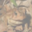

In [88]:
decode_img(img)

In [89]:
output=vae(adjust(torch.Tensor(img)[None, :]).to(device))[0]